In [1]:
import os
# set GPU number. This might work for several framework such as PyTorch, TensorFlow, Keras
gpu_id = '1'
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_id

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# sys.path.append('../../loglizer')
    
# from loglizer import dataloader
# from loglizer.preprocessing import Vectorizer, Iterator
import sys
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import Dataset
import torch.utils.data as Data
import pickle as pkl
import argparse
import time
import copy
import torchvision.transforms as transforms
import torchvision
import random
from collections import OrderedDict
from PIL import Image

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from collections import defaultdict

In [4]:
# struct_log = '../data/HDFS/HDFS.log_structured.csv' # The structured log file

#初始參數
class Parser():
    def __init__(self):
        self.mode = 'fedadam'  #FedBN,FedAvg,fedprox,fedopt,fedadagrad,fedadam 待加入scoffold
        #所有方法都有使用Fedbn
        self.beta_1 = 0.9
        self.beta_2 = 0.99 #b1,b2 for adaptive opt
        self.tau = 1e-2
        self.batch = 32
        self.lr = 1e-1
        self.server_lr = 1e-1
        self.server_momentum = 0.5
        self.client_momentum = 0.9 # 0 is fedavg others is fedavgm
        self.no_cuda = False
        self.seed = 1
        self.client_num = 5
        self.wk_iters = 1 # training
        self.num_workers = 2 # dataloader
        self.mu = 1e-3
        self.iters = 50 #epochs
        self.local_epochs = 10
        self.server_opt = 'sgd'
        self.percent = 1
#         self.early_stop = 500
        self.window_size = 10
        self.train_ratio = 0.5
        self.split_type='sequential' # sequential, uniform

        
args = Parser()

use_cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed) 
random.seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
sys.path.append('../')
from logdeep.models.lstm import deeplog, loganomaly, robustlog
from logdeep.tools.predict import Predicter
from logdeep.tools.train import Trainer
from logdeep.tools.utils import *

# Config Parameters

options = dict()
options['data_dir'] = '../data/'
options['window_size'] = 10
options['device'] = device

# Smaple
options['sample'] = "sliding_window"
options['window_size'] = 10  # if fix_window

# Features
options['sequentials'] = True
options['quantitatives'] = False
options['semantics'] = False
options['feature_num'] = sum(
    [options['sequentials'], options['quantitatives'], options['semantics']])

# Model
options['input_size'] = 1
options['hidden_size'] = 64
options['num_layers'] = 2
options['num_classes'] = 28

# Train
options['batch_size'] = 2048
options['accumulation_step'] = 1

options['optimizer'] = 'adam'
options['lr'] = 1e-2
options['max_epoch'] = args.local_epochs
options['lr_step'] = (300, 350)
options['lr_decay_ratio'] = 0.1

options['resume_path'] = None
options['model_name'] = "deeplog"
options['save_dir'] = "../result/deeplog/"

# Predict
options['model_path'] = "../result/deeplog/deeplog_last.pth"
options['num_candidates'] = 9

seed_everything(seed=1234)


def train():
    trainer = Trainer(Model, options)
    trainer.start_train()


def predict():
    predicter = Predicter(Model, options)
    predicter.predict_unsupervised()

# Preprocessing

In [6]:
# df = pd.read_csv(struct_log)
# print(df.shape)

# for i in range(args.client_num):
#     bound = int(df.shape[0]/args.client_num)
#     ddf = df[i* bound : (i+1)* bound]
#     ddf.to_csv("../../loglizer/data/client_alldata/client_"+str(i)+".csv", index=None)
#     print('Client',i, ddf.shape)
#     del ddf
# del df 

In [7]:
class deeplog(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(deeplog, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, features, device):
        input0 = features[0]
        h0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        out, _ = self.lstm(input0, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


class loganomaly(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(loganomaly, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm0 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.fc = nn.Linear(2 * hidden_size, num_keys)
        self.attention_size = self.hidden_size

        self.w_omega = Variable(
            torch.zeros(self.hidden_size, self.attention_size))
        self.u_omega = Variable(torch.zeros(self.attention_size))

        self.sequence_length = 28

    def attention_net(self, lstm_output):
        output_reshape = torch.Tensor.reshape(lstm_output,
                                              [-1, self.hidden_size])
        attn_tanh = torch.tanh(torch.mm(output_reshape, self.w_omega))
        attn_hidden_layer = torch.mm(
            attn_tanh, torch.Tensor.reshape(self.u_omega, [-1, 1]))
        exps = torch.Tensor.reshape(torch.exp(attn_hidden_layer),
                                    [-1, self.sequence_length])
        alphas = exps / torch.Tensor.reshape(torch.sum(exps, 1), [-1, 1])
        alphas_reshape = torch.Tensor.reshape(alphas,
                                              [-1, self.sequence_length, 1])
        state = lstm_output
        attn_output = torch.sum(state * alphas_reshape, 1)
        return attn_output

    def forward(self, features, device):
        input0, input1 = features[0], features[1]

        h0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)
        c0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)

        out0, _ = self.lstm0(input0, (h0_0, c0_0))

        h0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)
        c0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)

        out1, _ = self.lstm1(input1, (h0_1, c0_1))
        multi_out = torch.cat((out0[:, -1, :], out1[:, -1, :]), -1)
        out = self.fc(multi_out)
        return out


class robustlog(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(robustlog, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, features, device):
        input0 = features[0]
        h0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        out, _ = self.lstm(input0, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [8]:
# def datasplit(args, gpu_id = 1):
#     train_loaders = []
#     test_loaders = []
#     hidden_size = 32
#     num_directions = 2
#     topk = 5
    
#     for i in range(args.client_num):
#         struct_log = '../../loglizer/data/client_data/client_'+str(i)+".csv"
#         label_file = '../../loglizer/data/HDFS/anomaly_label.csv' # The anomaly label file
        
#         (x_train, window_y_train, y_train), (x_test, window_y_test, y_test) = dataloader.load_HDFS(i, struct_log, label_file = label_file, window='session', window_size=args.window_size, train_ratio=args.train_ratio, split_type=args.split_type)
#         feature_extractor = Vectorizer()
#         train_dataset = feature_extractor.fit_transform(x_train, window_y_train, y_train)
#         test_dataset = feature_extractor.transform(x_test, window_y_test, y_test)
#         train_loader = Iterator(train_dataset, batch_size=args.batch, shuffle=True, num_workers=args.num_workers).iter
#         test_loader = Iterator(test_dataset, batch_size=args.batch, shuffle=False, num_workers=args.num_workers).iter
#         train_loaders.append(train_loader)
#         test_loaders.append(test_loader)
        
#     server_model = DeepLog(num_labels=feature_extractor.num_labels, hidden_size=hidden_size, num_directions=num_directions, topk=topk).to(device)
    
#     return train_loaders, test_loaders, server_model

In [9]:
# train_loaders, test_loaders, server_model = datasplit(args, gpu_id = 1)

# Federated learning

In [10]:
def communication(args, server_model, models, client_weights, v, grad):
    if args.mode.lower() == 'fedbn':
        with torch.no_grad():
            for key in server_model.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models[client_idx].state_dict()[key]
                    server_model.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models[client_idx].state_dict()[key].data.copy_(server_model.state_dict()[key])
    
    elif args.mode.lower() == 'fedadagrad':
        with torch.no_grad():
            for key, param in server_model.named_parameters():
                temp = torch.zeros_like(server_model.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad[key] = param.grad
                v[key] = v[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models[client_idx].state_dict()[key].data.copy_(server_model.state_dict()[key])            
    
    elif args.mode.lower() == 'fedadam':
        with torch.no_grad():
            for key, param in server_model.named_parameters():                
                temp = torch.zeros_like(server_model.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models[client_idx].state_dict()[key]                         
                param.grad = temp - param.data              
                param.grad = torch.mul(grad[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad[key] = param.grad                
                v[key] = torch.mul(v[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v[key]),args.tau)), args.server_lr)
                
                for client_idx in range(len(client_weights)):
                    models[client_idx].state_dict()[key].data.copy_(server_model.state_dict()[key])

    else:
        with torch.no_grad():
            for key in server_model.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model.state_dict()[key].data.copy_(models[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models[client_idx].state_dict()[key]                        
                    server_model.state_dict()[key].data.copy_(temp)#weight傳給server
                    for client_idx in range(len(client_weights)):
                        models[client_idx].state_dict()[key].data.copy_(server_model.state_dict()[key])        
    return server_model, models, v, grad

In [11]:
# # setup model
server_model = deeplog(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)
# for adaptive velocity
v = {}
grad = {}
for key in server_model.state_dict().keys():
    v[key] = torch.add(torch.zeros_like(server_model.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad[key] = torch.zeros_like(server_model.state_dict()[key],dtype=torch.float32)
loss_fun = nn.CrossEntropyLoss()
# name of each datasets
datasets = ['Client'+str(i) for i in range(args.client_num)]
# federated client number
client_num = len(datasets)
client_weights = [1/client_num for i in range(client_num)]
# each local client model
models = [copy.deepcopy(server_model).to(device) for idx in range(client_num)]

start_iter = 0

lloogg_1 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_2 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_3 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_4 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_5 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}

result_recall = {}
result_precision = {}
result_f1 = {}
result_acc = {}
for i in range(client_num):
    result_recall[i] = []
    result_precision[i] = []
    result_f1[i] = []
    result_acc[i] = []

# Start training
for a_iter in range(start_iter, args.iters):
#     optimizers = [optim.SGD(params = models[idx].parameters(), lr=args.lr, momentum = args.client_momentum) for idx in range(client_num)]
    for wi in range(args.wk_iters):
        print("============ Train epoch {} ============".format(wi + a_iter * args.wk_iters))
        for client_idx, model in enumerate(models):
            print('Client ', client_idx)
            trainer = Trainer(model, options, args.client_num, client_idx)
            trainer.start_train()
            
            exec('lloogg_'+str(client_idx+1)+"['train']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['train']['lr'].append(trainer.log['train']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['time'].append(trainer.log['train']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['loss'].append(trainer.log['train']['loss'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['val']['lr'].append(trainer.log['valid']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['time'].append(trainer.log['valid']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['loss'].append(trainer.log['valid']['loss'][-1])")

    with torch.no_grad():
        # aggregation
        server_model, models, v, grad = communication(args, server_model, models, client_weights, v, grad )
        # Report loss after aggregation
        print("============ Test epoch {} ============".format(wi + a_iter * args.wk_iters))

        for client_idx, model in enumerate(models):
            print('Client ', client_idx)
            predicter = Predicter(model, options, args.client_num, client_idx)
            predicter.predict_unsupervised()
            
            result_recall[client_idx].append(predicter.recall)
            result_precision[client_idx].append(predicter.precision)
            result_f1[client_idx].append(predicter.f1)
            result_acc[client_idx].append(predicter.acc)

============ Train epoch 0 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3569.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:02:10 | Learning rate: 0.000313


Train loss: 3.29352: 100%|██████████| 5/5 [00:00<00:00, 44.74it/s]


Starting epoch: 1 | phase: train | ⏰: 15:02:10 | Learning rate: 0.000625


Train loss: 3.21539: 100%|██████████| 5/5 [00:00<00:00, 52.77it/s]


Starting epoch: 2 | phase: train | ⏰: 15:02:10 | Learning rate: 0.001250


Train loss: 3.01302: 100%|██████████| 5/5 [00:00<00:00, 54.10it/s]


Starting epoch: 3 | phase: train | ⏰: 15:02:10 | Learning rate: 0.002500


Train loss: 2.39796: 100%|██████████| 5/5 [00:00<00:00, 36.05it/s]


Starting epoch: 4 | phase: train | ⏰: 15:02:11 | Learning rate: 0.005000


Train loss: 1.88137: 100%|██████████| 5/5 [00:00<00:00, 54.45it/s]


Starting epoch: 5 | phase: train | ⏰: 15:02:11 | Learning rate: 0.010000


Train loss: 1.79972: 100%|██████████| 5/5 [00:00<00:00, 54.56it/s]


Starting epoch: 6 | phase: train | ⏰: 15:02:11 | Learning rate: 0.010000


Train loss: 1.72403: 100%|██████████| 5/5 [00:00<00:00, 53.83it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:02:11 


: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Validation loss: 1.6736316680908203
Starting epoch: 7 | phase: train | ⏰: 15:02:11 | Learning rate: 0.010000


Train loss: 1.61543: 100%|██████████| 5/5 [00:00<00:00, 53.57it/s]


Starting epoch: 8 | phase: train | ⏰: 15:02:11 | Learning rate: 0.010000


Train loss: 1.48918: 100%|██████████| 5/5 [00:00<00:00, 54.83it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:02:11 


: 100%|██████████| 1/1 [00:00<00:00, 99.02it/s]


Validation loss: 1.420407772064209
Starting epoch: 9 | phase: train | ⏰: 15:02:11 | Learning rate: 0.010000


Train loss: 1.38713: 100%|██████████| 5/5 [00:00<00:00, 49.67it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2244.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:02:24 | Learning rate: 0.000313


Train loss: 3.29146: 100%|██████████| 5/5 [00:00<00:00, 23.39it/s]


Starting epoch: 1 | phase: train | ⏰: 15:02:24 | Learning rate: 0.000625


Train loss: 3.21361: 100%|██████████| 5/5 [00:00<00:00, 23.07it/s]


Starting epoch: 2 | phase: train | ⏰: 15:02:24 | Learning rate: 0.001250


Train loss: 3.01396: 100%|██████████| 5/5 [00:00<00:00, 25.85it/s]


Starting epoch: 3 | phase: train | ⏰: 15:02:24 | Learning rate: 0.002500


Train loss: 2.40216: 100%|██████████| 5/5 [00:00<00:00, 16.13it/s]


Starting epoch: 4 | phase: train | ⏰: 15:02:25 | Learning rate: 0.005000


Train loss: 1.87553: 100%|██████████| 5/5 [00:00<00:00, 21.80it/s]


Starting epoch: 5 | phase: train | ⏰: 15:02:25 | Learning rate: 0.010000


Train loss: 1.79502: 100%|██████████| 5/5 [00:00<00:00, 19.07it/s]


Starting epoch: 6 | phase: train | ⏰: 15:02:25 | Learning rate: 0.010000


Train loss: 1.71375: 100%|██████████| 5/5 [00:00<00:00, 21.02it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:02:26 


: 100%|██████████| 1/1 [00:00<00:00, 60.42it/s]


Validation loss: 1.605653166770935
Starting epoch: 7 | phase: train | ⏰: 15:02:26 | Learning rate: 0.010000


Train loss: 1.58472: 100%|██████████| 5/5 [00:00<00:00, 15.78it/s]


Starting epoch: 8 | phase: train | ⏰: 15:02:26 | Learning rate: 0.010000


Train loss: 1.45069: 100%|██████████| 5/5 [00:00<00:00, 23.49it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:02:26 


: 100%|██████████| 1/1 [00:00<00:00, 58.11it/s]


Validation loss: 1.3681538105010986
Starting epoch: 9 | phase: train | ⏰: 15:02:26 | Learning rate: 0.010000


Train loss: 1.34056: 100%|██████████| 5/5 [00:00<00:00, 21.83it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3392.08it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:02:39 | Learning rate: 0.000313


Train loss: 3.29495: 100%|██████████| 5/5 [00:00<00:00, 52.70it/s]


Starting epoch: 1 | phase: train | ⏰: 15:02:39 | Learning rate: 0.000625


Train loss: 3.21767: 100%|██████████| 5/5 [00:00<00:00, 52.30it/s]


Starting epoch: 2 | phase: train | ⏰: 15:02:39 | Learning rate: 0.001250


Train loss: 3.01820: 100%|██████████| 5/5 [00:00<00:00, 50.23it/s]


Starting epoch: 3 | phase: train | ⏰: 15:02:39 | Learning rate: 0.002500


Train loss: 2.40805: 100%|██████████| 5/5 [00:00<00:00, 34.01it/s]


Starting epoch: 4 | phase: train | ⏰: 15:02:39 | Learning rate: 0.005000


Train loss: 1.90071: 100%|██████████| 5/5 [00:00<00:00, 50.71it/s]


Starting epoch: 5 | phase: train | ⏰: 15:02:39 | Learning rate: 0.010000


Train loss: 1.81239: 100%|██████████| 5/5 [00:00<00:00, 51.69it/s]


Starting epoch: 6 | phase: train | ⏰: 15:02:39 | Learning rate: 0.010000


Train loss: 1.73142: 100%|██████████| 5/5 [00:00<00:00, 51.29it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:02:39 


: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Validation loss: 1.6737288236618042
Starting epoch: 7 | phase: train | ⏰: 15:02:39 | Learning rate: 0.010000


Train loss: 1.63801: 100%|██████████| 5/5 [00:00<00:00, 51.26it/s]


Starting epoch: 8 | phase: train | ⏰: 15:02:39 | Learning rate: 0.010000


Train loss: 1.53836: 100%|██████████| 5/5 [00:00<00:00, 48.93it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:02:40 


: 100%|██████████| 1/1 [00:00<00:00, 100.71it/s]


Validation loss: 1.4726296663284302
Starting epoch: 9 | phase: train | ⏰: 15:02:40 | Learning rate: 0.010000


Train loss: 1.44246: 100%|██████████| 5/5 [00:00<00:00, 53.15it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3416.69it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:02:52 | Learning rate: 0.000313


Train loss: 3.29295: 100%|██████████| 5/5 [00:00<00:00, 43.49it/s]


Starting epoch: 1 | phase: train | ⏰: 15:02:52 | Learning rate: 0.000625


Train loss: 3.21527: 100%|██████████| 5/5 [00:00<00:00, 54.01it/s]


Starting epoch: 2 | phase: train | ⏰: 15:02:52 | Learning rate: 0.001250


Train loss: 3.01211: 100%|██████████| 5/5 [00:00<00:00, 53.84it/s]


Starting epoch: 3 | phase: train | ⏰: 15:02:52 | Learning rate: 0.002500


Train loss: 2.39591: 100%|██████████| 5/5 [00:00<00:00, 54.04it/s]


Starting epoch: 4 | phase: train | ⏰: 15:02:52 | Learning rate: 0.005000


Train loss: 1.88317: 100%|██████████| 5/5 [00:00<00:00, 52.97it/s]


Starting epoch: 5 | phase: train | ⏰: 15:02:52 | Learning rate: 0.010000


Train loss: 1.81079: 100%|██████████| 5/5 [00:00<00:00, 33.46it/s]


Starting epoch: 6 | phase: train | ⏰: 15:02:52 | Learning rate: 0.010000


Train loss: 1.73118: 100%|██████████| 5/5 [00:00<00:00, 47.69it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:02:53 


: 100%|██████████| 1/1 [00:00<00:00, 93.97it/s]


Validation loss: 1.6506084203720093
Starting epoch: 7 | phase: train | ⏰: 15:02:53 | Learning rate: 0.010000


Train loss: 1.61653: 100%|██████████| 5/5 [00:00<00:00, 51.15it/s]


Starting epoch: 8 | phase: train | ⏰: 15:02:53 | Learning rate: 0.010000


Train loss: 1.47892: 100%|██████████| 5/5 [00:00<00:00, 54.09it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:02:53 


: 100%|██████████| 1/1 [00:00<00:00, 97.56it/s]


Validation loss: 1.3919743299484253
Starting epoch: 9 | phase: train | ⏰: 15:02:53 | Learning rate: 0.010000


Train loss: 1.36460: 100%|██████████| 5/5 [00:00<00:00, 35.31it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3273.58it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:03:05 | Learning rate: 0.000313


Train loss: 3.29233: 100%|██████████| 5/5 [00:00<00:00, 50.76it/s]


Starting epoch: 1 | phase: train | ⏰: 15:03:05 | Learning rate: 0.000625


Train loss: 3.21468: 100%|██████████| 5/5 [00:00<00:00, 46.68it/s]


Starting epoch: 2 | phase: train | ⏰: 15:03:05 | Learning rate: 0.001250


Train loss: 3.01019: 100%|██████████| 5/5 [00:00<00:00, 47.02it/s]


Starting epoch: 3 | phase: train | ⏰: 15:03:05 | Learning rate: 0.002500


Train loss: 2.39196: 100%|██████████| 5/5 [00:00<00:00, 49.31it/s]


Starting epoch: 4 | phase: train | ⏰: 15:03:05 | Learning rate: 0.005000


Train loss: 1.88809: 100%|██████████| 5/5 [00:00<00:00, 51.25it/s]


Starting epoch: 5 | phase: train | ⏰: 15:03:05 | Learning rate: 0.010000


Train loss: 1.80842: 100%|██████████| 5/5 [00:00<00:00, 35.00it/s]


Starting epoch: 6 | phase: train | ⏰: 15:03:06 | Learning rate: 0.010000


Train loss: 1.74308: 100%|██████████| 5/5 [00:00<00:00, 55.03it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:03:06 


: 100%|██████████| 1/1 [00:00<00:00, 107.57it/s]


Validation loss: 1.6693072319030762
Starting epoch: 7 | phase: train | ⏰: 15:03:06 | Learning rate: 0.010000


Train loss: 1.62619: 100%|██████████| 5/5 [00:00<00:00, 48.76it/s]


Starting epoch: 8 | phase: train | ⏰: 15:03:06 | Learning rate: 0.010000


Train loss: 1.48491: 100%|██████████| 5/5 [00:00<00:00, 51.44it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:03:06 


: 100%|██████████| 1/1 [00:00<00:00, 95.37it/s]


Validation loss: 1.3898630142211914
Starting epoch: 9 | phase: train | ⏰: 15:03:06 | Learning rate: 0.010000


Train loss: 1.36411: 100%|██████████| 5/5 [00:00<00:00, 34.89it/s]


============ Test epoch 0 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 87.98it/s]


false positive (FP): 483, false negative (FN): 24, Precision: 87.376%, Recall: 99.287%, F1-measure: 92.951%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.555
Finished Predicting
elapsed_time: 139.10142469406128
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 84.01it/s]


false positive (FP): 524, false negative (FN): 26, Precision: 86.442%, Recall: 99.228%, F1-measure: 92.395%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.518
Finished Predicting
elapsed_time: 133.35989236831665
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:06<00:00, 160.43it/s]


false positive (FP): 467, false negative (FN): 30, Precision: 87.723%, Recall: 99.109%, F1-measure: 93.069%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 129.75617575645447
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 82.06it/s]


false positive (FP): 447, false negative (FN): 28, Precision: 88.193%, Recall: 99.168%, F1-measure: 93.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 93.52558732032776
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 84.40it/s]


false positive (FP): 521, false negative (FN): 32, Precision: 86.489%, Recall: 99.050%, F1-measure: 92.344%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 134.13271236419678
============ Train epoch 1 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3478.84it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:13:51 | Learning rate: 0.000313


Train loss: 1.62166: 100%|██████████| 5/5 [00:00<00:00, 51.44it/s]


Starting epoch: 1 | phase: train | ⏰: 15:13:51 | Learning rate: 0.000625


Train loss: 1.55931: 100%|██████████| 5/5 [00:00<00:00, 52.33it/s]


Starting epoch: 2 | phase: train | ⏰: 15:13:51 | Learning rate: 0.001250


Train loss: 1.49770: 100%|██████████| 5/5 [00:00<00:00, 50.43it/s]


Starting epoch: 3 | phase: train | ⏰: 15:13:52 | Learning rate: 0.002500


Train loss: 1.45689: 100%|██████████| 5/5 [00:00<00:00, 34.49it/s]


Starting epoch: 4 | phase: train | ⏰: 15:13:52 | Learning rate: 0.005000


Train loss: 1.38283: 100%|██████████| 5/5 [00:00<00:00, 51.83it/s]


Starting epoch: 5 | phase: train | ⏰: 15:13:52 | Learning rate: 0.010000


Train loss: 1.25092: 100%|██████████| 5/5 [00:00<00:00, 44.28it/s]


Starting epoch: 6 | phase: train | ⏰: 15:13:52 | Learning rate: 0.010000


Train loss: 1.10157: 100%|██████████| 5/5 [00:00<00:00, 42.78it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:13:52 


: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Validation loss: 1.04169499874115
Starting epoch: 7 | phase: train | ⏰: 15:13:52 | Learning rate: 0.010000


Train loss: 0.94552: 100%|██████████| 5/5 [00:00<00:00, 52.06it/s]


Starting epoch: 8 | phase: train | ⏰: 15:13:52 | Learning rate: 0.010000


Train loss: 0.81728: 100%|██████████| 5/5 [00:00<00:00, 47.56it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:13:52 


: 100%|██████████| 1/1 [00:00<00:00, 97.18it/s]


Validation loss: 0.8185213208198547
Starting epoch: 9 | phase: train | ⏰: 15:13:52 | Learning rate: 0.010000


Train loss: 0.76298: 100%|██████████| 5/5 [00:00<00:00, 52.55it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3513.57it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:14:04 | Learning rate: 0.000313


Train loss: 1.62595: 100%|██████████| 5/5 [00:00<00:00, 54.29it/s]


Starting epoch: 1 | phase: train | ⏰: 15:14:05 | Learning rate: 0.000625


Train loss: 1.57001: 100%|██████████| 5/5 [00:00<00:00, 53.35it/s]


Starting epoch: 2 | phase: train | ⏰: 15:14:05 | Learning rate: 0.001250


Train loss: 1.51504: 100%|██████████| 5/5 [00:00<00:00, 52.80it/s]


Starting epoch: 3 | phase: train | ⏰: 15:14:05 | Learning rate: 0.002500


Train loss: 1.46836: 100%|██████████| 5/5 [00:00<00:00, 36.10it/s]


Starting epoch: 4 | phase: train | ⏰: 15:14:05 | Learning rate: 0.005000


Train loss: 1.40264: 100%|██████████| 5/5 [00:00<00:00, 53.81it/s]


Starting epoch: 5 | phase: train | ⏰: 15:14:05 | Learning rate: 0.010000


Train loss: 1.26761: 100%|██████████| 5/5 [00:00<00:00, 53.54it/s]


Starting epoch: 6 | phase: train | ⏰: 15:14:05 | Learning rate: 0.010000


Train loss: 1.11253: 100%|██████████| 5/5 [00:00<00:00, 54.13it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:14:05 


: 100%|██████████| 1/1 [00:00<00:00, 98.50it/s]


Validation loss: 0.9825037121772766
Starting epoch: 7 | phase: train | ⏰: 15:14:05 | Learning rate: 0.010000


Train loss: 0.97349: 100%|██████████| 5/5 [00:00<00:00, 32.08it/s]


Starting epoch: 8 | phase: train | ⏰: 15:14:05 | Learning rate: 0.010000


Train loss: 0.83945: 100%|██████████| 5/5 [00:00<00:00, 52.73it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:14:05 


: 100%|██████████| 1/1 [00:00<00:00, 93.94it/s]


Validation loss: 0.7259691953659058
Starting epoch: 9 | phase: train | ⏰: 15:14:05 | Learning rate: 0.010000


Train loss: 0.74224: 100%|██████████| 5/5 [00:00<00:00, 54.10it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3278.17it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:14:18 | Learning rate: 0.000313


Train loss: 1.64201: 100%|██████████| 5/5 [00:00<00:00, 51.85it/s]


Starting epoch: 1 | phase: train | ⏰: 15:14:18 | Learning rate: 0.000625


Train loss: 1.58262: 100%|██████████| 5/5 [00:00<00:00, 52.28it/s]


Starting epoch: 2 | phase: train | ⏰: 15:14:18 | Learning rate: 0.001250


Train loss: 1.51904: 100%|██████████| 5/5 [00:00<00:00, 50.93it/s]


Starting epoch: 3 | phase: train | ⏰: 15:14:18 | Learning rate: 0.002500


Train loss: 1.47807: 100%|██████████| 5/5 [00:00<00:00, 34.27it/s]


Starting epoch: 4 | phase: train | ⏰: 15:14:18 | Learning rate: 0.005000


Train loss: 1.40944: 100%|██████████| 5/5 [00:00<00:00, 52.93it/s]


Starting epoch: 5 | phase: train | ⏰: 15:14:18 | Learning rate: 0.010000


Train loss: 1.28129: 100%|██████████| 5/5 [00:00<00:00, 52.89it/s]


Starting epoch: 6 | phase: train | ⏰: 15:14:18 | Learning rate: 0.010000


Train loss: 1.12340: 100%|██████████| 5/5 [00:00<00:00, 52.73it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:14:18 


: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Validation loss: 1.0386308431625366
Starting epoch: 7 | phase: train | ⏰: 15:14:18 | Learning rate: 0.010000


Train loss: 0.98888: 100%|██████████| 5/5 [00:00<00:00, 52.07it/s]


Starting epoch: 8 | phase: train | ⏰: 15:14:19 | Learning rate: 0.010000


Train loss: 0.85560: 100%|██████████| 5/5 [00:00<00:00, 52.88it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:14:19 


: 100%|██████████| 1/1 [00:00<00:00, 100.03it/s]


Validation loss: 0.780033528804779
Starting epoch: 9 | phase: train | ⏰: 15:14:19 | Learning rate: 0.010000


Train loss: 0.77228: 100%|██████████| 5/5 [00:00<00:00, 53.23it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3360.80it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:14:31 | Learning rate: 0.000313


Train loss: 1.62470: 100%|██████████| 5/5 [00:00<00:00, 47.65it/s]


Starting epoch: 1 | phase: train | ⏰: 15:14:31 | Learning rate: 0.000625


Train loss: 1.56039: 100%|██████████| 5/5 [00:00<00:00, 46.20it/s]


Starting epoch: 2 | phase: train | ⏰: 15:14:31 | Learning rate: 0.001250


Train loss: 1.50013: 100%|██████████| 5/5 [00:00<00:00, 50.30it/s]


Starting epoch: 3 | phase: train | ⏰: 15:14:31 | Learning rate: 0.002500


Train loss: 1.46062: 100%|██████████| 5/5 [00:00<00:00, 52.79it/s]


Starting epoch: 4 | phase: train | ⏰: 15:14:31 | Learning rate: 0.005000


Train loss: 1.39296: 100%|██████████| 5/5 [00:00<00:00, 52.68it/s]


Starting epoch: 5 | phase: train | ⏰: 15:14:31 | Learning rate: 0.010000


Train loss: 1.26129: 100%|██████████| 5/5 [00:00<00:00, 33.95it/s]


Starting epoch: 6 | phase: train | ⏰: 15:14:32 | Learning rate: 0.010000


Train loss: 1.10416: 100%|██████████| 5/5 [00:00<00:00, 52.28it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:14:32 


: 100%|██████████| 1/1 [00:00<00:00, 93.55it/s]


Validation loss: 0.95088791847229
Starting epoch: 7 | phase: train | ⏰: 15:14:32 | Learning rate: 0.010000


Train loss: 0.97387: 100%|██████████| 5/5 [00:00<00:00, 52.60it/s]


Starting epoch: 8 | phase: train | ⏰: 15:14:32 | Learning rate: 0.010000


Train loss: 0.84052: 100%|██████████| 5/5 [00:00<00:00, 50.25it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:14:32 


: 100%|██████████| 1/1 [00:00<00:00, 95.93it/s]


Validation loss: 0.7128839492797852
Starting epoch: 9 | phase: train | ⏰: 15:14:32 | Learning rate: 0.010000


Train loss: 0.75428: 100%|██████████| 5/5 [00:00<00:00, 33.80it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3413.83it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:14:44 | Learning rate: 0.000313


Train loss: 1.62627: 100%|██████████| 5/5 [00:00<00:00, 47.95it/s]


Starting epoch: 1 | phase: train | ⏰: 15:14:44 | Learning rate: 0.000625


Train loss: 1.56970: 100%|██████████| 5/5 [00:00<00:00, 51.96it/s]


Starting epoch: 2 | phase: train | ⏰: 15:14:44 | Learning rate: 0.001250


Train loss: 1.50839: 100%|██████████| 5/5 [00:00<00:00, 53.09it/s]


Starting epoch: 3 | phase: train | ⏰: 15:14:44 | Learning rate: 0.002500


Train loss: 1.46627: 100%|██████████| 5/5 [00:00<00:00, 52.75it/s]


Starting epoch: 4 | phase: train | ⏰: 15:14:44 | Learning rate: 0.005000


Train loss: 1.39469: 100%|██████████| 5/5 [00:00<00:00, 49.77it/s]


Starting epoch: 5 | phase: train | ⏰: 15:14:45 | Learning rate: 0.010000


Train loss: 1.26739: 100%|██████████| 5/5 [00:00<00:00, 33.12it/s]


Starting epoch: 6 | phase: train | ⏰: 15:14:45 | Learning rate: 0.010000


Train loss: 1.10946: 100%|██████████| 5/5 [00:00<00:00, 42.59it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:14:45 


: 100%|██████████| 1/1 [00:00<00:00, 95.91it/s]


Validation loss: 0.9535843729972839
Starting epoch: 7 | phase: train | ⏰: 15:14:45 | Learning rate: 0.010000


Train loss: 1.00268: 100%|██████████| 5/5 [00:00<00:00, 49.66it/s]


Starting epoch: 8 | phase: train | ⏰: 15:14:45 | Learning rate: 0.010000


Train loss: 0.90046: 100%|██████████| 5/5 [00:00<00:00, 51.11it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:14:45 


: 100%|██████████| 1/1 [00:00<00:00, 98.86it/s]


Validation loss: 0.7702133059501648
Starting epoch: 9 | phase: train | ⏰: 15:14:45 | Learning rate: 0.010000


Train loss: 0.80888: 100%|██████████| 5/5 [00:00<00:00, 34.42it/s]


============ Test epoch 1 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 87.34it/s]


false positive (FP): 483, false negative (FN): 25, Precision: 87.373%, Recall: 99.257%, F1-measure: 92.937%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.555
Finished Predicting
elapsed_time: 140.0713188648224
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.79it/s]


false positive (FP): 524, false negative (FN): 25, Precision: 86.446%, Recall: 99.257%, F1-measure: 92.410%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.519
Finished Predicting
elapsed_time: 133.3642237186432
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 83.12it/s]


false positive (FP): 467, false negative (FN): 32, Precision: 87.717%, Recall: 99.050%, F1-measure: 93.039%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.562
Finished Predicting
elapsed_time: 138.79335498809814
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 82.12it/s]


false positive (FP): 447, false negative (FN): 29, Precision: 88.190%, Recall: 99.139%, F1-measure: 93.345%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 82.04534983634949
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 87.84it/s]


false positive (FP): 521, false negative (FN): 32, Precision: 86.489%, Recall: 99.050%, F1-measure: 92.344%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 134.9344048500061
============ Train epoch 2 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3391.11it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:25:30 | Learning rate: 0.000313


Train loss: 1.34301: 100%|██████████| 5/5 [00:00<00:00, 52.83it/s]


Starting epoch: 1 | phase: train | ⏰: 15:25:30 | Learning rate: 0.000625


Train loss: 1.22887: 100%|██████████| 5/5 [00:00<00:00, 52.12it/s]


Starting epoch: 2 | phase: train | ⏰: 15:25:30 | Learning rate: 0.001250


Train loss: 1.18411: 100%|██████████| 5/5 [00:00<00:00, 46.50it/s]


Starting epoch: 3 | phase: train | ⏰: 15:25:30 | Learning rate: 0.002500


Train loss: 1.15043: 100%|██████████| 5/5 [00:00<00:00, 34.45it/s]


Starting epoch: 4 | phase: train | ⏰: 15:25:30 | Learning rate: 0.005000


Train loss: 1.06939: 100%|██████████| 5/5 [00:00<00:00, 52.69it/s]


Starting epoch: 5 | phase: train | ⏰: 15:25:30 | Learning rate: 0.010000


Train loss: 0.91742: 100%|██████████| 5/5 [00:00<00:00, 52.40it/s]


Starting epoch: 6 | phase: train | ⏰: 15:25:30 | Learning rate: 0.010000


Train loss: 0.81981: 100%|██████████| 5/5 [00:00<00:00, 53.57it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:25:30 


: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


Validation loss: 0.7255951762199402
Starting epoch: 7 | phase: train | ⏰: 15:25:31 | Learning rate: 0.010000


Train loss: 0.73567: 100%|██████████| 5/5 [00:00<00:00, 51.73it/s]


Starting epoch: 8 | phase: train | ⏰: 15:25:31 | Learning rate: 0.010000


Train loss: 0.67869: 100%|██████████| 5/5 [00:00<00:00, 52.83it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:25:31 


: 100%|██████████| 1/1 [00:00<00:00, 98.25it/s]


Validation loss: 0.6178687810897827
Starting epoch: 9 | phase: train | ⏰: 15:25:31 | Learning rate: 0.010000


Train loss: 0.62722: 100%|██████████| 5/5 [00:00<00:00, 52.93it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3380.38it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:25:43 | Learning rate: 0.000313


Train loss: 1.36112: 100%|██████████| 5/5 [00:00<00:00, 53.44it/s]


Starting epoch: 1 | phase: train | ⏰: 15:25:43 | Learning rate: 0.000625


Train loss: 1.23865: 100%|██████████| 5/5 [00:00<00:00, 53.51it/s]


Starting epoch: 2 | phase: train | ⏰: 15:25:43 | Learning rate: 0.001250


Train loss: 1.19812: 100%|██████████| 5/5 [00:00<00:00, 53.91it/s]


Starting epoch: 3 | phase: train | ⏰: 15:25:43 | Learning rate: 0.002500


Train loss: 1.16366: 100%|██████████| 5/5 [00:00<00:00, 35.44it/s]


Starting epoch: 4 | phase: train | ⏰: 15:25:43 | Learning rate: 0.005000


Train loss: 1.08696: 100%|██████████| 5/5 [00:00<00:00, 50.83it/s]


Starting epoch: 5 | phase: train | ⏰: 15:25:43 | Learning rate: 0.010000


Train loss: 0.94743: 100%|██████████| 5/5 [00:00<00:00, 51.06it/s]


Starting epoch: 6 | phase: train | ⏰: 15:25:44 | Learning rate: 0.010000


Train loss: 0.84219: 100%|██████████| 5/5 [00:00<00:00, 54.58it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:25:44 


: 100%|██████████| 1/1 [00:00<00:00, 97.38it/s]


Validation loss: 0.7755489349365234
Starting epoch: 7 | phase: train | ⏰: 15:25:44 | Learning rate: 0.010000


Train loss: 0.76192: 100%|██████████| 5/5 [00:00<00:00, 34.60it/s]


Starting epoch: 8 | phase: train | ⏰: 15:25:44 | Learning rate: 0.010000


Train loss: 0.70485: 100%|██████████| 5/5 [00:00<00:00, 53.68it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:25:44 


: 100%|██████████| 1/1 [00:00<00:00, 99.25it/s]


Validation loss: 0.6518583297729492
Starting epoch: 9 | phase: train | ⏰: 15:25:44 | Learning rate: 0.010000


Train loss: 0.65515: 100%|██████████| 5/5 [00:00<00:00, 51.99it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3335.63it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:25:56 | Learning rate: 0.000313


Train loss: 1.38938: 100%|██████████| 5/5 [00:00<00:00, 51.51it/s]


Starting epoch: 1 | phase: train | ⏰: 15:25:56 | Learning rate: 0.000625


Train loss: 1.27024: 100%|██████████| 5/5 [00:00<00:00, 51.19it/s]


Starting epoch: 2 | phase: train | ⏰: 15:25:56 | Learning rate: 0.001250


Train loss: 1.21686: 100%|██████████| 5/5 [00:00<00:00, 51.46it/s]


Starting epoch: 3 | phase: train | ⏰: 15:25:56 | Learning rate: 0.002500


Train loss: 1.19644: 100%|██████████| 5/5 [00:00<00:00, 34.85it/s]


Starting epoch: 4 | phase: train | ⏰: 15:25:57 | Learning rate: 0.005000


Train loss: 1.10237: 100%|██████████| 5/5 [00:00<00:00, 52.84it/s]


Starting epoch: 5 | phase: train | ⏰: 15:25:57 | Learning rate: 0.010000


Train loss: 0.96061: 100%|██████████| 5/5 [00:00<00:00, 53.47it/s]


Starting epoch: 6 | phase: train | ⏰: 15:25:57 | Learning rate: 0.010000


Train loss: 0.86047: 100%|██████████| 5/5 [00:00<00:00, 53.13it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:25:57 


: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Validation loss: 0.7761086821556091
Starting epoch: 7 | phase: train | ⏰: 15:25:57 | Learning rate: 0.010000


Train loss: 0.77058: 100%|██████████| 5/5 [00:00<00:00, 50.94it/s]


Starting epoch: 8 | phase: train | ⏰: 15:25:57 | Learning rate: 0.010000


Train loss: 0.70990: 100%|██████████| 5/5 [00:00<00:00, 52.11it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:25:57 


: 100%|██████████| 1/1 [00:00<00:00, 90.19it/s]


Validation loss: 0.6623677015304565
Starting epoch: 9 | phase: train | ⏰: 15:25:57 | Learning rate: 0.010000


Train loss: 0.68928: 100%|██████████| 5/5 [00:00<00:00, 52.74it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3454.25it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:26:09 | Learning rate: 0.000313


Train loss: 1.34652: 100%|██████████| 5/5 [00:00<00:00, 53.89it/s]


Starting epoch: 1 | phase: train | ⏰: 15:26:09 | Learning rate: 0.000625


Train loss: 1.22977: 100%|██████████| 5/5 [00:00<00:00, 52.71it/s]


Starting epoch: 2 | phase: train | ⏰: 15:26:10 | Learning rate: 0.001250


Train loss: 1.18022: 100%|██████████| 5/5 [00:00<00:00, 51.02it/s]


Starting epoch: 3 | phase: train | ⏰: 15:26:10 | Learning rate: 0.002500


Train loss: 1.15920: 100%|██████████| 5/5 [00:00<00:00, 53.07it/s]


Starting epoch: 4 | phase: train | ⏰: 15:26:10 | Learning rate: 0.005000


Train loss: 1.07477: 100%|██████████| 5/5 [00:00<00:00, 53.16it/s]


Starting epoch: 5 | phase: train | ⏰: 15:26:10 | Learning rate: 0.010000


Train loss: 0.93754: 100%|██████████| 5/5 [00:00<00:00, 34.81it/s]


Starting epoch: 6 | phase: train | ⏰: 15:26:10 | Learning rate: 0.010000


Train loss: 0.83710: 100%|██████████| 5/5 [00:00<00:00, 48.02it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:26:10 


: 100%|██████████| 1/1 [00:00<00:00, 67.15it/s]


Validation loss: 0.7057312726974487
Starting epoch: 7 | phase: train | ⏰: 15:26:10 | Learning rate: 0.010000


Train loss: 0.76007: 100%|██████████| 5/5 [00:00<00:00, 51.74it/s]


Starting epoch: 8 | phase: train | ⏰: 15:26:10 | Learning rate: 0.010000


Train loss: 0.70037: 100%|██████████| 5/5 [00:00<00:00, 50.88it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:26:10 


: 100%|██████████| 1/1 [00:00<00:00, 92.92it/s]


Validation loss: 0.577005922794342
Starting epoch: 9 | phase: train | ⏰: 15:26:10 | Learning rate: 0.010000


Train loss: 0.65879: 100%|██████████| 5/5 [00:00<00:00, 32.86it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3325.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:26:22 | Learning rate: 0.000313


Train loss: 1.36196: 100%|██████████| 5/5 [00:00<00:00, 51.93it/s]


Starting epoch: 1 | phase: train | ⏰: 15:26:23 | Learning rate: 0.000625


Train loss: 1.24682: 100%|██████████| 5/5 [00:00<00:00, 52.65it/s]


Starting epoch: 2 | phase: train | ⏰: 15:26:23 | Learning rate: 0.001250


Train loss: 1.19569: 100%|██████████| 5/5 [00:00<00:00, 51.45it/s]


Starting epoch: 3 | phase: train | ⏰: 15:26:23 | Learning rate: 0.002500


Train loss: 1.17647: 100%|██████████| 5/5 [00:00<00:00, 53.47it/s]


Starting epoch: 4 | phase: train | ⏰: 15:26:23 | Learning rate: 0.005000


Train loss: 1.09014: 100%|██████████| 5/5 [00:00<00:00, 47.51it/s]


Starting epoch: 5 | phase: train | ⏰: 15:26:23 | Learning rate: 0.010000


Train loss: 0.95609: 100%|██████████| 5/5 [00:00<00:00, 32.95it/s]


Starting epoch: 6 | phase: train | ⏰: 15:26:23 | Learning rate: 0.010000


Train loss: 0.85501: 100%|██████████| 5/5 [00:00<00:00, 52.55it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:26:23 


: 100%|██████████| 1/1 [00:00<00:00, 98.55it/s]


Validation loss: 0.8249443173408508
Starting epoch: 7 | phase: train | ⏰: 15:26:23 | Learning rate: 0.010000


Train loss: 0.76986: 100%|██████████| 5/5 [00:00<00:00, 52.31it/s]


Starting epoch: 8 | phase: train | ⏰: 15:26:23 | Learning rate: 0.010000


Train loss: 0.71198: 100%|██████████| 5/5 [00:00<00:00, 51.55it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:26:23 


: 100%|██████████| 1/1 [00:00<00:00, 91.92it/s]


Validation loss: 0.7100433707237244
Starting epoch: 9 | phase: train | ⏰: 15:26:23 | Learning rate: 0.010000


Train loss: 0.66366: 100%|██████████| 5/5 [00:00<00:00, 34.73it/s]


============ Test epoch 2 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 85.78it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 140.04895663261414
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 81.77it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 133.6105887889862
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 81.48it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.68581342697144
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:07<00:00, 156.35it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 90.35563349723816
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 133.02it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 79.44537472724915
============ Train epoch 3 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3512.25it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:36:22 | Learning rate: 0.000313


Train loss: 0.85766: 100%|██████████| 5/5 [00:00<00:00, 44.06it/s]


Starting epoch: 1 | phase: train | ⏰: 15:36:22 | Learning rate: 0.000625


Train loss: 0.80866: 100%|██████████| 5/5 [00:00<00:00, 50.16it/s]


Starting epoch: 2 | phase: train | ⏰: 15:36:22 | Learning rate: 0.001250


Train loss: 0.76979: 100%|██████████| 5/5 [00:00<00:00, 43.39it/s]


Starting epoch: 3 | phase: train | ⏰: 15:36:23 | Learning rate: 0.002500


Train loss: 0.73022: 100%|██████████| 5/5 [00:00<00:00, 34.47it/s]


Starting epoch: 4 | phase: train | ⏰: 15:36:23 | Learning rate: 0.005000


Train loss: 0.68977: 100%|██████████| 5/5 [00:00<00:00, 51.21it/s]


Starting epoch: 5 | phase: train | ⏰: 15:36:23 | Learning rate: 0.010000


Train loss: 0.64691: 100%|██████████| 5/5 [00:00<00:00, 51.38it/s]


Starting epoch: 6 | phase: train | ⏰: 15:36:23 | Learning rate: 0.010000


Train loss: 0.60091: 100%|██████████| 5/5 [00:00<00:00, 52.16it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:36:23 


: 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]


Validation loss: 0.5994266867637634
Starting epoch: 7 | phase: train | ⏰: 15:36:23 | Learning rate: 0.010000


Train loss: 0.57395: 100%|██████████| 5/5 [00:00<00:00, 53.05it/s]


Starting epoch: 8 | phase: train | ⏰: 15:36:23 | Learning rate: 0.010000


Train loss: 0.54135: 100%|██████████| 5/5 [00:00<00:00, 51.23it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:36:23 


: 100%|██████████| 1/1 [00:00<00:00, 71.31it/s]


Validation loss: 0.5604559779167175
Starting epoch: 9 | phase: train | ⏰: 15:36:23 | Learning rate: 0.010000


Train loss: 0.53107: 100%|██████████| 5/5 [00:00<00:00, 44.85it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3379.67it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:36:35 | Learning rate: 0.000313


Train loss: 0.87209: 100%|██████████| 5/5 [00:00<00:00, 53.22it/s]


Starting epoch: 1 | phase: train | ⏰: 15:36:36 | Learning rate: 0.000625


Train loss: 0.83831: 100%|██████████| 5/5 [00:00<00:00, 54.06it/s]


Starting epoch: 2 | phase: train | ⏰: 15:36:36 | Learning rate: 0.001250


Train loss: 0.78679: 100%|██████████| 5/5 [00:00<00:00, 53.03it/s]


Starting epoch: 3 | phase: train | ⏰: 15:36:36 | Learning rate: 0.002500


Train loss: 0.73524: 100%|██████████| 5/5 [00:00<00:00, 35.80it/s]


Starting epoch: 4 | phase: train | ⏰: 15:36:36 | Learning rate: 0.005000


Train loss: 0.70658: 100%|██████████| 5/5 [00:00<00:00, 54.45it/s]


Starting epoch: 5 | phase: train | ⏰: 15:36:36 | Learning rate: 0.010000


Train loss: 0.67065: 100%|██████████| 5/5 [00:00<00:00, 57.18it/s]


Starting epoch: 6 | phase: train | ⏰: 15:36:36 | Learning rate: 0.010000


Train loss: 0.61985: 100%|██████████| 5/5 [00:00<00:00, 57.69it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:36:36 


: 100%|██████████| 1/1 [00:00<00:00, 105.72it/s]


Validation loss: 0.5924414396286011
Starting epoch: 7 | phase: train | ⏰: 15:36:36 | Learning rate: 0.010000


Train loss: 0.59016: 100%|██████████| 5/5 [00:00<00:00, 36.78it/s]


Starting epoch: 8 | phase: train | ⏰: 15:36:36 | Learning rate: 0.010000


Train loss: 0.56115: 100%|██████████| 5/5 [00:00<00:00, 57.82it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:36:36 


: 100%|██████████| 1/1 [00:00<00:00, 106.63it/s]


Validation loss: 0.5599579811096191
Starting epoch: 9 | phase: train | ⏰: 15:36:36 | Learning rate: 0.010000


Train loss: 0.54646: 100%|██████████| 5/5 [00:00<00:00, 57.03it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3331.41it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:36:49 | Learning rate: 0.000313


Train loss: 0.90384: 100%|██████████| 5/5 [00:00<00:00, 51.32it/s]


Starting epoch: 1 | phase: train | ⏰: 15:36:49 | Learning rate: 0.000625


Train loss: 0.85673: 100%|██████████| 5/5 [00:00<00:00, 50.47it/s]


Starting epoch: 2 | phase: train | ⏰: 15:36:49 | Learning rate: 0.001250


Train loss: 0.81303: 100%|██████████| 5/5 [00:00<00:00, 50.33it/s]


Starting epoch: 3 | phase: train | ⏰: 15:36:49 | Learning rate: 0.002500


Train loss: 0.77246: 100%|██████████| 5/5 [00:00<00:00, 34.26it/s]


Starting epoch: 4 | phase: train | ⏰: 15:36:49 | Learning rate: 0.005000


Train loss: 0.72746: 100%|██████████| 5/5 [00:00<00:00, 49.76it/s]


Starting epoch: 5 | phase: train | ⏰: 15:36:49 | Learning rate: 0.010000


Train loss: 0.68100: 100%|██████████| 5/5 [00:00<00:00, 53.53it/s]


Starting epoch: 6 | phase: train | ⏰: 15:36:49 | Learning rate: 0.010000


Train loss: 0.64605: 100%|██████████| 5/5 [00:00<00:00, 53.90it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:36:49 


: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Validation loss: 0.6064743995666504
Starting epoch: 7 | phase: train | ⏰: 15:36:49 | Learning rate: 0.010000


Train loss: 0.61935: 100%|██████████| 5/5 [00:00<00:00, 49.78it/s]


Starting epoch: 8 | phase: train | ⏰: 15:36:50 | Learning rate: 0.010000


Train loss: 0.58745: 100%|██████████| 5/5 [00:00<00:00, 47.86it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:36:50 


: 100%|██████████| 1/1 [00:00<00:00, 84.98it/s]


Validation loss: 0.541562557220459
Starting epoch: 9 | phase: train | ⏰: 15:36:50 | Learning rate: 0.010000


Train loss: 0.56707: 100%|██████████| 5/5 [00:00<00:00, 53.24it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3568.26it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:37:02 | Learning rate: 0.000313


Train loss: 0.86008: 100%|██████████| 5/5 [00:00<00:00, 52.86it/s]


Starting epoch: 1 | phase: train | ⏰: 15:37:02 | Learning rate: 0.000625


Train loss: 0.81983: 100%|██████████| 5/5 [00:00<00:00, 53.34it/s]


Starting epoch: 2 | phase: train | ⏰: 15:37:02 | Learning rate: 0.001250


Train loss: 0.77054: 100%|██████████| 5/5 [00:00<00:00, 53.41it/s]


Starting epoch: 3 | phase: train | ⏰: 15:37:02 | Learning rate: 0.002500


Train loss: 0.72685: 100%|██████████| 5/5 [00:00<00:00, 53.16it/s]


Starting epoch: 4 | phase: train | ⏰: 15:37:02 | Learning rate: 0.005000


Train loss: 0.69206: 100%|██████████| 5/5 [00:00<00:00, 53.65it/s]


Starting epoch: 5 | phase: train | ⏰: 15:37:02 | Learning rate: 0.010000


Train loss: 0.65842: 100%|██████████| 5/5 [00:00<00:00, 35.53it/s]


Starting epoch: 6 | phase: train | ⏰: 15:37:02 | Learning rate: 0.010000


Train loss: 0.61878: 100%|██████████| 5/5 [00:00<00:00, 53.44it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:37:03 


: 100%|██████████| 1/1 [00:00<00:00, 98.22it/s]


Validation loss: 0.6307336091995239
Starting epoch: 7 | phase: train | ⏰: 15:37:03 | Learning rate: 0.010000


Train loss: 0.57653: 100%|██████████| 5/5 [00:00<00:00, 53.78it/s]


Starting epoch: 8 | phase: train | ⏰: 15:37:03 | Learning rate: 0.010000


Train loss: 0.54983: 100%|██████████| 5/5 [00:00<00:00, 56.93it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:37:03 


: 100%|██████████| 1/1 [00:00<00:00, 106.07it/s]


Validation loss: 0.5771552324295044
Starting epoch: 9 | phase: train | ⏰: 15:37:03 | Learning rate: 0.010000


Train loss: 0.52815: 100%|██████████| 5/5 [00:00<00:00, 36.66it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3400.98it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:37:15 | Learning rate: 0.000313


Train loss: 0.88775: 100%|██████████| 5/5 [00:00<00:00, 53.04it/s]


Starting epoch: 1 | phase: train | ⏰: 15:37:15 | Learning rate: 0.000625


Train loss: 0.84417: 100%|██████████| 5/5 [00:00<00:00, 44.31it/s]


Starting epoch: 2 | phase: train | ⏰: 15:37:15 | Learning rate: 0.001250


Train loss: 0.80520: 100%|██████████| 5/5 [00:00<00:00, 54.47it/s]


Starting epoch: 3 | phase: train | ⏰: 15:37:15 | Learning rate: 0.002500


Train loss: 0.76301: 100%|██████████| 5/5 [00:00<00:00, 55.13it/s]


Starting epoch: 4 | phase: train | ⏰: 15:37:15 | Learning rate: 0.005000


Train loss: 0.71782: 100%|██████████| 5/5 [00:00<00:00, 49.54it/s]


Starting epoch: 5 | phase: train | ⏰: 15:37:15 | Learning rate: 0.010000


Train loss: 0.67842: 100%|██████████| 5/5 [00:00<00:00, 33.96it/s]


Starting epoch: 6 | phase: train | ⏰: 15:37:15 | Learning rate: 0.010000


Train loss: 0.62995: 100%|██████████| 5/5 [00:00<00:00, 55.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:37:16 


: 100%|██████████| 1/1 [00:00<00:00, 102.76it/s]


Validation loss: 0.5211502313613892
Starting epoch: 7 | phase: train | ⏰: 15:37:16 | Learning rate: 0.010000


Train loss: 0.59677: 100%|██████████| 5/5 [00:00<00:00, 53.83it/s]


Starting epoch: 8 | phase: train | ⏰: 15:37:16 | Learning rate: 0.010000


Train loss: 0.57922: 100%|██████████| 5/5 [00:00<00:00, 53.86it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:37:16 


: 100%|██████████| 1/1 [00:00<00:00, 100.25it/s]


Validation loss: 0.4816751480102539
Starting epoch: 9 | phase: train | ⏰: 15:37:16 | Learning rate: 0.010000


Train loss: 0.56475: 100%|██████████| 5/5 [00:00<00:00, 35.83it/s]


============ Test epoch 3 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 136.02it/s]


false positive (FP): 496, false negative (FN): 24, Precision: 87.080%, Recall: 99.287%, F1-measure: 92.784%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.544
Finished Predicting
elapsed_time: 87.125736951828
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:08<00:00, 128.53it/s]


false positive (FP): 532, false negative (FN): 25, Precision: 86.267%, Recall: 99.257%, F1-measure: 92.308%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 83.84468197822571
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:08<00:00, 129.15it/s]


false positive (FP): 472, false negative (FN): 30, Precision: 87.608%, Recall: 99.109%, F1-measure: 93.004%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.560
Finished Predicting
elapsed_time: 86.95103287696838
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:04<00:00, 249.50it/s]


false positive (FP): 456, false negative (FN): 28, Precision: 87.984%, Recall: 99.168%, F1-measure: 93.242%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.576
Finished Predicting
elapsed_time: 47.52952599525452
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 129.60it/s]


false positive (FP): 534, false negative (FN): 32, Precision: 86.198%, Recall: 99.050%, F1-measure: 92.178%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.504
Finished Predicting
elapsed_time: 68.60869717597961
============ Train epoch 4 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3295.35it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:43:45 | Learning rate: 0.000313


Train loss: 0.71489: 100%|██████████| 5/5 [00:00<00:00, 51.14it/s]


Starting epoch: 1 | phase: train | ⏰: 15:43:45 | Learning rate: 0.000625


Train loss: 0.64227: 100%|██████████| 5/5 [00:00<00:00, 49.46it/s]


Starting epoch: 2 | phase: train | ⏰: 15:43:45 | Learning rate: 0.001250


Train loss: 0.62013: 100%|██████████| 5/5 [00:00<00:00, 54.06it/s]


Starting epoch: 3 | phase: train | ⏰: 15:43:45 | Learning rate: 0.002500


Train loss: 0.61150: 100%|██████████| 5/5 [00:00<00:00, 37.22it/s]


Starting epoch: 4 | phase: train | ⏰: 15:43:46 | Learning rate: 0.005000


Train loss: 0.57482: 100%|██████████| 5/5 [00:00<00:00, 56.41it/s]


Starting epoch: 5 | phase: train | ⏰: 15:43:46 | Learning rate: 0.010000


Train loss: 0.54436: 100%|██████████| 5/5 [00:00<00:00, 54.85it/s]


Starting epoch: 6 | phase: train | ⏰: 15:43:46 | Learning rate: 0.010000


Train loss: 0.51866: 100%|██████████| 5/5 [00:00<00:00, 56.47it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:43:46 


: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


Validation loss: 0.4806828796863556
Starting epoch: 7 | phase: train | ⏰: 15:43:46 | Learning rate: 0.010000


Train loss: 0.48979: 100%|██████████| 5/5 [00:00<00:00, 55.54it/s]


Starting epoch: 8 | phase: train | ⏰: 15:43:46 | Learning rate: 0.010000


Train loss: 0.47584: 100%|██████████| 5/5 [00:00<00:00, 53.11it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:43:46 


: 100%|██████████| 1/1 [00:00<00:00, 71.45it/s]


Validation loss: 0.4539095163345337
Starting epoch: 9 | phase: train | ⏰: 15:43:46 | Learning rate: 0.010000


Train loss: 0.46233: 100%|██████████| 5/5 [00:00<00:00, 46.39it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3415.02it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:43:58 | Learning rate: 0.000313


Train loss: 0.74144: 100%|██████████| 5/5 [00:00<00:00, 54.28it/s]


Starting epoch: 1 | phase: train | ⏰: 15:43:58 | Learning rate: 0.000625


Train loss: 0.65969: 100%|██████████| 5/5 [00:00<00:00, 53.87it/s]


Starting epoch: 2 | phase: train | ⏰: 15:43:58 | Learning rate: 0.001250


Train loss: 0.64370: 100%|██████████| 5/5 [00:00<00:00, 54.35it/s]


Starting epoch: 3 | phase: train | ⏰: 15:43:59 | Learning rate: 0.002500


Train loss: 0.62690: 100%|██████████| 5/5 [00:00<00:00, 37.09it/s]


Starting epoch: 4 | phase: train | ⏰: 15:43:59 | Learning rate: 0.005000


Train loss: 0.59145: 100%|██████████| 5/5 [00:00<00:00, 58.09it/s]


Starting epoch: 5 | phase: train | ⏰: 15:43:59 | Learning rate: 0.010000


Train loss: 0.56617: 100%|██████████| 5/5 [00:00<00:00, 57.00it/s]


Starting epoch: 6 | phase: train | ⏰: 15:43:59 | Learning rate: 0.010000


Train loss: 0.53723: 100%|██████████| 5/5 [00:00<00:00, 57.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:43:59 


: 100%|██████████| 1/1 [00:00<00:00, 102.56it/s]


Validation loss: 0.5402002334594727
Starting epoch: 7 | phase: train | ⏰: 15:43:59 | Learning rate: 0.010000


Train loss: 0.51493: 100%|██████████| 5/5 [00:00<00:00, 37.67it/s]


Starting epoch: 8 | phase: train | ⏰: 15:43:59 | Learning rate: 0.010000


Train loss: 0.49418: 100%|██████████| 5/5 [00:00<00:00, 51.44it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:43:59 


: 100%|██████████| 1/1 [00:00<00:00, 107.27it/s]


Validation loss: 0.5114730000495911
Starting epoch: 9 | phase: train | ⏰: 15:43:59 | Learning rate: 0.010000


Train loss: 0.48381: 100%|██████████| 5/5 [00:00<00:00, 58.26it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3343.31it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:44:11 | Learning rate: 0.000313


Train loss: 0.75395: 100%|██████████| 5/5 [00:00<00:00, 53.26it/s]


Starting epoch: 1 | phase: train | ⏰: 15:44:12 | Learning rate: 0.000625


Train loss: 0.67824: 100%|██████████| 5/5 [00:00<00:00, 50.82it/s]


Starting epoch: 2 | phase: train | ⏰: 15:44:12 | Learning rate: 0.001250


Train loss: 0.66421: 100%|██████████| 5/5 [00:00<00:00, 52.18it/s]


Starting epoch: 3 | phase: train | ⏰: 15:44:12 | Learning rate: 0.002500


Train loss: 0.64327: 100%|██████████| 5/5 [00:00<00:00, 32.87it/s]


Starting epoch: 4 | phase: train | ⏰: 15:44:12 | Learning rate: 0.005000


Train loss: 0.60849: 100%|██████████| 5/5 [00:00<00:00, 47.54it/s]


Starting epoch: 5 | phase: train | ⏰: 15:44:12 | Learning rate: 0.010000


Train loss: 0.57583: 100%|██████████| 5/5 [00:00<00:00, 44.16it/s]


Starting epoch: 6 | phase: train | ⏰: 15:44:12 | Learning rate: 0.010000


Train loss: 0.54521: 100%|██████████| 5/5 [00:00<00:00, 47.41it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:44:12 


: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s]


Validation loss: 0.49023711681365967
Starting epoch: 7 | phase: train | ⏰: 15:44:12 | Learning rate: 0.010000


Train loss: 0.51922: 100%|██████████| 5/5 [00:00<00:00, 40.34it/s]


Starting epoch: 8 | phase: train | ⏰: 15:44:12 | Learning rate: 0.010000


Train loss: 0.49852: 100%|██████████| 5/5 [00:00<00:00, 53.45it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:44:12 


: 100%|██████████| 1/1 [00:00<00:00, 98.92it/s]


Validation loss: 0.4731939733028412
Starting epoch: 9 | phase: train | ⏰: 15:44:13 | Learning rate: 0.010000


Train loss: 0.47848: 100%|██████████| 5/5 [00:00<00:00, 53.95it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3310.27it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:44:25 | Learning rate: 0.000313


Train loss: 0.71668: 100%|██████████| 5/5 [00:00<00:00, 53.30it/s]


Starting epoch: 1 | phase: train | ⏰: 15:44:25 | Learning rate: 0.000625


Train loss: 0.64315: 100%|██████████| 5/5 [00:00<00:00, 51.51it/s]


Starting epoch: 2 | phase: train | ⏰: 15:44:25 | Learning rate: 0.001250


Train loss: 0.61911: 100%|██████████| 5/5 [00:00<00:00, 52.27it/s]


Starting epoch: 3 | phase: train | ⏰: 15:44:25 | Learning rate: 0.002500


Train loss: 0.61054: 100%|██████████| 5/5 [00:00<00:00, 55.65it/s]


Starting epoch: 4 | phase: train | ⏰: 15:44:25 | Learning rate: 0.005000


Train loss: 0.57807: 100%|██████████| 5/5 [00:00<00:00, 53.59it/s]


Starting epoch: 5 | phase: train | ⏰: 15:44:25 | Learning rate: 0.010000


Train loss: 0.55208: 100%|██████████| 5/5 [00:00<00:00, 32.42it/s]


Starting epoch: 6 | phase: train | ⏰: 15:44:25 | Learning rate: 0.010000


Train loss: 0.52998: 100%|██████████| 5/5 [00:00<00:00, 56.38it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:44:25 


: 100%|██████████| 1/1 [00:00<00:00, 102.68it/s]


Validation loss: 0.48648494482040405
Starting epoch: 7 | phase: train | ⏰: 15:44:26 | Learning rate: 0.010000


Train loss: 0.50759: 100%|██████████| 5/5 [00:00<00:00, 55.70it/s]


Starting epoch: 8 | phase: train | ⏰: 15:44:26 | Learning rate: 0.010000


Train loss: 0.49056: 100%|██████████| 5/5 [00:00<00:00, 56.23it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:44:26 


: 100%|██████████| 1/1 [00:00<00:00, 105.46it/s]


Validation loss: 0.4490748941898346
Starting epoch: 9 | phase: train | ⏰: 15:44:26 | Learning rate: 0.010000


Train loss: 0.47267: 100%|██████████| 5/5 [00:00<00:00, 37.48it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3323.49it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:44:38 | Learning rate: 0.000313


Train loss: 0.74338: 100%|██████████| 5/5 [00:00<00:00, 48.36it/s]


Starting epoch: 1 | phase: train | ⏰: 15:44:38 | Learning rate: 0.000625


Train loss: 0.67462: 100%|██████████| 5/5 [00:00<00:00, 50.07it/s]


Starting epoch: 2 | phase: train | ⏰: 15:44:38 | Learning rate: 0.001250


Train loss: 0.65846: 100%|██████████| 5/5 [00:00<00:00, 51.20it/s]


Starting epoch: 3 | phase: train | ⏰: 15:44:38 | Learning rate: 0.002500


Train loss: 0.63845: 100%|██████████| 5/5 [00:00<00:00, 52.77it/s]


Starting epoch: 4 | phase: train | ⏰: 15:44:38 | Learning rate: 0.005000


Train loss: 0.60732: 100%|██████████| 5/5 [00:00<00:00, 55.66it/s]


Starting epoch: 5 | phase: train | ⏰: 15:44:38 | Learning rate: 0.010000


Train loss: 0.58216: 100%|██████████| 5/5 [00:00<00:00, 32.55it/s]


Starting epoch: 6 | phase: train | ⏰: 15:44:38 | Learning rate: 0.010000


Train loss: 0.55443: 100%|██████████| 5/5 [00:00<00:00, 53.67it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:44:39 


: 100%|██████████| 1/1 [00:00<00:00, 107.33it/s]


Validation loss: 0.5455849766731262
Starting epoch: 7 | phase: train | ⏰: 15:44:39 | Learning rate: 0.010000


Train loss: 0.53194: 100%|██████████| 5/5 [00:00<00:00, 55.87it/s]


Starting epoch: 8 | phase: train | ⏰: 15:44:39 | Learning rate: 0.010000


Train loss: 0.51963: 100%|██████████| 5/5 [00:00<00:00, 54.23it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:44:39 


: 100%|██████████| 1/1 [00:00<00:00, 102.72it/s]


Validation loss: 0.519738495349884
Starting epoch: 9 | phase: train | ⏰: 15:44:39 | Learning rate: 0.010000


Train loss: 0.50146: 100%|██████████| 5/5 [00:00<00:00, 34.43it/s]


============ Test epoch 4 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 82.61it/s]


false positive (FP): 742, false negative (FN): 25, Precision: 81.832%, Recall: 99.257%, F1-measure: 89.706%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.327
Finished Predicting
elapsed_time: 119.65252184867859
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:09<00:00, 121.80it/s]


false positive (FP): 761, false negative (FN): 26, Precision: 81.448%, Recall: 99.228%, F1-measure: 89.463%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.310
Finished Predicting
elapsed_time: 99.21121644973755
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 90.14it/s] 


false positive (FP): 708, false negative (FN): 28, Precision: 82.506%, Recall: 99.168%, F1-measure: 90.073%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.355
Finished Predicting
elapsed_time: 135.02737736701965
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:05<00:00, 215.10it/s]


false positive (FP): 692, false negative (FN): 29, Precision: 82.829%, Recall: 99.139%, F1-measure: 90.253%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.368
Finished Predicting
elapsed_time: 58.68815493583679
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:14<00:00, 76.87it/s]


false positive (FP): 760, false negative (FN): 35, Precision: 81.427%, Recall: 98.960%, F1-measure: 89.342%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.303
Finished Predicting
elapsed_time: 109.12361645698547
============ Train epoch 5 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3041.46it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:53:36 | Learning rate: 0.000313


Train loss: 1.59756: 100%|██████████| 5/5 [00:00<00:00, 52.31it/s]


Starting epoch: 1 | phase: train | ⏰: 15:53:36 | Learning rate: 0.000625


Train loss: 1.15449: 100%|██████████| 5/5 [00:00<00:00, 50.67it/s]


Starting epoch: 2 | phase: train | ⏰: 15:53:36 | Learning rate: 0.001250


Train loss: 0.81333: 100%|██████████| 5/5 [00:00<00:00, 48.40it/s]


Starting epoch: 3 | phase: train | ⏰: 15:53:36 | Learning rate: 0.002500


Train loss: 0.76034: 100%|██████████| 5/5 [00:00<00:00, 33.76it/s]


Starting epoch: 4 | phase: train | ⏰: 15:53:36 | Learning rate: 0.005000


Train loss: 0.67655: 100%|██████████| 5/5 [00:00<00:00, 48.91it/s]


Starting epoch: 5 | phase: train | ⏰: 15:53:37 | Learning rate: 0.010000


Train loss: 0.59419: 100%|██████████| 5/5 [00:00<00:00, 51.17it/s]


Starting epoch: 6 | phase: train | ⏰: 15:53:37 | Learning rate: 0.010000


Train loss: 0.57904: 100%|██████████| 5/5 [00:00<00:00, 46.67it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:53:37 


: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Validation loss: 0.5434576272964478
Starting epoch: 7 | phase: train | ⏰: 15:53:37 | Learning rate: 0.010000


Train loss: 0.54567: 100%|██████████| 5/5 [00:00<00:00, 51.54it/s]


Starting epoch: 8 | phase: train | ⏰: 15:53:37 | Learning rate: 0.010000


Train loss: 0.51612: 100%|██████████| 5/5 [00:00<00:00, 53.66it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:53:37 


: 100%|██████████| 1/1 [00:00<00:00, 99.06it/s]


Validation loss: 0.4793632924556732
Starting epoch: 9 | phase: train | ⏰: 15:53:37 | Learning rate: 0.010000


Train loss: 0.49410: 100%|██████████| 5/5 [00:00<00:00, 52.62it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3337.74it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:53:49 | Learning rate: 0.000313


Train loss: 1.62773: 100%|██████████| 5/5 [00:00<00:00, 46.19it/s]


Starting epoch: 1 | phase: train | ⏰: 15:53:49 | Learning rate: 0.000625


Train loss: 1.16986: 100%|██████████| 5/5 [00:00<00:00, 53.30it/s]


Starting epoch: 2 | phase: train | ⏰: 15:53:49 | Learning rate: 0.001250


Train loss: 0.84313: 100%|██████████| 5/5 [00:00<00:00, 53.25it/s]


Starting epoch: 3 | phase: train | ⏰: 15:53:50 | Learning rate: 0.002500


Train loss: 0.77382: 100%|██████████| 5/5 [00:00<00:00, 35.44it/s]


Starting epoch: 4 | phase: train | ⏰: 15:53:50 | Learning rate: 0.005000


Train loss: 0.71004: 100%|██████████| 5/5 [00:00<00:00, 55.55it/s]


Starting epoch: 5 | phase: train | ⏰: 15:53:50 | Learning rate: 0.010000


Train loss: 0.61619: 100%|██████████| 5/5 [00:00<00:00, 54.23it/s]


Starting epoch: 6 | phase: train | ⏰: 15:53:50 | Learning rate: 0.010000


Train loss: 0.58516: 100%|██████████| 5/5 [00:00<00:00, 53.85it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:53:50 


: 100%|██████████| 1/1 [00:00<00:00, 100.16it/s]


Validation loss: 0.526237428188324
Starting epoch: 7 | phase: train | ⏰: 15:53:50 | Learning rate: 0.010000


Train loss: 0.54548: 100%|██████████| 5/5 [00:00<00:00, 35.79it/s]


Starting epoch: 8 | phase: train | ⏰: 15:53:50 | Learning rate: 0.010000


Train loss: 0.50678: 100%|██████████| 5/5 [00:00<00:00, 55.20it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:53:50 


: 100%|██████████| 1/1 [00:00<00:00, 101.32it/s]


Validation loss: 0.47095927596092224
Starting epoch: 9 | phase: train | ⏰: 15:53:50 | Learning rate: 0.010000


Train loss: 0.49302: 100%|██████████| 5/5 [00:00<00:00, 55.17it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3026.70it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:54:03 | Learning rate: 0.000313


Train loss: 1.63608: 100%|██████████| 5/5 [00:00<00:00, 51.29it/s]


Starting epoch: 1 | phase: train | ⏰: 15:54:03 | Learning rate: 0.000625


Train loss: 1.18906: 100%|██████████| 5/5 [00:00<00:00, 52.37it/s]


Starting epoch: 2 | phase: train | ⏰: 15:54:03 | Learning rate: 0.001250


Train loss: 0.84394: 100%|██████████| 5/5 [00:00<00:00, 51.68it/s]


Starting epoch: 3 | phase: train | ⏰: 15:54:03 | Learning rate: 0.002500


Train loss: 0.79591: 100%|██████████| 5/5 [00:00<00:00, 34.84it/s]


Starting epoch: 4 | phase: train | ⏰: 15:54:03 | Learning rate: 0.005000


Train loss: 0.71296: 100%|██████████| 5/5 [00:00<00:00, 43.06it/s]


Starting epoch: 5 | phase: train | ⏰: 15:54:03 | Learning rate: 0.010000


Train loss: 0.61705: 100%|██████████| 5/5 [00:00<00:00, 51.56it/s]


Starting epoch: 6 | phase: train | ⏰: 15:54:03 | Learning rate: 0.010000


Train loss: 0.60380: 100%|██████████| 5/5 [00:00<00:00, 50.00it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:54:03 


: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Validation loss: 0.5369601249694824
Starting epoch: 7 | phase: train | ⏰: 15:54:03 | Learning rate: 0.010000


Train loss: 0.55732: 100%|██████████| 5/5 [00:00<00:00, 52.43it/s]


Starting epoch: 8 | phase: train | ⏰: 15:54:03 | Learning rate: 0.010000


Train loss: 0.52861: 100%|██████████| 5/5 [00:00<00:00, 53.20it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:54:04 


: 100%|██████████| 1/1 [00:00<00:00, 101.23it/s]


Validation loss: 0.4760240316390991
Starting epoch: 9 | phase: train | ⏰: 15:54:04 | Learning rate: 0.010000


Train loss: 0.51141: 100%|██████████| 5/5 [00:00<00:00, 53.00it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3393.98it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:54:16 | Learning rate: 0.000313


Train loss: 1.60355: 100%|██████████| 5/5 [00:00<00:00, 50.62it/s]


Starting epoch: 1 | phase: train | ⏰: 15:54:16 | Learning rate: 0.000625


Train loss: 1.14055: 100%|██████████| 5/5 [00:00<00:00, 50.33it/s]


Starting epoch: 2 | phase: train | ⏰: 15:54:16 | Learning rate: 0.001250


Train loss: 0.80167: 100%|██████████| 5/5 [00:00<00:00, 54.53it/s]


Starting epoch: 3 | phase: train | ⏰: 15:54:16 | Learning rate: 0.002500


Train loss: 0.76153: 100%|██████████| 5/5 [00:00<00:00, 57.37it/s]


Starting epoch: 4 | phase: train | ⏰: 15:54:16 | Learning rate: 0.005000


Train loss: 0.69876: 100%|██████████| 5/5 [00:00<00:00, 57.59it/s]


Starting epoch: 5 | phase: train | ⏰: 15:54:16 | Learning rate: 0.010000


Train loss: 0.59974: 100%|██████████| 5/5 [00:00<00:00, 34.98it/s]


Starting epoch: 6 | phase: train | ⏰: 15:54:16 | Learning rate: 0.010000


Train loss: 0.57973: 100%|██████████| 5/5 [00:00<00:00, 52.51it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:54:17 


: 100%|██████████| 1/1 [00:00<00:00, 94.89it/s]


Validation loss: 0.583371102809906
Starting epoch: 7 | phase: train | ⏰: 15:54:17 | Learning rate: 0.010000


Train loss: 0.54140: 100%|██████████| 5/5 [00:00<00:00, 52.60it/s]


Starting epoch: 8 | phase: train | ⏰: 15:54:17 | Learning rate: 0.010000


Train loss: 0.51142: 100%|██████████| 5/5 [00:00<00:00, 51.45it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:54:17 


: 100%|██████████| 1/1 [00:00<00:00, 94.04it/s]


Validation loss: 0.5145047903060913
Starting epoch: 9 | phase: train | ⏰: 15:54:17 | Learning rate: 0.010000


Train loss: 0.49784: 100%|██████████| 5/5 [00:00<00:00, 34.90it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3489.64it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:54:29 | Learning rate: 0.000313


Train loss: 1.63685: 100%|██████████| 5/5 [00:00<00:00, 55.00it/s]


Starting epoch: 1 | phase: train | ⏰: 15:54:29 | Learning rate: 0.000625


Train loss: 1.18166: 100%|██████████| 5/5 [00:00<00:00, 50.95it/s]


Starting epoch: 2 | phase: train | ⏰: 15:54:29 | Learning rate: 0.001250


Train loss: 0.85972: 100%|██████████| 5/5 [00:00<00:00, 40.31it/s]


Starting epoch: 3 | phase: train | ⏰: 15:54:29 | Learning rate: 0.002500


Train loss: 0.79731: 100%|██████████| 5/5 [00:00<00:00, 52.51it/s]


Starting epoch: 4 | phase: train | ⏰: 15:54:29 | Learning rate: 0.005000


Train loss: 0.71328: 100%|██████████| 5/5 [00:00<00:00, 48.94it/s]


Starting epoch: 5 | phase: train | ⏰: 15:54:30 | Learning rate: 0.010000


Train loss: 0.62607: 100%|██████████| 5/5 [00:00<00:00, 34.56it/s]


Starting epoch: 6 | phase: train | ⏰: 15:54:30 | Learning rate: 0.010000


Train loss: 0.59754: 100%|██████████| 5/5 [00:00<00:00, 51.83it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:54:30 


: 100%|██████████| 1/1 [00:00<00:00, 99.77it/s]


Validation loss: 0.5259984731674194
Starting epoch: 7 | phase: train | ⏰: 15:54:30 | Learning rate: 0.010000


Train loss: 0.56931: 100%|██████████| 5/5 [00:00<00:00, 52.45it/s]


Starting epoch: 8 | phase: train | ⏰: 15:54:30 | Learning rate: 0.010000


Train loss: 0.54339: 100%|██████████| 5/5 [00:00<00:00, 51.43it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:54:30 


: 100%|██████████| 1/1 [00:00<00:00, 103.91it/s]


Validation loss: 0.4662611186504364
Starting epoch: 9 | phase: train | ⏰: 15:54:30 | Learning rate: 0.010000


Train loss: 0.52199: 100%|██████████| 5/5 [00:00<00:00, 37.49it/s]


============ Test epoch 5 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 99.54it/s] 


false positive (FP): 33296, false negative (FN): 9, Precision: 9.161%, Recall: 99.733%, F1-measure: 16.781%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 70.795
Finished Predicting
elapsed_time: 117.77098059654236
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:11<00:00, 95.50it/s] 


false positive (FP): 33797, false negative (FN): 7, Precision: 9.043%, Recall: 99.792%, F1-measure: 16.583%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 70.358
Finished Predicting
elapsed_time: 112.32728457450867
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:07<00:00, 149.94it/s]


false positive (FP): 33621, false negative (FN): 9, Precision: 9.081%, Recall: 99.733%, F1-measure: 16.646%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 70.510
Finished Predicting
elapsed_time: 97.22145104408264
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:09<00:00, 128.19it/s]


false positive (FP): 33642, false negative (FN): 7, Precision: 9.081%, Recall: 99.792%, F1-measure: 16.646%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 70.494
Finished Predicting
elapsed_time: 97.92394614219666
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:09<00:00, 116.04it/s]


false positive (FP): 34015, false negative (FN): 11, Precision: 8.980%, Recall: 99.673%, F1-measure: 16.476%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 70.163
Finished Predicting
elapsed_time: 63.65212059020996
============ Train epoch 6 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3218.46it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:02:55 | Learning rate: 0.000313


Train loss: 2.25466: 100%|██████████| 5/5 [00:00<00:00, 49.22it/s]


Starting epoch: 1 | phase: train | ⏰: 16:02:55 | Learning rate: 0.000625


Train loss: 1.53860: 100%|██████████| 5/5 [00:00<00:00, 49.84it/s]


Starting epoch: 2 | phase: train | ⏰: 16:02:55 | Learning rate: 0.001250


Train loss: 0.87091: 100%|██████████| 5/5 [00:00<00:00, 52.53it/s]


Starting epoch: 3 | phase: train | ⏰: 16:02:55 | Learning rate: 0.002500


Train loss: 0.67265: 100%|██████████| 5/5 [00:00<00:00, 34.63it/s]


Starting epoch: 4 | phase: train | ⏰: 16:02:56 | Learning rate: 0.005000


Train loss: 0.72585: 100%|██████████| 5/5 [00:00<00:00, 54.32it/s]


Starting epoch: 5 | phase: train | ⏰: 16:02:56 | Learning rate: 0.010000


Train loss: 0.60947: 100%|██████████| 5/5 [00:00<00:00, 49.65it/s]


Starting epoch: 6 | phase: train | ⏰: 16:02:56 | Learning rate: 0.010000


Train loss: 0.54504: 100%|██████████| 5/5 [00:00<00:00, 52.67it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:02:56 


: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Validation loss: 0.5976490378379822
Starting epoch: 7 | phase: train | ⏰: 16:02:56 | Learning rate: 0.010000


Train loss: 0.54924: 100%|██████████| 5/5 [00:00<00:00, 50.81it/s]


Starting epoch: 8 | phase: train | ⏰: 16:02:56 | Learning rate: 0.010000


Train loss: 0.49582: 100%|██████████| 5/5 [00:00<00:00, 51.47it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:02:56 


: 100%|██████████| 1/1 [00:00<00:00, 98.56it/s]


Validation loss: 0.5346053242683411
Starting epoch: 9 | phase: train | ⏰: 16:02:56 | Learning rate: 0.010000


Train loss: 0.47949: 100%|██████████| 5/5 [00:00<00:00, 52.58it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3402.66it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:03:08 | Learning rate: 0.000313


Train loss: 2.35552: 100%|██████████| 5/5 [00:00<00:00, 53.00it/s]


Starting epoch: 1 | phase: train | ⏰: 16:03:08 | Learning rate: 0.000625


Train loss: 1.59257: 100%|██████████| 5/5 [00:00<00:00, 52.61it/s]


Starting epoch: 2 | phase: train | ⏰: 16:03:08 | Learning rate: 0.001250


Train loss: 0.89735: 100%|██████████| 5/5 [00:00<00:00, 52.61it/s]


Starting epoch: 3 | phase: train | ⏰: 16:03:09 | Learning rate: 0.002500


Train loss: 0.67607: 100%|██████████| 5/5 [00:00<00:00, 36.27it/s]


Starting epoch: 4 | phase: train | ⏰: 16:03:09 | Learning rate: 0.005000


Train loss: 0.77157: 100%|██████████| 5/5 [00:00<00:00, 54.26it/s]


Starting epoch: 5 | phase: train | ⏰: 16:03:09 | Learning rate: 0.010000


Train loss: 0.63754: 100%|██████████| 5/5 [00:00<00:00, 52.28it/s]


Starting epoch: 6 | phase: train | ⏰: 16:03:09 | Learning rate: 0.010000


Train loss: 0.55295: 100%|██████████| 5/5 [00:00<00:00, 55.94it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:03:09 


: 100%|██████████| 1/1 [00:00<00:00, 103.88it/s]


Validation loss: 0.5317626595497131
Starting epoch: 7 | phase: train | ⏰: 16:03:09 | Learning rate: 0.010000


Train loss: 0.56327: 100%|██████████| 5/5 [00:00<00:00, 33.04it/s]


Starting epoch: 8 | phase: train | ⏰: 16:03:09 | Learning rate: 0.010000


Train loss: 0.50537: 100%|██████████| 5/5 [00:00<00:00, 49.56it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:03:09 


: 100%|██████████| 1/1 [00:00<00:00, 88.68it/s]


Validation loss: 0.48916172981262207
Starting epoch: 9 | phase: train | ⏰: 16:03:09 | Learning rate: 0.010000


Train loss: 0.48946: 100%|██████████| 5/5 [00:00<00:00, 50.26it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3252.12it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:03:22 | Learning rate: 0.000313


Train loss: 2.31312: 100%|██████████| 5/5 [00:00<00:00, 52.50it/s]


Starting epoch: 1 | phase: train | ⏰: 16:03:22 | Learning rate: 0.000625


Train loss: 1.60572: 100%|██████████| 5/5 [00:00<00:00, 51.42it/s]


Starting epoch: 2 | phase: train | ⏰: 16:03:22 | Learning rate: 0.001250


Train loss: 0.91050: 100%|██████████| 5/5 [00:00<00:00, 52.12it/s]


Starting epoch: 3 | phase: train | ⏰: 16:03:22 | Learning rate: 0.002500


Train loss: 0.71561: 100%|██████████| 5/5 [00:00<00:00, 35.17it/s]


Starting epoch: 4 | phase: train | ⏰: 16:03:22 | Learning rate: 0.005000


Train loss: 0.76835: 100%|██████████| 5/5 [00:00<00:00, 53.05it/s]


Starting epoch: 5 | phase: train | ⏰: 16:03:22 | Learning rate: 0.010000


Train loss: 0.65344: 100%|██████████| 5/5 [00:00<00:00, 49.50it/s]


Starting epoch: 6 | phase: train | ⏰: 16:03:22 | Learning rate: 0.010000


Train loss: 0.57715: 100%|██████████| 5/5 [00:00<00:00, 48.80it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:03:22 


: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Validation loss: 0.5931413769721985
Starting epoch: 7 | phase: train | ⏰: 16:03:22 | Learning rate: 0.010000


Train loss: 0.56346: 100%|██████████| 5/5 [00:00<00:00, 51.96it/s]


Starting epoch: 8 | phase: train | ⏰: 16:03:23 | Learning rate: 0.010000


Train loss: 0.51137: 100%|██████████| 5/5 [00:00<00:00, 52.97it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:03:23 


: 100%|██████████| 1/1 [00:00<00:00, 96.66it/s]


Validation loss: 0.5107001662254333
Starting epoch: 9 | phase: train | ⏰: 16:03:23 | Learning rate: 0.010000


Train loss: 0.50166: 100%|██████████| 5/5 [00:00<00:00, 51.24it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3286.91it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:03:35 | Learning rate: 0.000313


Train loss: 2.31141: 100%|██████████| 5/5 [00:00<00:00, 44.61it/s]


Starting epoch: 1 | phase: train | ⏰: 16:03:35 | Learning rate: 0.000625


Train loss: 1.57684: 100%|██████████| 5/5 [00:00<00:00, 51.21it/s]


Starting epoch: 2 | phase: train | ⏰: 16:03:35 | Learning rate: 0.001250


Train loss: 0.87883: 100%|██████████| 5/5 [00:00<00:00, 52.41it/s]


Starting epoch: 3 | phase: train | ⏰: 16:03:35 | Learning rate: 0.002500


Train loss: 0.66936: 100%|██████████| 5/5 [00:00<00:00, 52.09it/s]


Starting epoch: 4 | phase: train | ⏰: 16:03:35 | Learning rate: 0.005000


Train loss: 0.74986: 100%|██████████| 5/5 [00:00<00:00, 53.61it/s]


Starting epoch: 5 | phase: train | ⏰: 16:03:36 | Learning rate: 0.010000


Train loss: 0.62828: 100%|██████████| 5/5 [00:00<00:00, 35.42it/s]


Starting epoch: 6 | phase: train | ⏰: 16:03:36 | Learning rate: 0.010000


Train loss: 0.56190: 100%|██████████| 5/5 [00:00<00:00, 53.42it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:03:36 


: 100%|██████████| 1/1 [00:00<00:00, 97.30it/s]


Validation loss: 0.4961061179637909
Starting epoch: 7 | phase: train | ⏰: 16:03:36 | Learning rate: 0.010000


Train loss: 0.54879: 100%|██████████| 5/5 [00:00<00:00, 54.66it/s]


Starting epoch: 8 | phase: train | ⏰: 16:03:36 | Learning rate: 0.010000


Train loss: 0.48794: 100%|██████████| 5/5 [00:00<00:00, 53.29it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:03:36 


: 100%|██████████| 1/1 [00:00<00:00, 101.52it/s]


Validation loss: 0.4227892756462097
Starting epoch: 9 | phase: train | ⏰: 16:03:36 | Learning rate: 0.010000


Train loss: 0.48348: 100%|██████████| 5/5 [00:00<00:00, 36.26it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3435.92it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:03:48 | Learning rate: 0.000313


Train loss: 2.33299: 100%|██████████| 5/5 [00:00<00:00, 50.85it/s]


Starting epoch: 1 | phase: train | ⏰: 16:03:48 | Learning rate: 0.000625


Train loss: 1.58377: 100%|██████████| 5/5 [00:00<00:00, 43.52it/s]


Starting epoch: 2 | phase: train | ⏰: 16:03:48 | Learning rate: 0.001250


Train loss: 0.89423: 100%|██████████| 5/5 [00:00<00:00, 51.90it/s]


Starting epoch: 3 | phase: train | ⏰: 16:03:48 | Learning rate: 0.002500


Train loss: 0.69961: 100%|██████████| 5/5 [00:00<00:00, 51.35it/s]


Starting epoch: 4 | phase: train | ⏰: 16:03:48 | Learning rate: 0.005000


Train loss: 0.77484: 100%|██████████| 5/5 [00:00<00:00, 52.00it/s]


Starting epoch: 5 | phase: train | ⏰: 16:03:49 | Learning rate: 0.010000


Train loss: 0.65246: 100%|██████████| 5/5 [00:00<00:00, 34.74it/s]


Starting epoch: 6 | phase: train | ⏰: 16:03:49 | Learning rate: 0.010000


Train loss: 0.58586: 100%|██████████| 5/5 [00:00<00:00, 53.12it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:03:49 


: 100%|██████████| 1/1 [00:00<00:00, 102.83it/s]


Validation loss: 0.5390594005584717
Starting epoch: 7 | phase: train | ⏰: 16:03:49 | Learning rate: 0.010000


Train loss: 0.56826: 100%|██████████| 5/5 [00:00<00:00, 50.37it/s]


Starting epoch: 8 | phase: train | ⏰: 16:03:49 | Learning rate: 0.010000


Train loss: 0.52421: 100%|██████████| 5/5 [00:00<00:00, 52.43it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:03:49 


: 100%|██████████| 1/1 [00:00<00:00, 97.83it/s]


Validation loss: 0.4848877191543579
Starting epoch: 9 | phase: train | ⏰: 16:03:49 | Learning rate: 0.010000


Train loss: 0.51236: 100%|██████████| 5/5 [00:00<00:00, 34.67it/s]


============ Test epoch 6 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 84.81it/s]


false positive (FP): 2149, false negative (FN): 13, Precision: 60.949%, Recall: 99.614%, F1-measure: 75.626%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 98.104
Finished Predicting
elapsed_time: 136.23345708847046
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:14<00:00, 80.85it/s]


false positive (FP): 2183, false negative (FN): 15, Precision: 60.560%, Recall: 99.554%, F1-measure: 75.309%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 98.073
Finished Predicting
elapsed_time: 130.08372926712036
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 81.47it/s]


false positive (FP): 2160, false negative (FN): 18, Precision: 60.791%, Recall: 99.465%, F1-measure: 75.462%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 98.090
Finished Predicting
elapsed_time: 135.35407710075378
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 80.92it/s]


false positive (FP): 2177, false negative (FN): 15, Precision: 60.626%, Recall: 99.554%, F1-measure: 75.360%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 98.078
Finished Predicting
elapsed_time: 135.56034350395203
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:07<00:00, 154.80it/s]


false positive (FP): 2249, false negative (FN): 18, Precision: 59.825%, Recall: 99.465%, F1-measure: 74.713%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 98.012
Finished Predicting
elapsed_time: 91.81478524208069
============ Train epoch 7 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3420.15it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:14:34 | Learning rate: 0.000313


Train loss: 0.80159: 100%|██████████| 5/5 [00:00<00:00, 49.11it/s]


Starting epoch: 1 | phase: train | ⏰: 16:14:34 | Learning rate: 0.000625


Train loss: 0.67058: 100%|██████████| 5/5 [00:00<00:00, 46.73it/s]


Starting epoch: 2 | phase: train | ⏰: 16:14:34 | Learning rate: 0.001250


Train loss: 0.55144: 100%|██████████| 5/5 [00:00<00:00, 45.87it/s]


Starting epoch: 3 | phase: train | ⏰: 16:14:34 | Learning rate: 0.002500


Train loss: 0.51815: 100%|██████████| 5/5 [00:00<00:00, 32.36it/s]


Starting epoch: 4 | phase: train | ⏰: 16:14:34 | Learning rate: 0.005000


Train loss: 0.51265: 100%|██████████| 5/5 [00:00<00:00, 50.63it/s]


Starting epoch: 5 | phase: train | ⏰: 16:14:34 | Learning rate: 0.010000


Train loss: 0.49268: 100%|██████████| 5/5 [00:00<00:00, 50.94it/s]


Starting epoch: 6 | phase: train | ⏰: 16:14:34 | Learning rate: 0.010000


Train loss: 0.45956: 100%|██████████| 5/5 [00:00<00:00, 46.40it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:14:34 


: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Validation loss: 0.4169549345970154
Starting epoch: 7 | phase: train | ⏰: 16:14:34 | Learning rate: 0.010000


Train loss: 0.43730: 100%|██████████| 5/5 [00:00<00:00, 55.09it/s]


Starting epoch: 8 | phase: train | ⏰: 16:14:34 | Learning rate: 0.010000


Train loss: 0.42694: 100%|██████████| 5/5 [00:00<00:00, 55.84it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:14:35 


: 100%|██████████| 1/1 [00:00<00:00, 101.10it/s]


Validation loss: 0.391201913356781
Starting epoch: 9 | phase: train | ⏰: 16:14:35 | Learning rate: 0.010000


Train loss: 0.41404: 100%|██████████| 5/5 [00:00<00:00, 52.06it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3587.36it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:14:47 | Learning rate: 0.000313


Train loss: 0.82219: 100%|██████████| 5/5 [00:00<00:00, 56.63it/s]


Starting epoch: 1 | phase: train | ⏰: 16:14:47 | Learning rate: 0.000625


Train loss: 0.68325: 100%|██████████| 5/5 [00:00<00:00, 56.62it/s]


Starting epoch: 2 | phase: train | ⏰: 16:14:47 | Learning rate: 0.001250


Train loss: 0.57704: 100%|██████████| 5/5 [00:00<00:00, 52.26it/s]


Starting epoch: 3 | phase: train | ⏰: 16:14:47 | Learning rate: 0.002500


Train loss: 0.53441: 100%|██████████| 5/5 [00:00<00:00, 35.02it/s]


Starting epoch: 4 | phase: train | ⏰: 16:14:47 | Learning rate: 0.005000


Train loss: 0.52549: 100%|██████████| 5/5 [00:00<00:00, 51.41it/s]


Starting epoch: 5 | phase: train | ⏰: 16:14:47 | Learning rate: 0.010000


Train loss: 0.49136: 100%|██████████| 5/5 [00:00<00:00, 49.67it/s]


Starting epoch: 6 | phase: train | ⏰: 16:14:47 | Learning rate: 0.010000


Train loss: 0.45968: 100%|██████████| 5/5 [00:00<00:00, 49.42it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:14:48 


: 100%|██████████| 1/1 [00:00<00:00, 96.98it/s]


Validation loss: 0.4364556074142456
Starting epoch: 7 | phase: train | ⏰: 16:14:48 | Learning rate: 0.010000


Train loss: 0.44027: 100%|██████████| 5/5 [00:00<00:00, 31.89it/s]


Starting epoch: 8 | phase: train | ⏰: 16:14:48 | Learning rate: 0.010000


Train loss: 0.42784: 100%|██████████| 5/5 [00:00<00:00, 50.62it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:14:48 


: 100%|██████████| 1/1 [00:00<00:00, 81.68it/s]


Validation loss: 0.40393897891044617
Starting epoch: 9 | phase: train | ⏰: 16:14:48 | Learning rate: 0.010000


Train loss: 0.41354: 100%|██████████| 5/5 [00:00<00:00, 56.02it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3289.06it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:15:00 | Learning rate: 0.000313


Train loss: 0.83146: 100%|██████████| 5/5 [00:00<00:00, 51.03it/s]


Starting epoch: 1 | phase: train | ⏰: 16:15:00 | Learning rate: 0.000625


Train loss: 0.69972: 100%|██████████| 5/5 [00:00<00:00, 46.60it/s]


Starting epoch: 2 | phase: train | ⏰: 16:15:01 | Learning rate: 0.001250


Train loss: 0.57655: 100%|██████████| 5/5 [00:00<00:00, 45.40it/s]


Starting epoch: 3 | phase: train | ⏰: 16:15:01 | Learning rate: 0.002500


Train loss: 0.54680: 100%|██████████| 5/5 [00:00<00:00, 31.27it/s]


Starting epoch: 4 | phase: train | ⏰: 16:15:01 | Learning rate: 0.005000


Train loss: 0.53093: 100%|██████████| 5/5 [00:00<00:00, 51.02it/s]


Starting epoch: 5 | phase: train | ⏰: 16:15:01 | Learning rate: 0.010000


Train loss: 0.51216: 100%|██████████| 5/5 [00:00<00:00, 50.57it/s]


Starting epoch: 6 | phase: train | ⏰: 16:15:01 | Learning rate: 0.010000


Train loss: 0.47791: 100%|██████████| 5/5 [00:00<00:00, 55.22it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:15:01 


: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


Validation loss: 0.46303635835647583
Starting epoch: 7 | phase: train | ⏰: 16:15:01 | Learning rate: 0.010000


Train loss: 0.45530: 100%|██████████| 5/5 [00:00<00:00, 53.31it/s]


Starting epoch: 8 | phase: train | ⏰: 16:15:01 | Learning rate: 0.010000


Train loss: 0.43831: 100%|██████████| 5/5 [00:00<00:00, 51.56it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:15:01 


: 100%|██████████| 1/1 [00:00<00:00, 94.27it/s]


Validation loss: 0.4318857192993164
Starting epoch: 9 | phase: train | ⏰: 16:15:01 | Learning rate: 0.010000


Train loss: 0.42118: 100%|██████████| 5/5 [00:00<00:00, 49.64it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3474.45it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:15:14 | Learning rate: 0.000313


Train loss: 0.79541: 100%|██████████| 5/5 [00:00<00:00, 51.66it/s]


Starting epoch: 1 | phase: train | ⏰: 16:15:14 | Learning rate: 0.000625


Train loss: 0.66826: 100%|██████████| 5/5 [00:00<00:00, 48.71it/s]


Starting epoch: 2 | phase: train | ⏰: 16:15:14 | Learning rate: 0.001250


Train loss: 0.55628: 100%|██████████| 5/5 [00:00<00:00, 51.62it/s]


Starting epoch: 3 | phase: train | ⏰: 16:15:14 | Learning rate: 0.002500


Train loss: 0.53209: 100%|██████████| 5/5 [00:00<00:00, 50.10it/s]


Starting epoch: 4 | phase: train | ⏰: 16:15:14 | Learning rate: 0.005000


Train loss: 0.52153: 100%|██████████| 5/5 [00:00<00:00, 49.02it/s]


Starting epoch: 5 | phase: train | ⏰: 16:15:14 | Learning rate: 0.010000


Train loss: 0.49086: 100%|██████████| 5/5 [00:00<00:00, 34.79it/s]


Starting epoch: 6 | phase: train | ⏰: 16:15:14 | Learning rate: 0.010000


Train loss: 0.45684: 100%|██████████| 5/5 [00:00<00:00, 55.70it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:15:14 


: 100%|██████████| 1/1 [00:00<00:00, 102.72it/s]


Validation loss: 0.44121313095092773
Starting epoch: 7 | phase: train | ⏰: 16:15:15 | Learning rate: 0.010000


Train loss: 0.43880: 100%|██████████| 5/5 [00:00<00:00, 47.64it/s]


Starting epoch: 8 | phase: train | ⏰: 16:15:15 | Learning rate: 0.010000


Train loss: 0.41685: 100%|██████████| 5/5 [00:00<00:00, 51.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:15:15 


: 100%|██████████| 1/1 [00:00<00:00, 95.54it/s]


Validation loss: 0.41928115487098694
Starting epoch: 9 | phase: train | ⏰: 16:15:15 | Learning rate: 0.010000


Train loss: 0.40593: 100%|██████████| 5/5 [00:00<00:00, 35.16it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3560.57it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:15:27 | Learning rate: 0.000313


Train loss: 0.83230: 100%|██████████| 5/5 [00:00<00:00, 54.27it/s]


Starting epoch: 1 | phase: train | ⏰: 16:15:27 | Learning rate: 0.000625


Train loss: 0.70086: 100%|██████████| 5/5 [00:00<00:00, 46.65it/s]


Starting epoch: 2 | phase: train | ⏰: 16:15:27 | Learning rate: 0.001250


Train loss: 0.59387: 100%|██████████| 5/5 [00:00<00:00, 45.87it/s]


Starting epoch: 3 | phase: train | ⏰: 16:15:27 | Learning rate: 0.002500


Train loss: 0.56694: 100%|██████████| 5/5 [00:00<00:00, 47.66it/s]


Starting epoch: 4 | phase: train | ⏰: 16:15:27 | Learning rate: 0.005000


Train loss: 0.54799: 100%|██████████| 5/5 [00:00<00:00, 45.78it/s]


Starting epoch: 5 | phase: train | ⏰: 16:15:27 | Learning rate: 0.010000


Train loss: 0.53257: 100%|██████████| 5/5 [00:00<00:00, 31.20it/s]


Starting epoch: 6 | phase: train | ⏰: 16:15:28 | Learning rate: 0.010000


Train loss: 0.49084: 100%|██████████| 5/5 [00:00<00:00, 43.37it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:15:28 


: 100%|██████████| 1/1 [00:00<00:00, 71.92it/s]


Validation loss: 0.4064909517765045
Starting epoch: 7 | phase: train | ⏰: 16:15:28 | Learning rate: 0.010000


Train loss: 0.47129: 100%|██████████| 5/5 [00:00<00:00, 44.73it/s]


Starting epoch: 8 | phase: train | ⏰: 16:15:28 | Learning rate: 0.010000


Train loss: 0.45314: 100%|██████████| 5/5 [00:00<00:00, 54.91it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:15:28 


: 100%|██████████| 1/1 [00:00<00:00, 108.41it/s]


Validation loss: 0.38119322061538696
Starting epoch: 9 | phase: train | ⏰: 16:15:28 | Learning rate: 0.010000


Train loss: 0.43424: 100%|██████████| 5/5 [00:00<00:00, 32.15it/s]


============ Test epoch 7 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 128.69it/s]


false positive (FP): 1320, false negative (FN): 15, Precision: 71.747%, Recall: 99.554%, F1-measure: 83.393%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 98.829
Finished Predicting
elapsed_time: 132.1782386302948
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:14<00:00, 76.66it/s]


false positive (FP): 1320, false negative (FN): 17, Precision: 71.734%, Recall: 99.495%, F1-measure: 83.364%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 98.828
Finished Predicting
elapsed_time: 104.8609709739685
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:14<00:00, 77.33it/s]


false positive (FP): 1285, false negative (FN): 25, Precision: 72.228%, Recall: 99.257%, F1-measure: 83.613%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 98.851
Finished Predicting
elapsed_time: 138.35306119918823
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 77.91it/s]


false positive (FP): 1303, false negative (FN): 19, Precision: 71.985%, Recall: 99.436%, F1-measure: 83.512%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 98.841
Finished Predicting
elapsed_time: 137.56158304214478
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:07<00:00, 149.14it/s]


false positive (FP): 1383, false negative (FN): 24, Precision: 70.736%, Recall: 99.287%, F1-measure: 82.615%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 98.766
Finished Predicting
elapsed_time: 102.59773468971252
============ Train epoch 8 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3436.81it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:25:59 | Learning rate: 0.000313


Train loss: 0.53504: 100%|██████████| 5/5 [00:00<00:00, 49.44it/s]


Starting epoch: 1 | phase: train | ⏰: 16:25:59 | Learning rate: 0.000625


Train loss: 0.50207: 100%|██████████| 5/5 [00:00<00:00, 49.67it/s]


Starting epoch: 2 | phase: train | ⏰: 16:25:59 | Learning rate: 0.001250


Train loss: 0.46496: 100%|██████████| 5/5 [00:00<00:00, 49.30it/s]


Starting epoch: 3 | phase: train | ⏰: 16:25:59 | Learning rate: 0.002500


Train loss: 0.44129: 100%|██████████| 5/5 [00:00<00:00, 33.95it/s]


Starting epoch: 4 | phase: train | ⏰: 16:25:59 | Learning rate: 0.005000


Train loss: 0.43183: 100%|██████████| 5/5 [00:00<00:00, 50.47it/s]


Starting epoch: 5 | phase: train | ⏰: 16:26:00 | Learning rate: 0.010000


Train loss: 0.40713: 100%|██████████| 5/5 [00:00<00:00, 52.00it/s]


Starting epoch: 6 | phase: train | ⏰: 16:26:00 | Learning rate: 0.010000


Train loss: 0.38836: 100%|██████████| 5/5 [00:00<00:00, 47.47it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:26:00 


: 100%|██████████| 1/1 [00:00<00:00, 16.14it/s]


Validation loss: 0.3601395785808563
Starting epoch: 7 | phase: train | ⏰: 16:26:00 | Learning rate: 0.010000


Train loss: 0.36684: 100%|██████████| 5/5 [00:00<00:00, 47.91it/s]


Starting epoch: 8 | phase: train | ⏰: 16:26:00 | Learning rate: 0.010000


Train loss: 0.35320: 100%|██████████| 5/5 [00:00<00:00, 48.36it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:26:00 


: 100%|██████████| 1/1 [00:00<00:00, 89.78it/s]


Validation loss: 0.3402693271636963
Starting epoch: 9 | phase: train | ⏰: 16:26:00 | Learning rate: 0.010000


Train loss: 0.34001: 100%|██████████| 5/5 [00:00<00:00, 47.88it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2252.31it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:26:12 | Learning rate: 0.000313


Train loss: 0.54825: 100%|██████████| 5/5 [00:00<00:00, 51.76it/s]


Starting epoch: 1 | phase: train | ⏰: 16:26:13 | Learning rate: 0.000625


Train loss: 0.51262: 100%|██████████| 5/5 [00:00<00:00, 47.62it/s]


Starting epoch: 2 | phase: train | ⏰: 16:26:13 | Learning rate: 0.001250


Train loss: 0.47691: 100%|██████████| 5/5 [00:00<00:00, 50.50it/s]


Starting epoch: 3 | phase: train | ⏰: 16:26:13 | Learning rate: 0.002500


Train loss: 0.45340: 100%|██████████| 5/5 [00:00<00:00, 29.97it/s]


Starting epoch: 4 | phase: train | ⏰: 16:26:13 | Learning rate: 0.005000


Train loss: 0.43790: 100%|██████████| 5/5 [00:00<00:00, 47.98it/s]


Starting epoch: 5 | phase: train | ⏰: 16:26:13 | Learning rate: 0.010000


Train loss: 0.40562: 100%|██████████| 5/5 [00:00<00:00, 53.73it/s]


Starting epoch: 6 | phase: train | ⏰: 16:26:13 | Learning rate: 0.010000


Train loss: 0.39275: 100%|██████████| 5/5 [00:00<00:00, 49.60it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:26:13 


: 100%|██████████| 1/1 [00:00<00:00, 87.89it/s]


Validation loss: 0.3565583825111389
Starting epoch: 7 | phase: train | ⏰: 16:26:13 | Learning rate: 0.010000


Train loss: 0.37132: 100%|██████████| 5/5 [00:00<00:00, 31.72it/s]


Starting epoch: 8 | phase: train | ⏰: 16:26:13 | Learning rate: 0.010000


Train loss: 0.34566: 100%|██████████| 5/5 [00:00<00:00, 51.04it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:26:14 


: 100%|██████████| 1/1 [00:00<00:00, 93.05it/s]


Validation loss: 0.3360089361667633
Starting epoch: 9 | phase: train | ⏰: 16:26:14 | Learning rate: 0.010000


Train loss: 0.33215: 100%|██████████| 5/5 [00:00<00:00, 48.16it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3350.91it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:26:26 | Learning rate: 0.000313


Train loss: 0.55382: 100%|██████████| 5/5 [00:00<00:00, 46.68it/s]


Starting epoch: 1 | phase: train | ⏰: 16:26:26 | Learning rate: 0.000625


Train loss: 0.51964: 100%|██████████| 5/5 [00:00<00:00, 52.24it/s]


Starting epoch: 2 | phase: train | ⏰: 16:26:26 | Learning rate: 0.001250


Train loss: 0.48636: 100%|██████████| 5/5 [00:00<00:00, 52.07it/s]


Starting epoch: 3 | phase: train | ⏰: 16:26:26 | Learning rate: 0.002500


Train loss: 0.46168: 100%|██████████| 5/5 [00:00<00:00, 35.02it/s]


Starting epoch: 4 | phase: train | ⏰: 16:26:26 | Learning rate: 0.005000


Train loss: 0.44299: 100%|██████████| 5/5 [00:00<00:00, 52.84it/s]


Starting epoch: 5 | phase: train | ⏰: 16:26:26 | Learning rate: 0.010000


Train loss: 0.42252: 100%|██████████| 5/5 [00:00<00:00, 45.12it/s]


Starting epoch: 6 | phase: train | ⏰: 16:26:27 | Learning rate: 0.010000


Train loss: 0.39991: 100%|██████████| 5/5 [00:00<00:00, 47.56it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:26:27 


: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Validation loss: 0.38641008734703064
Starting epoch: 7 | phase: train | ⏰: 16:26:27 | Learning rate: 0.010000


Train loss: 0.38266: 100%|██████████| 5/5 [00:00<00:00, 52.65it/s]


Starting epoch: 8 | phase: train | ⏰: 16:26:27 | Learning rate: 0.010000


Train loss: 0.36328: 100%|██████████| 5/5 [00:00<00:00, 51.92it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:26:27 


: 100%|██████████| 1/1 [00:00<00:00, 95.96it/s]


Validation loss: 0.3534744083881378
Starting epoch: 9 | phase: train | ⏰: 16:26:27 | Learning rate: 0.010000


Train loss: 0.35284: 100%|██████████| 5/5 [00:00<00:00, 49.79it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3471.06it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:26:39 | Learning rate: 0.000313


Train loss: 0.53092: 100%|██████████| 5/5 [00:00<00:00, 52.62it/s]


Starting epoch: 1 | phase: train | ⏰: 16:26:39 | Learning rate: 0.000625


Train loss: 0.50650: 100%|██████████| 5/5 [00:00<00:00, 52.61it/s]


Starting epoch: 2 | phase: train | ⏰: 16:26:39 | Learning rate: 0.001250


Train loss: 0.47183: 100%|██████████| 5/5 [00:00<00:00, 54.54it/s]


Starting epoch: 3 | phase: train | ⏰: 16:26:40 | Learning rate: 0.002500


Train loss: 0.44766: 100%|██████████| 5/5 [00:00<00:00, 53.59it/s]


Starting epoch: 4 | phase: train | ⏰: 16:26:40 | Learning rate: 0.005000


Train loss: 0.42252: 100%|██████████| 5/5 [00:00<00:00, 54.01it/s]


Starting epoch: 5 | phase: train | ⏰: 16:26:40 | Learning rate: 0.010000


Train loss: 0.40611: 100%|██████████| 5/5 [00:00<00:00, 35.96it/s]


Starting epoch: 6 | phase: train | ⏰: 16:26:40 | Learning rate: 0.010000


Train loss: 0.38501: 100%|██████████| 5/5 [00:00<00:00, 54.41it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:26:40 


: 100%|██████████| 1/1 [00:00<00:00, 95.46it/s]


Validation loss: 0.3897528350353241
Starting epoch: 7 | phase: train | ⏰: 16:26:40 | Learning rate: 0.010000


Train loss: 0.36519: 100%|██████████| 5/5 [00:00<00:00, 55.06it/s]


Starting epoch: 8 | phase: train | ⏰: 16:26:40 | Learning rate: 0.010000


Train loss: 0.34694: 100%|██████████| 5/5 [00:00<00:00, 53.43it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:26:40 


: 100%|██████████| 1/1 [00:00<00:00, 97.48it/s]


Validation loss: 0.37288084626197815
Starting epoch: 9 | phase: train | ⏰: 16:26:40 | Learning rate: 0.010000


Train loss: 0.33799: 100%|██████████| 5/5 [00:00<00:00, 35.96it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3359.61it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:26:52 | Learning rate: 0.000313


Train loss: 0.56530: 100%|██████████| 5/5 [00:00<00:00, 52.49it/s]


Starting epoch: 1 | phase: train | ⏰: 16:26:52 | Learning rate: 0.000625


Train loss: 0.53886: 100%|██████████| 5/5 [00:00<00:00, 51.15it/s]


Starting epoch: 2 | phase: train | ⏰: 16:26:52 | Learning rate: 0.001250


Train loss: 0.50069: 100%|██████████| 5/5 [00:00<00:00, 48.44it/s]


Starting epoch: 3 | phase: train | ⏰: 16:26:53 | Learning rate: 0.002500


Train loss: 0.47615: 100%|██████████| 5/5 [00:00<00:00, 49.08it/s]


Starting epoch: 4 | phase: train | ⏰: 16:26:53 | Learning rate: 0.005000


Train loss: 0.45830: 100%|██████████| 5/5 [00:00<00:00, 49.09it/s]


Starting epoch: 5 | phase: train | ⏰: 16:26:53 | Learning rate: 0.010000


Train loss: 0.43422: 100%|██████████| 5/5 [00:00<00:00, 32.18it/s]


Starting epoch: 6 | phase: train | ⏰: 16:26:53 | Learning rate: 0.010000


Train loss: 0.41188: 100%|██████████| 5/5 [00:00<00:00, 45.97it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:26:53 


: 100%|██████████| 1/1 [00:00<00:00, 89.18it/s]


Validation loss: 0.3686812222003937
Starting epoch: 7 | phase: train | ⏰: 16:26:53 | Learning rate: 0.010000


Train loss: 0.38141: 100%|██████████| 5/5 [00:00<00:00, 50.53it/s]


Starting epoch: 8 | phase: train | ⏰: 16:26:53 | Learning rate: 0.010000


Train loss: 0.36421: 100%|██████████| 5/5 [00:00<00:00, 51.94it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:26:53 


: 100%|██████████| 1/1 [00:00<00:00, 98.40it/s]


Validation loss: 0.34081101417541504
Starting epoch: 9 | phase: train | ⏰: 16:26:53 | Learning rate: 0.010000


Train loss: 0.35303: 100%|██████████| 5/5 [00:00<00:00, 35.48it/s]


============ Test epoch 8 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:14<00:00, 77.95it/s]


false positive (FP): 584, false negative (FN): 50, Precision: 85.029%, Recall: 98.515%, F1-measure: 91.277%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.444
Finished Predicting
elapsed_time: 141.04086923599243
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:15<00:00, 74.09it/s]


false positive (FP): 603, false negative (FN): 56, Precision: 84.594%, Recall: 98.337%, F1-measure: 90.949%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.422
Finished Predicting
elapsed_time: 136.2148790359497
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:14<00:00, 74.86it/s]


false positive (FP): 538, false negative (FN): 62, Precision: 86.001%, Recall: 98.159%, F1-measure: 91.678%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.474
Finished Predicting
elapsed_time: 140.6661500930786
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:09<00:00, 117.08it/s]


false positive (FP): 534, false negative (FN): 51, Precision: 86.130%, Recall: 98.485%, F1-measure: 91.894%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.487
Finished Predicting
elapsed_time: 124.92599153518677
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:07<00:00, 141.63it/s]


false positive (FP): 614, false negative (FN): 69, Precision: 84.305%, Recall: 97.951%, F1-measure: 90.617%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.401
Finished Predicting
elapsed_time: 87.49193120002747
============ Train epoch 9 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3426.43it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:37:39 | Learning rate: 0.000313


Train loss: 0.47220: 100%|██████████| 5/5 [00:00<00:00, 48.44it/s]


Starting epoch: 1 | phase: train | ⏰: 16:37:39 | Learning rate: 0.000625


Train loss: 0.44157: 100%|██████████| 5/5 [00:00<00:00, 46.90it/s]


Starting epoch: 2 | phase: train | ⏰: 16:37:39 | Learning rate: 0.001250


Train loss: 0.41217: 100%|██████████| 5/5 [00:00<00:00, 49.02it/s]


Starting epoch: 3 | phase: train | ⏰: 16:37:40 | Learning rate: 0.002500


Train loss: 0.39069: 100%|██████████| 5/5 [00:00<00:00, 32.78it/s]


Starting epoch: 4 | phase: train | ⏰: 16:37:40 | Learning rate: 0.005000


Train loss: 0.37870: 100%|██████████| 5/5 [00:00<00:00, 48.16it/s]


Starting epoch: 5 | phase: train | ⏰: 16:37:40 | Learning rate: 0.010000


Train loss: 0.36604: 100%|██████████| 5/5 [00:00<00:00, 50.17it/s]


Starting epoch: 6 | phase: train | ⏰: 16:37:40 | Learning rate: 0.010000


Train loss: 0.35000: 100%|██████████| 5/5 [00:00<00:00, 49.57it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:37:40 


: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Validation loss: 0.39359667897224426
Starting epoch: 7 | phase: train | ⏰: 16:37:40 | Learning rate: 0.010000


Train loss: 0.34019: 100%|██████████| 5/5 [00:00<00:00, 50.47it/s]


Starting epoch: 8 | phase: train | ⏰: 16:37:40 | Learning rate: 0.010000


Train loss: 0.32685: 100%|██████████| 5/5 [00:00<00:00, 51.17it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:37:40 


: 100%|██████████| 1/1 [00:00<00:00, 102.10it/s]


Validation loss: 0.36804282665252686
Starting epoch: 9 | phase: train | ⏰: 16:37:40 | Learning rate: 0.010000


Train loss: 0.31646: 100%|██████████| 5/5 [00:00<00:00, 54.89it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2935.79it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:37:52 | Learning rate: 0.000313


Train loss: 0.48194: 100%|██████████| 5/5 [00:00<00:00, 49.76it/s]


Starting epoch: 1 | phase: train | ⏰: 16:37:53 | Learning rate: 0.000625


Train loss: 0.44595: 100%|██████████| 5/5 [00:00<00:00, 49.61it/s]


Starting epoch: 2 | phase: train | ⏰: 16:37:53 | Learning rate: 0.001250


Train loss: 0.41479: 100%|██████████| 5/5 [00:00<00:00, 52.76it/s]


Starting epoch: 3 | phase: train | ⏰: 16:37:53 | Learning rate: 0.002500


Train loss: 0.38888: 100%|██████████| 5/5 [00:00<00:00, 35.08it/s]


Starting epoch: 4 | phase: train | ⏰: 16:37:53 | Learning rate: 0.005000


Train loss: 0.37987: 100%|██████████| 5/5 [00:00<00:00, 54.56it/s]


Starting epoch: 5 | phase: train | ⏰: 16:37:53 | Learning rate: 0.010000


Train loss: 0.35658: 100%|██████████| 5/5 [00:00<00:00, 54.12it/s]


Starting epoch: 6 | phase: train | ⏰: 16:37:53 | Learning rate: 0.010000


Train loss: 0.34099: 100%|██████████| 5/5 [00:00<00:00, 54.22it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:37:53 


: 100%|██████████| 1/1 [00:00<00:00, 100.71it/s]


Validation loss: 0.31144577264785767
Starting epoch: 7 | phase: train | ⏰: 16:37:53 | Learning rate: 0.010000


Train loss: 0.31988: 100%|██████████| 5/5 [00:00<00:00, 35.48it/s]


Starting epoch: 8 | phase: train | ⏰: 16:37:53 | Learning rate: 0.010000


Train loss: 0.31499: 100%|██████████| 5/5 [00:00<00:00, 54.67it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:37:53 


: 100%|██████████| 1/1 [00:00<00:00, 93.81it/s]


Validation loss: 0.291563481092453
Starting epoch: 9 | phase: train | ⏰: 16:37:53 | Learning rate: 0.010000


Train loss: 0.30558: 100%|██████████| 5/5 [00:00<00:00, 54.28it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3339.32it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:38:06 | Learning rate: 0.000313


Train loss: 0.49921: 100%|██████████| 5/5 [00:00<00:00, 52.48it/s]


Starting epoch: 1 | phase: train | ⏰: 16:38:06 | Learning rate: 0.000625


Train loss: 0.46092: 100%|██████████| 5/5 [00:00<00:00, 51.07it/s]


Starting epoch: 2 | phase: train | ⏰: 16:38:06 | Learning rate: 0.001250


Train loss: 0.43145: 100%|██████████| 5/5 [00:00<00:00, 50.55it/s]


Starting epoch: 3 | phase: train | ⏰: 16:38:06 | Learning rate: 0.002500


Train loss: 0.41207: 100%|██████████| 5/5 [00:00<00:00, 32.68it/s]


Starting epoch: 4 | phase: train | ⏰: 16:38:06 | Learning rate: 0.005000


Train loss: 0.39614: 100%|██████████| 5/5 [00:00<00:00, 49.49it/s]


Starting epoch: 5 | phase: train | ⏰: 16:38:06 | Learning rate: 0.010000


Train loss: 0.37657: 100%|██████████| 5/5 [00:00<00:00, 48.32it/s]


Starting epoch: 6 | phase: train | ⏰: 16:38:06 | Learning rate: 0.010000


Train loss: 0.37129: 100%|██████████| 5/5 [00:00<00:00, 49.06it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:38:07 


: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


Validation loss: 0.4133394658565521
Starting epoch: 7 | phase: train | ⏰: 16:38:07 | Learning rate: 0.010000


Train loss: 0.37497: 100%|██████████| 5/5 [00:00<00:00, 43.51it/s]


Starting epoch: 8 | phase: train | ⏰: 16:38:07 | Learning rate: 0.010000


Train loss: 0.35020: 100%|██████████| 5/5 [00:00<00:00, 40.26it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:38:07 


: 100%|██████████| 1/1 [00:00<00:00, 91.49it/s]


Validation loss: 0.3686632215976715
Starting epoch: 9 | phase: train | ⏰: 16:38:07 | Learning rate: 0.010000


Train loss: 0.33549: 100%|██████████| 5/5 [00:00<00:00, 48.11it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3416.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:38:19 | Learning rate: 0.000313


Train loss: 0.47324: 100%|██████████| 5/5 [00:00<00:00, 50.85it/s]


Starting epoch: 1 | phase: train | ⏰: 16:38:19 | Learning rate: 0.000625


Train loss: 0.44104: 100%|██████████| 5/5 [00:00<00:00, 52.63it/s]


Starting epoch: 2 | phase: train | ⏰: 16:38:19 | Learning rate: 0.001250


Train loss: 0.41292: 100%|██████████| 5/5 [00:00<00:00, 53.78it/s]


Starting epoch: 3 | phase: train | ⏰: 16:38:19 | Learning rate: 0.002500


Train loss: 0.38792: 100%|██████████| 5/5 [00:00<00:00, 52.86it/s]


Starting epoch: 4 | phase: train | ⏰: 16:38:20 | Learning rate: 0.005000


Train loss: 0.37915: 100%|██████████| 5/5 [00:00<00:00, 43.34it/s]


Starting epoch: 5 | phase: train | ⏰: 16:38:20 | Learning rate: 0.010000


Train loss: 0.35792: 100%|██████████| 5/5 [00:00<00:00, 34.11it/s]


Starting epoch: 6 | phase: train | ⏰: 16:38:20 | Learning rate: 0.010000


Train loss: 0.34278: 100%|██████████| 5/5 [00:00<00:00, 50.61it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:38:20 


: 100%|██████████| 1/1 [00:00<00:00, 101.13it/s]


Validation loss: 0.35070568323135376
Starting epoch: 7 | phase: train | ⏰: 16:38:20 | Learning rate: 0.010000


Train loss: 0.33094: 100%|██████████| 5/5 [00:00<00:00, 53.89it/s]


Starting epoch: 8 | phase: train | ⏰: 16:38:20 | Learning rate: 0.010000


Train loss: 0.32062: 100%|██████████| 5/5 [00:00<00:00, 48.72it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:38:20 


: 100%|██████████| 1/1 [00:00<00:00, 87.91it/s]


Validation loss: 0.32479551434516907
Starting epoch: 9 | phase: train | ⏰: 16:38:20 | Learning rate: 0.010000


Train loss: 0.30935: 100%|██████████| 5/5 [00:00<00:00, 35.49it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3494.49it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:38:32 | Learning rate: 0.000313


Train loss: 0.50554: 100%|██████████| 5/5 [00:00<00:00, 51.09it/s]


Starting epoch: 1 | phase: train | ⏰: 16:38:32 | Learning rate: 0.000625


Train loss: 0.47221: 100%|██████████| 5/5 [00:00<00:00, 51.97it/s]


Starting epoch: 2 | phase: train | ⏰: 16:38:32 | Learning rate: 0.001250


Train loss: 0.44657: 100%|██████████| 5/5 [00:00<00:00, 51.05it/s]


Starting epoch: 3 | phase: train | ⏰: 16:38:33 | Learning rate: 0.002500


Train loss: 0.41733: 100%|██████████| 5/5 [00:00<00:00, 50.16it/s]


Starting epoch: 4 | phase: train | ⏰: 16:38:33 | Learning rate: 0.005000


Train loss: 0.40030: 100%|██████████| 5/5 [00:00<00:00, 53.20it/s]


Starting epoch: 5 | phase: train | ⏰: 16:38:33 | Learning rate: 0.010000


Train loss: 0.37978: 100%|██████████| 5/5 [00:00<00:00, 34.41it/s]


Starting epoch: 6 | phase: train | ⏰: 16:38:33 | Learning rate: 0.010000


Train loss: 0.36456: 100%|██████████| 5/5 [00:00<00:00, 52.96it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:38:33 


: 100%|██████████| 1/1 [00:00<00:00, 97.12it/s]


Validation loss: 0.36149120330810547
Starting epoch: 7 | phase: train | ⏰: 16:38:33 | Learning rate: 0.010000


Train loss: 0.35598: 100%|██████████| 5/5 [00:00<00:00, 53.21it/s]


Starting epoch: 8 | phase: train | ⏰: 16:38:33 | Learning rate: 0.010000


Train loss: 0.33631: 100%|██████████| 5/5 [00:00<00:00, 51.88it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:38:33 


: 100%|██████████| 1/1 [00:00<00:00, 102.23it/s]


Validation loss: 0.3377564549446106
Starting epoch: 9 | phase: train | ⏰: 16:38:33 | Learning rate: 0.010000


Train loss: 0.32494: 100%|██████████| 5/5 [00:00<00:00, 34.79it/s]


============ Test epoch 9 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:15<00:00, 73.65it/s]


false positive (FP): 344, false negative (FN): 182, Precision: 90.252%, Recall: 94.595%, F1-measure: 92.372%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.539
Finished Predicting
elapsed_time: 142.80700540542603
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:16<00:00, 69.30it/s]


false positive (FP): 352, false negative (FN): 180, Precision: 90.054%, Recall: 94.654%, F1-measure: 92.297%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.533
Finished Predicting
elapsed_time: 137.61139249801636
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:15<00:00, 70.65it/s]


false positive (FP): 315, false negative (FN): 192, Precision: 90.974%, Recall: 94.298%, F1-measure: 92.606%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.555
Finished Predicting
elapsed_time: 142.8436896800995
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:16<00:00, 69.08it/s]


false positive (FP): 317, false negative (FN): 177, Precision: 90.961%, Recall: 94.743%, F1-measure: 92.814%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.567
Finished Predicting
elapsed_time: 142.95160126686096
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 133.65it/s]


false positive (FP): 354, false negative (FN): 191, Precision: 89.972%, Recall: 94.327%, F1-measure: 92.098%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.522
Finished Predicting
elapsed_time: 102.7122733592987
============ Train epoch 10 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3508.04it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:49:57 | Learning rate: 0.000313


Train loss: 0.39061: 100%|██████████| 5/5 [00:00<00:00, 52.91it/s]


Starting epoch: 1 | phase: train | ⏰: 16:49:58 | Learning rate: 0.000625


Train loss: 0.37516: 100%|██████████| 5/5 [00:00<00:00, 51.21it/s]


Starting epoch: 2 | phase: train | ⏰: 16:49:58 | Learning rate: 0.001250


Train loss: 0.35228: 100%|██████████| 5/5 [00:00<00:00, 42.98it/s]


Starting epoch: 3 | phase: train | ⏰: 16:49:58 | Learning rate: 0.002500


Train loss: 0.34155: 100%|██████████| 5/5 [00:00<00:00, 35.83it/s]


Starting epoch: 4 | phase: train | ⏰: 16:49:58 | Learning rate: 0.005000


Train loss: 0.33341: 100%|██████████| 5/5 [00:00<00:00, 48.00it/s]


Starting epoch: 5 | phase: train | ⏰: 16:49:58 | Learning rate: 0.010000


Train loss: 0.32410: 100%|██████████| 5/5 [00:00<00:00, 53.41it/s]


Starting epoch: 6 | phase: train | ⏰: 16:49:58 | Learning rate: 0.010000


Train loss: 0.31536: 100%|██████████| 5/5 [00:00<00:00, 53.14it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:49:58 


: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Validation loss: 0.34926533699035645
Starting epoch: 7 | phase: train | ⏰: 16:49:58 | Learning rate: 0.010000


Train loss: 0.30552: 100%|██████████| 5/5 [00:00<00:00, 48.19it/s]


Starting epoch: 8 | phase: train | ⏰: 16:49:58 | Learning rate: 0.010000


Train loss: 0.29931: 100%|██████████| 5/5 [00:00<00:00, 53.98it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:49:58 


: 100%|██████████| 1/1 [00:00<00:00, 99.26it/s]


Validation loss: 0.34825780987739563
Starting epoch: 9 | phase: train | ⏰: 16:49:58 | Learning rate: 0.010000


Train loss: 0.29329: 100%|██████████| 5/5 [00:00<00:00, 54.02it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2389.95it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:50:11 | Learning rate: 0.000313


Train loss: 0.38583: 100%|██████████| 5/5 [00:00<00:00, 24.58it/s]


Starting epoch: 1 | phase: train | ⏰: 16:50:12 | Learning rate: 0.000625


Train loss: 0.36741: 100%|██████████| 5/5 [00:00<00:00, 39.49it/s]


Starting epoch: 2 | phase: train | ⏰: 16:50:12 | Learning rate: 0.001250


Train loss: 0.34244: 100%|██████████| 5/5 [00:00<00:00, 27.48it/s]


Starting epoch: 3 | phase: train | ⏰: 16:50:12 | Learning rate: 0.002500


Train loss: 0.33299: 100%|██████████| 5/5 [00:00<00:00, 21.51it/s]


Starting epoch: 4 | phase: train | ⏰: 16:50:12 | Learning rate: 0.005000


Train loss: 0.32429: 100%|██████████| 5/5 [00:00<00:00, 37.96it/s]


Starting epoch: 5 | phase: train | ⏰: 16:50:12 | Learning rate: 0.010000


Train loss: 0.31559: 100%|██████████| 5/5 [00:00<00:00, 35.83it/s]


Starting epoch: 6 | phase: train | ⏰: 16:50:13 | Learning rate: 0.010000


Train loss: 0.30684: 100%|██████████| 5/5 [00:00<00:00, 51.96it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:50:13 


: 100%|██████████| 1/1 [00:00<00:00, 97.56it/s]


Validation loss: 0.330439954996109
Starting epoch: 7 | phase: train | ⏰: 16:50:13 | Learning rate: 0.010000


Train loss: 0.29752: 100%|██████████| 5/5 [00:00<00:00, 34.93it/s]


Starting epoch: 8 | phase: train | ⏰: 16:50:13 | Learning rate: 0.010000


Train loss: 0.28688: 100%|██████████| 5/5 [00:00<00:00, 54.49it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:50:13 


: 100%|██████████| 1/1 [00:00<00:00, 99.58it/s]


Validation loss: 0.3143480718135834
Starting epoch: 9 | phase: train | ⏰: 16:50:13 | Learning rate: 0.010000


Train loss: 0.28071: 100%|██████████| 5/5 [00:00<00:00, 44.42it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3436.57it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:50:25 | Learning rate: 0.000313


Train loss: 0.41314: 100%|██████████| 5/5 [00:00<00:00, 51.83it/s]


Starting epoch: 1 | phase: train | ⏰: 16:50:25 | Learning rate: 0.000625


Train loss: 0.38921: 100%|██████████| 5/5 [00:00<00:00, 47.78it/s]


Starting epoch: 2 | phase: train | ⏰: 16:50:25 | Learning rate: 0.001250


Train loss: 0.37036: 100%|██████████| 5/5 [00:00<00:00, 53.12it/s]


Starting epoch: 3 | phase: train | ⏰: 16:50:25 | Learning rate: 0.002500


Train loss: 0.36063: 100%|██████████| 5/5 [00:00<00:00, 34.42it/s]


Starting epoch: 4 | phase: train | ⏰: 16:50:26 | Learning rate: 0.005000


Train loss: 0.35093: 100%|██████████| 5/5 [00:00<00:00, 52.88it/s]


Starting epoch: 5 | phase: train | ⏰: 16:50:26 | Learning rate: 0.010000


Train loss: 0.33530: 100%|██████████| 5/5 [00:00<00:00, 52.49it/s]


Starting epoch: 6 | phase: train | ⏰: 16:50:26 | Learning rate: 0.010000


Train loss: 0.32394: 100%|██████████| 5/5 [00:00<00:00, 53.19it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:50:26 


: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Validation loss: 0.32096293568611145
Starting epoch: 7 | phase: train | ⏰: 16:50:26 | Learning rate: 0.010000


Train loss: 0.31691: 100%|██████████| 5/5 [00:00<00:00, 51.86it/s]


Starting epoch: 8 | phase: train | ⏰: 16:50:26 | Learning rate: 0.010000


Train loss: 0.31022: 100%|██████████| 5/5 [00:00<00:00, 52.48it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:50:26 


: 100%|██████████| 1/1 [00:00<00:00, 98.36it/s]


Validation loss: 0.3107813000679016
Starting epoch: 9 | phase: train | ⏰: 16:50:26 | Learning rate: 0.010000


Train loss: 0.30002: 100%|██████████| 5/5 [00:00<00:00, 53.01it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3505.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:50:38 | Learning rate: 0.000313


Train loss: 0.39075: 100%|██████████| 5/5 [00:00<00:00, 51.11it/s]


Starting epoch: 1 | phase: train | ⏰: 16:50:39 | Learning rate: 0.000625


Train loss: 0.36968: 100%|██████████| 5/5 [00:00<00:00, 50.99it/s]


Starting epoch: 2 | phase: train | ⏰: 16:50:39 | Learning rate: 0.001250


Train loss: 0.34488: 100%|██████████| 5/5 [00:00<00:00, 52.51it/s]


Starting epoch: 3 | phase: train | ⏰: 16:50:39 | Learning rate: 0.002500


Train loss: 0.33909: 100%|██████████| 5/5 [00:00<00:00, 53.90it/s]


Starting epoch: 4 | phase: train | ⏰: 16:50:39 | Learning rate: 0.005000


Train loss: 0.33306: 100%|██████████| 5/5 [00:00<00:00, 53.85it/s]


Starting epoch: 5 | phase: train | ⏰: 16:50:39 | Learning rate: 0.010000


Train loss: 0.32792: 100%|██████████| 5/5 [00:00<00:00, 35.15it/s]


Starting epoch: 6 | phase: train | ⏰: 16:50:39 | Learning rate: 0.010000


Train loss: 0.31100: 100%|██████████| 5/5 [00:00<00:00, 54.01it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:50:39 


: 100%|██████████| 1/1 [00:00<00:00, 100.57it/s]


Validation loss: 0.3094710111618042
Starting epoch: 7 | phase: train | ⏰: 16:50:39 | Learning rate: 0.010000


Train loss: 0.29776: 100%|██████████| 5/5 [00:00<00:00, 52.32it/s]


Starting epoch: 8 | phase: train | ⏰: 16:50:39 | Learning rate: 0.010000


Train loss: 0.29069: 100%|██████████| 5/5 [00:00<00:00, 47.66it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:50:39 


: 100%|██████████| 1/1 [00:00<00:00, 91.07it/s]


Validation loss: 0.288542777299881
Starting epoch: 9 | phase: train | ⏰: 16:50:39 | Learning rate: 0.010000


Train loss: 0.28745: 100%|██████████| 5/5 [00:00<00:00, 35.08it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3537.52it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:50:52 | Learning rate: 0.000313


Train loss: 0.41902: 100%|██████████| 5/5 [00:00<00:00, 53.08it/s]


Starting epoch: 1 | phase: train | ⏰: 16:50:52 | Learning rate: 0.000625


Train loss: 0.39534: 100%|██████████| 5/5 [00:00<00:00, 52.23it/s]


Starting epoch: 2 | phase: train | ⏰: 16:50:52 | Learning rate: 0.001250


Train loss: 0.37692: 100%|██████████| 5/5 [00:00<00:00, 52.30it/s]


Starting epoch: 3 | phase: train | ⏰: 16:50:52 | Learning rate: 0.002500


Train loss: 0.36234: 100%|██████████| 5/5 [00:00<00:00, 52.30it/s]


Starting epoch: 4 | phase: train | ⏰: 16:50:52 | Learning rate: 0.005000


Train loss: 0.35075: 100%|██████████| 5/5 [00:00<00:00, 53.07it/s]


Starting epoch: 5 | phase: train | ⏰: 16:50:52 | Learning rate: 0.010000


Train loss: 0.33997: 100%|██████████| 5/5 [00:00<00:00, 35.33it/s]


Starting epoch: 6 | phase: train | ⏰: 16:50:52 | Learning rate: 0.010000


Train loss: 0.33002: 100%|██████████| 5/5 [00:00<00:00, 53.67it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:50:52 


: 100%|██████████| 1/1 [00:00<00:00, 98.40it/s]


Validation loss: 0.3275408446788788
Starting epoch: 7 | phase: train | ⏰: 16:50:52 | Learning rate: 0.010000


Train loss: 0.31613: 100%|██████████| 5/5 [00:00<00:00, 49.68it/s]


Starting epoch: 8 | phase: train | ⏰: 16:50:52 | Learning rate: 0.010000


Train loss: 0.30733: 100%|██████████| 5/5 [00:00<00:00, 53.46it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:50:53 


: 100%|██████████| 1/1 [00:00<00:00, 98.13it/s]


Validation loss: 0.3226100504398346
Starting epoch: 9 | phase: train | ⏰: 16:50:53 | Learning rate: 0.010000


Train loss: 0.30222: 100%|██████████| 5/5 [00:00<00:00, 35.89it/s]


============ Test epoch 10 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:09<00:00, 119.74it/s]


false positive (FP): 401, false negative (FN): 109, Precision: 89.041%, Recall: 96.763%, F1-measure: 92.741%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.553
Finished Predicting
elapsed_time: 114.78477191925049
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:15<00:00, 71.60it/s]


false positive (FP): 415, false negative (FN): 125, Precision: 88.652%, Recall: 96.287%, F1-measure: 92.312%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.526
Finished Predicting
elapsed_time: 130.23199081420898
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:15<00:00, 72.99it/s]


false positive (FP): 400, false negative (FN): 121, Precision: 89.029%, Recall: 96.406%, F1-measure: 92.571%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.543
Finished Predicting
elapsed_time: 141.314355134964
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:16<00:00, 71.45it/s]


false positive (FP): 391, false negative (FN): 108, Precision: 89.288%, Recall: 96.792%, F1-measure: 92.889%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.562
Finished Predicting
elapsed_time: 142.9080331325531
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 137.87it/s]


false positive (FP): 432, false negative (FN): 113, Precision: 88.280%, Recall: 96.644%, F1-measure: 92.273%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.522
Finished Predicting
elapsed_time: 101.03851056098938
============ Train epoch 11 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3354.80it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:01:38 | Learning rate: 0.000313


Train loss: 0.37892: 100%|██████████| 5/5 [00:00<00:00, 52.01it/s]


Starting epoch: 1 | phase: train | ⏰: 17:01:39 | Learning rate: 0.000625


Train loss: 0.35276: 100%|██████████| 5/5 [00:00<00:00, 51.08it/s]


Starting epoch: 2 | phase: train | ⏰: 17:01:39 | Learning rate: 0.001250


Train loss: 0.33764: 100%|██████████| 5/5 [00:00<00:00, 51.23it/s]


Starting epoch: 3 | phase: train | ⏰: 17:01:39 | Learning rate: 0.002500


Train loss: 0.32857: 100%|██████████| 5/5 [00:00<00:00, 37.32it/s]


Starting epoch: 4 | phase: train | ⏰: 17:01:39 | Learning rate: 0.005000


Train loss: 0.32046: 100%|██████████| 5/5 [00:00<00:00, 52.24it/s]


Starting epoch: 5 | phase: train | ⏰: 17:01:39 | Learning rate: 0.010000


Train loss: 0.31044: 100%|██████████| 5/5 [00:00<00:00, 51.55it/s]


Starting epoch: 6 | phase: train | ⏰: 17:01:39 | Learning rate: 0.010000


Train loss: 0.30379: 100%|██████████| 5/5 [00:00<00:00, 51.06it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:01:39 


: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Validation loss: 0.3123365044593811
Starting epoch: 7 | phase: train | ⏰: 17:01:39 | Learning rate: 0.010000


Train loss: 0.29337: 100%|██████████| 5/5 [00:00<00:00, 49.15it/s]


Starting epoch: 8 | phase: train | ⏰: 17:01:39 | Learning rate: 0.010000


Train loss: 0.28556: 100%|██████████| 5/5 [00:00<00:00, 51.37it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:01:39 


: 100%|██████████| 1/1 [00:00<00:00, 95.09it/s]


Validation loss: 0.29356831312179565
Starting epoch: 9 | phase: train | ⏰: 17:01:39 | Learning rate: 0.010000


Train loss: 0.28345: 100%|██████████| 5/5 [00:00<00:00, 51.34it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3461.27it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:01:52 | Learning rate: 0.000313


Train loss: 0.36978: 100%|██████████| 5/5 [00:00<00:00, 52.01it/s]


Starting epoch: 1 | phase: train | ⏰: 17:01:52 | Learning rate: 0.000625


Train loss: 0.34594: 100%|██████████| 5/5 [00:00<00:00, 50.59it/s]


Starting epoch: 2 | phase: train | ⏰: 17:01:52 | Learning rate: 0.001250


Train loss: 0.33017: 100%|██████████| 5/5 [00:00<00:00, 43.39it/s]


Starting epoch: 3 | phase: train | ⏰: 17:01:52 | Learning rate: 0.002500


Train loss: 0.31823: 100%|██████████| 5/5 [00:00<00:00, 34.70it/s]


Starting epoch: 4 | phase: train | ⏰: 17:01:52 | Learning rate: 0.005000


Train loss: 0.30722: 100%|██████████| 5/5 [00:00<00:00, 52.81it/s]


Starting epoch: 5 | phase: train | ⏰: 17:01:52 | Learning rate: 0.010000


Train loss: 0.29374: 100%|██████████| 5/5 [00:00<00:00, 50.99it/s]


Starting epoch: 6 | phase: train | ⏰: 17:01:52 | Learning rate: 0.010000


Train loss: 0.29064: 100%|██████████| 5/5 [00:00<00:00, 51.30it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:01:52 


: 100%|██████████| 1/1 [00:00<00:00, 102.88it/s]


Validation loss: 0.319467693567276
Starting epoch: 7 | phase: train | ⏰: 17:01:52 | Learning rate: 0.010000


Train loss: 0.28215: 100%|██████████| 5/5 [00:00<00:00, 34.54it/s]


Starting epoch: 8 | phase: train | ⏰: 17:01:53 | Learning rate: 0.010000


Train loss: 0.27748: 100%|██████████| 5/5 [00:00<00:00, 50.42it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:01:53 


: 100%|██████████| 1/1 [00:00<00:00, 91.37it/s]


Validation loss: 0.3173659145832062
Starting epoch: 9 | phase: train | ⏰: 17:01:53 | Learning rate: 0.010000


Train loss: 0.27094: 100%|██████████| 5/5 [00:00<00:00, 51.18it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3255.19it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:02:05 | Learning rate: 0.000313


Train loss: 0.39483: 100%|██████████| 5/5 [00:00<00:00, 49.97it/s]


Starting epoch: 1 | phase: train | ⏰: 17:02:05 | Learning rate: 0.000625


Train loss: 0.36817: 100%|██████████| 5/5 [00:00<00:00, 46.29it/s]


Starting epoch: 2 | phase: train | ⏰: 17:02:05 | Learning rate: 0.001250


Train loss: 0.35263: 100%|██████████| 5/5 [00:00<00:00, 46.01it/s]


Starting epoch: 3 | phase: train | ⏰: 17:02:05 | Learning rate: 0.002500


Train loss: 0.33829: 100%|██████████| 5/5 [00:00<00:00, 33.55it/s]


Starting epoch: 4 | phase: train | ⏰: 17:02:05 | Learning rate: 0.005000


Train loss: 0.32885: 100%|██████████| 5/5 [00:00<00:00, 53.67it/s]


Starting epoch: 5 | phase: train | ⏰: 17:02:05 | Learning rate: 0.010000


Train loss: 0.32145: 100%|██████████| 5/5 [00:00<00:00, 54.10it/s]


Starting epoch: 6 | phase: train | ⏰: 17:02:06 | Learning rate: 0.010000


Train loss: 0.30708: 100%|██████████| 5/5 [00:00<00:00, 48.24it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:02:06 


: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Validation loss: 0.29608115553855896
Starting epoch: 7 | phase: train | ⏰: 17:02:06 | Learning rate: 0.010000


Train loss: 0.29797: 100%|██████████| 5/5 [00:00<00:00, 50.01it/s]


Starting epoch: 8 | phase: train | ⏰: 17:02:06 | Learning rate: 0.010000


Train loss: 0.29254: 100%|██████████| 5/5 [00:00<00:00, 49.23it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:02:06 


: 100%|██████████| 1/1 [00:00<00:00, 62.55it/s]


Validation loss: 0.28531867265701294
Starting epoch: 9 | phase: train | ⏰: 17:02:06 | Learning rate: 0.010000


Train loss: 0.28565: 100%|██████████| 5/5 [00:00<00:00, 47.44it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3437.35it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:02:18 | Learning rate: 0.000313


Train loss: 0.37353: 100%|██████████| 5/5 [00:00<00:00, 43.66it/s]


Starting epoch: 1 | phase: train | ⏰: 17:02:18 | Learning rate: 0.000625


Train loss: 0.34960: 100%|██████████| 5/5 [00:00<00:00, 48.99it/s]


Starting epoch: 2 | phase: train | ⏰: 17:02:19 | Learning rate: 0.001250


Train loss: 0.33119: 100%|██████████| 5/5 [00:00<00:00, 50.46it/s]


Starting epoch: 3 | phase: train | ⏰: 17:02:19 | Learning rate: 0.002500


Train loss: 0.32171: 100%|██████████| 5/5 [00:00<00:00, 51.42it/s]


Starting epoch: 4 | phase: train | ⏰: 17:02:19 | Learning rate: 0.005000


Train loss: 0.31224: 100%|██████████| 5/5 [00:00<00:00, 51.65it/s]


Starting epoch: 5 | phase: train | ⏰: 17:02:19 | Learning rate: 0.010000


Train loss: 0.30068: 100%|██████████| 5/5 [00:00<00:00, 33.85it/s]


Starting epoch: 6 | phase: train | ⏰: 17:02:19 | Learning rate: 0.010000


Train loss: 0.29678: 100%|██████████| 5/5 [00:00<00:00, 56.20it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:02:19 


: 100%|██████████| 1/1 [00:00<00:00, 97.42it/s]


Validation loss: 0.32787251472473145
Starting epoch: 7 | phase: train | ⏰: 17:02:19 | Learning rate: 0.010000


Train loss: 0.28081: 100%|██████████| 5/5 [00:00<00:00, 57.01it/s]


Starting epoch: 8 | phase: train | ⏰: 17:02:19 | Learning rate: 0.010000


Train loss: 0.27454: 100%|██████████| 5/5 [00:00<00:00, 53.13it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:02:19 


: 100%|██████████| 1/1 [00:00<00:00, 91.32it/s]


Validation loss: 0.31487801671028137
Starting epoch: 9 | phase: train | ⏰: 17:02:19 | Learning rate: 0.010000


Train loss: 0.27027: 100%|██████████| 5/5 [00:00<00:00, 33.66it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3388.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:02:31 | Learning rate: 0.000313


Train loss: 0.41216: 100%|██████████| 5/5 [00:00<00:00, 50.34it/s]


Starting epoch: 1 | phase: train | ⏰: 17:02:32 | Learning rate: 0.000625


Train loss: 0.38281: 100%|██████████| 5/5 [00:00<00:00, 56.03it/s]


Starting epoch: 2 | phase: train | ⏰: 17:02:32 | Learning rate: 0.001250


Train loss: 0.36590: 100%|██████████| 5/5 [00:00<00:00, 55.69it/s]


Starting epoch: 3 | phase: train | ⏰: 17:02:32 | Learning rate: 0.002500


Train loss: 0.35162: 100%|██████████| 5/5 [00:00<00:00, 47.10it/s]


Starting epoch: 4 | phase: train | ⏰: 17:02:32 | Learning rate: 0.005000


Train loss: 0.33596: 100%|██████████| 5/5 [00:00<00:00, 50.85it/s]


Starting epoch: 5 | phase: train | ⏰: 17:02:32 | Learning rate: 0.010000


Train loss: 0.32374: 100%|██████████| 5/5 [00:00<00:00, 32.97it/s]


Starting epoch: 6 | phase: train | ⏰: 17:02:32 | Learning rate: 0.010000


Train loss: 0.31841: 100%|██████████| 5/5 [00:00<00:00, 48.12it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:02:32 


: 100%|██████████| 1/1 [00:00<00:00, 95.13it/s]


Validation loss: 0.27552109956741333
Starting epoch: 7 | phase: train | ⏰: 17:02:32 | Learning rate: 0.010000


Train loss: 0.30293: 100%|██████████| 5/5 [00:00<00:00, 46.81it/s]


Starting epoch: 8 | phase: train | ⏰: 17:02:32 | Learning rate: 0.010000


Train loss: 0.29252: 100%|██████████| 5/5 [00:00<00:00, 45.65it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:02:32 


: 100%|██████████| 1/1 [00:00<00:00, 94.69it/s]


Validation loss: 0.27239152789115906
Starting epoch: 9 | phase: train | ⏰: 17:02:32 | Learning rate: 0.010000


Train loss: 0.28898: 100%|██████████| 5/5 [00:00<00:00, 35.71it/s]


============ Test epoch 11 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:15<00:00, 72.08it/s]


false positive (FP): 393, false negative (FN): 163, Precision: 89.074%, Recall: 95.159%, F1-measure: 92.016%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 144.4085817337036
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:16<00:00, 67.17it/s]


false positive (FP): 401, false negative (FN): 178, Precision: 88.830%, Recall: 94.713%, F1-measure: 91.677%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.492
Finished Predicting
elapsed_time: 138.82200384140015
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:10<00:00, 109.98it/s]


false positive (FP): 380, false negative (FN): 180, Precision: 89.347%, Recall: 94.654%, F1-measure: 91.924%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.509
Finished Predicting
elapsed_time: 136.996102809906
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:17<00:00, 68.07it/s]


false positive (FP): 362, false negative (FN): 163, Precision: 89.849%, Recall: 95.159%, F1-measure: 92.428%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.540
Finished Predicting
elapsed_time: 114.2399480342865
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 131.80it/s]


false positive (FP): 397, false negative (FN): 188, Precision: 88.898%, Recall: 94.416%, F1-measure: 91.574%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.487
Finished Predicting
elapsed_time: 98.32564520835876
============ Train epoch 12 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3364.73it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:13:21 | Learning rate: 0.000313


Train loss: 0.60755: 100%|██████████| 5/5 [00:00<00:00, 49.23it/s]


Starting epoch: 1 | phase: train | ⏰: 17:13:21 | Learning rate: 0.000625


Train loss: 0.45618: 100%|██████████| 5/5 [00:00<00:00, 48.37it/s]


Starting epoch: 2 | phase: train | ⏰: 17:13:21 | Learning rate: 0.001250


Train loss: 0.33988: 100%|██████████| 5/5 [00:00<00:00, 52.86it/s]


Starting epoch: 3 | phase: train | ⏰: 17:13:21 | Learning rate: 0.002500


Train loss: 0.34308: 100%|██████████| 5/5 [00:00<00:00, 34.07it/s]


Starting epoch: 4 | phase: train | ⏰: 17:13:21 | Learning rate: 0.005000


Train loss: 0.33823: 100%|██████████| 5/5 [00:00<00:00, 45.48it/s]


Starting epoch: 5 | phase: train | ⏰: 17:13:21 | Learning rate: 0.010000


Train loss: 0.32004: 100%|██████████| 5/5 [00:00<00:00, 43.72it/s]


Starting epoch: 6 | phase: train | ⏰: 17:13:21 | Learning rate: 0.010000


Train loss: 0.30687: 100%|██████████| 5/5 [00:00<00:00, 42.29it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:13:21 


: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s]


Validation loss: 0.3398483693599701
Starting epoch: 7 | phase: train | ⏰: 17:13:22 | Learning rate: 0.010000


Train loss: 0.29742: 100%|██████████| 5/5 [00:00<00:00, 47.13it/s]


Starting epoch: 8 | phase: train | ⏰: 17:13:22 | Learning rate: 0.010000


Train loss: 0.28649: 100%|██████████| 5/5 [00:00<00:00, 47.20it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:13:22 


: 100%|██████████| 1/1 [00:00<00:00, 90.62it/s]


Validation loss: 0.3316917419433594
Starting epoch: 9 | phase: train | ⏰: 17:13:22 | Learning rate: 0.010000


Train loss: 0.27652: 100%|██████████| 5/5 [00:00<00:00, 44.57it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3466.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:13:34 | Learning rate: 0.000313


Train loss: 0.60164: 100%|██████████| 5/5 [00:00<00:00, 45.76it/s]


Starting epoch: 1 | phase: train | ⏰: 17:13:34 | Learning rate: 0.000625


Train loss: 0.44804: 100%|██████████| 5/5 [00:00<00:00, 49.22it/s]


Starting epoch: 2 | phase: train | ⏰: 17:13:34 | Learning rate: 0.001250


Train loss: 0.33522: 100%|██████████| 5/5 [00:00<00:00, 54.12it/s]


Starting epoch: 3 | phase: train | ⏰: 17:13:34 | Learning rate: 0.002500


Train loss: 0.33545: 100%|██████████| 5/5 [00:00<00:00, 35.66it/s]


Starting epoch: 4 | phase: train | ⏰: 17:13:35 | Learning rate: 0.005000


Train loss: 0.33165: 100%|██████████| 5/5 [00:00<00:00, 52.94it/s]


Starting epoch: 5 | phase: train | ⏰: 17:13:35 | Learning rate: 0.010000


Train loss: 0.31638: 100%|██████████| 5/5 [00:00<00:00, 53.12it/s]


Starting epoch: 6 | phase: train | ⏰: 17:13:35 | Learning rate: 0.010000


Train loss: 0.29959: 100%|██████████| 5/5 [00:00<00:00, 54.46it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:13:35 


: 100%|██████████| 1/1 [00:00<00:00, 82.16it/s]


Validation loss: 0.2853938639163971
Starting epoch: 7 | phase: train | ⏰: 17:13:35 | Learning rate: 0.010000


Train loss: 0.28928: 100%|██████████| 5/5 [00:00<00:00, 35.76it/s]


Starting epoch: 8 | phase: train | ⏰: 17:13:35 | Learning rate: 0.010000


Train loss: 0.27698: 100%|██████████| 5/5 [00:00<00:00, 51.21it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:13:35 


: 100%|██████████| 1/1 [00:00<00:00, 97.64it/s]


Validation loss: 0.26852211356163025
Starting epoch: 9 | phase: train | ⏰: 17:13:35 | Learning rate: 0.010000


Train loss: 0.26697: 100%|██████████| 5/5 [00:00<00:00, 55.10it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3267.13it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:13:47 | Learning rate: 0.000313


Train loss: 0.61255: 100%|██████████| 5/5 [00:00<00:00, 49.15it/s]


Starting epoch: 1 | phase: train | ⏰: 17:13:48 | Learning rate: 0.000625


Train loss: 0.45566: 100%|██████████| 5/5 [00:00<00:00, 47.65it/s]


Starting epoch: 2 | phase: train | ⏰: 17:13:48 | Learning rate: 0.001250


Train loss: 0.35026: 100%|██████████| 5/5 [00:00<00:00, 53.12it/s]


Starting epoch: 3 | phase: train | ⏰: 17:13:48 | Learning rate: 0.002500


Train loss: 0.35355: 100%|██████████| 5/5 [00:00<00:00, 35.76it/s]


Starting epoch: 4 | phase: train | ⏰: 17:13:48 | Learning rate: 0.005000


Train loss: 0.34509: 100%|██████████| 5/5 [00:00<00:00, 52.43it/s]


Starting epoch: 5 | phase: train | ⏰: 17:13:48 | Learning rate: 0.010000


Train loss: 0.33462: 100%|██████████| 5/5 [00:00<00:00, 53.05it/s]


Starting epoch: 6 | phase: train | ⏰: 17:13:48 | Learning rate: 0.010000


Train loss: 0.32106: 100%|██████████| 5/5 [00:00<00:00, 50.61it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:13:48 


: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Validation loss: 0.2871089279651642
Starting epoch: 7 | phase: train | ⏰: 17:13:48 | Learning rate: 0.010000


Train loss: 0.30476: 100%|██████████| 5/5 [00:00<00:00, 50.39it/s]


Starting epoch: 8 | phase: train | ⏰: 17:13:48 | Learning rate: 0.010000


Train loss: 0.29447: 100%|██████████| 5/5 [00:00<00:00, 52.04it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:13:48 


: 100%|██████████| 1/1 [00:00<00:00, 87.94it/s]


Validation loss: 0.27223339676856995
Starting epoch: 9 | phase: train | ⏰: 17:13:48 | Learning rate: 0.010000


Train loss: 0.28541: 100%|██████████| 5/5 [00:00<00:00, 52.83it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3371.08it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:14:01 | Learning rate: 0.000313


Train loss: 0.58984: 100%|██████████| 5/5 [00:00<00:00, 52.23it/s]


Starting epoch: 1 | phase: train | ⏰: 17:14:01 | Learning rate: 0.000625


Train loss: 0.44036: 100%|██████████| 5/5 [00:00<00:00, 52.55it/s]


Starting epoch: 2 | phase: train | ⏰: 17:14:01 | Learning rate: 0.001250


Train loss: 0.33477: 100%|██████████| 5/5 [00:00<00:00, 54.78it/s]


Starting epoch: 3 | phase: train | ⏰: 17:14:01 | Learning rate: 0.002500


Train loss: 0.33501: 100%|██████████| 5/5 [00:00<00:00, 52.16it/s]


Starting epoch: 4 | phase: train | ⏰: 17:14:01 | Learning rate: 0.005000


Train loss: 0.32780: 100%|██████████| 5/5 [00:00<00:00, 54.71it/s]


Starting epoch: 5 | phase: train | ⏰: 17:14:01 | Learning rate: 0.010000


Train loss: 0.31014: 100%|██████████| 5/5 [00:00<00:00, 36.20it/s]


Starting epoch: 6 | phase: train | ⏰: 17:14:01 | Learning rate: 0.010000


Train loss: 0.29917: 100%|██████████| 5/5 [00:00<00:00, 54.02it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:14:01 


: 100%|██████████| 1/1 [00:00<00:00, 101.05it/s]


Validation loss: 0.27618616819381714
Starting epoch: 7 | phase: train | ⏰: 17:14:01 | Learning rate: 0.010000


Train loss: 0.28704: 100%|██████████| 5/5 [00:00<00:00, 52.58it/s]


Starting epoch: 8 | phase: train | ⏰: 17:14:01 | Learning rate: 0.010000


Train loss: 0.27842: 100%|██████████| 5/5 [00:00<00:00, 54.06it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:14:02 


: 100%|██████████| 1/1 [00:00<00:00, 101.85it/s]


Validation loss: 0.2701454162597656
Starting epoch: 9 | phase: train | ⏰: 17:14:02 | Learning rate: 0.010000


Train loss: 0.27267: 100%|██████████| 5/5 [00:00<00:00, 36.58it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3538.53it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:14:14 | Learning rate: 0.000313


Train loss: 0.62810: 100%|██████████| 5/5 [00:00<00:00, 51.42it/s]


Starting epoch: 1 | phase: train | ⏰: 17:14:14 | Learning rate: 0.000625


Train loss: 0.48554: 100%|██████████| 5/5 [00:00<00:00, 49.00it/s]


Starting epoch: 2 | phase: train | ⏰: 17:14:14 | Learning rate: 0.001250


Train loss: 0.36476: 100%|██████████| 5/5 [00:00<00:00, 51.77it/s]


Starting epoch: 3 | phase: train | ⏰: 17:14:14 | Learning rate: 0.002500


Train loss: 0.36208: 100%|██████████| 5/5 [00:00<00:00, 51.99it/s]


Starting epoch: 4 | phase: train | ⏰: 17:14:14 | Learning rate: 0.005000


Train loss: 0.34973: 100%|██████████| 5/5 [00:00<00:00, 50.25it/s]


Starting epoch: 5 | phase: train | ⏰: 17:14:14 | Learning rate: 0.010000


Train loss: 0.33990: 100%|██████████| 5/5 [00:00<00:00, 31.53it/s]


Starting epoch: 6 | phase: train | ⏰: 17:14:14 | Learning rate: 0.010000


Train loss: 0.32322: 100%|██████████| 5/5 [00:00<00:00, 50.00it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:14:14 


: 100%|██████████| 1/1 [00:00<00:00, 92.18it/s]


Validation loss: 0.35583993792533875
Starting epoch: 7 | phase: train | ⏰: 17:14:14 | Learning rate: 0.010000


Train loss: 0.30946: 100%|██████████| 5/5 [00:00<00:00, 49.39it/s]


Starting epoch: 8 | phase: train | ⏰: 17:14:15 | Learning rate: 0.010000


Train loss: 0.29535: 100%|██████████| 5/5 [00:00<00:00, 49.63it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:14:15 


: 100%|██████████| 1/1 [00:00<00:00, 97.03it/s]


Validation loss: 0.3480890095233917
Starting epoch: 9 | phase: train | ⏰: 17:14:15 | Learning rate: 0.010000


Train loss: 0.28535: 100%|██████████| 5/5 [00:00<00:00, 35.91it/s]


============ Test epoch 12 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:15<00:00, 71.73it/s]


false positive (FP): 397, false negative (FN): 151, Precision: 89.012%, Recall: 95.515%, F1-measure: 92.149%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.519
Finished Predicting
elapsed_time: 144.05568265914917
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:17<00:00, 66.85it/s]


false positive (FP): 421, false negative (FN): 171, Precision: 88.361%, Recall: 94.921%, F1-measure: 91.523%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.481
Finished Predicting
elapsed_time: 139.17294001579285
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:16<00:00, 67.71it/s]


false positive (FP): 398, false negative (FN): 165, Precision: 88.944%, Recall: 95.099%, F1-measure: 91.919%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.506
Finished Predicting
elapsed_time: 142.95745062828064
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:17<00:00, 67.06it/s]


false positive (FP): 378, false negative (FN): 156, Precision: 89.468%, Recall: 95.367%, F1-measure: 92.323%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.532
Finished Predicting
elapsed_time: 143.45354437828064
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 127.14it/s]


false positive (FP): 424, false negative (FN): 167, Precision: 88.300%, Recall: 95.040%, F1-measure: 91.546%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.482
Finished Predicting
elapsed_time: 94.51883673667908
============ Train epoch 13 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3285.21it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:25:34 | Learning rate: 0.000313


Train loss: 0.34594: 100%|██████████| 5/5 [00:00<00:00, 50.15it/s]


Starting epoch: 1 | phase: train | ⏰: 17:25:34 | Learning rate: 0.000625


Train loss: 0.30997: 100%|██████████| 5/5 [00:00<00:00, 52.24it/s]


Starting epoch: 2 | phase: train | ⏰: 17:25:34 | Learning rate: 0.001250


Train loss: 0.29957: 100%|██████████| 5/5 [00:00<00:00, 53.05it/s]


Starting epoch: 3 | phase: train | ⏰: 17:25:35 | Learning rate: 0.002500


Train loss: 0.29972: 100%|██████████| 5/5 [00:00<00:00, 34.99it/s]


Starting epoch: 4 | phase: train | ⏰: 17:25:35 | Learning rate: 0.005000


Train loss: 0.29156: 100%|██████████| 5/5 [00:00<00:00, 51.58it/s]


Starting epoch: 5 | phase: train | ⏰: 17:25:35 | Learning rate: 0.010000


Train loss: 0.28397: 100%|██████████| 5/5 [00:00<00:00, 52.50it/s]


Starting epoch: 6 | phase: train | ⏰: 17:25:35 | Learning rate: 0.010000


Train loss: 0.27522: 100%|██████████| 5/5 [00:00<00:00, 52.49it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:25:35 


: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Validation loss: 0.31975433230400085
Starting epoch: 7 | phase: train | ⏰: 17:25:35 | Learning rate: 0.010000


Train loss: 0.27013: 100%|██████████| 5/5 [00:00<00:00, 51.36it/s]


Starting epoch: 8 | phase: train | ⏰: 17:25:35 | Learning rate: 0.010000


Train loss: 0.26080: 100%|██████████| 5/5 [00:00<00:00, 51.20it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:25:35 


: 100%|██████████| 1/1 [00:00<00:00, 89.50it/s]


Validation loss: 0.30867695808410645
Starting epoch: 9 | phase: train | ⏰: 17:25:35 | Learning rate: 0.010000


Train loss: 0.25448: 100%|██████████| 5/5 [00:00<00:00, 51.55it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3496.42it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:25:47 | Learning rate: 0.000313


Train loss: 0.33488: 100%|██████████| 5/5 [00:00<00:00, 54.64it/s]


Starting epoch: 1 | phase: train | ⏰: 17:25:47 | Learning rate: 0.000625


Train loss: 0.30523: 100%|██████████| 5/5 [00:00<00:00, 55.49it/s]


Starting epoch: 2 | phase: train | ⏰: 17:25:48 | Learning rate: 0.001250


Train loss: 0.29753: 100%|██████████| 5/5 [00:00<00:00, 55.33it/s]


Starting epoch: 3 | phase: train | ⏰: 17:25:48 | Learning rate: 0.002500


Train loss: 0.29113: 100%|██████████| 5/5 [00:00<00:00, 36.07it/s]


Starting epoch: 4 | phase: train | ⏰: 17:25:48 | Learning rate: 0.005000


Train loss: 0.28239: 100%|██████████| 5/5 [00:00<00:00, 54.56it/s]


Starting epoch: 5 | phase: train | ⏰: 17:25:48 | Learning rate: 0.010000


Train loss: 0.27790: 100%|██████████| 5/5 [00:00<00:00, 54.45it/s]


Starting epoch: 6 | phase: train | ⏰: 17:25:48 | Learning rate: 0.010000


Train loss: 0.26667: 100%|██████████| 5/5 [00:00<00:00, 54.24it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:25:48 


: 100%|██████████| 1/1 [00:00<00:00, 97.59it/s]


Validation loss: 0.3405087888240814
Starting epoch: 7 | phase: train | ⏰: 17:25:48 | Learning rate: 0.010000


Train loss: 0.26033: 100%|██████████| 5/5 [00:00<00:00, 31.82it/s]


Starting epoch: 8 | phase: train | ⏰: 17:25:48 | Learning rate: 0.010000


Train loss: 0.25028: 100%|██████████| 5/5 [00:00<00:00, 54.45it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:25:48 


: 100%|██████████| 1/1 [00:00<00:00, 98.03it/s]


Validation loss: 0.32635781168937683
Starting epoch: 9 | phase: train | ⏰: 17:25:48 | Learning rate: 0.010000


Train loss: 0.24873: 100%|██████████| 5/5 [00:00<00:00, 53.74it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3115.43it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:26:01 | Learning rate: 0.000313


Train loss: 0.35684: 100%|██████████| 5/5 [00:00<00:00, 51.50it/s]


Starting epoch: 1 | phase: train | ⏰: 17:26:01 | Learning rate: 0.000625


Train loss: 0.32104: 100%|██████████| 5/5 [00:00<00:00, 49.27it/s]


Starting epoch: 2 | phase: train | ⏰: 17:26:01 | Learning rate: 0.001250


Train loss: 0.31061: 100%|██████████| 5/5 [00:00<00:00, 52.40it/s]


Starting epoch: 3 | phase: train | ⏰: 17:26:01 | Learning rate: 0.002500


Train loss: 0.31002: 100%|██████████| 5/5 [00:00<00:00, 34.58it/s]


Starting epoch: 4 | phase: train | ⏰: 17:26:01 | Learning rate: 0.005000


Train loss: 0.29991: 100%|██████████| 5/5 [00:00<00:00, 53.72it/s]


Starting epoch: 5 | phase: train | ⏰: 17:26:01 | Learning rate: 0.010000


Train loss: 0.29138: 100%|██████████| 5/5 [00:00<00:00, 53.38it/s]


Starting epoch: 6 | phase: train | ⏰: 17:26:01 | Learning rate: 0.010000


Train loss: 0.28216: 100%|██████████| 5/5 [00:00<00:00, 53.09it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:26:01 


: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Validation loss: 0.2827792763710022
Starting epoch: 7 | phase: train | ⏰: 17:26:02 | Learning rate: 0.010000


Train loss: 0.27339: 100%|██████████| 5/5 [00:00<00:00, 52.83it/s]


Starting epoch: 8 | phase: train | ⏰: 17:26:02 | Learning rate: 0.010000


Train loss: 0.26894: 100%|██████████| 5/5 [00:00<00:00, 44.88it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:26:02 


: 100%|██████████| 1/1 [00:00<00:00, 69.42it/s]


Validation loss: 0.2741701006889343
Starting epoch: 9 | phase: train | ⏰: 17:26:02 | Learning rate: 0.010000


Train loss: 0.26191: 100%|██████████| 5/5 [00:00<00:00, 44.02it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3453.82it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:26:14 | Learning rate: 0.000313


Train loss: 0.34085: 100%|██████████| 5/5 [00:00<00:00, 53.05it/s]


Starting epoch: 1 | phase: train | ⏰: 17:26:14 | Learning rate: 0.000625


Train loss: 0.30545: 100%|██████████| 5/5 [00:00<00:00, 53.31it/s]


Starting epoch: 2 | phase: train | ⏰: 17:26:14 | Learning rate: 0.001250


Train loss: 0.29618: 100%|██████████| 5/5 [00:00<00:00, 53.63it/s]


Starting epoch: 3 | phase: train | ⏰: 17:26:14 | Learning rate: 0.002500


Train loss: 0.29678: 100%|██████████| 5/5 [00:00<00:00, 53.26it/s]


Starting epoch: 4 | phase: train | ⏰: 17:26:14 | Learning rate: 0.005000


Train loss: 0.28594: 100%|██████████| 5/5 [00:00<00:00, 54.11it/s]


Starting epoch: 5 | phase: train | ⏰: 17:26:15 | Learning rate: 0.010000


Train loss: 0.27551: 100%|██████████| 5/5 [00:00<00:00, 35.37it/s]


Starting epoch: 6 | phase: train | ⏰: 17:26:15 | Learning rate: 0.010000


Train loss: 0.27008: 100%|██████████| 5/5 [00:00<00:00, 53.32it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:26:15 


: 100%|██████████| 1/1 [00:00<00:00, 97.16it/s]


Validation loss: 0.3221924602985382
Starting epoch: 7 | phase: train | ⏰: 17:26:15 | Learning rate: 0.010000


Train loss: 0.26361: 100%|██████████| 5/5 [00:00<00:00, 53.40it/s]


Starting epoch: 8 | phase: train | ⏰: 17:26:15 | Learning rate: 0.010000


Train loss: 0.25824: 100%|██████████| 5/5 [00:00<00:00, 53.41it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:26:15 


: 100%|██████████| 1/1 [00:00<00:00, 92.37it/s]


Validation loss: 0.3171066641807556
Starting epoch: 9 | phase: train | ⏰: 17:26:15 | Learning rate: 0.010000


Train loss: 0.25412: 100%|██████████| 5/5 [00:00<00:00, 33.12it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3500.21it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:26:27 | Learning rate: 0.000313


Train loss: 0.37623: 100%|██████████| 5/5 [00:00<00:00, 51.69it/s]


Starting epoch: 1 | phase: train | ⏰: 17:26:27 | Learning rate: 0.000625


Train loss: 0.34002: 100%|██████████| 5/5 [00:00<00:00, 53.85it/s]


Starting epoch: 2 | phase: train | ⏰: 17:26:27 | Learning rate: 0.001250


Train loss: 0.33185: 100%|██████████| 5/5 [00:00<00:00, 52.10it/s]


Starting epoch: 3 | phase: train | ⏰: 17:26:27 | Learning rate: 0.002500


Train loss: 0.32728: 100%|██████████| 5/5 [00:00<00:00, 52.61it/s]


Starting epoch: 4 | phase: train | ⏰: 17:26:27 | Learning rate: 0.005000


Train loss: 0.31749: 100%|██████████| 5/5 [00:00<00:00, 50.47it/s]


Starting epoch: 5 | phase: train | ⏰: 17:26:28 | Learning rate: 0.010000


Train loss: 0.30380: 100%|██████████| 5/5 [00:00<00:00, 35.51it/s]


Starting epoch: 6 | phase: train | ⏰: 17:26:28 | Learning rate: 0.010000


Train loss: 0.28956: 100%|██████████| 5/5 [00:00<00:00, 54.36it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:26:28 


: 100%|██████████| 1/1 [00:00<00:00, 104.49it/s]


Validation loss: 0.27544188499450684
Starting epoch: 7 | phase: train | ⏰: 17:26:28 | Learning rate: 0.010000


Train loss: 0.28141: 100%|██████████| 5/5 [00:00<00:00, 47.95it/s]


Starting epoch: 8 | phase: train | ⏰: 17:26:28 | Learning rate: 0.010000


Train loss: 0.26991: 100%|██████████| 5/5 [00:00<00:00, 54.93it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:26:28 


: 100%|██████████| 1/1 [00:00<00:00, 101.58it/s]


Validation loss: 0.2727731168270111
Starting epoch: 9 | phase: train | ⏰: 17:26:28 | Learning rate: 0.010000


Train loss: 0.26902: 100%|██████████| 5/5 [00:00<00:00, 34.93it/s]


============ Test epoch 13 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:16<00:00, 67.86it/s]


false positive (FP): 390, false negative (FN): 183, Precision: 89.088%, Recall: 94.565%, F1-measure: 91.745%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.498
Finished Predicting
elapsed_time: 121.61738872528076
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:17<00:00, 64.31it/s]


false positive (FP): 410, false negative (FN): 207, Precision: 88.515%, Recall: 93.852%, F1-measure: 91.106%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.459
Finished Predicting
elapsed_time: 139.6938614845276
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:17<00:00, 63.54it/s]


false positive (FP): 380, false negative (FN): 208, Precision: 89.263%, Recall: 93.822%, F1-measure: 91.486%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.484
Finished Predicting
elapsed_time: 144.91280102729797
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:18<00:00, 63.62it/s]


false positive (FP): 375, false negative (FN): 184, Precision: 89.460%, Recall: 94.535%, F1-measure: 91.928%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.510
Finished Predicting
elapsed_time: 145.3085434436798
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:14<00:00, 79.03it/s]


false positive (FP): 407, false negative (FN): 208, Precision: 88.587%, Recall: 93.822%, F1-measure: 91.129%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.461
Finished Predicting
elapsed_time: 86.875812292099
============ Train epoch 14 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3339.05it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:37:22 | Learning rate: 0.000313


Train loss: 0.31601: 100%|██████████| 5/5 [00:00<00:00, 47.06it/s]


Starting epoch: 1 | phase: train | ⏰: 17:37:22 | Learning rate: 0.000625


Train loss: 0.29942: 100%|██████████| 5/5 [00:00<00:00, 47.87it/s]


Starting epoch: 2 | phase: train | ⏰: 17:37:22 | Learning rate: 0.001250


Train loss: 0.28695: 100%|██████████| 5/5 [00:00<00:00, 42.23it/s]


Starting epoch: 3 | phase: train | ⏰: 17:37:22 | Learning rate: 0.002500


Train loss: 0.28010: 100%|██████████| 5/5 [00:00<00:00, 30.99it/s]


Starting epoch: 4 | phase: train | ⏰: 17:37:23 | Learning rate: 0.005000


Train loss: 0.27523: 100%|██████████| 5/5 [00:00<00:00, 54.71it/s]


Starting epoch: 5 | phase: train | ⏰: 17:37:23 | Learning rate: 0.010000


Train loss: 0.26733: 100%|██████████| 5/5 [00:00<00:00, 54.95it/s]


Starting epoch: 6 | phase: train | ⏰: 17:37:23 | Learning rate: 0.010000


Train loss: 0.26130: 100%|██████████| 5/5 [00:00<00:00, 50.45it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:37:23 


: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Validation loss: 0.3277475833892822
Starting epoch: 7 | phase: train | ⏰: 17:37:23 | Learning rate: 0.010000


Train loss: 0.26055: 100%|██████████| 5/5 [00:00<00:00, 50.14it/s]


Starting epoch: 8 | phase: train | ⏰: 17:37:23 | Learning rate: 0.010000


Train loss: 0.25652: 100%|██████████| 5/5 [00:00<00:00, 48.43it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:37:23 


: 100%|██████████| 1/1 [00:00<00:00, 91.95it/s]


Validation loss: 0.32489144802093506
Starting epoch: 9 | phase: train | ⏰: 17:37:23 | Learning rate: 0.010000


Train loss: 0.25718: 100%|██████████| 5/5 [00:00<00:00, 50.90it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3499.51it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:37:35 | Learning rate: 0.000313


Train loss: 0.31050: 100%|██████████| 5/5 [00:00<00:00, 54.97it/s]


Starting epoch: 1 | phase: train | ⏰: 17:37:35 | Learning rate: 0.000625


Train loss: 0.28926: 100%|██████████| 5/5 [00:00<00:00, 55.61it/s]


Starting epoch: 2 | phase: train | ⏰: 17:37:35 | Learning rate: 0.001250


Train loss: 0.27930: 100%|██████████| 5/5 [00:00<00:00, 52.88it/s]


Starting epoch: 3 | phase: train | ⏰: 17:37:36 | Learning rate: 0.002500


Train loss: 0.27092: 100%|██████████| 5/5 [00:00<00:00, 35.82it/s]


Starting epoch: 4 | phase: train | ⏰: 17:37:36 | Learning rate: 0.005000


Train loss: 0.26344: 100%|██████████| 5/5 [00:00<00:00, 55.97it/s]


Starting epoch: 5 | phase: train | ⏰: 17:37:36 | Learning rate: 0.010000


Train loss: 0.25659: 100%|██████████| 5/5 [00:00<00:00, 57.61it/s]


Starting epoch: 6 | phase: train | ⏰: 17:37:36 | Learning rate: 0.010000


Train loss: 0.25299: 100%|██████████| 5/5 [00:00<00:00, 56.35it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:37:36 


: 100%|██████████| 1/1 [00:00<00:00, 99.16it/s]


Validation loss: 0.24120347201824188
Starting epoch: 7 | phase: train | ⏰: 17:37:36 | Learning rate: 0.010000


Train loss: 0.24847: 100%|██████████| 5/5 [00:00<00:00, 37.24it/s]


Starting epoch: 8 | phase: train | ⏰: 17:37:36 | Learning rate: 0.010000


Train loss: 0.24355: 100%|██████████| 5/5 [00:00<00:00, 54.30it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:37:36 


: 100%|██████████| 1/1 [00:00<00:00, 106.35it/s]


Validation loss: 0.2323155403137207
Starting epoch: 9 | phase: train | ⏰: 17:37:36 | Learning rate: 0.010000


Train loss: 0.23765: 100%|██████████| 5/5 [00:00<00:00, 56.65it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3361.83it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:37:48 | Learning rate: 0.000313


Train loss: 0.32129: 100%|██████████| 5/5 [00:00<00:00, 54.52it/s]


Starting epoch: 1 | phase: train | ⏰: 17:37:49 | Learning rate: 0.000625


Train loss: 0.30382: 100%|██████████| 5/5 [00:00<00:00, 55.25it/s]


Starting epoch: 2 | phase: train | ⏰: 17:37:49 | Learning rate: 0.001250


Train loss: 0.29742: 100%|██████████| 5/5 [00:00<00:00, 53.26it/s]


Starting epoch: 3 | phase: train | ⏰: 17:37:49 | Learning rate: 0.002500


Train loss: 0.28395: 100%|██████████| 5/5 [00:00<00:00, 33.37it/s]


Starting epoch: 4 | phase: train | ⏰: 17:37:49 | Learning rate: 0.005000


Train loss: 0.27696: 100%|██████████| 5/5 [00:00<00:00, 53.00it/s]


Starting epoch: 5 | phase: train | ⏰: 17:37:49 | Learning rate: 0.010000


Train loss: 0.26904: 100%|██████████| 5/5 [00:00<00:00, 53.51it/s]


Starting epoch: 6 | phase: train | ⏰: 17:37:49 | Learning rate: 0.010000


Train loss: 0.26617: 100%|██████████| 5/5 [00:00<00:00, 53.14it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:37:49 


: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Validation loss: 0.2626681923866272
Starting epoch: 7 | phase: train | ⏰: 17:37:49 | Learning rate: 0.010000


Train loss: 0.26052: 100%|██████████| 5/5 [00:00<00:00, 53.75it/s]


Starting epoch: 8 | phase: train | ⏰: 17:37:49 | Learning rate: 0.010000


Train loss: 0.25541: 100%|██████████| 5/5 [00:00<00:00, 53.39it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:37:49 


: 100%|██████████| 1/1 [00:00<00:00, 100.65it/s]


Validation loss: 0.26051709055900574
Starting epoch: 9 | phase: train | ⏰: 17:37:49 | Learning rate: 0.010000


Train loss: 0.25038: 100%|██████████| 5/5 [00:00<00:00, 53.82it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3522.48it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:38:02 | Learning rate: 0.000313


Train loss: 0.30952: 100%|██████████| 5/5 [00:00<00:00, 52.25it/s]


Starting epoch: 1 | phase: train | ⏰: 17:38:02 | Learning rate: 0.000625


Train loss: 0.28968: 100%|██████████| 5/5 [00:00<00:00, 56.82it/s]


Starting epoch: 2 | phase: train | ⏰: 17:38:02 | Learning rate: 0.001250


Train loss: 0.28130: 100%|██████████| 5/5 [00:00<00:00, 57.23it/s]


Starting epoch: 3 | phase: train | ⏰: 17:38:02 | Learning rate: 0.002500


Train loss: 0.27054: 100%|██████████| 5/5 [00:00<00:00, 56.63it/s]


Starting epoch: 4 | phase: train | ⏰: 17:38:02 | Learning rate: 0.005000


Train loss: 0.26738: 100%|██████████| 5/5 [00:00<00:00, 56.86it/s]


Starting epoch: 5 | phase: train | ⏰: 17:38:02 | Learning rate: 0.010000


Train loss: 0.25954: 100%|██████████| 5/5 [00:00<00:00, 36.77it/s]


Starting epoch: 6 | phase: train | ⏰: 17:38:02 | Learning rate: 0.010000


Train loss: 0.25467: 100%|██████████| 5/5 [00:00<00:00, 56.27it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:38:02 


: 100%|██████████| 1/1 [00:00<00:00, 102.76it/s]


Validation loss: 0.27447158098220825
Starting epoch: 7 | phase: train | ⏰: 17:38:02 | Learning rate: 0.010000


Train loss: 0.25149: 100%|██████████| 5/5 [00:00<00:00, 56.32it/s]


Starting epoch: 8 | phase: train | ⏰: 17:38:02 | Learning rate: 0.010000


Train loss: 0.24876: 100%|██████████| 5/5 [00:00<00:00, 54.39it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:38:02 


: 100%|██████████| 1/1 [00:00<00:00, 101.17it/s]


Validation loss: 0.26623275876045227
Starting epoch: 9 | phase: train | ⏰: 17:38:02 | Learning rate: 0.010000


Train loss: 0.24869: 100%|██████████| 5/5 [00:00<00:00, 37.79it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3436.68it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:38:15 | Learning rate: 0.000313


Train loss: 0.34033: 100%|██████████| 5/5 [00:00<00:00, 55.40it/s]


Starting epoch: 1 | phase: train | ⏰: 17:38:15 | Learning rate: 0.000625


Train loss: 0.32143: 100%|██████████| 5/5 [00:00<00:00, 54.70it/s]


Starting epoch: 2 | phase: train | ⏰: 17:38:15 | Learning rate: 0.001250


Train loss: 0.30530: 100%|██████████| 5/5 [00:00<00:00, 55.29it/s]


Starting epoch: 3 | phase: train | ⏰: 17:38:15 | Learning rate: 0.002500


Train loss: 0.30109: 100%|██████████| 5/5 [00:00<00:00, 54.94it/s]


Starting epoch: 4 | phase: train | ⏰: 17:38:15 | Learning rate: 0.005000


Train loss: 0.29641: 100%|██████████| 5/5 [00:00<00:00, 56.83it/s]


Starting epoch: 5 | phase: train | ⏰: 17:38:15 | Learning rate: 0.010000


Train loss: 0.28595: 100%|██████████| 5/5 [00:00<00:00, 36.52it/s]


Starting epoch: 6 | phase: train | ⏰: 17:38:15 | Learning rate: 0.010000


Train loss: 0.27458: 100%|██████████| 5/5 [00:00<00:00, 54.56it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:38:15 


: 100%|██████████| 1/1 [00:00<00:00, 102.99it/s]


Validation loss: 0.2810482382774353
Starting epoch: 7 | phase: train | ⏰: 17:38:15 | Learning rate: 0.010000


Train loss: 0.26773: 100%|██████████| 5/5 [00:00<00:00, 55.37it/s]


Starting epoch: 8 | phase: train | ⏰: 17:38:15 | Learning rate: 0.010000


Train loss: 0.26327: 100%|██████████| 5/5 [00:00<00:00, 52.24it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:38:15 


: 100%|██████████| 1/1 [00:00<00:00, 103.71it/s]


Validation loss: 0.26802343130111694
Starting epoch: 9 | phase: train | ⏰: 17:38:15 | Learning rate: 0.010000


Train loss: 0.25410: 100%|██████████| 5/5 [00:00<00:00, 36.77it/s]


============ Test epoch 14 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:16<00:00, 66.85it/s]


false positive (FP): 339, false negative (FN): 195, Precision: 90.345%, Recall: 94.208%, F1-measure: 92.236%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.532
Finished Predicting
elapsed_time: 145.840398311615
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:18<00:00, 61.84it/s]


false positive (FP): 341, false negative (FN): 217, Precision: 90.232%, Recall: 93.555%, F1-measure: 91.864%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.511
Finished Predicting
elapsed_time: 140.48326468467712
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:14<00:00, 75.96it/s]


false positive (FP): 313, false negative (FN): 230, Precision: 90.928%, Recall: 93.169%, F1-measure: 92.035%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.524
Finished Predicting
elapsed_time: 110.33019018173218
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:18<00:00, 62.53it/s]


false positive (FP): 319, false negative (FN): 205, Precision: 90.836%, Recall: 93.911%, F1-measure: 92.348%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.541
Finished Predicting
elapsed_time: 145.00895237922668
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:16<00:00, 66.37it/s]


false positive (FP): 337, false negative (FN): 232, Precision: 90.294%, Recall: 93.110%, F1-measure: 91.680%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.501
Finished Predicting
elapsed_time: 85.73415350914001
============ Train epoch 15 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3311.45it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:48:58 | Learning rate: 0.000313


Train loss: 0.33768: 100%|██████████| 5/5 [00:00<00:00, 50.74it/s]


Starting epoch: 1 | phase: train | ⏰: 17:48:58 | Learning rate: 0.000625


Train loss: 0.31332: 100%|██████████| 5/5 [00:00<00:00, 53.21it/s]


Starting epoch: 2 | phase: train | ⏰: 17:48:59 | Learning rate: 0.001250


Train loss: 0.29804: 100%|██████████| 5/5 [00:00<00:00, 53.38it/s]


Starting epoch: 3 | phase: train | ⏰: 17:48:59 | Learning rate: 0.002500


Train loss: 0.28782: 100%|██████████| 5/5 [00:00<00:00, 34.70it/s]


Starting epoch: 4 | phase: train | ⏰: 17:48:59 | Learning rate: 0.005000


Train loss: 0.27464: 100%|██████████| 5/5 [00:00<00:00, 53.19it/s]


Starting epoch: 5 | phase: train | ⏰: 17:48:59 | Learning rate: 0.010000


Train loss: 0.27162: 100%|██████████| 5/5 [00:00<00:00, 42.57it/s]


Starting epoch: 6 | phase: train | ⏰: 17:48:59 | Learning rate: 0.010000


Train loss: 0.26349: 100%|██████████| 5/5 [00:00<00:00, 52.26it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:48:59 


: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Validation loss: 0.29534319043159485
Starting epoch: 7 | phase: train | ⏰: 17:48:59 | Learning rate: 0.010000


Train loss: 0.25517: 100%|██████████| 5/5 [00:00<00:00, 51.68it/s]


Starting epoch: 8 | phase: train | ⏰: 17:48:59 | Learning rate: 0.010000


Train loss: 0.24876: 100%|██████████| 5/5 [00:00<00:00, 42.65it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:48:59 


: 100%|██████████| 1/1 [00:00<00:00, 94.70it/s]


Validation loss: 0.30392590165138245
Starting epoch: 9 | phase: train | ⏰: 17:48:59 | Learning rate: 0.010000


Train loss: 0.24437: 100%|██████████| 5/5 [00:00<00:00, 52.11it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3632.50it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:49:12 | Learning rate: 0.000313


Train loss: 0.31580: 100%|██████████| 5/5 [00:00<00:00, 46.20it/s]


Starting epoch: 1 | phase: train | ⏰: 17:49:12 | Learning rate: 0.000625


Train loss: 0.29581: 100%|██████████| 5/5 [00:00<00:00, 52.21it/s]


Starting epoch: 2 | phase: train | ⏰: 17:49:12 | Learning rate: 0.001250


Train loss: 0.27997: 100%|██████████| 5/5 [00:00<00:00, 53.09it/s]


Starting epoch: 3 | phase: train | ⏰: 17:49:12 | Learning rate: 0.002500


Train loss: 0.26769: 100%|██████████| 5/5 [00:00<00:00, 35.68it/s]


Starting epoch: 4 | phase: train | ⏰: 17:49:12 | Learning rate: 0.005000


Train loss: 0.25655: 100%|██████████| 5/5 [00:00<00:00, 53.12it/s]


Starting epoch: 5 | phase: train | ⏰: 17:49:12 | Learning rate: 0.010000


Train loss: 0.25080: 100%|██████████| 5/5 [00:00<00:00, 54.02it/s]


Starting epoch: 6 | phase: train | ⏰: 17:49:12 | Learning rate: 0.010000


Train loss: 0.25398: 100%|██████████| 5/5 [00:00<00:00, 53.57it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:49:12 


: 100%|██████████| 1/1 [00:00<00:00, 96.48it/s]


Validation loss: 0.3359510898590088
Starting epoch: 7 | phase: train | ⏰: 17:49:12 | Learning rate: 0.010000


Train loss: 0.24004: 100%|██████████| 5/5 [00:00<00:00, 34.97it/s]


Starting epoch: 8 | phase: train | ⏰: 17:49:12 | Learning rate: 0.010000


Train loss: 0.23566: 100%|██████████| 5/5 [00:00<00:00, 52.73it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:49:13 


: 100%|██████████| 1/1 [00:00<00:00, 84.90it/s]


Validation loss: 0.3302179276943207
Starting epoch: 9 | phase: train | ⏰: 17:49:13 | Learning rate: 0.010000


Train loss: 0.22820: 100%|██████████| 5/5 [00:00<00:00, 54.84it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3280.75it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:49:25 | Learning rate: 0.000313


Train loss: 0.33221: 100%|██████████| 5/5 [00:00<00:00, 49.81it/s]


Starting epoch: 1 | phase: train | ⏰: 17:49:25 | Learning rate: 0.000625


Train loss: 0.31086: 100%|██████████| 5/5 [00:00<00:00, 51.39it/s]


Starting epoch: 2 | phase: train | ⏰: 17:49:25 | Learning rate: 0.001250


Train loss: 0.29763: 100%|██████████| 5/5 [00:00<00:00, 52.30it/s]


Starting epoch: 3 | phase: train | ⏰: 17:49:25 | Learning rate: 0.002500


Train loss: 0.28516: 100%|██████████| 5/5 [00:00<00:00, 34.79it/s]


Starting epoch: 4 | phase: train | ⏰: 17:49:25 | Learning rate: 0.005000


Train loss: 0.27098: 100%|██████████| 5/5 [00:00<00:00, 51.77it/s]


Starting epoch: 5 | phase: train | ⏰: 17:49:25 | Learning rate: 0.010000


Train loss: 0.26941: 100%|██████████| 5/5 [00:00<00:00, 52.49it/s]


Starting epoch: 6 | phase: train | ⏰: 17:49:26 | Learning rate: 0.010000


Train loss: 0.26023: 100%|██████████| 5/5 [00:00<00:00, 51.91it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:49:26 


: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Validation loss: 0.26037144660949707
Starting epoch: 7 | phase: train | ⏰: 17:49:26 | Learning rate: 0.010000


Train loss: 0.25353: 100%|██████████| 5/5 [00:00<00:00, 52.31it/s]


Starting epoch: 8 | phase: train | ⏰: 17:49:26 | Learning rate: 0.010000


Train loss: 0.24922: 100%|██████████| 5/5 [00:00<00:00, 50.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:49:26 


: 100%|██████████| 1/1 [00:00<00:00, 94.81it/s]


Validation loss: 0.256519079208374
Starting epoch: 9 | phase: train | ⏰: 17:49:26 | Learning rate: 0.010000


Train loss: 0.23953: 100%|██████████| 5/5 [00:00<00:00, 45.26it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3340.06it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:49:38 | Learning rate: 0.000313


Train loss: 0.31700: 100%|██████████| 5/5 [00:00<00:00, 52.69it/s]


Starting epoch: 1 | phase: train | ⏰: 17:49:38 | Learning rate: 0.000625


Train loss: 0.29956: 100%|██████████| 5/5 [00:00<00:00, 53.68it/s]


Starting epoch: 2 | phase: train | ⏰: 17:49:39 | Learning rate: 0.001250


Train loss: 0.28269: 100%|██████████| 5/5 [00:00<00:00, 53.06it/s]


Starting epoch: 3 | phase: train | ⏰: 17:49:39 | Learning rate: 0.002500


Train loss: 0.27490: 100%|██████████| 5/5 [00:00<00:00, 52.64it/s]


Starting epoch: 4 | phase: train | ⏰: 17:49:39 | Learning rate: 0.005000


Train loss: 0.26830: 100%|██████████| 5/5 [00:00<00:00, 53.01it/s]


Starting epoch: 5 | phase: train | ⏰: 17:49:39 | Learning rate: 0.010000


Train loss: 0.25989: 100%|██████████| 5/5 [00:00<00:00, 35.06it/s]


Starting epoch: 6 | phase: train | ⏰: 17:49:39 | Learning rate: 0.010000


Train loss: 0.25333: 100%|██████████| 5/5 [00:00<00:00, 53.28it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:49:39 


: 100%|██████████| 1/1 [00:00<00:00, 93.20it/s]


Validation loss: 0.29439324140548706
Starting epoch: 7 | phase: train | ⏰: 17:49:39 | Learning rate: 0.010000


Train loss: 0.24751: 100%|██████████| 5/5 [00:00<00:00, 53.33it/s]


Starting epoch: 8 | phase: train | ⏰: 17:49:39 | Learning rate: 0.010000


Train loss: 0.24142: 100%|██████████| 5/5 [00:00<00:00, 53.42it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:49:39 


: 100%|██████████| 1/1 [00:00<00:00, 94.99it/s]


Validation loss: 0.2835169732570648
Starting epoch: 9 | phase: train | ⏰: 17:49:39 | Learning rate: 0.010000


Train loss: 0.23727: 100%|██████████| 5/5 [00:00<00:00, 35.73it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3466.63it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:49:51 | Learning rate: 0.000313


Train loss: 0.34699: 100%|██████████| 5/5 [00:00<00:00, 50.96it/s]


Starting epoch: 1 | phase: train | ⏰: 17:49:51 | Learning rate: 0.000625


Train loss: 0.32774: 100%|██████████| 5/5 [00:00<00:00, 52.38it/s]


Starting epoch: 2 | phase: train | ⏰: 17:49:52 | Learning rate: 0.001250


Train loss: 0.30975: 100%|██████████| 5/5 [00:00<00:00, 52.77it/s]


Starting epoch: 3 | phase: train | ⏰: 17:49:52 | Learning rate: 0.002500


Train loss: 0.29613: 100%|██████████| 5/5 [00:00<00:00, 50.02it/s]


Starting epoch: 4 | phase: train | ⏰: 17:49:52 | Learning rate: 0.005000


Train loss: 0.28717: 100%|██████████| 5/5 [00:00<00:00, 48.11it/s]


Starting epoch: 5 | phase: train | ⏰: 17:49:52 | Learning rate: 0.010000


Train loss: 0.27298: 100%|██████████| 5/5 [00:00<00:00, 35.55it/s]


Starting epoch: 6 | phase: train | ⏰: 17:49:52 | Learning rate: 0.010000


Train loss: 0.27086: 100%|██████████| 5/5 [00:00<00:00, 52.79it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:49:52 


: 100%|██████████| 1/1 [00:00<00:00, 90.95it/s]


Validation loss: 0.2722143530845642
Starting epoch: 7 | phase: train | ⏰: 17:49:52 | Learning rate: 0.010000


Train loss: 0.26538: 100%|██████████| 5/5 [00:00<00:00, 53.67it/s]


Starting epoch: 8 | phase: train | ⏰: 17:49:52 | Learning rate: 0.010000


Train loss: 0.25669: 100%|██████████| 5/5 [00:00<00:00, 53.99it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:49:52 


: 100%|██████████| 1/1 [00:00<00:00, 99.74it/s]


Validation loss: 0.26604464650154114
Starting epoch: 9 | phase: train | ⏰: 17:49:52 | Learning rate: 0.010000


Train loss: 0.25098: 100%|██████████| 5/5 [00:00<00:00, 35.96it/s]


============ Test epoch 15 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:17<00:00, 64.80it/s]


false positive (FP): 350, false negative (FN): 200, Precision: 90.048%, Recall: 94.060%, F1-measure: 92.010%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.518
Finished Predicting
elapsed_time: 146.12443256378174
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:18<00:00, 61.40it/s]


false positive (FP): 334, false negative (FN): 218, Precision: 90.411%, Recall: 93.525%, F1-measure: 91.942%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.516
Finished Predicting
elapsed_time: 140.96120834350586
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:18<00:00, 62.02it/s]


false positive (FP): 329, false negative (FN): 228, Precision: 90.513%, Recall: 93.228%, F1-measure: 91.851%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 145.08697867393494
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:18<00:00, 62.11it/s]


false positive (FP): 331, false negative (FN): 207, Precision: 90.518%, Recall: 93.852%, F1-measure: 92.155%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.528
Finished Predicting
elapsed_time: 145.81134939193726
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:18<00:00, 61.81it/s]


false positive (FP): 350, false negative (FN): 236, Precision: 89.945%, Recall: 92.991%, F1-measure: 91.443%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.486
Finished Predicting
elapsed_time: 86.90457248687744
============ Train epoch 16 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3327.33it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:01:13 | Learning rate: 0.000313


Train loss: 0.36783: 100%|██████████| 5/5 [00:00<00:00, 51.16it/s]


Starting epoch: 1 | phase: train | ⏰: 18:01:13 | Learning rate: 0.000625


Train loss: 0.32320: 100%|██████████| 5/5 [00:00<00:00, 43.48it/s]


Starting epoch: 2 | phase: train | ⏰: 18:01:13 | Learning rate: 0.001250


Train loss: 0.29354: 100%|██████████| 5/5 [00:00<00:00, 46.52it/s]


Starting epoch: 3 | phase: train | ⏰: 18:01:13 | Learning rate: 0.002500


Train loss: 0.27902: 100%|██████████| 5/5 [00:00<00:00, 35.44it/s]


Starting epoch: 4 | phase: train | ⏰: 18:01:13 | Learning rate: 0.005000


Train loss: 0.26808: 100%|██████████| 5/5 [00:00<00:00, 52.11it/s]


Starting epoch: 5 | phase: train | ⏰: 18:01:13 | Learning rate: 0.010000


Train loss: 0.26184: 100%|██████████| 5/5 [00:00<00:00, 45.03it/s]


Starting epoch: 6 | phase: train | ⏰: 18:01:13 | Learning rate: 0.010000


Train loss: 0.25446: 100%|██████████| 5/5 [00:00<00:00, 46.65it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:01:13 


: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Validation loss: 0.28140872716903687
Starting epoch: 7 | phase: train | ⏰: 18:01:13 | Learning rate: 0.010000


Train loss: 0.25269: 100%|██████████| 5/5 [00:00<00:00, 51.53it/s]


Starting epoch: 8 | phase: train | ⏰: 18:01:14 | Learning rate: 0.010000


Train loss: 0.24562: 100%|██████████| 5/5 [00:00<00:00, 50.77it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:01:14 


: 100%|██████████| 1/1 [00:00<00:00, 97.95it/s]


Validation loss: 0.2816331088542938
Starting epoch: 9 | phase: train | ⏰: 18:01:14 | Learning rate: 0.010000


Train loss: 0.23906: 100%|██████████| 5/5 [00:00<00:00, 51.09it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3306.06it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:01:26 | Learning rate: 0.000313


Train loss: 0.37015: 100%|██████████| 5/5 [00:00<00:00, 53.54it/s]


Starting epoch: 1 | phase: train | ⏰: 18:01:26 | Learning rate: 0.000625


Train loss: 0.31387: 100%|██████████| 5/5 [00:00<00:00, 54.42it/s]


Starting epoch: 2 | phase: train | ⏰: 18:01:26 | Learning rate: 0.001250


Train loss: 0.28227: 100%|██████████| 5/5 [00:00<00:00, 53.65it/s]


Starting epoch: 3 | phase: train | ⏰: 18:01:26 | Learning rate: 0.002500


Train loss: 0.27070: 100%|██████████| 5/5 [00:00<00:00, 35.41it/s]


Starting epoch: 4 | phase: train | ⏰: 18:01:26 | Learning rate: 0.005000


Train loss: 0.25841: 100%|██████████| 5/5 [00:00<00:00, 53.22it/s]


Starting epoch: 5 | phase: train | ⏰: 18:01:26 | Learning rate: 0.010000


Train loss: 0.25913: 100%|██████████| 5/5 [00:00<00:00, 53.63it/s]


Starting epoch: 6 | phase: train | ⏰: 18:01:26 | Learning rate: 0.010000


Train loss: 0.25132: 100%|██████████| 5/5 [00:00<00:00, 52.53it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:01:26 


: 100%|██████████| 1/1 [00:00<00:00, 95.46it/s]


Validation loss: 0.2937752902507782
Starting epoch: 7 | phase: train | ⏰: 18:01:27 | Learning rate: 0.010000


Train loss: 0.23957: 100%|██████████| 5/5 [00:00<00:00, 35.14it/s]


Starting epoch: 8 | phase: train | ⏰: 18:01:27 | Learning rate: 0.010000


Train loss: 0.23769: 100%|██████████| 5/5 [00:00<00:00, 54.49it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:01:27 


: 100%|██████████| 1/1 [00:00<00:00, 98.32it/s]


Validation loss: 0.29485663771629333
Starting epoch: 9 | phase: train | ⏰: 18:01:27 | Learning rate: 0.010000


Train loss: 0.23205: 100%|██████████| 5/5 [00:00<00:00, 54.19it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3339.61it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:01:39 | Learning rate: 0.000313


Train loss: 0.35653: 100%|██████████| 5/5 [00:00<00:00, 49.31it/s]


Starting epoch: 1 | phase: train | ⏰: 18:01:39 | Learning rate: 0.000625


Train loss: 0.31827: 100%|██████████| 5/5 [00:00<00:00, 46.07it/s]


Starting epoch: 2 | phase: train | ⏰: 18:01:39 | Learning rate: 0.001250


Train loss: 0.28728: 100%|██████████| 5/5 [00:00<00:00, 48.86it/s]


Starting epoch: 3 | phase: train | ⏰: 18:01:39 | Learning rate: 0.002500


Train loss: 0.27822: 100%|██████████| 5/5 [00:00<00:00, 32.82it/s]


Starting epoch: 4 | phase: train | ⏰: 18:01:40 | Learning rate: 0.005000


Train loss: 0.26875: 100%|██████████| 5/5 [00:00<00:00, 48.55it/s]


Starting epoch: 5 | phase: train | ⏰: 18:01:40 | Learning rate: 0.010000


Train loss: 0.26462: 100%|██████████| 5/5 [00:00<00:00, 48.85it/s]


Starting epoch: 6 | phase: train | ⏰: 18:01:40 | Learning rate: 0.010000


Train loss: 0.26073: 100%|██████████| 5/5 [00:00<00:00, 48.72it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:01:40 


: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Validation loss: 0.2489410936832428
Starting epoch: 7 | phase: train | ⏰: 18:01:40 | Learning rate: 0.010000


Train loss: 0.25250: 100%|██████████| 5/5 [00:00<00:00, 51.66it/s]


Starting epoch: 8 | phase: train | ⏰: 18:01:40 | Learning rate: 0.010000


Train loss: 0.24368: 100%|██████████| 5/5 [00:00<00:00, 49.30it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:01:40 


: 100%|██████████| 1/1 [00:00<00:00, 89.20it/s]


Validation loss: 0.24160884320735931
Starting epoch: 9 | phase: train | ⏰: 18:01:40 | Learning rate: 0.010000


Train loss: 0.23599: 100%|██████████| 5/5 [00:00<00:00, 49.28it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3288.56it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:01:52 | Learning rate: 0.000313


Train loss: 0.35293: 100%|██████████| 5/5 [00:00<00:00, 51.85it/s]


Starting epoch: 1 | phase: train | ⏰: 18:01:53 | Learning rate: 0.000625


Train loss: 0.30822: 100%|██████████| 5/5 [00:00<00:00, 51.28it/s]


Starting epoch: 2 | phase: train | ⏰: 18:01:53 | Learning rate: 0.001250


Train loss: 0.28261: 100%|██████████| 5/5 [00:00<00:00, 52.05it/s]


Starting epoch: 3 | phase: train | ⏰: 18:01:53 | Learning rate: 0.002500


Train loss: 0.26954: 100%|██████████| 5/5 [00:00<00:00, 51.90it/s]


Starting epoch: 4 | phase: train | ⏰: 18:01:53 | Learning rate: 0.005000


Train loss: 0.26555: 100%|██████████| 5/5 [00:00<00:00, 51.66it/s]


Starting epoch: 5 | phase: train | ⏰: 18:01:53 | Learning rate: 0.010000


Train loss: 0.25821: 100%|██████████| 5/5 [00:00<00:00, 33.83it/s]


Starting epoch: 6 | phase: train | ⏰: 18:01:53 | Learning rate: 0.010000


Train loss: 0.25247: 100%|██████████| 5/5 [00:00<00:00, 48.19it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:01:53 


: 100%|██████████| 1/1 [00:00<00:00, 90.34it/s]


Validation loss: 0.2537747919559479
Starting epoch: 7 | phase: train | ⏰: 18:01:53 | Learning rate: 0.010000


Train loss: 0.24261: 100%|██████████| 5/5 [00:00<00:00, 47.76it/s]


Starting epoch: 8 | phase: train | ⏰: 18:01:53 | Learning rate: 0.010000


Train loss: 0.23856: 100%|██████████| 5/5 [00:00<00:00, 46.78it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:01:53 


: 100%|██████████| 1/1 [00:00<00:00, 90.56it/s]


Validation loss: 0.2313266545534134
Starting epoch: 9 | phase: train | ⏰: 18:01:53 | Learning rate: 0.010000


Train loss: 0.23166: 100%|██████████| 5/5 [00:00<00:00, 33.46it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3543.13it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:02:06 | Learning rate: 0.000313


Train loss: 0.38597: 100%|██████████| 5/5 [00:00<00:00, 49.21it/s]


Starting epoch: 1 | phase: train | ⏰: 18:02:06 | Learning rate: 0.000625


Train loss: 0.33582: 100%|██████████| 5/5 [00:00<00:00, 48.78it/s]


Starting epoch: 2 | phase: train | ⏰: 18:02:06 | Learning rate: 0.001250


Train loss: 0.29977: 100%|██████████| 5/5 [00:00<00:00, 49.14it/s]


Starting epoch: 3 | phase: train | ⏰: 18:02:06 | Learning rate: 0.002500


Train loss: 0.28808: 100%|██████████| 5/5 [00:00<00:00, 48.89it/s]


Starting epoch: 4 | phase: train | ⏰: 18:02:06 | Learning rate: 0.005000


Train loss: 0.27870: 100%|██████████| 5/5 [00:00<00:00, 49.55it/s]


Starting epoch: 5 | phase: train | ⏰: 18:02:06 | Learning rate: 0.010000


Train loss: 0.27336: 100%|██████████| 5/5 [00:00<00:00, 32.18it/s]


Starting epoch: 6 | phase: train | ⏰: 18:02:06 | Learning rate: 0.010000


Train loss: 0.26434: 100%|██████████| 5/5 [00:00<00:00, 44.39it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:02:06 


: 100%|██████████| 1/1 [00:00<00:00, 64.65it/s]


Validation loss: 0.30147653818130493
Starting epoch: 7 | phase: train | ⏰: 18:02:06 | Learning rate: 0.010000


Train loss: 0.25670: 100%|██████████| 5/5 [00:00<00:00, 43.54it/s]


Starting epoch: 8 | phase: train | ⏰: 18:02:07 | Learning rate: 0.010000


Train loss: 0.24756: 100%|██████████| 5/5 [00:00<00:00, 53.89it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:02:07 


: 100%|██████████| 1/1 [00:00<00:00, 105.96it/s]


Validation loss: 0.30109071731567383
Starting epoch: 9 | phase: train | ⏰: 18:02:07 | Learning rate: 0.010000


Train loss: 0.24008: 100%|██████████| 5/5 [00:00<00:00, 31.31it/s]


============ Test epoch 16 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:16<00:00, 66.97it/s]


false positive (FP): 291, false negative (FN): 206, Precision: 91.570%, Recall: 93.882%, F1-measure: 92.712%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 125.28484630584717
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:18<00:00, 63.12it/s]


false positive (FP): 283, false negative (FN): 227, Precision: 91.732%, Recall: 93.258%, F1-measure: 92.489%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.553
Finished Predicting
elapsed_time: 140.49450206756592
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:18<00:00, 62.03it/s]


false positive (FP): 270, false negative (FN): 236, Precision: 92.061%, Recall: 92.991%, F1-measure: 92.524%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.556
Finished Predicting
elapsed_time: 145.2495460510254
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:09<00:00, 117.12it/s]


false positive (FP): 257, false negative (FN): 212, Precision: 92.468%, Recall: 93.704%, F1-measure: 93.082%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.589
Finished Predicting
elapsed_time: 132.3764626979828
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:18<00:00, 60.85it/s]


false positive (FP): 292, false negative (FN): 243, Precision: 91.452%, Recall: 92.783%, F1-measure: 92.113%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.531
Finished Predicting
elapsed_time: 103.50712752342224
============ Train epoch 17 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3389.63it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:13:09 | Learning rate: 0.000313


Train loss: 0.29900: 100%|██████████| 5/5 [00:00<00:00, 51.41it/s]


Starting epoch: 1 | phase: train | ⏰: 18:13:09 | Learning rate: 0.000625


Train loss: 0.27384: 100%|██████████| 5/5 [00:00<00:00, 44.17it/s]


Starting epoch: 2 | phase: train | ⏰: 18:13:09 | Learning rate: 0.001250


Train loss: 0.26342: 100%|██████████| 5/5 [00:00<00:00, 48.86it/s]


Starting epoch: 3 | phase: train | ⏰: 18:13:09 | Learning rate: 0.002500


Train loss: 0.25654: 100%|██████████| 5/5 [00:00<00:00, 34.20it/s]


Starting epoch: 4 | phase: train | ⏰: 18:13:09 | Learning rate: 0.005000


Train loss: 0.24995: 100%|██████████| 5/5 [00:00<00:00, 51.11it/s]


Starting epoch: 5 | phase: train | ⏰: 18:13:10 | Learning rate: 0.010000


Train loss: 0.24555: 100%|██████████| 5/5 [00:00<00:00, 51.99it/s]


Starting epoch: 6 | phase: train | ⏰: 18:13:10 | Learning rate: 0.010000


Train loss: 0.24325: 100%|██████████| 5/5 [00:00<00:00, 52.75it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:13:10 


: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Validation loss: 0.43568140268325806
Starting epoch: 7 | phase: train | ⏰: 18:13:10 | Learning rate: 0.010000


Train loss: 0.24847: 100%|██████████| 5/5 [00:00<00:00, 50.89it/s]


Starting epoch: 8 | phase: train | ⏰: 18:13:10 | Learning rate: 0.010000


Train loss: 0.24150: 100%|██████████| 5/5 [00:00<00:00, 51.28it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:13:10 


: 100%|██████████| 1/1 [00:00<00:00, 99.14it/s]


Validation loss: 0.4296024739742279
Starting epoch: 9 | phase: train | ⏰: 18:13:10 | Learning rate: 0.010000


Train loss: 0.23523: 100%|██████████| 5/5 [00:00<00:00, 52.82it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3386.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:13:22 | Learning rate: 0.000313


Train loss: 0.29989: 100%|██████████| 5/5 [00:00<00:00, 42.91it/s]


Starting epoch: 1 | phase: train | ⏰: 18:13:22 | Learning rate: 0.000625


Train loss: 0.26891: 100%|██████████| 5/5 [00:00<00:00, 46.95it/s]


Starting epoch: 2 | phase: train | ⏰: 18:13:22 | Learning rate: 0.001250


Train loss: 0.25261: 100%|██████████| 5/5 [00:00<00:00, 48.95it/s]


Starting epoch: 3 | phase: train | ⏰: 18:13:23 | Learning rate: 0.002500


Train loss: 0.25117: 100%|██████████| 5/5 [00:00<00:00, 30.66it/s]


Starting epoch: 4 | phase: train | ⏰: 18:13:23 | Learning rate: 0.005000


Train loss: 0.24856: 100%|██████████| 5/5 [00:00<00:00, 50.86it/s]


Starting epoch: 5 | phase: train | ⏰: 18:13:23 | Learning rate: 0.010000


Train loss: 0.24001: 100%|██████████| 5/5 [00:00<00:00, 52.00it/s]


Starting epoch: 6 | phase: train | ⏰: 18:13:23 | Learning rate: 0.010000


Train loss: 0.23439: 100%|██████████| 5/5 [00:00<00:00, 53.76it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:13:23 


: 100%|██████████| 1/1 [00:00<00:00, 98.29it/s]


Validation loss: 0.31967636942863464
Starting epoch: 7 | phase: train | ⏰: 18:13:23 | Learning rate: 0.010000


Train loss: 0.23160: 100%|██████████| 5/5 [00:00<00:00, 34.28it/s]


Starting epoch: 8 | phase: train | ⏰: 18:13:23 | Learning rate: 0.010000


Train loss: 0.22328: 100%|██████████| 5/5 [00:00<00:00, 42.09it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:13:23 


: 100%|██████████| 1/1 [00:00<00:00, 93.11it/s]


Validation loss: 0.32486429810523987
Starting epoch: 9 | phase: train | ⏰: 18:13:23 | Learning rate: 0.010000


Train loss: 0.22395: 100%|██████████| 5/5 [00:00<00:00, 52.98it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3241.54it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:13:36 | Learning rate: 0.000313


Train loss: 0.29937: 100%|██████████| 5/5 [00:00<00:00, 52.13it/s]


Starting epoch: 1 | phase: train | ⏰: 18:13:36 | Learning rate: 0.000625


Train loss: 0.27698: 100%|██████████| 5/5 [00:00<00:00, 51.43it/s]


Starting epoch: 2 | phase: train | ⏰: 18:13:36 | Learning rate: 0.001250


Train loss: 0.26699: 100%|██████████| 5/5 [00:00<00:00, 52.01it/s]


Starting epoch: 3 | phase: train | ⏰: 18:13:36 | Learning rate: 0.002500


Train loss: 0.25707: 100%|██████████| 5/5 [00:00<00:00, 34.92it/s]


Starting epoch: 4 | phase: train | ⏰: 18:13:36 | Learning rate: 0.005000


Train loss: 0.24870: 100%|██████████| 5/5 [00:00<00:00, 48.23it/s]


Starting epoch: 5 | phase: train | ⏰: 18:13:36 | Learning rate: 0.010000


Train loss: 0.24638: 100%|██████████| 5/5 [00:00<00:00, 52.60it/s]


Starting epoch: 6 | phase: train | ⏰: 18:13:36 | Learning rate: 0.010000


Train loss: 0.24713: 100%|██████████| 5/5 [00:00<00:00, 53.91it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:13:36 


: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Validation loss: 0.3192443549633026
Starting epoch: 7 | phase: train | ⏰: 18:13:36 | Learning rate: 0.010000


Train loss: 0.24583: 100%|██████████| 5/5 [00:00<00:00, 51.85it/s]


Starting epoch: 8 | phase: train | ⏰: 18:13:37 | Learning rate: 0.010000


Train loss: 0.24442: 100%|██████████| 5/5 [00:00<00:00, 50.90it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:13:37 


: 100%|██████████| 1/1 [00:00<00:00, 100.20it/s]


Validation loss: 0.3160802125930786
Starting epoch: 9 | phase: train | ⏰: 18:13:37 | Learning rate: 0.010000


Train loss: 0.24268: 100%|██████████| 5/5 [00:00<00:00, 52.04it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3403.69it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:13:49 | Learning rate: 0.000313


Train loss: 0.29525: 100%|██████████| 5/5 [00:00<00:00, 52.30it/s]


Starting epoch: 1 | phase: train | ⏰: 18:13:49 | Learning rate: 0.000625


Train loss: 0.27535: 100%|██████████| 5/5 [00:00<00:00, 51.86it/s]


Starting epoch: 2 | phase: train | ⏰: 18:13:49 | Learning rate: 0.001250


Train loss: 0.26249: 100%|██████████| 5/5 [00:00<00:00, 51.56it/s]


Starting epoch: 3 | phase: train | ⏰: 18:13:49 | Learning rate: 0.002500


Train loss: 0.25781: 100%|██████████| 5/5 [00:00<00:00, 49.64it/s]


Starting epoch: 4 | phase: train | ⏰: 18:13:49 | Learning rate: 0.005000


Train loss: 0.24843: 100%|██████████| 5/5 [00:00<00:00, 46.73it/s]


Starting epoch: 5 | phase: train | ⏰: 18:13:49 | Learning rate: 0.010000


Train loss: 0.24484: 100%|██████████| 5/5 [00:00<00:00, 33.45it/s]


Starting epoch: 6 | phase: train | ⏰: 18:13:50 | Learning rate: 0.010000


Train loss: 0.24316: 100%|██████████| 5/5 [00:00<00:00, 53.55it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:13:50 


: 100%|██████████| 1/1 [00:00<00:00, 100.20it/s]


Validation loss: 0.23558451235294342
Starting epoch: 7 | phase: train | ⏰: 18:13:50 | Learning rate: 0.010000


Train loss: 0.23605: 100%|██████████| 5/5 [00:00<00:00, 54.19it/s]


Starting epoch: 8 | phase: train | ⏰: 18:13:50 | Learning rate: 0.010000


Train loss: 0.23465: 100%|██████████| 5/5 [00:00<00:00, 54.15it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:13:50 


: 100%|██████████| 1/1 [00:00<00:00, 95.58it/s]


Validation loss: 0.23517277836799622
Starting epoch: 9 | phase: train | ⏰: 18:13:50 | Learning rate: 0.010000


Train loss: 0.23475: 100%|██████████| 5/5 [00:00<00:00, 34.90it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3436.25it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:14:02 | Learning rate: 0.000313


Train loss: 0.31336: 100%|██████████| 5/5 [00:00<00:00, 51.80it/s]


Starting epoch: 1 | phase: train | ⏰: 18:14:02 | Learning rate: 0.000625


Train loss: 0.28355: 100%|██████████| 5/5 [00:00<00:00, 51.56it/s]


Starting epoch: 2 | phase: train | ⏰: 18:14:02 | Learning rate: 0.001250


Train loss: 0.27204: 100%|██████████| 5/5 [00:00<00:00, 50.55it/s]


Starting epoch: 3 | phase: train | ⏰: 18:14:02 | Learning rate: 0.002500


Train loss: 0.26712: 100%|██████████| 5/5 [00:00<00:00, 46.32it/s]


Starting epoch: 4 | phase: train | ⏰: 18:14:02 | Learning rate: 0.005000


Train loss: 0.25648: 100%|██████████| 5/5 [00:00<00:00, 47.17it/s]


Starting epoch: 5 | phase: train | ⏰: 18:14:02 | Learning rate: 0.010000


Train loss: 0.25167: 100%|██████████| 5/5 [00:00<00:00, 34.18it/s]


Starting epoch: 6 | phase: train | ⏰: 18:14:03 | Learning rate: 0.010000


Train loss: 0.24692: 100%|██████████| 5/5 [00:00<00:00, 50.89it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:14:03 


: 100%|██████████| 1/1 [00:00<00:00, 96.62it/s]


Validation loss: 0.2723521888256073
Starting epoch: 7 | phase: train | ⏰: 18:14:03 | Learning rate: 0.010000


Train loss: 0.23974: 100%|██████████| 5/5 [00:00<00:00, 51.23it/s]


Starting epoch: 8 | phase: train | ⏰: 18:14:03 | Learning rate: 0.010000


Train loss: 0.23735: 100%|██████████| 5/5 [00:00<00:00, 54.68it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:14:03 


: 100%|██████████| 1/1 [00:00<00:00, 94.78it/s]


Validation loss: 0.2823430597782135
Starting epoch: 9 | phase: train | ⏰: 18:14:03 | Learning rate: 0.010000


Train loss: 0.22844: 100%|██████████| 5/5 [00:00<00:00, 32.68it/s]


============ Test epoch 17 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:17<00:00, 64.30it/s]


false positive (FP): 278, false negative (FN): 206, Precision: 91.916%, Recall: 93.882%, F1-measure: 92.889%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.576
Finished Predicting
elapsed_time: 147.26006484031677
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:18<00:00, 60.64it/s]


false positive (FP): 289, false negative (FN): 226, Precision: 91.574%, Recall: 93.288%, F1-measure: 92.423%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.548
Finished Predicting
elapsed_time: 140.89948558807373
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:18<00:00, 61.17it/s]


false positive (FP): 259, false negative (FN): 239, Precision: 92.353%, Recall: 92.902%, F1-measure: 92.627%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 146.46134662628174
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:09<00:00, 116.76it/s]


false positive (FP): 237, false negative (FN): 216, Precision: 93.005%, Recall: 93.585%, F1-measure: 93.294%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.603
Finished Predicting
elapsed_time: 127.54000854492188
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.18it/s]


false positive (FP): 279, false negative (FN): 246, Precision: 91.794%, Recall: 92.694%, F1-measure: 92.242%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.540
Finished Predicting
elapsed_time: 104.58755421638489
============ Train epoch 18 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3244.97it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:25:25 | Learning rate: 0.000313


Train loss: 0.27909: 100%|██████████| 5/5 [00:00<00:00, 50.38it/s]


Starting epoch: 1 | phase: train | ⏰: 18:25:25 | Learning rate: 0.000625


Train loss: 0.26385: 100%|██████████| 5/5 [00:00<00:00, 55.18it/s]


Starting epoch: 2 | phase: train | ⏰: 18:25:25 | Learning rate: 0.001250


Train loss: 0.25316: 100%|██████████| 5/5 [00:00<00:00, 46.76it/s]


Starting epoch: 3 | phase: train | ⏰: 18:25:26 | Learning rate: 0.002500


Train loss: 0.24997: 100%|██████████| 5/5 [00:00<00:00, 32.58it/s]


Starting epoch: 4 | phase: train | ⏰: 18:25:26 | Learning rate: 0.005000


Train loss: 0.24288: 100%|██████████| 5/5 [00:00<00:00, 46.41it/s]


Starting epoch: 5 | phase: train | ⏰: 18:25:26 | Learning rate: 0.010000


Train loss: 0.24446: 100%|██████████| 5/5 [00:00<00:00, 50.96it/s]


Starting epoch: 6 | phase: train | ⏰: 18:25:26 | Learning rate: 0.010000


Train loss: 0.24321: 100%|██████████| 5/5 [00:00<00:00, 51.03it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:25:26 


: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Validation loss: 0.2821533977985382
Starting epoch: 7 | phase: train | ⏰: 18:25:26 | Learning rate: 0.010000


Train loss: 0.23571: 100%|██████████| 5/5 [00:00<00:00, 51.86it/s]


Starting epoch: 8 | phase: train | ⏰: 18:25:26 | Learning rate: 0.010000


Train loss: 0.23318: 100%|██████████| 5/5 [00:00<00:00, 44.54it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:25:26 


: 100%|██████████| 1/1 [00:00<00:00, 104.15it/s]


Validation loss: 0.26728302240371704
Starting epoch: 9 | phase: train | ⏰: 18:25:26 | Learning rate: 0.010000


Train loss: 0.22270: 100%|██████████| 5/5 [00:00<00:00, 54.16it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2955.54it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:25:39 | Learning rate: 0.000313


Train loss: 0.26177: 100%|██████████| 5/5 [00:00<00:00, 57.57it/s]


Starting epoch: 1 | phase: train | ⏰: 18:25:39 | Learning rate: 0.000625


Train loss: 0.26318: 100%|██████████| 5/5 [00:00<00:00, 56.99it/s]


Starting epoch: 2 | phase: train | ⏰: 18:25:39 | Learning rate: 0.001250


Train loss: 0.24428: 100%|██████████| 5/5 [00:00<00:00, 58.37it/s]


Starting epoch: 3 | phase: train | ⏰: 18:25:39 | Learning rate: 0.002500


Train loss: 0.24519: 100%|██████████| 5/5 [00:00<00:00, 34.70it/s]


Starting epoch: 4 | phase: train | ⏰: 18:25:39 | Learning rate: 0.005000


Train loss: 0.23494: 100%|██████████| 5/5 [00:00<00:00, 46.94it/s]


Starting epoch: 5 | phase: train | ⏰: 18:25:39 | Learning rate: 0.010000


Train loss: 0.23128: 100%|██████████| 5/5 [00:00<00:00, 51.33it/s]


Starting epoch: 6 | phase: train | ⏰: 18:25:39 | Learning rate: 0.010000


Train loss: 0.22993: 100%|██████████| 5/5 [00:00<00:00, 53.17it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:25:39 


: 100%|██████████| 1/1 [00:00<00:00, 75.30it/s]


Validation loss: 0.26626378297805786
Starting epoch: 7 | phase: train | ⏰: 18:25:39 | Learning rate: 0.010000


Train loss: 0.22103: 100%|██████████| 5/5 [00:00<00:00, 34.32it/s]


Starting epoch: 8 | phase: train | ⏰: 18:25:40 | Learning rate: 0.010000


Train loss: 0.21573: 100%|██████████| 5/5 [00:00<00:00, 53.10it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:25:40 


: 100%|██████████| 1/1 [00:00<00:00, 100.05it/s]


Validation loss: 0.2602798044681549
Starting epoch: 9 | phase: train | ⏰: 18:25:40 | Learning rate: 0.010000


Train loss: 0.21503: 100%|██████████| 5/5 [00:00<00:00, 53.81it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3347.19it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:25:52 | Learning rate: 0.000313


Train loss: 0.28258: 100%|██████████| 5/5 [00:00<00:00, 44.08it/s]


Starting epoch: 1 | phase: train | ⏰: 18:25:52 | Learning rate: 0.000625


Train loss: 0.26979: 100%|██████████| 5/5 [00:00<00:00, 45.53it/s]


Starting epoch: 2 | phase: train | ⏰: 18:25:52 | Learning rate: 0.001250


Train loss: 0.25692: 100%|██████████| 5/5 [00:00<00:00, 43.58it/s]


Starting epoch: 3 | phase: train | ⏰: 18:25:52 | Learning rate: 0.002500


Train loss: 0.24888: 100%|██████████| 5/5 [00:00<00:00, 33.87it/s]


Starting epoch: 4 | phase: train | ⏰: 18:25:52 | Learning rate: 0.005000


Train loss: 0.24778: 100%|██████████| 5/5 [00:00<00:00, 47.86it/s]


Starting epoch: 5 | phase: train | ⏰: 18:25:53 | Learning rate: 0.010000


Train loss: 0.24165: 100%|██████████| 5/5 [00:00<00:00, 53.39it/s]


Starting epoch: 6 | phase: train | ⏰: 18:25:53 | Learning rate: 0.010000


Train loss: 0.23816: 100%|██████████| 5/5 [00:00<00:00, 46.75it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:25:53 


: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Validation loss: 0.2591865360736847
Starting epoch: 7 | phase: train | ⏰: 18:25:53 | Learning rate: 0.010000


Train loss: 0.23642: 100%|██████████| 5/5 [00:00<00:00, 46.36it/s]


Starting epoch: 8 | phase: train | ⏰: 18:25:53 | Learning rate: 0.010000


Train loss: 0.22934: 100%|██████████| 5/5 [00:00<00:00, 48.07it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:25:53 


: 100%|██████████| 1/1 [00:00<00:00, 92.67it/s]


Validation loss: 0.2610858976840973
Starting epoch: 9 | phase: train | ⏰: 18:25:53 | Learning rate: 0.010000


Train loss: 0.22445: 100%|██████████| 5/5 [00:00<00:00, 50.13it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 2121.13it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:26:06 | Learning rate: 0.000313


Train loss: 0.26862: 100%|██████████| 5/5 [00:00<00:00, 44.30it/s]


Starting epoch: 1 | phase: train | ⏰: 18:26:06 | Learning rate: 0.000625


Train loss: 0.26088: 100%|██████████| 5/5 [00:00<00:00, 54.24it/s]


Starting epoch: 2 | phase: train | ⏰: 18:26:06 | Learning rate: 0.001250


Train loss: 0.24962: 100%|██████████| 5/5 [00:00<00:00, 51.60it/s]


Starting epoch: 3 | phase: train | ⏰: 18:26:06 | Learning rate: 0.002500


Train loss: 0.24578: 100%|██████████| 5/5 [00:00<00:00, 52.29it/s]


Starting epoch: 4 | phase: train | ⏰: 18:26:06 | Learning rate: 0.005000


Train loss: 0.24029: 100%|██████████| 5/5 [00:00<00:00, 52.13it/s]


Starting epoch: 5 | phase: train | ⏰: 18:26:06 | Learning rate: 0.010000


Train loss: 0.23771: 100%|██████████| 5/5 [00:00<00:00, 33.48it/s]


Starting epoch: 6 | phase: train | ⏰: 18:26:06 | Learning rate: 0.010000


Train loss: 0.22959: 100%|██████████| 5/5 [00:00<00:00, 51.22it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:26:06 


: 100%|██████████| 1/1 [00:00<00:00, 98.40it/s]


Validation loss: 0.2958495020866394
Starting epoch: 7 | phase: train | ⏰: 18:26:06 | Learning rate: 0.010000


Train loss: 0.23123: 100%|██████████| 5/5 [00:00<00:00, 51.36it/s]


Starting epoch: 8 | phase: train | ⏰: 18:26:06 | Learning rate: 0.010000


Train loss: 0.22376: 100%|██████████| 5/5 [00:00<00:00, 49.29it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:26:07 


: 100%|██████████| 1/1 [00:00<00:00, 94.04it/s]


Validation loss: 0.2876165807247162
Starting epoch: 9 | phase: train | ⏰: 18:26:07 | Learning rate: 0.010000


Train loss: 0.22157: 100%|██████████| 5/5 [00:00<00:00, 34.67it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3388.21it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:26:19 | Learning rate: 0.000313


Train loss: 0.28418: 100%|██████████| 5/5 [00:00<00:00, 51.59it/s]


Starting epoch: 1 | phase: train | ⏰: 18:26:19 | Learning rate: 0.000625


Train loss: 0.27263: 100%|██████████| 5/5 [00:00<00:00, 50.98it/s]


Starting epoch: 2 | phase: train | ⏰: 18:26:19 | Learning rate: 0.001250


Train loss: 0.25775: 100%|██████████| 5/5 [00:00<00:00, 53.04it/s]


Starting epoch: 3 | phase: train | ⏰: 18:26:19 | Learning rate: 0.002500


Train loss: 0.25301: 100%|██████████| 5/5 [00:00<00:00, 49.65it/s]


Starting epoch: 4 | phase: train | ⏰: 18:26:19 | Learning rate: 0.005000


Train loss: 0.24591: 100%|██████████| 5/5 [00:00<00:00, 50.90it/s]


Starting epoch: 5 | phase: train | ⏰: 18:26:19 | Learning rate: 0.010000


Train loss: 0.24806: 100%|██████████| 5/5 [00:00<00:00, 32.30it/s]


Starting epoch: 6 | phase: train | ⏰: 18:26:19 | Learning rate: 0.010000


Train loss: 0.24254: 100%|██████████| 5/5 [00:00<00:00, 49.16it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:26:19 


: 100%|██████████| 1/1 [00:00<00:00, 85.29it/s]


Validation loss: 0.34146633744239807
Starting epoch: 7 | phase: train | ⏰: 18:26:19 | Learning rate: 0.010000


Train loss: 0.23624: 100%|██████████| 5/5 [00:00<00:00, 47.37it/s]


Starting epoch: 8 | phase: train | ⏰: 18:26:20 | Learning rate: 0.010000


Train loss: 0.23176: 100%|██████████| 5/5 [00:00<00:00, 50.78it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:26:20 


: 100%|██████████| 1/1 [00:00<00:00, 94.23it/s]


Validation loss: 0.3476622998714447
Starting epoch: 9 | phase: train | ⏰: 18:26:20 | Learning rate: 0.010000


Train loss: 0.22772: 100%|██████████| 5/5 [00:00<00:00, 34.86it/s]


============ Test epoch 18 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:17<00:00, 64.95it/s]


false positive (FP): 307, false negative (FN): 204, Precision: 91.153%, Recall: 93.941%, F1-measure: 92.526%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.552
Finished Predicting
elapsed_time: 146.8265826702118
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:18<00:00, 60.55it/s]


false positive (FP): 322, false negative (FN): 229, Precision: 90.694%, Recall: 93.199%, F1-measure: 91.929%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.517
Finished Predicting
elapsed_time: 140.87589073181152
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:18<00:00, 61.09it/s]


false positive (FP): 305, false negative (FN): 237, Precision: 91.121%, Recall: 92.961%, F1-measure: 92.032%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.525
Finished Predicting
elapsed_time: 147.0090034008026
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:09<00:00, 120.58it/s]


false positive (FP): 266, false negative (FN): 220, Precision: 92.206%, Recall: 93.466%, F1-measure: 92.832%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.574
Finished Predicting
elapsed_time: 96.24586796760559
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:18<00:00, 61.05it/s]


false positive (FP): 315, false negative (FN): 245, Precision: 90.835%, Recall: 92.723%, F1-measure: 91.770%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.509
Finished Predicting
elapsed_time: 137.78355240821838
============ Train epoch 19 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3460.47it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:37:44 | Learning rate: 0.000313


Train loss: 0.26912: 100%|██████████| 5/5 [00:00<00:00, 52.43it/s]


Starting epoch: 1 | phase: train | ⏰: 18:37:44 | Learning rate: 0.000625


Train loss: 0.26246: 100%|██████████| 5/5 [00:00<00:00, 53.18it/s]


Starting epoch: 2 | phase: train | ⏰: 18:37:44 | Learning rate: 0.001250


Train loss: 0.24845: 100%|██████████| 5/5 [00:00<00:00, 48.23it/s]


Starting epoch: 3 | phase: train | ⏰: 18:37:44 | Learning rate: 0.002500


Train loss: 0.24468: 100%|██████████| 5/5 [00:00<00:00, 34.71it/s]


Starting epoch: 4 | phase: train | ⏰: 18:37:44 | Learning rate: 0.005000


Train loss: 0.23778: 100%|██████████| 5/5 [00:00<00:00, 52.99it/s]


Starting epoch: 5 | phase: train | ⏰: 18:37:44 | Learning rate: 0.010000


Train loss: 0.23440: 100%|██████████| 5/5 [00:00<00:00, 50.62it/s]


Starting epoch: 6 | phase: train | ⏰: 18:37:45 | Learning rate: 0.010000


Train loss: 0.23438: 100%|██████████| 5/5 [00:00<00:00, 51.50it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:37:45 


: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Validation loss: 0.24345435202121735
Starting epoch: 7 | phase: train | ⏰: 18:37:45 | Learning rate: 0.010000


Train loss: 0.22758: 100%|██████████| 5/5 [00:00<00:00, 50.35it/s]


Starting epoch: 8 | phase: train | ⏰: 18:37:45 | Learning rate: 0.010000


Train loss: 0.22462: 100%|██████████| 5/5 [00:00<00:00, 51.86it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:37:45 


: 100%|██████████| 1/1 [00:00<00:00, 88.81it/s]


Validation loss: 0.24363325536251068
Starting epoch: 9 | phase: train | ⏰: 18:37:45 | Learning rate: 0.010000


Train loss: 0.22286: 100%|██████████| 5/5 [00:00<00:00, 50.47it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2276.29it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:37:58 | Learning rate: 0.000313


Train loss: 0.25815: 100%|██████████| 5/5 [00:00<00:00, 24.00it/s]


Starting epoch: 1 | phase: train | ⏰: 18:37:58 | Learning rate: 0.000625


Train loss: 0.25574: 100%|██████████| 5/5 [00:00<00:00, 22.81it/s]


Starting epoch: 2 | phase: train | ⏰: 18:37:58 | Learning rate: 0.001250


Train loss: 0.24625: 100%|██████████| 5/5 [00:00<00:00, 25.47it/s]


Starting epoch: 3 | phase: train | ⏰: 18:37:59 | Learning rate: 0.002500


Train loss: 0.23024: 100%|██████████| 5/5 [00:00<00:00, 23.88it/s]


Starting epoch: 4 | phase: train | ⏰: 18:37:59 | Learning rate: 0.005000


Train loss: 0.22501: 100%|██████████| 5/5 [00:00<00:00, 30.89it/s]


Starting epoch: 5 | phase: train | ⏰: 18:37:59 | Learning rate: 0.010000


Train loss: 0.22298: 100%|██████████| 5/5 [00:00<00:00, 49.64it/s]


Starting epoch: 6 | phase: train | ⏰: 18:37:59 | Learning rate: 0.010000


Train loss: 0.22654: 100%|██████████| 5/5 [00:00<00:00, 47.63it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:37:59 


: 100%|██████████| 1/1 [00:00<00:00, 66.69it/s]


Validation loss: 0.265844464302063
Starting epoch: 7 | phase: train | ⏰: 18:37:59 | Learning rate: 0.010000


Train loss: 0.22115: 100%|██████████| 5/5 [00:00<00:00, 30.37it/s]


Starting epoch: 8 | phase: train | ⏰: 18:37:59 | Learning rate: 0.010000


Train loss: 0.21594: 100%|██████████| 5/5 [00:00<00:00, 43.50it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:38:00 


: 100%|██████████| 1/1 [00:00<00:00, 89.15it/s]


Validation loss: 0.2525518536567688
Starting epoch: 9 | phase: train | ⏰: 18:38:00 | Learning rate: 0.010000


Train loss: 0.21160: 100%|██████████| 5/5 [00:00<00:00, 47.07it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3165.44it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:38:12 | Learning rate: 0.000313


Train loss: 0.27754: 100%|██████████| 5/5 [00:00<00:00, 51.71it/s]


Starting epoch: 1 | phase: train | ⏰: 18:38:12 | Learning rate: 0.000625


Train loss: 0.26345: 100%|██████████| 5/5 [00:00<00:00, 48.13it/s]


Starting epoch: 2 | phase: train | ⏰: 18:38:12 | Learning rate: 0.001250


Train loss: 0.25095: 100%|██████████| 5/5 [00:00<00:00, 50.91it/s]


Starting epoch: 3 | phase: train | ⏰: 18:38:12 | Learning rate: 0.002500


Train loss: 0.24795: 100%|██████████| 5/5 [00:00<00:00, 35.69it/s]


Starting epoch: 4 | phase: train | ⏰: 18:38:13 | Learning rate: 0.005000


Train loss: 0.24025: 100%|██████████| 5/5 [00:00<00:00, 49.54it/s]


Starting epoch: 5 | phase: train | ⏰: 18:38:13 | Learning rate: 0.010000


Train loss: 0.24013: 100%|██████████| 5/5 [00:00<00:00, 50.51it/s]


Starting epoch: 6 | phase: train | ⏰: 18:38:13 | Learning rate: 0.010000


Train loss: 0.23659: 100%|██████████| 5/5 [00:00<00:00, 48.81it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:38:13 


: 100%|██████████| 1/1 [00:00<00:00, 16.63it/s]


Validation loss: 0.24418231844902039
Starting epoch: 7 | phase: train | ⏰: 18:38:13 | Learning rate: 0.010000


Train loss: 0.23415: 100%|██████████| 5/5 [00:00<00:00, 43.49it/s]


Starting epoch: 8 | phase: train | ⏰: 18:38:13 | Learning rate: 0.010000


Train loss: 0.22666: 100%|██████████| 5/5 [00:00<00:00, 48.43it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:38:13 


: 100%|██████████| 1/1 [00:00<00:00, 93.16it/s]


Validation loss: 0.2474951446056366
Starting epoch: 9 | phase: train | ⏰: 18:38:13 | Learning rate: 0.010000


Train loss: 0.22107: 100%|██████████| 5/5 [00:00<00:00, 48.20it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3439.58it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:38:25 | Learning rate: 0.000313


Train loss: 0.26180: 100%|██████████| 5/5 [00:00<00:00, 49.63it/s]


Starting epoch: 1 | phase: train | ⏰: 18:38:26 | Learning rate: 0.000625


Train loss: 0.25284: 100%|██████████| 5/5 [00:00<00:00, 51.21it/s]


Starting epoch: 2 | phase: train | ⏰: 18:38:26 | Learning rate: 0.001250


Train loss: 0.24233: 100%|██████████| 5/5 [00:00<00:00, 50.82it/s]


Starting epoch: 3 | phase: train | ⏰: 18:38:26 | Learning rate: 0.002500


Train loss: 0.23873: 100%|██████████| 5/5 [00:00<00:00, 50.49it/s]


Starting epoch: 4 | phase: train | ⏰: 18:38:26 | Learning rate: 0.005000


Train loss: 0.22864: 100%|██████████| 5/5 [00:00<00:00, 46.28it/s]


Starting epoch: 5 | phase: train | ⏰: 18:38:26 | Learning rate: 0.010000


Train loss: 0.23039: 100%|██████████| 5/5 [00:00<00:00, 34.22it/s]


Starting epoch: 6 | phase: train | ⏰: 18:38:26 | Learning rate: 0.010000


Train loss: 0.22708: 100%|██████████| 5/5 [00:00<00:00, 50.36it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:38:26 


: 100%|██████████| 1/1 [00:00<00:00, 93.28it/s]


Validation loss: 0.2893439531326294
Starting epoch: 7 | phase: train | ⏰: 18:38:26 | Learning rate: 0.010000


Train loss: 0.22508: 100%|██████████| 5/5 [00:00<00:00, 50.68it/s]


Starting epoch: 8 | phase: train | ⏰: 18:38:26 | Learning rate: 0.010000


Train loss: 0.21867: 100%|██████████| 5/5 [00:00<00:00, 48.83it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:38:26 


: 100%|██████████| 1/1 [00:00<00:00, 93.16it/s]


Validation loss: 0.29049190878868103
Starting epoch: 9 | phase: train | ⏰: 18:38:26 | Learning rate: 0.010000


Train loss: 0.21772: 100%|██████████| 5/5 [00:00<00:00, 33.77it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3424.60it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:38:38 | Learning rate: 0.000313


Train loss: 0.27203: 100%|██████████| 5/5 [00:00<00:00, 50.23it/s]


Starting epoch: 1 | phase: train | ⏰: 18:38:39 | Learning rate: 0.000625


Train loss: 0.26361: 100%|██████████| 5/5 [00:00<00:00, 49.15it/s]


Starting epoch: 2 | phase: train | ⏰: 18:38:39 | Learning rate: 0.001250


Train loss: 0.25207: 100%|██████████| 5/5 [00:00<00:00, 50.02it/s]


Starting epoch: 3 | phase: train | ⏰: 18:38:39 | Learning rate: 0.002500


Train loss: 0.24584: 100%|██████████| 5/5 [00:00<00:00, 49.43it/s]


Starting epoch: 4 | phase: train | ⏰: 18:38:39 | Learning rate: 0.005000


Train loss: 0.24307: 100%|██████████| 5/5 [00:00<00:00, 41.23it/s]


Starting epoch: 5 | phase: train | ⏰: 18:38:39 | Learning rate: 0.010000


Train loss: 0.23302: 100%|██████████| 5/5 [00:00<00:00, 35.53it/s]


Starting epoch: 6 | phase: train | ⏰: 18:38:39 | Learning rate: 0.010000


Train loss: 0.22941: 100%|██████████| 5/5 [00:00<00:00, 45.07it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:38:39 


: 100%|██████████| 1/1 [00:00<00:00, 92.21it/s]


Validation loss: 0.2633373737335205
Starting epoch: 7 | phase: train | ⏰: 18:38:39 | Learning rate: 0.010000


Train loss: 0.22609: 100%|██████████| 5/5 [00:00<00:00, 52.20it/s]


Starting epoch: 8 | phase: train | ⏰: 18:38:39 | Learning rate: 0.010000


Train loss: 0.22203: 100%|██████████| 5/5 [00:00<00:00, 52.29it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:38:39 


: 100%|██████████| 1/1 [00:00<00:00, 85.97it/s]


Validation loss: 0.26068297028541565
Starting epoch: 9 | phase: train | ⏰: 18:38:39 | Learning rate: 0.010000


Train loss: 0.21905: 100%|██████████| 5/5 [00:00<00:00, 34.91it/s]


============ Test epoch 19 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:17<00:00, 65.11it/s]


false positive (FP): 362, false negative (FN): 203, Precision: 89.733%, Recall: 93.971%, F1-measure: 91.803%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.505
Finished Predicting
elapsed_time: 145.6272828578949
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:18<00:00, 60.59it/s]


false positive (FP): 343, false negative (FN): 228, Precision: 90.149%, Recall: 93.228%, F1-measure: 91.663%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.499
Finished Predicting
elapsed_time: 140.72981882095337
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:18<00:00, 61.40it/s]


false positive (FP): 343, false negative (FN): 234, Precision: 90.132%, Recall: 93.050%, F1-measure: 91.568%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.494
Finished Predicting
elapsed_time: 144.78395795822144
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:09<00:00, 118.32it/s]


false positive (FP): 296, false negative (FN): 212, Precision: 91.423%, Recall: 93.704%, F1-measure: 92.549%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.555
Finished Predicting
elapsed_time: 91.54161810874939
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:11<00:00, 96.53it/s] 


false positive (FP): 360, false negative (FN): 240, Precision: 89.676%, Recall: 92.872%, F1-measure: 91.246%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.474
Finished Predicting
elapsed_time: 108.50460243225098
============ Train epoch 20 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3285.38it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:49:26 | Learning rate: 0.000313


Train loss: 0.26385: 100%|██████████| 5/5 [00:00<00:00, 51.77it/s]


Starting epoch: 1 | phase: train | ⏰: 18:49:26 | Learning rate: 0.000625


Train loss: 0.24880: 100%|██████████| 5/5 [00:00<00:00, 53.68it/s]


Starting epoch: 2 | phase: train | ⏰: 18:49:26 | Learning rate: 0.001250


Train loss: 0.24286: 100%|██████████| 5/5 [00:00<00:00, 53.87it/s]


Starting epoch: 3 | phase: train | ⏰: 18:49:27 | Learning rate: 0.002500


Train loss: 0.23818: 100%|██████████| 5/5 [00:00<00:00, 35.96it/s]


Starting epoch: 4 | phase: train | ⏰: 18:49:27 | Learning rate: 0.005000


Train loss: 0.23038: 100%|██████████| 5/5 [00:00<00:00, 54.05it/s]


Starting epoch: 5 | phase: train | ⏰: 18:49:27 | Learning rate: 0.010000


Train loss: 0.22600: 100%|██████████| 5/5 [00:00<00:00, 54.17it/s]


Starting epoch: 6 | phase: train | ⏰: 18:49:27 | Learning rate: 0.010000


Train loss: 0.22793: 100%|██████████| 5/5 [00:00<00:00, 53.86it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:49:27 


: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Validation loss: 0.2704711854457855
Starting epoch: 7 | phase: train | ⏰: 18:49:27 | Learning rate: 0.010000


Train loss: 0.22384: 100%|██████████| 5/5 [00:00<00:00, 52.22it/s]


Starting epoch: 8 | phase: train | ⏰: 18:49:27 | Learning rate: 0.010000


Train loss: 0.21944: 100%|██████████| 5/5 [00:00<00:00, 53.11it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:49:27 


: 100%|██████████| 1/1 [00:00<00:00, 100.83it/s]


Validation loss: 0.27051544189453125
Starting epoch: 9 | phase: train | ⏰: 18:49:27 | Learning rate: 0.010000


Train loss: 0.21706: 100%|██████████| 5/5 [00:00<00:00, 48.20it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3426.80it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:49:39 | Learning rate: 0.000313


Train loss: 0.26705: 100%|██████████| 5/5 [00:00<00:00, 47.60it/s]


Starting epoch: 1 | phase: train | ⏰: 18:49:39 | Learning rate: 0.000625


Train loss: 0.25175: 100%|██████████| 5/5 [00:00<00:00, 49.61it/s]


Starting epoch: 2 | phase: train | ⏰: 18:49:40 | Learning rate: 0.001250


Train loss: 0.23731: 100%|██████████| 5/5 [00:00<00:00, 53.45it/s]


Starting epoch: 3 | phase: train | ⏰: 18:49:40 | Learning rate: 0.002500


Train loss: 0.22913: 100%|██████████| 5/5 [00:00<00:00, 35.96it/s]


Starting epoch: 4 | phase: train | ⏰: 18:49:40 | Learning rate: 0.005000


Train loss: 0.22889: 100%|██████████| 5/5 [00:00<00:00, 53.83it/s]


Starting epoch: 5 | phase: train | ⏰: 18:49:40 | Learning rate: 0.010000


Train loss: 0.21962: 100%|██████████| 5/5 [00:00<00:00, 53.88it/s]


Starting epoch: 6 | phase: train | ⏰: 18:49:40 | Learning rate: 0.010000


Train loss: 0.21790: 100%|██████████| 5/5 [00:00<00:00, 53.01it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:49:40 


: 100%|██████████| 1/1 [00:00<00:00, 88.26it/s]


Validation loss: 0.2621838450431824
Starting epoch: 7 | phase: train | ⏰: 18:49:40 | Learning rate: 0.010000


Train loss: 0.21063: 100%|██████████| 5/5 [00:00<00:00, 35.01it/s]


Starting epoch: 8 | phase: train | ⏰: 18:49:40 | Learning rate: 0.010000


Train loss: 0.20691: 100%|██████████| 5/5 [00:00<00:00, 53.32it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:49:40 


: 100%|██████████| 1/1 [00:00<00:00, 94.82it/s]


Validation loss: 0.2580634653568268
Starting epoch: 9 | phase: train | ⏰: 18:49:40 | Learning rate: 0.010000


Train loss: 0.20362: 100%|██████████| 5/5 [00:00<00:00, 54.17it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3353.15it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:49:53 | Learning rate: 0.000313


Train loss: 0.26874: 100%|██████████| 5/5 [00:00<00:00, 51.34it/s]


Starting epoch: 1 | phase: train | ⏰: 18:49:53 | Learning rate: 0.000625


Train loss: 0.25583: 100%|██████████| 5/5 [00:00<00:00, 51.63it/s]


Starting epoch: 2 | phase: train | ⏰: 18:49:53 | Learning rate: 0.001250


Train loss: 0.24873: 100%|██████████| 5/5 [00:00<00:00, 51.90it/s]


Starting epoch: 3 | phase: train | ⏰: 18:49:53 | Learning rate: 0.002500


Train loss: 0.23854: 100%|██████████| 5/5 [00:00<00:00, 34.46it/s]


Starting epoch: 4 | phase: train | ⏰: 18:49:53 | Learning rate: 0.005000


Train loss: 0.23417: 100%|██████████| 5/5 [00:00<00:00, 50.66it/s]


Starting epoch: 5 | phase: train | ⏰: 18:49:53 | Learning rate: 0.010000


Train loss: 0.23204: 100%|██████████| 5/5 [00:00<00:00, 36.59it/s]


Starting epoch: 6 | phase: train | ⏰: 18:49:53 | Learning rate: 0.010000


Train loss: 0.22933: 100%|██████████| 5/5 [00:00<00:00, 50.84it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:49:53 


: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Validation loss: 0.29274508357048035
Starting epoch: 7 | phase: train | ⏰: 18:49:54 | Learning rate: 0.010000


Train loss: 0.22655: 100%|██████████| 5/5 [00:00<00:00, 48.63it/s]


Starting epoch: 8 | phase: train | ⏰: 18:49:54 | Learning rate: 0.010000


Train loss: 0.22317: 100%|██████████| 5/5 [00:00<00:00, 44.41it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:49:54 


: 100%|██████████| 1/1 [00:00<00:00, 69.89it/s]


Validation loss: 0.2983301281929016
Starting epoch: 9 | phase: train | ⏰: 18:49:54 | Learning rate: 0.010000


Train loss: 0.22011: 100%|██████████| 5/5 [00:00<00:00, 49.53it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3406.60it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:50:06 | Learning rate: 0.000313


Train loss: 0.25753: 100%|██████████| 5/5 [00:00<00:00, 52.41it/s]


Starting epoch: 1 | phase: train | ⏰: 18:50:06 | Learning rate: 0.000625


Train loss: 0.24631: 100%|██████████| 5/5 [00:00<00:00, 53.02it/s]


Starting epoch: 2 | phase: train | ⏰: 18:50:06 | Learning rate: 0.001250


Train loss: 0.23727: 100%|██████████| 5/5 [00:00<00:00, 54.17it/s]


Starting epoch: 3 | phase: train | ⏰: 18:50:06 | Learning rate: 0.002500


Train loss: 0.23157: 100%|██████████| 5/5 [00:00<00:00, 55.72it/s]


Starting epoch: 4 | phase: train | ⏰: 18:50:06 | Learning rate: 0.005000


Train loss: 0.22895: 100%|██████████| 5/5 [00:00<00:00, 55.17it/s]


Starting epoch: 5 | phase: train | ⏰: 18:50:06 | Learning rate: 0.010000


Train loss: 0.22766: 100%|██████████| 5/5 [00:00<00:00, 36.08it/s]


Starting epoch: 6 | phase: train | ⏰: 18:50:07 | Learning rate: 0.010000


Train loss: 0.22601: 100%|██████████| 5/5 [00:00<00:00, 54.51it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:50:07 


: 100%|██████████| 1/1 [00:00<00:00, 99.46it/s]


Validation loss: 0.2781635522842407
Starting epoch: 7 | phase: train | ⏰: 18:50:07 | Learning rate: 0.010000


Train loss: 0.21685: 100%|██████████| 5/5 [00:00<00:00, 55.14it/s]


Starting epoch: 8 | phase: train | ⏰: 18:50:07 | Learning rate: 0.010000


Train loss: 0.21463: 100%|██████████| 5/5 [00:00<00:00, 53.18it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:50:07 


: 100%|██████████| 1/1 [00:00<00:00, 100.60it/s]


Validation loss: 0.27684375643730164
Starting epoch: 9 | phase: train | ⏰: 18:50:07 | Learning rate: 0.010000


Train loss: 0.21579: 100%|██████████| 5/5 [00:00<00:00, 36.67it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3677.51it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:50:19 | Learning rate: 0.000313


Train loss: 0.26982: 100%|██████████| 5/5 [00:00<00:00, 53.35it/s]


Starting epoch: 1 | phase: train | ⏰: 18:50:19 | Learning rate: 0.000625


Train loss: 0.25231: 100%|██████████| 5/5 [00:00<00:00, 52.05it/s]


Starting epoch: 2 | phase: train | ⏰: 18:50:19 | Learning rate: 0.001250


Train loss: 0.24582: 100%|██████████| 5/5 [00:00<00:00, 51.29it/s]


Starting epoch: 3 | phase: train | ⏰: 18:50:19 | Learning rate: 0.002500


Train loss: 0.24252: 100%|██████████| 5/5 [00:00<00:00, 52.04it/s]


Starting epoch: 4 | phase: train | ⏰: 18:50:19 | Learning rate: 0.005000


Train loss: 0.23402: 100%|██████████| 5/5 [00:00<00:00, 51.55it/s]


Starting epoch: 5 | phase: train | ⏰: 18:50:19 | Learning rate: 0.010000


Train loss: 0.23389: 100%|██████████| 5/5 [00:00<00:00, 36.09it/s]


Starting epoch: 6 | phase: train | ⏰: 18:50:19 | Learning rate: 0.010000


Train loss: 0.22693: 100%|██████████| 5/5 [00:00<00:00, 54.60it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:50:20 


: 100%|██████████| 1/1 [00:00<00:00, 102.43it/s]


Validation loss: 0.29582449793815613
Starting epoch: 7 | phase: train | ⏰: 18:50:20 | Learning rate: 0.010000


Train loss: 0.22296: 100%|██████████| 5/5 [00:00<00:00, 53.80it/s]


Starting epoch: 8 | phase: train | ⏰: 18:50:20 | Learning rate: 0.010000


Train loss: 0.22385: 100%|██████████| 5/5 [00:00<00:00, 54.47it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:50:20 


: 100%|██████████| 1/1 [00:00<00:00, 98.20it/s]


Validation loss: 0.3005107045173645
Starting epoch: 9 | phase: train | ⏰: 18:50:20 | Learning rate: 0.010000


Train loss: 0.21608: 100%|██████████| 5/5 [00:00<00:00, 36.25it/s]


============ Test epoch 20 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:17<00:00, 66.00it/s]


false positive (FP): 324, false negative (FN): 198, Precision: 90.724%, Recall: 94.119%, F1-measure: 92.391%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.542
Finished Predicting
elapsed_time: 146.4550564289093
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:18<00:00, 61.56it/s]


false positive (FP): 290, false negative (FN): 223, Precision: 91.555%, Recall: 93.377%, F1-measure: 92.457%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.550
Finished Predicting
elapsed_time: 140.7765691280365
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:17<00:00, 65.49it/s]


false positive (FP): 289, false negative (FN): 230, Precision: 91.565%, Recall: 93.169%, F1-measure: 92.360%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.545
Finished Predicting
elapsed_time: 145.6235547065735
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:12<00:00, 93.95it/s]


false positive (FP): 255, false negative (FN): 206, Precision: 92.535%, Recall: 93.882%, F1-measure: 93.204%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.596
Finished Predicting
elapsed_time: 90.35514450073242
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:17<00:00, 64.27it/s]


false positive (FP): 302, false negative (FN): 233, Precision: 91.211%, Recall: 93.080%, F1-measure: 92.136%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.531
Finished Predicting
elapsed_time: 141.86963367462158
============ Train epoch 21 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3242.47it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:01:40 | Learning rate: 0.000313


Train loss: 0.27160: 100%|██████████| 5/5 [00:00<00:00, 51.00it/s]


Starting epoch: 1 | phase: train | ⏰: 19:01:40 | Learning rate: 0.000625


Train loss: 0.25763: 100%|██████████| 5/5 [00:00<00:00, 51.73it/s]


Starting epoch: 2 | phase: train | ⏰: 19:01:41 | Learning rate: 0.001250


Train loss: 0.24958: 100%|██████████| 5/5 [00:00<00:00, 48.22it/s]


Starting epoch: 3 | phase: train | ⏰: 19:01:41 | Learning rate: 0.002500


Train loss: 0.24042: 100%|██████████| 5/5 [00:00<00:00, 31.66it/s]


Starting epoch: 4 | phase: train | ⏰: 19:01:41 | Learning rate: 0.005000


Train loss: 0.23317: 100%|██████████| 5/5 [00:00<00:00, 47.20it/s]


Starting epoch: 5 | phase: train | ⏰: 19:01:41 | Learning rate: 0.010000


Train loss: 0.23000: 100%|██████████| 5/5 [00:00<00:00, 50.34it/s]


Starting epoch: 6 | phase: train | ⏰: 19:01:41 | Learning rate: 0.010000


Train loss: 0.22645: 100%|██████████| 5/5 [00:00<00:00, 52.83it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:01:41 


: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Validation loss: 0.26850950717926025
Starting epoch: 7 | phase: train | ⏰: 19:01:41 | Learning rate: 0.010000


Train loss: 0.21901: 100%|██████████| 5/5 [00:00<00:00, 53.01it/s]


Starting epoch: 8 | phase: train | ⏰: 19:01:41 | Learning rate: 0.010000


Train loss: 0.21429: 100%|██████████| 5/5 [00:00<00:00, 51.94it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:01:41 


: 100%|██████████| 1/1 [00:00<00:00, 92.14it/s]


Validation loss: 0.2639837861061096
Starting epoch: 9 | phase: train | ⏰: 19:01:41 | Learning rate: 0.010000


Train loss: 0.21074: 100%|██████████| 5/5 [00:00<00:00, 49.07it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3299.35it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:01:54 | Learning rate: 0.000313


Train loss: 0.26338: 100%|██████████| 5/5 [00:00<00:00, 53.71it/s]


Starting epoch: 1 | phase: train | ⏰: 19:01:54 | Learning rate: 0.000625


Train loss: 0.25116: 100%|██████████| 5/5 [00:00<00:00, 52.51it/s]


Starting epoch: 2 | phase: train | ⏰: 19:01:54 | Learning rate: 0.001250


Train loss: 0.24125: 100%|██████████| 5/5 [00:00<00:00, 52.94it/s]


Starting epoch: 3 | phase: train | ⏰: 19:01:54 | Learning rate: 0.002500


Train loss: 0.23630: 100%|██████████| 5/5 [00:00<00:00, 36.70it/s]


Starting epoch: 4 | phase: train | ⏰: 19:01:54 | Learning rate: 0.005000


Train loss: 0.22787: 100%|██████████| 5/5 [00:00<00:00, 42.56it/s]


Starting epoch: 5 | phase: train | ⏰: 19:01:54 | Learning rate: 0.010000


Train loss: 0.22035: 100%|██████████| 5/5 [00:00<00:00, 45.33it/s]


Starting epoch: 6 | phase: train | ⏰: 19:01:54 | Learning rate: 0.010000


Train loss: 0.21258: 100%|██████████| 5/5 [00:00<00:00, 50.06it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:01:54 


: 100%|██████████| 1/1 [00:00<00:00, 89.95it/s]


Validation loss: 0.27189505100250244
Starting epoch: 7 | phase: train | ⏰: 19:01:54 | Learning rate: 0.010000


Train loss: 0.21144: 100%|██████████| 5/5 [00:00<00:00, 32.77it/s]


Starting epoch: 8 | phase: train | ⏰: 19:01:54 | Learning rate: 0.010000


Train loss: 0.20641: 100%|██████████| 5/5 [00:00<00:00, 53.14it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:01:55 


: 100%|██████████| 1/1 [00:00<00:00, 102.40it/s]


Validation loss: 0.2653197944164276
Starting epoch: 9 | phase: train | ⏰: 19:01:55 | Learning rate: 0.010000


Train loss: 0.20341: 100%|██████████| 5/5 [00:00<00:00, 53.76it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3131.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:02:07 | Learning rate: 0.000313


Train loss: 0.27728: 100%|██████████| 5/5 [00:00<00:00, 51.99it/s]


Starting epoch: 1 | phase: train | ⏰: 19:02:07 | Learning rate: 0.000625


Train loss: 0.26446: 100%|██████████| 5/5 [00:00<00:00, 51.94it/s]


Starting epoch: 2 | phase: train | ⏰: 19:02:07 | Learning rate: 0.001250


Train loss: 0.25273: 100%|██████████| 5/5 [00:00<00:00, 51.90it/s]


Starting epoch: 3 | phase: train | ⏰: 19:02:07 | Learning rate: 0.002500


Train loss: 0.24372: 100%|██████████| 5/5 [00:00<00:00, 35.24it/s]


Starting epoch: 4 | phase: train | ⏰: 19:02:07 | Learning rate: 0.005000


Train loss: 0.23401: 100%|██████████| 5/5 [00:00<00:00, 52.32it/s]


Starting epoch: 5 | phase: train | ⏰: 19:02:07 | Learning rate: 0.010000


Train loss: 0.23200: 100%|██████████| 5/5 [00:00<00:00, 53.47it/s]


Starting epoch: 6 | phase: train | ⏰: 19:02:08 | Learning rate: 0.010000


Train loss: 0.22355: 100%|██████████| 5/5 [00:00<00:00, 50.95it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:02:08 


: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Validation loss: 0.23263302445411682
Starting epoch: 7 | phase: train | ⏰: 19:02:08 | Learning rate: 0.010000


Train loss: 0.22527: 100%|██████████| 5/5 [00:00<00:00, 51.74it/s]


Starting epoch: 8 | phase: train | ⏰: 19:02:08 | Learning rate: 0.010000


Train loss: 0.21981: 100%|██████████| 5/5 [00:00<00:00, 51.41it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:02:08 


: 100%|██████████| 1/1 [00:00<00:00, 95.39it/s]


Validation loss: 0.22617749869823456
Starting epoch: 9 | phase: train | ⏰: 19:02:08 | Learning rate: 0.010000


Train loss: 0.21176: 100%|██████████| 5/5 [00:00<00:00, 50.76it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3247.55it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:02:20 | Learning rate: 0.000313


Train loss: 0.26261: 100%|██████████| 5/5 [00:00<00:00, 52.56it/s]


Starting epoch: 1 | phase: train | ⏰: 19:02:20 | Learning rate: 0.000625


Train loss: 0.24941: 100%|██████████| 5/5 [00:00<00:00, 52.17it/s]


Starting epoch: 2 | phase: train | ⏰: 19:02:20 | Learning rate: 0.001250


Train loss: 0.24014: 100%|██████████| 5/5 [00:00<00:00, 53.71it/s]


Starting epoch: 3 | phase: train | ⏰: 19:02:20 | Learning rate: 0.002500


Train loss: 0.23541: 100%|██████████| 5/5 [00:00<00:00, 52.72it/s]


Starting epoch: 4 | phase: train | ⏰: 19:02:21 | Learning rate: 0.005000


Train loss: 0.22885: 100%|██████████| 5/5 [00:00<00:00, 53.18it/s]


Starting epoch: 5 | phase: train | ⏰: 19:02:21 | Learning rate: 0.010000


Train loss: 0.22618: 100%|██████████| 5/5 [00:00<00:00, 33.10it/s]


Starting epoch: 6 | phase: train | ⏰: 19:02:21 | Learning rate: 0.010000


Train loss: 0.22314: 100%|██████████| 5/5 [00:00<00:00, 52.71it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:02:21 


: 100%|██████████| 1/1 [00:00<00:00, 104.49it/s]


Validation loss: 0.29196789860725403
Starting epoch: 7 | phase: train | ⏰: 19:02:21 | Learning rate: 0.010000


Train loss: 0.21845: 100%|██████████| 5/5 [00:00<00:00, 55.48it/s]


Starting epoch: 8 | phase: train | ⏰: 19:02:21 | Learning rate: 0.010000


Train loss: 0.21205: 100%|██████████| 5/5 [00:00<00:00, 53.94it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:02:21 


: 100%|██████████| 1/1 [00:00<00:00, 99.35it/s]


Validation loss: 0.28508979082107544
Starting epoch: 9 | phase: train | ⏰: 19:02:21 | Learning rate: 0.010000


Train loss: 0.20781: 100%|██████████| 5/5 [00:00<00:00, 36.70it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3417.75it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:02:33 | Learning rate: 0.000313


Train loss: 0.27187: 100%|██████████| 5/5 [00:00<00:00, 49.09it/s]


Starting epoch: 1 | phase: train | ⏰: 19:02:33 | Learning rate: 0.000625


Train loss: 0.26234: 100%|██████████| 5/5 [00:00<00:00, 44.05it/s]


Starting epoch: 2 | phase: train | ⏰: 19:02:33 | Learning rate: 0.001250


Train loss: 0.25260: 100%|██████████| 5/5 [00:00<00:00, 50.45it/s]


Starting epoch: 3 | phase: train | ⏰: 19:02:34 | Learning rate: 0.002500


Train loss: 0.24368: 100%|██████████| 5/5 [00:00<00:00, 53.69it/s]


Starting epoch: 4 | phase: train | ⏰: 19:02:34 | Learning rate: 0.005000


Train loss: 0.23602: 100%|██████████| 5/5 [00:00<00:00, 53.15it/s]


Starting epoch: 5 | phase: train | ⏰: 19:02:34 | Learning rate: 0.010000


Train loss: 0.23336: 100%|██████████| 5/5 [00:00<00:00, 35.94it/s]


Starting epoch: 6 | phase: train | ⏰: 19:02:34 | Learning rate: 0.010000


Train loss: 0.22681: 100%|██████████| 5/5 [00:00<00:00, 54.36it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:02:34 


: 100%|██████████| 1/1 [00:00<00:00, 99.58it/s]


Validation loss: 0.26372456550598145
Starting epoch: 7 | phase: train | ⏰: 19:02:34 | Learning rate: 0.010000


Train loss: 0.22137: 100%|██████████| 5/5 [00:00<00:00, 53.45it/s]


Starting epoch: 8 | phase: train | ⏰: 19:02:34 | Learning rate: 0.010000


Train loss: 0.22138: 100%|██████████| 5/5 [00:00<00:00, 53.72it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:02:34 


: 100%|██████████| 1/1 [00:00<00:00, 97.35it/s]


Validation loss: 0.25266093015670776
Starting epoch: 9 | phase: train | ⏰: 19:02:34 | Learning rate: 0.010000


Train loss: 0.21565: 100%|██████████| 5/5 [00:00<00:00, 35.38it/s]


============ Test epoch 21 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:16<00:00, 67.50it/s]


false positive (FP): 301, false negative (FN): 192, Precision: 91.341%, Recall: 94.298%, F1-measure: 92.796%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.568
Finished Predicting
elapsed_time: 146.0145275592804
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:18<00:00, 62.68it/s]


false positive (FP): 279, false negative (FN): 216, Precision: 91.866%, Recall: 93.585%, F1-measure: 92.717%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.566
Finished Predicting
elapsed_time: 140.36135125160217
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:17<00:00, 63.61it/s]


false positive (FP): 257, false negative (FN): 228, Precision: 92.432%, Recall: 93.228%, F1-measure: 92.829%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.575
Finished Predicting
elapsed_time: 145.70682311058044
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:15<00:00, 75.66it/s] 


false positive (FP): 238, false negative (FN): 210, Precision: 92.990%, Recall: 93.763%, F1-measure: 93.375%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.607
Finished Predicting
elapsed_time: 91.110422372818
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:17<00:00, 65.02it/s]


false positive (FP): 290, false negative (FN): 233, Precision: 91.530%, Recall: 93.080%, F1-measure: 92.299%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.541
Finished Predicting
elapsed_time: 108.02401041984558
============ Train epoch 22 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3294.89it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:13:21 | Learning rate: 0.000313


Train loss: 0.26235: 100%|██████████| 5/5 [00:00<00:00, 47.19it/s]


Starting epoch: 1 | phase: train | ⏰: 19:13:21 | Learning rate: 0.000625


Train loss: 0.25008: 100%|██████████| 5/5 [00:00<00:00, 50.95it/s]


Starting epoch: 2 | phase: train | ⏰: 19:13:21 | Learning rate: 0.001250


Train loss: 0.24003: 100%|██████████| 5/5 [00:00<00:00, 51.56it/s]


Starting epoch: 3 | phase: train | ⏰: 19:13:21 | Learning rate: 0.002500


Train loss: 0.23409: 100%|██████████| 5/5 [00:00<00:00, 35.53it/s]


Starting epoch: 4 | phase: train | ⏰: 19:13:21 | Learning rate: 0.005000


Train loss: 0.22609: 100%|██████████| 5/5 [00:00<00:00, 48.27it/s]


Starting epoch: 5 | phase: train | ⏰: 19:13:21 | Learning rate: 0.010000


Train loss: 0.22173: 100%|██████████| 5/5 [00:00<00:00, 42.80it/s]


Starting epoch: 6 | phase: train | ⏰: 19:13:22 | Learning rate: 0.010000


Train loss: 0.21680: 100%|██████████| 5/5 [00:00<00:00, 47.01it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:13:22 


: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Validation loss: 0.2632646858692169
Starting epoch: 7 | phase: train | ⏰: 19:13:22 | Learning rate: 0.010000


Train loss: 0.21179: 100%|██████████| 5/5 [00:00<00:00, 46.64it/s]


Starting epoch: 8 | phase: train | ⏰: 19:13:22 | Learning rate: 0.010000


Train loss: 0.20706: 100%|██████████| 5/5 [00:00<00:00, 52.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:13:22 


: 100%|██████████| 1/1 [00:00<00:00, 97.53it/s]


Validation loss: 0.26104408502578735
Starting epoch: 9 | phase: train | ⏰: 19:13:22 | Learning rate: 0.010000


Train loss: 0.20699: 100%|██████████| 5/5 [00:00<00:00, 52.21it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3498.41it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:13:34 | Learning rate: 0.000313


Train loss: 0.25864: 100%|██████████| 5/5 [00:00<00:00, 51.47it/s]


Starting epoch: 1 | phase: train | ⏰: 19:13:34 | Learning rate: 0.000625


Train loss: 0.24274: 100%|██████████| 5/5 [00:00<00:00, 51.92it/s]


Starting epoch: 2 | phase: train | ⏰: 19:13:34 | Learning rate: 0.001250


Train loss: 0.23637: 100%|██████████| 5/5 [00:00<00:00, 54.99it/s]


Starting epoch: 3 | phase: train | ⏰: 19:13:34 | Learning rate: 0.002500


Train loss: 0.22763: 100%|██████████| 5/5 [00:00<00:00, 36.30it/s]


Starting epoch: 4 | phase: train | ⏰: 19:13:34 | Learning rate: 0.005000


Train loss: 0.21574: 100%|██████████| 5/5 [00:00<00:00, 54.64it/s]


Starting epoch: 5 | phase: train | ⏰: 19:13:35 | Learning rate: 0.010000


Train loss: 0.21471: 100%|██████████| 5/5 [00:00<00:00, 54.34it/s]


Starting epoch: 6 | phase: train | ⏰: 19:13:35 | Learning rate: 0.010000


Train loss: 0.21432: 100%|██████████| 5/5 [00:00<00:00, 55.58it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:13:35 


: 100%|██████████| 1/1 [00:00<00:00, 99.75it/s]


Validation loss: 0.27328699827194214
Starting epoch: 7 | phase: train | ⏰: 19:13:35 | Learning rate: 0.010000


Train loss: 0.21050: 100%|██████████| 5/5 [00:00<00:00, 35.89it/s]


Starting epoch: 8 | phase: train | ⏰: 19:13:35 | Learning rate: 0.010000


Train loss: 0.20592: 100%|██████████| 5/5 [00:00<00:00, 55.37it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:13:35 


: 100%|██████████| 1/1 [00:00<00:00, 99.19it/s]


Validation loss: 0.28131404519081116
Starting epoch: 9 | phase: train | ⏰: 19:13:35 | Learning rate: 0.010000


Train loss: 0.20968: 100%|██████████| 5/5 [00:00<00:00, 54.39it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3226.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:13:47 | Learning rate: 0.000313


Train loss: 0.26270: 100%|██████████| 5/5 [00:00<00:00, 51.54it/s]


Starting epoch: 1 | phase: train | ⏰: 19:13:47 | Learning rate: 0.000625


Train loss: 0.25473: 100%|██████████| 5/5 [00:00<00:00, 49.76it/s]


Starting epoch: 2 | phase: train | ⏰: 19:13:47 | Learning rate: 0.001250


Train loss: 0.24101: 100%|██████████| 5/5 [00:00<00:00, 50.93it/s]


Starting epoch: 3 | phase: train | ⏰: 19:13:48 | Learning rate: 0.002500


Train loss: 0.23521: 100%|██████████| 5/5 [00:00<00:00, 35.42it/s]


Starting epoch: 4 | phase: train | ⏰: 19:13:48 | Learning rate: 0.005000


Train loss: 0.22798: 100%|██████████| 5/5 [00:00<00:00, 51.33it/s]


Starting epoch: 5 | phase: train | ⏰: 19:13:48 | Learning rate: 0.010000


Train loss: 0.22727: 100%|██████████| 5/5 [00:00<00:00, 52.57it/s]


Starting epoch: 6 | phase: train | ⏰: 19:13:48 | Learning rate: 0.010000


Train loss: 0.22603: 100%|██████████| 5/5 [00:00<00:00, 52.62it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:13:48 


: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Validation loss: 0.2475655972957611
Starting epoch: 7 | phase: train | ⏰: 19:13:48 | Learning rate: 0.010000


Train loss: 0.21978: 100%|██████████| 5/5 [00:00<00:00, 52.10it/s]


Starting epoch: 8 | phase: train | ⏰: 19:13:48 | Learning rate: 0.010000


Train loss: 0.21307: 100%|██████████| 5/5 [00:00<00:00, 52.47it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:13:48 


: 100%|██████████| 1/1 [00:00<00:00, 100.53it/s]


Validation loss: 0.24525856971740723
Starting epoch: 9 | phase: train | ⏰: 19:13:48 | Learning rate: 0.010000


Train loss: 0.21184: 100%|██████████| 5/5 [00:00<00:00, 53.14it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3335.10it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:14:01 | Learning rate: 0.000313


Train loss: 0.25543: 100%|██████████| 5/5 [00:00<00:00, 51.80it/s]


Starting epoch: 1 | phase: train | ⏰: 19:14:01 | Learning rate: 0.000625


Train loss: 0.24708: 100%|██████████| 5/5 [00:00<00:00, 52.69it/s]


Starting epoch: 2 | phase: train | ⏰: 19:14:01 | Learning rate: 0.001250


Train loss: 0.23574: 100%|██████████| 5/5 [00:00<00:00, 52.73it/s]


Starting epoch: 3 | phase: train | ⏰: 19:14:01 | Learning rate: 0.002500


Train loss: 0.22670: 100%|██████████| 5/5 [00:00<00:00, 48.79it/s]


Starting epoch: 4 | phase: train | ⏰: 19:14:01 | Learning rate: 0.005000


Train loss: 0.22294: 100%|██████████| 5/5 [00:00<00:00, 52.21it/s]


Starting epoch: 5 | phase: train | ⏰: 19:14:01 | Learning rate: 0.010000


Train loss: 0.22002: 100%|██████████| 5/5 [00:00<00:00, 34.91it/s]


Starting epoch: 6 | phase: train | ⏰: 19:14:01 | Learning rate: 0.010000


Train loss: 0.21413: 100%|██████████| 5/5 [00:00<00:00, 45.67it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:14:01 


: 100%|██████████| 1/1 [00:00<00:00, 95.46it/s]


Validation loss: 0.2981583774089813
Starting epoch: 7 | phase: train | ⏰: 19:14:01 | Learning rate: 0.010000


Train loss: 0.21276: 100%|██████████| 5/5 [00:00<00:00, 54.16it/s]


Starting epoch: 8 | phase: train | ⏰: 19:14:01 | Learning rate: 0.010000


Train loss: 0.21307: 100%|██████████| 5/5 [00:00<00:00, 54.52it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:14:02 


: 100%|██████████| 1/1 [00:00<00:00, 101.82it/s]


Validation loss: 0.30312657356262207
Starting epoch: 9 | phase: train | ⏰: 19:14:02 | Learning rate: 0.010000


Train loss: 0.21170: 100%|██████████| 5/5 [00:00<00:00, 35.87it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3360.47it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:14:14 | Learning rate: 0.000313


Train loss: 0.26004: 100%|██████████| 5/5 [00:00<00:00, 48.25it/s]


Starting epoch: 1 | phase: train | ⏰: 19:14:14 | Learning rate: 0.000625


Train loss: 0.25032: 100%|██████████| 5/5 [00:00<00:00, 53.44it/s]


Starting epoch: 2 | phase: train | ⏰: 19:14:14 | Learning rate: 0.001250


Train loss: 0.24314: 100%|██████████| 5/5 [00:00<00:00, 53.32it/s]


Starting epoch: 3 | phase: train | ⏰: 19:14:14 | Learning rate: 0.002500


Train loss: 0.23368: 100%|██████████| 5/5 [00:00<00:00, 53.47it/s]


Starting epoch: 4 | phase: train | ⏰: 19:14:14 | Learning rate: 0.005000


Train loss: 0.22744: 100%|██████████| 5/5 [00:00<00:00, 54.34it/s]


Starting epoch: 5 | phase: train | ⏰: 19:14:14 | Learning rate: 0.010000


Train loss: 0.22416: 100%|██████████| 5/5 [00:00<00:00, 35.69it/s]


Starting epoch: 6 | phase: train | ⏰: 19:14:14 | Learning rate: 0.010000


Train loss: 0.21927: 100%|██████████| 5/5 [00:00<00:00, 52.12it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:14:14 


: 100%|██████████| 1/1 [00:00<00:00, 98.21it/s]


Validation loss: 0.2183506041765213
Starting epoch: 7 | phase: train | ⏰: 19:14:14 | Learning rate: 0.010000


Train loss: 0.22357: 100%|██████████| 5/5 [00:00<00:00, 53.69it/s]


Starting epoch: 8 | phase: train | ⏰: 19:14:15 | Learning rate: 0.010000


Train loss: 0.21759: 100%|██████████| 5/5 [00:00<00:00, 53.94it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:14:15 


: 100%|██████████| 1/1 [00:00<00:00, 99.87it/s]


Validation loss: 0.2243761569261551
Starting epoch: 9 | phase: train | ⏰: 19:14:15 | Learning rate: 0.010000


Train loss: 0.21519: 100%|██████████| 5/5 [00:00<00:00, 35.85it/s]


============ Test epoch 22 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:17<00:00, 64.58it/s]


false positive (FP): 220, false negative (FN): 209, Precision: 93.487%, Recall: 93.793%, F1-measure: 93.640%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.624
Finished Predicting
elapsed_time: 147.11321473121643
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:19<00:00, 59.62it/s]


false positive (FP): 210, false negative (FN): 232, Precision: 93.722%, Recall: 93.110%, F1-measure: 93.415%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 141.51161074638367
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:18<00:00, 61.86it/s]


false positive (FP): 187, false negative (FN): 248, Precision: 94.344%, Recall: 92.634%, F1-measure: 93.481%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.619
Finished Predicting
elapsed_time: 147.4742226600647
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:18<00:00, 61.83it/s]


false positive (FP): 179, false negative (FN): 215, Precision: 94.626%, Recall: 93.614%, F1-measure: 94.118%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.655
Finished Predicting
elapsed_time: 92.38227343559265
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:18<00:00, 60.96it/s]


false positive (FP): 206, false negative (FN): 246, Precision: 93.808%, Recall: 92.694%, F1-measure: 93.248%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.604
Finished Predicting
elapsed_time: 142.71635913848877
============ Train epoch 23 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3427.32it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:25:41 | Learning rate: 0.000313


Train loss: 0.24700: 100%|██████████| 5/5 [00:00<00:00, 50.54it/s]


Starting epoch: 1 | phase: train | ⏰: 19:25:41 | Learning rate: 0.000625


Train loss: 0.23580: 100%|██████████| 5/5 [00:00<00:00, 47.36it/s]


Starting epoch: 2 | phase: train | ⏰: 19:25:41 | Learning rate: 0.001250


Train loss: 0.22845: 100%|██████████| 5/5 [00:00<00:00, 47.08it/s]


Starting epoch: 3 | phase: train | ⏰: 19:25:42 | Learning rate: 0.002500


Train loss: 0.22242: 100%|██████████| 5/5 [00:00<00:00, 31.45it/s]


Starting epoch: 4 | phase: train | ⏰: 19:25:42 | Learning rate: 0.005000


Train loss: 0.22053: 100%|██████████| 5/5 [00:00<00:00, 46.04it/s]


Starting epoch: 5 | phase: train | ⏰: 19:25:42 | Learning rate: 0.010000


Train loss: 0.21997: 100%|██████████| 5/5 [00:00<00:00, 47.69it/s]


Starting epoch: 6 | phase: train | ⏰: 19:25:42 | Learning rate: 0.010000


Train loss: 0.21280: 100%|██████████| 5/5 [00:00<00:00, 42.62it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:25:42 


: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Validation loss: 0.28070488572120667
Starting epoch: 7 | phase: train | ⏰: 19:25:42 | Learning rate: 0.010000


Train loss: 0.21332: 100%|██████████| 5/5 [00:00<00:00, 54.68it/s]


Starting epoch: 8 | phase: train | ⏰: 19:25:42 | Learning rate: 0.010000


Train loss: 0.20941: 100%|██████████| 5/5 [00:00<00:00, 54.76it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:25:42 


: 100%|██████████| 1/1 [00:00<00:00, 95.50it/s]


Validation loss: 0.29144734144210815
Starting epoch: 9 | phase: train | ⏰: 19:25:42 | Learning rate: 0.010000


Train loss: 0.20739: 100%|██████████| 5/5 [00:00<00:00, 46.72it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3343.76it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:25:55 | Learning rate: 0.000313


Train loss: 0.24099: 100%|██████████| 5/5 [00:00<00:00, 51.83it/s]


Starting epoch: 1 | phase: train | ⏰: 19:25:55 | Learning rate: 0.000625


Train loss: 0.22802: 100%|██████████| 5/5 [00:00<00:00, 43.15it/s]


Starting epoch: 2 | phase: train | ⏰: 19:25:55 | Learning rate: 0.001250


Train loss: 0.22515: 100%|██████████| 5/5 [00:00<00:00, 54.16it/s]


Starting epoch: 3 | phase: train | ⏰: 19:25:55 | Learning rate: 0.002500


Train loss: 0.21347: 100%|██████████| 5/5 [00:00<00:00, 37.09it/s]


Starting epoch: 4 | phase: train | ⏰: 19:25:55 | Learning rate: 0.005000


Train loss: 0.21441: 100%|██████████| 5/5 [00:00<00:00, 49.40it/s]


Starting epoch: 5 | phase: train | ⏰: 19:25:55 | Learning rate: 0.010000


Train loss: 0.20868: 100%|██████████| 5/5 [00:00<00:00, 48.31it/s]


Starting epoch: 6 | phase: train | ⏰: 19:25:55 | Learning rate: 0.010000


Train loss: 0.20807: 100%|██████████| 5/5 [00:00<00:00, 51.12it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:25:55 


: 100%|██████████| 1/1 [00:00<00:00, 90.90it/s]


Validation loss: 0.2641957700252533
Starting epoch: 7 | phase: train | ⏰: 19:25:55 | Learning rate: 0.010000


Train loss: 0.20066: 100%|██████████| 5/5 [00:00<00:00, 32.32it/s]


Starting epoch: 8 | phase: train | ⏰: 19:25:55 | Learning rate: 0.010000


Train loss: 0.20190: 100%|██████████| 5/5 [00:00<00:00, 51.77it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:25:56 


: 100%|██████████| 1/1 [00:00<00:00, 85.05it/s]


Validation loss: 0.24569527804851532
Starting epoch: 9 | phase: train | ⏰: 19:25:56 | Learning rate: 0.010000


Train loss: 0.20122: 100%|██████████| 5/5 [00:00<00:00, 46.31it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3167.96it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:26:08 | Learning rate: 0.000313


Train loss: 0.24614: 100%|██████████| 5/5 [00:00<00:00, 50.53it/s]


Starting epoch: 1 | phase: train | ⏰: 19:26:08 | Learning rate: 0.000625


Train loss: 0.23621: 100%|██████████| 5/5 [00:00<00:00, 49.00it/s]


Starting epoch: 2 | phase: train | ⏰: 19:26:08 | Learning rate: 0.001250


Train loss: 0.22889: 100%|██████████| 5/5 [00:00<00:00, 53.42it/s]


Starting epoch: 3 | phase: train | ⏰: 19:26:08 | Learning rate: 0.002500


Train loss: 0.22286: 100%|██████████| 5/5 [00:00<00:00, 36.26it/s]


Starting epoch: 4 | phase: train | ⏰: 19:26:08 | Learning rate: 0.005000


Train loss: 0.21854: 100%|██████████| 5/5 [00:00<00:00, 50.58it/s]


Starting epoch: 5 | phase: train | ⏰: 19:26:08 | Learning rate: 0.010000


Train loss: 0.21559: 100%|██████████| 5/5 [00:00<00:00, 51.11it/s]


Starting epoch: 6 | phase: train | ⏰: 19:26:09 | Learning rate: 0.010000


Train loss: 0.21362: 100%|██████████| 5/5 [00:00<00:00, 51.15it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:26:09 


: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Validation loss: 0.2519901990890503
Starting epoch: 7 | phase: train | ⏰: 19:26:09 | Learning rate: 0.010000


Train loss: 0.21163: 100%|██████████| 5/5 [00:00<00:00, 47.84it/s]


Starting epoch: 8 | phase: train | ⏰: 19:26:09 | Learning rate: 0.010000


Train loss: 0.21089: 100%|██████████| 5/5 [00:00<00:00, 50.53it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:26:09 


: 100%|██████████| 1/1 [00:00<00:00, 93.11it/s]


Validation loss: 0.25806161761283875
Starting epoch: 9 | phase: train | ⏰: 19:26:09 | Learning rate: 0.010000


Train loss: 0.20693: 100%|██████████| 5/5 [00:00<00:00, 45.73it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3452.93it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:26:21 | Learning rate: 0.000313


Train loss: 0.23305: 100%|██████████| 5/5 [00:00<00:00, 46.83it/s]


Starting epoch: 1 | phase: train | ⏰: 19:26:21 | Learning rate: 0.000625


Train loss: 0.22720: 100%|██████████| 5/5 [00:00<00:00, 50.18it/s]


Starting epoch: 2 | phase: train | ⏰: 19:26:22 | Learning rate: 0.001250


Train loss: 0.21949: 100%|██████████| 5/5 [00:00<00:00, 45.20it/s]


Starting epoch: 3 | phase: train | ⏰: 19:26:22 | Learning rate: 0.002500


Train loss: 0.21660: 100%|██████████| 5/5 [00:00<00:00, 50.58it/s]


Starting epoch: 4 | phase: train | ⏰: 19:26:22 | Learning rate: 0.005000


Train loss: 0.21649: 100%|██████████| 5/5 [00:00<00:00, 51.59it/s]


Starting epoch: 5 | phase: train | ⏰: 19:26:22 | Learning rate: 0.010000


Train loss: 0.21158: 100%|██████████| 5/5 [00:00<00:00, 35.37it/s]


Starting epoch: 6 | phase: train | ⏰: 19:26:22 | Learning rate: 0.010000


Train loss: 0.21375: 100%|██████████| 5/5 [00:00<00:00, 54.38it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:26:22 


: 100%|██████████| 1/1 [00:00<00:00, 82.96it/s]


Validation loss: 0.2779010832309723
Starting epoch: 7 | phase: train | ⏰: 19:26:22 | Learning rate: 0.010000


Train loss: 0.20937: 100%|██████████| 5/5 [00:00<00:00, 47.20it/s]


Starting epoch: 8 | phase: train | ⏰: 19:26:22 | Learning rate: 0.010000


Train loss: 0.20824: 100%|██████████| 5/5 [00:00<00:00, 47.00it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:26:22 


: 100%|██████████| 1/1 [00:00<00:00, 93.38it/s]


Validation loss: 0.2705262005329132
Starting epoch: 9 | phase: train | ⏰: 19:26:22 | Learning rate: 0.010000


Train loss: 0.20793: 100%|██████████| 5/5 [00:00<00:00, 31.99it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3417.73it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:26:34 | Learning rate: 0.000313


Train loss: 0.24196: 100%|██████████| 5/5 [00:00<00:00, 52.38it/s]


Starting epoch: 1 | phase: train | ⏰: 19:26:35 | Learning rate: 0.000625


Train loss: 0.23726: 100%|██████████| 5/5 [00:00<00:00, 55.39it/s]


Starting epoch: 2 | phase: train | ⏰: 19:26:35 | Learning rate: 0.001250


Train loss: 0.23050: 100%|██████████| 5/5 [00:00<00:00, 48.41it/s]


Starting epoch: 3 | phase: train | ⏰: 19:26:35 | Learning rate: 0.002500


Train loss: 0.22463: 100%|██████████| 5/5 [00:00<00:00, 51.43it/s]


Starting epoch: 4 | phase: train | ⏰: 19:26:35 | Learning rate: 0.005000


Train loss: 0.22047: 100%|██████████| 5/5 [00:00<00:00, 46.29it/s]


Starting epoch: 5 | phase: train | ⏰: 19:26:35 | Learning rate: 0.010000


Train loss: 0.22189: 100%|██████████| 5/5 [00:00<00:00, 30.18it/s]


Starting epoch: 6 | phase: train | ⏰: 19:26:35 | Learning rate: 0.010000


Train loss: 0.22203: 100%|██████████| 5/5 [00:00<00:00, 50.58it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:26:35 


: 100%|██████████| 1/1 [00:00<00:00, 89.37it/s]


Validation loss: 0.24441216886043549
Starting epoch: 7 | phase: train | ⏰: 19:26:35 | Learning rate: 0.010000


Train loss: 0.21294: 100%|██████████| 5/5 [00:00<00:00, 50.85it/s]


Starting epoch: 8 | phase: train | ⏰: 19:26:35 | Learning rate: 0.010000


Train loss: 0.21215: 100%|██████████| 5/5 [00:00<00:00, 50.24it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:26:35 


: 100%|██████████| 1/1 [00:00<00:00, 101.44it/s]


Validation loss: 0.23824045062065125
Starting epoch: 9 | phase: train | ⏰: 19:26:35 | Learning rate: 0.010000


Train loss: 0.21171: 100%|██████████| 5/5 [00:00<00:00, 37.05it/s]


============ Test epoch 23 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:17<00:00, 65.81it/s]


false positive (FP): 208, false negative (FN): 204, Precision: 93.830%, Recall: 93.941%, F1-measure: 93.885%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.639
Finished Predicting
elapsed_time: 147.01611638069153
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:18<00:00, 61.80it/s]


false positive (FP): 208, false negative (FN): 226, Precision: 93.789%, Recall: 93.288%, F1-measure: 93.538%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.619
Finished Predicting
elapsed_time: 140.515305519104
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 80.64it/s] 


false positive (FP): 181, false negative (FN): 240, Precision: 94.528%, Recall: 92.872%, F1-measure: 93.693%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.631
Finished Predicting
elapsed_time: 141.94773268699646
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:10<00:00, 107.44it/s]


false positive (FP): 171, false negative (FN): 215, Precision: 94.854%, Recall: 93.614%, F1-measure: 94.230%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.662
Finished Predicting
elapsed_time: 66.03117847442627
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:17<00:00, 64.93it/s]


false positive (FP): 202, false negative (FN): 239, Precision: 93.934%, Recall: 92.902%, F1-measure: 93.415%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 123.81560921669006
============ Train epoch 24 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 2951.53it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:37:10 | Learning rate: 0.000313


Train loss: 0.23815: 100%|██████████| 5/5 [00:00<00:00, 23.09it/s]


Starting epoch: 1 | phase: train | ⏰: 19:37:11 | Learning rate: 0.000625


Train loss: 0.23116: 100%|██████████| 5/5 [00:00<00:00, 21.58it/s]


Starting epoch: 2 | phase: train | ⏰: 19:37:11 | Learning rate: 0.001250


Train loss: 0.22522: 100%|██████████| 5/5 [00:00<00:00, 19.97it/s]


Starting epoch: 3 | phase: train | ⏰: 19:37:11 | Learning rate: 0.002500


Train loss: 0.21883: 100%|██████████| 5/5 [00:00<00:00, 16.01it/s]


Starting epoch: 4 | phase: train | ⏰: 19:37:11 | Learning rate: 0.005000


Train loss: 0.21370: 100%|██████████| 5/5 [00:00<00:00, 18.85it/s]


Starting epoch: 5 | phase: train | ⏰: 19:37:12 | Learning rate: 0.010000


Train loss: 0.21358: 100%|██████████| 5/5 [00:00<00:00, 20.31it/s]


Starting epoch: 6 | phase: train | ⏰: 19:37:12 | Learning rate: 0.010000


Train loss: 0.20965: 100%|██████████| 5/5 [00:00<00:00, 22.81it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:37:12 


: 100%|██████████| 1/1 [00:00<00:00, 14.61it/s]


Validation loss: 0.2459288388490677
Starting epoch: 7 | phase: train | ⏰: 19:37:12 | Learning rate: 0.010000


Train loss: 0.22501: 100%|██████████| 5/5 [00:00<00:00, 21.11it/s]


Starting epoch: 8 | phase: train | ⏰: 19:37:12 | Learning rate: 0.010000


Train loss: 0.27692: 100%|██████████| 5/5 [00:00<00:00, 21.06it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:37:13 


: 100%|██████████| 1/1 [00:00<00:00, 50.65it/s]


Validation loss: 0.26983359456062317
Starting epoch: 9 | phase: train | ⏰: 19:37:13 | Learning rate: 0.010000


Train loss: 0.25648: 100%|██████████| 5/5 [00:00<00:00, 19.73it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3306.25it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:37:25 | Learning rate: 0.000313


Train loss: 0.22877: 100%|██████████| 5/5 [00:00<00:00, 47.92it/s]


Starting epoch: 1 | phase: train | ⏰: 19:37:25 | Learning rate: 0.000625


Train loss: 0.22182: 100%|██████████| 5/5 [00:00<00:00, 42.83it/s]


Starting epoch: 2 | phase: train | ⏰: 19:37:26 | Learning rate: 0.001250


Train loss: 0.21530: 100%|██████████| 5/5 [00:00<00:00, 43.84it/s]


Starting epoch: 3 | phase: train | ⏰: 19:37:26 | Learning rate: 0.002500


Train loss: 0.20709: 100%|██████████| 5/5 [00:00<00:00, 35.34it/s]


Starting epoch: 4 | phase: train | ⏰: 19:37:26 | Learning rate: 0.005000


Train loss: 0.20289: 100%|██████████| 5/5 [00:00<00:00, 51.96it/s]


Starting epoch: 5 | phase: train | ⏰: 19:37:26 | Learning rate: 0.010000


Train loss: 0.20605: 100%|██████████| 5/5 [00:00<00:00, 52.30it/s]


Starting epoch: 6 | phase: train | ⏰: 19:37:26 | Learning rate: 0.010000


Train loss: 0.20300: 100%|██████████| 5/5 [00:00<00:00, 53.04it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:37:26 


: 100%|██████████| 1/1 [00:00<00:00, 94.10it/s]


Validation loss: 0.2123195379972458
Starting epoch: 7 | phase: train | ⏰: 19:37:26 | Learning rate: 0.010000


Train loss: 0.19486: 100%|██████████| 5/5 [00:00<00:00, 34.88it/s]


Starting epoch: 8 | phase: train | ⏰: 19:37:26 | Learning rate: 0.010000


Train loss: 0.19163: 100%|██████████| 5/5 [00:00<00:00, 51.66it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:37:26 


: 100%|██████████| 1/1 [00:00<00:00, 83.74it/s]


Validation loss: 0.21204137802124023
Starting epoch: 9 | phase: train | ⏰: 19:37:26 | Learning rate: 0.010000


Train loss: 0.19093: 100%|██████████| 5/5 [00:00<00:00, 53.80it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3330.92it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:37:39 | Learning rate: 0.000313


Train loss: 0.23801: 100%|██████████| 5/5 [00:00<00:00, 50.47it/s]


Starting epoch: 1 | phase: train | ⏰: 19:37:39 | Learning rate: 0.000625


Train loss: 0.22801: 100%|██████████| 5/5 [00:00<00:00, 51.08it/s]


Starting epoch: 2 | phase: train | ⏰: 19:37:39 | Learning rate: 0.001250


Train loss: 0.22451: 100%|██████████| 5/5 [00:00<00:00, 48.87it/s]


Starting epoch: 3 | phase: train | ⏰: 19:37:39 | Learning rate: 0.002500


Train loss: 0.21855: 100%|██████████| 5/5 [00:00<00:00, 34.71it/s]


Starting epoch: 4 | phase: train | ⏰: 19:37:39 | Learning rate: 0.005000


Train loss: 0.21447: 100%|██████████| 5/5 [00:00<00:00, 53.10it/s]


Starting epoch: 5 | phase: train | ⏰: 19:37:39 | Learning rate: 0.010000


Train loss: 0.21592: 100%|██████████| 5/5 [00:00<00:00, 43.87it/s]


Starting epoch: 6 | phase: train | ⏰: 19:37:39 | Learning rate: 0.010000


Train loss: 0.20823: 100%|██████████| 5/5 [00:00<00:00, 52.35it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:37:39 


: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Validation loss: 0.2306581735610962
Starting epoch: 7 | phase: train | ⏰: 19:37:39 | Learning rate: 0.010000


Train loss: 0.21227: 100%|██████████| 5/5 [00:00<00:00, 53.25it/s]


Starting epoch: 8 | phase: train | ⏰: 19:37:40 | Learning rate: 0.010000


Train loss: 0.20783: 100%|██████████| 5/5 [00:00<00:00, 53.00it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:37:40 


: 100%|██████████| 1/1 [00:00<00:00, 99.42it/s]


Validation loss: 0.22789159417152405
Starting epoch: 9 | phase: train | ⏰: 19:37:40 | Learning rate: 0.010000


Train loss: 0.20538: 100%|██████████| 5/5 [00:00<00:00, 51.25it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3408.37it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:37:52 | Learning rate: 0.000313


Train loss: 0.22697: 100%|██████████| 5/5 [00:00<00:00, 44.78it/s]


Starting epoch: 1 | phase: train | ⏰: 19:37:52 | Learning rate: 0.000625


Train loss: 0.21844: 100%|██████████| 5/5 [00:00<00:00, 46.99it/s]


Starting epoch: 2 | phase: train | ⏰: 19:37:52 | Learning rate: 0.001250


Train loss: 0.21571: 100%|██████████| 5/5 [00:00<00:00, 45.47it/s]


Starting epoch: 3 | phase: train | ⏰: 19:37:52 | Learning rate: 0.002500


Train loss: 0.21044: 100%|██████████| 5/5 [00:00<00:00, 47.45it/s]


Starting epoch: 4 | phase: train | ⏰: 19:37:52 | Learning rate: 0.005000


Train loss: 0.20886: 100%|██████████| 5/5 [00:00<00:00, 46.08it/s]


Starting epoch: 5 | phase: train | ⏰: 19:37:53 | Learning rate: 0.010000


Train loss: 0.20962: 100%|██████████| 5/5 [00:00<00:00, 33.78it/s]


Starting epoch: 6 | phase: train | ⏰: 19:37:53 | Learning rate: 0.010000


Train loss: 0.20300: 100%|██████████| 5/5 [00:00<00:00, 50.76it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:37:53 


: 100%|██████████| 1/1 [00:00<00:00, 87.28it/s]


Validation loss: 0.28708121180534363
Starting epoch: 7 | phase: train | ⏰: 19:37:53 | Learning rate: 0.010000


Train loss: 0.20290: 100%|██████████| 5/5 [00:00<00:00, 53.02it/s]


Starting epoch: 8 | phase: train | ⏰: 19:37:53 | Learning rate: 0.010000


Train loss: 0.20338: 100%|██████████| 5/5 [00:00<00:00, 53.28it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:37:53 


: 100%|██████████| 1/1 [00:00<00:00, 85.39it/s]


Validation loss: 0.2828393280506134
Starting epoch: 9 | phase: train | ⏰: 19:37:53 | Learning rate: 0.010000


Train loss: 0.19810: 100%|██████████| 5/5 [00:00<00:00, 34.06it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3307.00it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:38:05 | Learning rate: 0.000313


Train loss: 0.23774: 100%|██████████| 5/5 [00:00<00:00, 45.17it/s]


Starting epoch: 1 | phase: train | ⏰: 19:38:05 | Learning rate: 0.000625


Train loss: 0.22864: 100%|██████████| 5/5 [00:00<00:00, 41.02it/s]


Starting epoch: 2 | phase: train | ⏰: 19:38:05 | Learning rate: 0.001250


Train loss: 0.22507: 100%|██████████| 5/5 [00:00<00:00, 52.91it/s]


Starting epoch: 3 | phase: train | ⏰: 19:38:06 | Learning rate: 0.002500


Train loss: 0.21672: 100%|██████████| 5/5 [00:00<00:00, 52.79it/s]


Starting epoch: 4 | phase: train | ⏰: 19:38:06 | Learning rate: 0.005000


Train loss: 0.21539: 100%|██████████| 5/5 [00:00<00:00, 43.94it/s]


Starting epoch: 5 | phase: train | ⏰: 19:38:06 | Learning rate: 0.010000


Train loss: 0.21530: 100%|██████████| 5/5 [00:00<00:00, 35.24it/s]


Starting epoch: 6 | phase: train | ⏰: 19:38:06 | Learning rate: 0.010000


Train loss: 0.21497: 100%|██████████| 5/5 [00:00<00:00, 48.88it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:38:06 


: 100%|██████████| 1/1 [00:00<00:00, 95.61it/s]


Validation loss: 0.2513261139392853
Starting epoch: 7 | phase: train | ⏰: 19:38:06 | Learning rate: 0.010000


Train loss: 0.21647: 100%|██████████| 5/5 [00:00<00:00, 52.61it/s]


Starting epoch: 8 | phase: train | ⏰: 19:38:06 | Learning rate: 0.010000


Train loss: 0.21272: 100%|██████████| 5/5 [00:00<00:00, 53.31it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:38:06 


: 100%|██████████| 1/1 [00:00<00:00, 98.36it/s]


Validation loss: 0.25139161944389343
Starting epoch: 9 | phase: train | ⏰: 19:38:06 | Learning rate: 0.010000


Train loss: 0.21228: 100%|██████████| 5/5 [00:00<00:00, 34.92it/s]


============ Test epoch 24 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:16<00:00, 66.88it/s]


false positive (FP): 201, false negative (FN): 203, Precision: 94.027%, Recall: 93.971%, F1-measure: 93.999%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.646
Finished Predicting
elapsed_time: 145.8561713695526
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:18<00:00, 62.19it/s]


false positive (FP): 204, false negative (FN): 224, Precision: 93.905%, Recall: 93.347%, F1-measure: 93.625%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.625
Finished Predicting
elapsed_time: 140.5630898475647
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:17<00:00, 62.99it/s]


false positive (FP): 177, false negative (FN): 242, Precision: 94.640%, Recall: 92.813%, F1-measure: 93.717%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 145.127610206604
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:18<00:00, 63.67it/s]


false positive (FP): 166, false negative (FN): 215, Precision: 94.997%, Recall: 93.614%, F1-measure: 94.301%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.666
Finished Predicting
elapsed_time: 91.2750015258789
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:17<00:00, 63.08it/s]


false positive (FP): 196, false negative (FN): 240, Precision: 94.102%, Recall: 92.872%, F1-measure: 93.483%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.618
Finished Predicting
elapsed_time: 141.47639226913452
============ Train epoch 25 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3321.31it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:49:26 | Learning rate: 0.000313


Train loss: 0.23421: 100%|██████████| 5/5 [00:00<00:00, 51.92it/s]


Starting epoch: 1 | phase: train | ⏰: 19:49:26 | Learning rate: 0.000625


Train loss: 0.23183: 100%|██████████| 5/5 [00:00<00:00, 52.11it/s]


Starting epoch: 2 | phase: train | ⏰: 19:49:26 | Learning rate: 0.001250


Train loss: 0.22377: 100%|██████████| 5/5 [00:00<00:00, 52.44it/s]


Starting epoch: 3 | phase: train | ⏰: 19:49:26 | Learning rate: 0.002500


Train loss: 0.21785: 100%|██████████| 5/5 [00:00<00:00, 34.88it/s]


Starting epoch: 4 | phase: train | ⏰: 19:49:26 | Learning rate: 0.005000


Train loss: 0.21326: 100%|██████████| 5/5 [00:00<00:00, 50.92it/s]


Starting epoch: 5 | phase: train | ⏰: 19:49:26 | Learning rate: 0.010000


Train loss: 0.20957: 100%|██████████| 5/5 [00:00<00:00, 51.33it/s]


Starting epoch: 6 | phase: train | ⏰: 19:49:27 | Learning rate: 0.010000


Train loss: 0.20784: 100%|██████████| 5/5 [00:00<00:00, 48.24it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:49:27 


: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Validation loss: 0.2781590521335602
Starting epoch: 7 | phase: train | ⏰: 19:49:27 | Learning rate: 0.010000


Train loss: 0.20581: 100%|██████████| 5/5 [00:00<00:00, 51.58it/s]


Starting epoch: 8 | phase: train | ⏰: 19:49:27 | Learning rate: 0.010000


Train loss: 0.20532: 100%|██████████| 5/5 [00:00<00:00, 51.20it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:49:27 


: 100%|██████████| 1/1 [00:00<00:00, 85.54it/s]


Validation loss: 0.2972002625465393
Starting epoch: 9 | phase: train | ⏰: 19:49:27 | Learning rate: 0.010000


Train loss: 0.20011: 100%|██████████| 5/5 [00:00<00:00, 51.28it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3326.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:49:39 | Learning rate: 0.000313


Train loss: 0.22243: 100%|██████████| 5/5 [00:00<00:00, 44.42it/s]


Starting epoch: 1 | phase: train | ⏰: 19:49:39 | Learning rate: 0.000625


Train loss: 0.22051: 100%|██████████| 5/5 [00:00<00:00, 53.27it/s]


Starting epoch: 2 | phase: train | ⏰: 19:49:39 | Learning rate: 0.001250


Train loss: 0.21258: 100%|██████████| 5/5 [00:00<00:00, 50.89it/s]


Starting epoch: 3 | phase: train | ⏰: 19:49:40 | Learning rate: 0.002500


Train loss: 0.20504: 100%|██████████| 5/5 [00:00<00:00, 34.70it/s]


Starting epoch: 4 | phase: train | ⏰: 19:49:40 | Learning rate: 0.005000


Train loss: 0.20102: 100%|██████████| 5/5 [00:00<00:00, 54.49it/s]


Starting epoch: 5 | phase: train | ⏰: 19:49:40 | Learning rate: 0.010000


Train loss: 0.20077: 100%|██████████| 5/5 [00:00<00:00, 54.29it/s]


Starting epoch: 6 | phase: train | ⏰: 19:49:40 | Learning rate: 0.010000


Train loss: 0.20343: 100%|██████████| 5/5 [00:00<00:00, 54.26it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:49:40 


: 100%|██████████| 1/1 [00:00<00:00, 101.02it/s]


Validation loss: 0.2667367458343506
Starting epoch: 7 | phase: train | ⏰: 19:49:40 | Learning rate: 0.010000


Train loss: 0.19576: 100%|██████████| 5/5 [00:00<00:00, 35.72it/s]


Starting epoch: 8 | phase: train | ⏰: 19:49:40 | Learning rate: 0.010000


Train loss: 0.19591: 100%|██████████| 5/5 [00:00<00:00, 53.48it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:49:40 


: 100%|██████████| 1/1 [00:00<00:00, 87.03it/s]


Validation loss: 0.26737090945243835
Starting epoch: 9 | phase: train | ⏰: 19:49:40 | Learning rate: 0.010000


Train loss: 0.19277: 100%|██████████| 5/5 [00:00<00:00, 52.93it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3165.37it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:49:52 | Learning rate: 0.000313


Train loss: 0.23218: 100%|██████████| 5/5 [00:00<00:00, 51.61it/s]


Starting epoch: 1 | phase: train | ⏰: 19:49:53 | Learning rate: 0.000625


Train loss: 0.22912: 100%|██████████| 5/5 [00:00<00:00, 47.27it/s]


Starting epoch: 2 | phase: train | ⏰: 19:49:53 | Learning rate: 0.001250


Train loss: 0.22202: 100%|██████████| 5/5 [00:00<00:00, 51.82it/s]


Starting epoch: 3 | phase: train | ⏰: 19:49:53 | Learning rate: 0.002500


Train loss: 0.21549: 100%|██████████| 5/5 [00:00<00:00, 34.99it/s]


Starting epoch: 4 | phase: train | ⏰: 19:49:53 | Learning rate: 0.005000


Train loss: 0.21067: 100%|██████████| 5/5 [00:00<00:00, 52.40it/s]


Starting epoch: 5 | phase: train | ⏰: 19:49:53 | Learning rate: 0.010000


Train loss: 0.20836: 100%|██████████| 5/5 [00:00<00:00, 47.96it/s]


Starting epoch: 6 | phase: train | ⏰: 19:49:53 | Learning rate: 0.010000


Train loss: 0.20809: 100%|██████████| 5/5 [00:00<00:00, 49.59it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:49:53 


: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Validation loss: 0.20593325793743134
Starting epoch: 7 | phase: train | ⏰: 19:49:53 | Learning rate: 0.010000


Train loss: 0.20550: 100%|██████████| 5/5 [00:00<00:00, 49.43it/s]


Starting epoch: 8 | phase: train | ⏰: 19:49:53 | Learning rate: 0.010000


Train loss: 0.20213: 100%|██████████| 5/5 [00:00<00:00, 49.24it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:49:53 


: 100%|██████████| 1/1 [00:00<00:00, 94.56it/s]


Validation loss: 0.19830769300460815
Starting epoch: 9 | phase: train | ⏰: 19:49:54 | Learning rate: 0.010000


Train loss: 0.20087: 100%|██████████| 5/5 [00:00<00:00, 49.80it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3456.20it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:50:06 | Learning rate: 0.000313


Train loss: 0.22533: 100%|██████████| 5/5 [00:00<00:00, 52.06it/s]


Starting epoch: 1 | phase: train | ⏰: 19:50:06 | Learning rate: 0.000625


Train loss: 0.21590: 100%|██████████| 5/5 [00:00<00:00, 52.99it/s]


Starting epoch: 2 | phase: train | ⏰: 19:50:06 | Learning rate: 0.001250


Train loss: 0.21333: 100%|██████████| 5/5 [00:00<00:00, 53.74it/s]


Starting epoch: 3 | phase: train | ⏰: 19:50:06 | Learning rate: 0.002500


Train loss: 0.21079: 100%|██████████| 5/5 [00:00<00:00, 53.52it/s]


Starting epoch: 4 | phase: train | ⏰: 19:50:06 | Learning rate: 0.005000


Train loss: 0.20610: 100%|██████████| 5/5 [00:00<00:00, 53.87it/s]


Starting epoch: 5 | phase: train | ⏰: 19:50:06 | Learning rate: 0.010000


Train loss: 0.20178: 100%|██████████| 5/5 [00:00<00:00, 35.91it/s]


Starting epoch: 6 | phase: train | ⏰: 19:50:06 | Learning rate: 0.010000


Train loss: 0.20891: 100%|██████████| 5/5 [00:00<00:00, 54.24it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:50:06 


: 100%|██████████| 1/1 [00:00<00:00, 101.59it/s]


Validation loss: 0.25100627541542053
Starting epoch: 7 | phase: train | ⏰: 19:50:06 | Learning rate: 0.010000


Train loss: 0.20210: 100%|██████████| 5/5 [00:00<00:00, 53.75it/s]


Starting epoch: 8 | phase: train | ⏰: 19:50:07 | Learning rate: 0.010000


Train loss: 0.20250: 100%|██████████| 5/5 [00:00<00:00, 54.39it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:50:07 


: 100%|██████████| 1/1 [00:00<00:00, 98.62it/s]


Validation loss: 0.24692866206169128
Starting epoch: 9 | phase: train | ⏰: 19:50:07 | Learning rate: 0.010000


Train loss: 0.19842: 100%|██████████| 5/5 [00:00<00:00, 36.44it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3556.98it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:50:19 | Learning rate: 0.000313


Train loss: 0.23479: 100%|██████████| 5/5 [00:00<00:00, 52.49it/s]


Starting epoch: 1 | phase: train | ⏰: 19:50:19 | Learning rate: 0.000625


Train loss: 0.22735: 100%|██████████| 5/5 [00:00<00:00, 52.15it/s]


Starting epoch: 2 | phase: train | ⏰: 19:50:19 | Learning rate: 0.001250


Train loss: 0.22254: 100%|██████████| 5/5 [00:00<00:00, 53.83it/s]


Starting epoch: 3 | phase: train | ⏰: 19:50:19 | Learning rate: 0.002500


Train loss: 0.21798: 100%|██████████| 5/5 [00:00<00:00, 54.69it/s]


Starting epoch: 4 | phase: train | ⏰: 19:50:19 | Learning rate: 0.005000


Train loss: 0.21551: 100%|██████████| 5/5 [00:00<00:00, 54.49it/s]


Starting epoch: 5 | phase: train | ⏰: 19:50:19 | Learning rate: 0.010000


Train loss: 0.21190: 100%|██████████| 5/5 [00:00<00:00, 35.80it/s]


Starting epoch: 6 | phase: train | ⏰: 19:50:19 | Learning rate: 0.010000


Train loss: 0.21359: 100%|██████████| 5/5 [00:00<00:00, 53.52it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:50:19 


: 100%|██████████| 1/1 [00:00<00:00, 101.24it/s]


Validation loss: 0.28795528411865234
Starting epoch: 7 | phase: train | ⏰: 19:50:19 | Learning rate: 0.010000


Train loss: 0.20292: 100%|██████████| 5/5 [00:00<00:00, 53.77it/s]


Starting epoch: 8 | phase: train | ⏰: 19:50:20 | Learning rate: 0.010000


Train loss: 0.20570: 100%|██████████| 5/5 [00:00<00:00, 53.72it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:50:20 


: 100%|██████████| 1/1 [00:00<00:00, 97.70it/s]


Validation loss: 0.2869429290294647
Starting epoch: 9 | phase: train | ⏰: 19:50:20 | Learning rate: 0.010000


Train loss: 0.20174: 100%|██████████| 5/5 [00:00<00:00, 35.67it/s]


============ Test epoch 25 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:16<00:00, 68.67it/s]


false positive (FP): 215, false negative (FN): 199, Precision: 93.645%, Recall: 94.090%, F1-measure: 93.867%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.637
Finished Predicting
elapsed_time: 145.25526213645935
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:17<00:00, 64.32it/s]


false positive (FP): 223, false negative (FN): 217, Precision: 93.389%, Recall: 93.555%, F1-measure: 93.472%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.614
Finished Predicting
elapsed_time: 139.5864658355713
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:15<00:00, 70.65it/s] 


false positive (FP): 200, false negative (FN): 234, Precision: 93.999%, Recall: 93.050%, F1-measure: 93.522%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.619
Finished Predicting
elapsed_time: 143.69448161125183
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:05<00:00, 198.71it/s]


false positive (FP): 179, false negative (FN): 214, Precision: 94.628%, Recall: 93.644%, F1-measure: 94.133%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.655
Finished Predicting
elapsed_time: 49.47523236274719
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:17<00:00, 64.85it/s]


false positive (FP): 220, false negative (FN): 234, Precision: 93.439%, Recall: 93.050%, F1-measure: 93.244%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.602
Finished Predicting
elapsed_time: 118.12642765045166
============ Train epoch 26 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3560.91it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:00:31 | Learning rate: 0.000313


Train loss: 0.23104: 100%|██████████| 5/5 [00:00<00:00, 49.17it/s]


Starting epoch: 1 | phase: train | ⏰: 20:00:31 | Learning rate: 0.000625


Train loss: 0.22799: 100%|██████████| 5/5 [00:00<00:00, 52.13it/s]


Starting epoch: 2 | phase: train | ⏰: 20:00:31 | Learning rate: 0.001250


Train loss: 0.21793: 100%|██████████| 5/5 [00:00<00:00, 50.33it/s]


Starting epoch: 3 | phase: train | ⏰: 20:00:31 | Learning rate: 0.002500


Train loss: 0.21418: 100%|██████████| 5/5 [00:00<00:00, 34.05it/s]


Starting epoch: 4 | phase: train | ⏰: 20:00:32 | Learning rate: 0.005000


Train loss: 0.21126: 100%|██████████| 5/5 [00:00<00:00, 50.23it/s]


Starting epoch: 5 | phase: train | ⏰: 20:00:32 | Learning rate: 0.010000


Train loss: 0.20749: 100%|██████████| 5/5 [00:00<00:00, 52.03it/s]


Starting epoch: 6 | phase: train | ⏰: 20:00:32 | Learning rate: 0.010000


Train loss: 0.20467: 100%|██████████| 5/5 [00:00<00:00, 52.11it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:00:32 


: 100%|██████████| 1/1 [00:00<00:00, 16.36it/s]


Validation loss: 0.2681514024734497
Starting epoch: 7 | phase: train | ⏰: 20:00:32 | Learning rate: 0.010000


Train loss: 0.20329: 100%|██████████| 5/5 [00:00<00:00, 52.35it/s]


Starting epoch: 8 | phase: train | ⏰: 20:00:32 | Learning rate: 0.010000


Train loss: 0.20069: 100%|██████████| 5/5 [00:00<00:00, 53.44it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:00:32 


: 100%|██████████| 1/1 [00:00<00:00, 102.12it/s]


Validation loss: 0.2709845304489136
Starting epoch: 9 | phase: train | ⏰: 20:00:32 | Learning rate: 0.010000


Train loss: 0.19684: 100%|██████████| 5/5 [00:00<00:00, 53.41it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3303.92it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:00:44 | Learning rate: 0.000313


Train loss: 0.22943: 100%|██████████| 5/5 [00:00<00:00, 53.81it/s]


Starting epoch: 1 | phase: train | ⏰: 20:00:44 | Learning rate: 0.000625


Train loss: 0.22070: 100%|██████████| 5/5 [00:00<00:00, 45.07it/s]


Starting epoch: 2 | phase: train | ⏰: 20:00:45 | Learning rate: 0.001250


Train loss: 0.20933: 100%|██████████| 5/5 [00:00<00:00, 51.43it/s]


Starting epoch: 3 | phase: train | ⏰: 20:00:45 | Learning rate: 0.002500


Train loss: 0.20314: 100%|██████████| 5/5 [00:00<00:00, 35.86it/s]


Starting epoch: 4 | phase: train | ⏰: 20:00:45 | Learning rate: 0.005000


Train loss: 0.20003: 100%|██████████| 5/5 [00:00<00:00, 53.10it/s]


Starting epoch: 5 | phase: train | ⏰: 20:00:45 | Learning rate: 0.010000


Train loss: 0.19925: 100%|██████████| 5/5 [00:00<00:00, 52.26it/s]


Starting epoch: 6 | phase: train | ⏰: 20:00:45 | Learning rate: 0.010000


Train loss: 0.19557: 100%|██████████| 5/5 [00:00<00:00, 53.97it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:00:45 


: 100%|██████████| 1/1 [00:00<00:00, 93.90it/s]


Validation loss: 0.2873975932598114
Starting epoch: 7 | phase: train | ⏰: 20:00:45 | Learning rate: 0.010000


Train loss: 0.19547: 100%|██████████| 5/5 [00:00<00:00, 35.63it/s]


Starting epoch: 8 | phase: train | ⏰: 20:00:45 | Learning rate: 0.010000


Train loss: 0.18918: 100%|██████████| 5/5 [00:00<00:00, 54.33it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:00:45 


: 100%|██████████| 1/1 [00:00<00:00, 100.75it/s]


Validation loss: 0.296554297208786
Starting epoch: 9 | phase: train | ⏰: 20:00:45 | Learning rate: 0.010000


Train loss: 0.18524: 100%|██████████| 5/5 [00:00<00:00, 50.66it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3354.61it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:00:58 | Learning rate: 0.000313


Train loss: 0.22931: 100%|██████████| 5/5 [00:00<00:00, 51.27it/s]


Starting epoch: 1 | phase: train | ⏰: 20:00:58 | Learning rate: 0.000625


Train loss: 0.22443: 100%|██████████| 5/5 [00:00<00:00, 52.25it/s]


Starting epoch: 2 | phase: train | ⏰: 20:00:58 | Learning rate: 0.001250


Train loss: 0.21997: 100%|██████████| 5/5 [00:00<00:00, 51.25it/s]


Starting epoch: 3 | phase: train | ⏰: 20:00:58 | Learning rate: 0.002500


Train loss: 0.21160: 100%|██████████| 5/5 [00:00<00:00, 35.08it/s]


Starting epoch: 4 | phase: train | ⏰: 20:00:58 | Learning rate: 0.005000


Train loss: 0.21077: 100%|██████████| 5/5 [00:00<00:00, 53.23it/s]


Starting epoch: 5 | phase: train | ⏰: 20:00:58 | Learning rate: 0.010000


Train loss: 0.20582: 100%|██████████| 5/5 [00:00<00:00, 52.43it/s]


Starting epoch: 6 | phase: train | ⏰: 20:00:58 | Learning rate: 0.010000


Train loss: 0.20947: 100%|██████████| 5/5 [00:00<00:00, 51.43it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:00:58 


: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Validation loss: 0.2444271296262741
Starting epoch: 7 | phase: train | ⏰: 20:00:58 | Learning rate: 0.010000


Train loss: 0.20513: 100%|██████████| 5/5 [00:00<00:00, 51.48it/s]


Starting epoch: 8 | phase: train | ⏰: 20:00:59 | Learning rate: 0.010000


Train loss: 0.20217: 100%|██████████| 5/5 [00:00<00:00, 51.81it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:00:59 


: 100%|██████████| 1/1 [00:00<00:00, 96.33it/s]


Validation loss: 0.252132773399353
Starting epoch: 9 | phase: train | ⏰: 20:00:59 | Learning rate: 0.010000


Train loss: 0.20065: 100%|██████████| 5/5 [00:00<00:00, 48.66it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3265.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:01:11 | Learning rate: 0.000313


Train loss: 0.22425: 100%|██████████| 5/5 [00:00<00:00, 44.43it/s]


Starting epoch: 1 | phase: train | ⏰: 20:01:11 | Learning rate: 0.000625


Train loss: 0.21885: 100%|██████████| 5/5 [00:00<00:00, 52.71it/s]


Starting epoch: 2 | phase: train | ⏰: 20:01:11 | Learning rate: 0.001250


Train loss: 0.20913: 100%|██████████| 5/5 [00:00<00:00, 52.44it/s]


Starting epoch: 3 | phase: train | ⏰: 20:01:11 | Learning rate: 0.002500


Train loss: 0.20558: 100%|██████████| 5/5 [00:00<00:00, 52.64it/s]


Starting epoch: 4 | phase: train | ⏰: 20:01:11 | Learning rate: 0.005000


Train loss: 0.20399: 100%|██████████| 5/5 [00:00<00:00, 52.19it/s]


Starting epoch: 5 | phase: train | ⏰: 20:01:11 | Learning rate: 0.010000


Train loss: 0.20074: 100%|██████████| 5/5 [00:00<00:00, 31.96it/s]


Starting epoch: 6 | phase: train | ⏰: 20:01:12 | Learning rate: 0.010000


Train loss: 0.19785: 100%|██████████| 5/5 [00:00<00:00, 46.78it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:01:12 


: 100%|██████████| 1/1 [00:00<00:00, 97.58it/s]


Validation loss: 0.24876633286476135
Starting epoch: 7 | phase: train | ⏰: 20:01:12 | Learning rate: 0.010000


Train loss: 0.19776: 100%|██████████| 5/5 [00:00<00:00, 52.26it/s]


Starting epoch: 8 | phase: train | ⏰: 20:01:12 | Learning rate: 0.010000


Train loss: 0.19343: 100%|██████████| 5/5 [00:00<00:00, 52.46it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:01:12 


: 100%|██████████| 1/1 [00:00<00:00, 94.94it/s]


Validation loss: 0.25357142090797424
Starting epoch: 9 | phase: train | ⏰: 20:01:12 | Learning rate: 0.010000


Train loss: 0.19198: 100%|██████████| 5/5 [00:00<00:00, 35.13it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3429.70it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:01:24 | Learning rate: 0.000313


Train loss: 0.23533: 100%|██████████| 5/5 [00:00<00:00, 46.49it/s]


Starting epoch: 1 | phase: train | ⏰: 20:01:24 | Learning rate: 0.000625


Train loss: 0.23013: 100%|██████████| 5/5 [00:00<00:00, 45.55it/s]


Starting epoch: 2 | phase: train | ⏰: 20:01:24 | Learning rate: 0.001250


Train loss: 0.21967: 100%|██████████| 5/5 [00:00<00:00, 46.12it/s]


Starting epoch: 3 | phase: train | ⏰: 20:01:24 | Learning rate: 0.002500


Train loss: 0.21586: 100%|██████████| 5/5 [00:00<00:00, 52.20it/s]


Starting epoch: 4 | phase: train | ⏰: 20:01:24 | Learning rate: 0.005000


Train loss: 0.21320: 100%|██████████| 5/5 [00:00<00:00, 51.95it/s]


Starting epoch: 5 | phase: train | ⏰: 20:01:25 | Learning rate: 0.010000


Train loss: 0.21636: 100%|██████████| 5/5 [00:00<00:00, 35.15it/s]


Starting epoch: 6 | phase: train | ⏰: 20:01:25 | Learning rate: 0.010000


Train loss: 0.21015: 100%|██████████| 5/5 [00:00<00:00, 45.08it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:01:25 


: 100%|██████████| 1/1 [00:00<00:00, 103.75it/s]


Validation loss: 0.349124014377594
Starting epoch: 7 | phase: train | ⏰: 20:01:25 | Learning rate: 0.010000


Train loss: 0.21077: 100%|██████████| 5/5 [00:00<00:00, 53.94it/s]


Starting epoch: 8 | phase: train | ⏰: 20:01:25 | Learning rate: 0.010000


Train loss: 0.21609: 100%|██████████| 5/5 [00:00<00:00, 46.61it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:01:25 


: 100%|██████████| 1/1 [00:00<00:00, 92.71it/s]


Validation loss: 0.3483830988407135
Starting epoch: 9 | phase: train | ⏰: 20:01:25 | Learning rate: 0.010000


Train loss: 0.20592: 100%|██████████| 5/5 [00:00<00:00, 34.82it/s]


============ Test epoch 26 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:16<00:00, 69.02it/s]


false positive (FP): 214, false negative (FN): 194, Precision: 93.682%, Recall: 94.238%, F1-measure: 93.959%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.642
Finished Predicting
elapsed_time: 145.21001052856445
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:17<00:00, 64.14it/s]


false positive (FP): 233, false negative (FN): 214, Precision: 93.119%, Recall: 93.644%, F1-measure: 93.381%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.608
Finished Predicting
elapsed_time: 139.64814066886902
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:17<00:00, 64.75it/s]


false positive (FP): 211, false negative (FN): 232, Precision: 93.694%, Recall: 93.110%, F1-measure: 93.401%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 145.05537247657776
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:09<00:00, 123.95it/s]


false positive (FP): 189, false negative (FN): 208, Precision: 94.355%, Recall: 93.822%, F1-measure: 94.088%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.652
Finished Predicting
elapsed_time: 103.0033347606659
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:17<00:00, 64.45it/s]


false positive (FP): 230, false negative (FN): 237, Precision: 93.155%, Recall: 92.961%, F1-measure: 93.058%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 130.90407180786133
============ Train epoch 27 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3367.57it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:12:44 | Learning rate: 0.000313


Train loss: 0.22676: 100%|██████████| 5/5 [00:00<00:00, 54.61it/s]


Starting epoch: 1 | phase: train | ⏰: 20:12:44 | Learning rate: 0.000625


Train loss: 0.22181: 100%|██████████| 5/5 [00:00<00:00, 55.50it/s]


Starting epoch: 2 | phase: train | ⏰: 20:12:45 | Learning rate: 0.001250


Train loss: 0.21484: 100%|██████████| 5/5 [00:00<00:00, 55.70it/s]


Starting epoch: 3 | phase: train | ⏰: 20:12:45 | Learning rate: 0.002500


Train loss: 0.21019: 100%|██████████| 5/5 [00:00<00:00, 32.21it/s]


Starting epoch: 4 | phase: train | ⏰: 20:12:45 | Learning rate: 0.005000


Train loss: 0.20428: 100%|██████████| 5/5 [00:00<00:00, 47.57it/s]


Starting epoch: 5 | phase: train | ⏰: 20:12:45 | Learning rate: 0.010000


Train loss: 0.20360: 100%|██████████| 5/5 [00:00<00:00, 49.59it/s]


Starting epoch: 6 | phase: train | ⏰: 20:12:45 | Learning rate: 0.010000


Train loss: 0.20431: 100%|██████████| 5/5 [00:00<00:00, 49.57it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:12:45 


: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Validation loss: 0.2652312219142914
Starting epoch: 7 | phase: train | ⏰: 20:12:45 | Learning rate: 0.010000


Train loss: 0.19905: 100%|██████████| 5/5 [00:00<00:00, 51.03it/s]


Starting epoch: 8 | phase: train | ⏰: 20:12:45 | Learning rate: 0.010000


Train loss: 0.19717: 100%|██████████| 5/5 [00:00<00:00, 50.96it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:12:45 


: 100%|██████████| 1/1 [00:00<00:00, 96.65it/s]


Validation loss: 0.26998671889305115
Starting epoch: 9 | phase: train | ⏰: 20:12:45 | Learning rate: 0.010000


Train loss: 0.19414: 100%|██████████| 5/5 [00:00<00:00, 50.82it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3233.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:12:58 | Learning rate: 0.000313


Train loss: 0.21561: 100%|██████████| 5/5 [00:00<00:00, 55.86it/s]


Starting epoch: 1 | phase: train | ⏰: 20:12:58 | Learning rate: 0.000625


Train loss: 0.21406: 100%|██████████| 5/5 [00:00<00:00, 56.03it/s]


Starting epoch: 2 | phase: train | ⏰: 20:12:58 | Learning rate: 0.001250


Train loss: 0.20509: 100%|██████████| 5/5 [00:00<00:00, 56.63it/s]


Starting epoch: 3 | phase: train | ⏰: 20:12:58 | Learning rate: 0.002500


Train loss: 0.19950: 100%|██████████| 5/5 [00:00<00:00, 37.45it/s]


Starting epoch: 4 | phase: train | ⏰: 20:12:58 | Learning rate: 0.005000


Train loss: 0.19573: 100%|██████████| 5/5 [00:00<00:00, 45.80it/s]


Starting epoch: 5 | phase: train | ⏰: 20:12:58 | Learning rate: 0.010000


Train loss: 0.19316: 100%|██████████| 5/5 [00:00<00:00, 52.84it/s]


Starting epoch: 6 | phase: train | ⏰: 20:12:58 | Learning rate: 0.010000


Train loss: 0.19579: 100%|██████████| 5/5 [00:00<00:00, 52.46it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:12:58 


: 100%|██████████| 1/1 [00:00<00:00, 93.53it/s]


Validation loss: 0.25774773955345154
Starting epoch: 7 | phase: train | ⏰: 20:12:58 | Learning rate: 0.010000


Train loss: 0.19639: 100%|██████████| 5/5 [00:00<00:00, 32.75it/s]


Starting epoch: 8 | phase: train | ⏰: 20:12:58 | Learning rate: 0.010000


Train loss: 0.18845: 100%|██████████| 5/5 [00:00<00:00, 47.65it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:12:59 


: 100%|██████████| 1/1 [00:00<00:00, 92.55it/s]


Validation loss: 0.25299498438835144
Starting epoch: 9 | phase: train | ⏰: 20:12:59 | Learning rate: 0.010000


Train loss: 0.18504: 100%|██████████| 5/5 [00:00<00:00, 51.83it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3447.83it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:13:11 | Learning rate: 0.000313


Train loss: 0.22528: 100%|██████████| 5/5 [00:00<00:00, 41.77it/s]


Starting epoch: 1 | phase: train | ⏰: 20:13:11 | Learning rate: 0.000625


Train loss: 0.22058: 100%|██████████| 5/5 [00:00<00:00, 48.31it/s]


Starting epoch: 2 | phase: train | ⏰: 20:13:11 | Learning rate: 0.001250


Train loss: 0.21297: 100%|██████████| 5/5 [00:00<00:00, 48.24it/s]


Starting epoch: 3 | phase: train | ⏰: 20:13:11 | Learning rate: 0.002500


Train loss: 0.21174: 100%|██████████| 5/5 [00:00<00:00, 31.13it/s]


Starting epoch: 4 | phase: train | ⏰: 20:13:11 | Learning rate: 0.005000


Train loss: 0.20815: 100%|██████████| 5/5 [00:00<00:00, 50.17it/s]


Starting epoch: 5 | phase: train | ⏰: 20:13:12 | Learning rate: 0.010000


Train loss: 0.20986: 100%|██████████| 5/5 [00:00<00:00, 52.03it/s]


Starting epoch: 6 | phase: train | ⏰: 20:13:12 | Learning rate: 0.010000


Train loss: 0.20487: 100%|██████████| 5/5 [00:00<00:00, 52.37it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:13:12 


: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Validation loss: 0.21593236923217773
Starting epoch: 7 | phase: train | ⏰: 20:13:12 | Learning rate: 0.010000


Train loss: 0.20529: 100%|██████████| 5/5 [00:00<00:00, 52.11it/s]


Starting epoch: 8 | phase: train | ⏰: 20:13:12 | Learning rate: 0.010000


Train loss: 0.19814: 100%|██████████| 5/5 [00:00<00:00, 50.29it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:13:12 


: 100%|██████████| 1/1 [00:00<00:00, 101.31it/s]


Validation loss: 0.2203637957572937
Starting epoch: 9 | phase: train | ⏰: 20:13:12 | Learning rate: 0.010000


Train loss: 0.19758: 100%|██████████| 5/5 [00:00<00:00, 52.28it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3427.98it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:13:24 | Learning rate: 0.000313


Train loss: 0.22047: 100%|██████████| 5/5 [00:00<00:00, 52.06it/s]


Starting epoch: 1 | phase: train | ⏰: 20:13:24 | Learning rate: 0.000625


Train loss: 0.21346: 100%|██████████| 5/5 [00:00<00:00, 53.95it/s]


Starting epoch: 2 | phase: train | ⏰: 20:13:25 | Learning rate: 0.001250


Train loss: 0.21034: 100%|██████████| 5/5 [00:00<00:00, 54.24it/s]


Starting epoch: 3 | phase: train | ⏰: 20:13:25 | Learning rate: 0.002500


Train loss: 0.20473: 100%|██████████| 5/5 [00:00<00:00, 52.64it/s]


Starting epoch: 4 | phase: train | ⏰: 20:13:25 | Learning rate: 0.005000


Train loss: 0.20495: 100%|██████████| 5/5 [00:00<00:00, 52.80it/s]


Starting epoch: 5 | phase: train | ⏰: 20:13:25 | Learning rate: 0.010000


Train loss: 0.20121: 100%|██████████| 5/5 [00:00<00:00, 35.02it/s]


Starting epoch: 6 | phase: train | ⏰: 20:13:25 | Learning rate: 0.010000


Train loss: 0.19675: 100%|██████████| 5/5 [00:00<00:00, 52.84it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:13:25 


: 100%|██████████| 1/1 [00:00<00:00, 98.86it/s]


Validation loss: 0.2747972309589386
Starting epoch: 7 | phase: train | ⏰: 20:13:25 | Learning rate: 0.010000


Train loss: 0.19287: 100%|██████████| 5/5 [00:00<00:00, 54.69it/s]


Starting epoch: 8 | phase: train | ⏰: 20:13:25 | Learning rate: 0.010000


Train loss: 0.19264: 100%|██████████| 5/5 [00:00<00:00, 54.53it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:13:25 


: 100%|██████████| 1/1 [00:00<00:00, 96.77it/s]


Validation loss: 0.2817639708518982
Starting epoch: 9 | phase: train | ⏰: 20:13:25 | Learning rate: 0.010000


Train loss: 0.19307: 100%|██████████| 5/5 [00:00<00:00, 36.06it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3310.44it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:13:37 | Learning rate: 0.000313


Train loss: 0.23572: 100%|██████████| 5/5 [00:00<00:00, 48.01it/s]


Starting epoch: 1 | phase: train | ⏰: 20:13:37 | Learning rate: 0.000625


Train loss: 0.22583: 100%|██████████| 5/5 [00:00<00:00, 49.78it/s]


Starting epoch: 2 | phase: train | ⏰: 20:13:38 | Learning rate: 0.001250


Train loss: 0.21831: 100%|██████████| 5/5 [00:00<00:00, 48.35it/s]


Starting epoch: 3 | phase: train | ⏰: 20:13:38 | Learning rate: 0.002500


Train loss: 0.20972: 100%|██████████| 5/5 [00:00<00:00, 48.36it/s]


Starting epoch: 4 | phase: train | ⏰: 20:13:38 | Learning rate: 0.005000


Train loss: 0.20841: 100%|██████████| 5/5 [00:00<00:00, 49.98it/s]


Starting epoch: 5 | phase: train | ⏰: 20:13:38 | Learning rate: 0.010000


Train loss: 0.20746: 100%|██████████| 5/5 [00:00<00:00, 34.34it/s]


Starting epoch: 6 | phase: train | ⏰: 20:13:38 | Learning rate: 0.010000


Train loss: 0.20721: 100%|██████████| 5/5 [00:00<00:00, 52.63it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:13:38 


: 100%|██████████| 1/1 [00:00<00:00, 96.26it/s]


Validation loss: 0.2392263263463974
Starting epoch: 7 | phase: train | ⏰: 20:13:38 | Learning rate: 0.010000


Train loss: 0.20140: 100%|██████████| 5/5 [00:00<00:00, 52.36it/s]


Starting epoch: 8 | phase: train | ⏰: 20:13:38 | Learning rate: 0.010000


Train loss: 0.19707: 100%|██████████| 5/5 [00:00<00:00, 53.01it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:13:38 


: 100%|██████████| 1/1 [00:00<00:00, 101.94it/s]


Validation loss: 0.2365826964378357
Starting epoch: 9 | phase: train | ⏰: 20:13:38 | Learning rate: 0.010000


Train loss: 0.19798: 100%|██████████| 5/5 [00:00<00:00, 35.11it/s]


============ Test epoch 27 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:16<00:00, 70.30it/s]


false positive (FP): 260, false negative (FN): 163, Precision: 92.494%, Recall: 95.159%, F1-measure: 93.808%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.629
Finished Predicting
elapsed_time: 145.0499985218048
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:17<00:00, 66.67it/s]


false positive (FP): 283, false negative (FN): 184, Precision: 91.835%, Recall: 94.535%, F1-measure: 93.166%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 138.64203214645386
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:16<00:00, 67.47it/s] 


false positive (FP): 263, false negative (FN): 197, Precision: 92.339%, Recall: 94.149%, F1-measure: 93.235%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.597
Finished Predicting
elapsed_time: 144.58478474617004
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:06<00:00, 167.83it/s]


false positive (FP): 247, false negative (FN): 181, Precision: 92.805%, Recall: 94.624%, F1-measure: 93.706%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.625
Finished Predicting
elapsed_time: 63.36635160446167
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:16<00:00, 65.95it/s]


false positive (FP): 284, false negative (FN): 198, Precision: 91.775%, Recall: 94.119%, F1-measure: 92.933%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.577
Finished Predicting
elapsed_time: 116.87191557884216
============ Train epoch 28 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3343.57it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:24:02 | Learning rate: 0.000313


Train loss: 0.22432: 100%|██████████| 5/5 [00:00<00:00, 52.35it/s]


Starting epoch: 1 | phase: train | ⏰: 20:24:03 | Learning rate: 0.000625


Train loss: 0.21906: 100%|██████████| 5/5 [00:00<00:00, 51.78it/s]


Starting epoch: 2 | phase: train | ⏰: 20:24:03 | Learning rate: 0.001250


Train loss: 0.21307: 100%|██████████| 5/5 [00:00<00:00, 53.39it/s]


Starting epoch: 3 | phase: train | ⏰: 20:24:03 | Learning rate: 0.002500


Train loss: 0.20616: 100%|██████████| 5/5 [00:00<00:00, 36.03it/s]


Starting epoch: 4 | phase: train | ⏰: 20:24:03 | Learning rate: 0.005000


Train loss: 0.20431: 100%|██████████| 5/5 [00:00<00:00, 52.44it/s]


Starting epoch: 5 | phase: train | ⏰: 20:24:03 | Learning rate: 0.010000


Train loss: 0.20279: 100%|██████████| 5/5 [00:00<00:00, 53.09it/s]


Starting epoch: 6 | phase: train | ⏰: 20:24:03 | Learning rate: 0.010000


Train loss: 0.19902: 100%|██████████| 5/5 [00:00<00:00, 52.48it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:24:03 


: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Validation loss: 0.2850602865219116
Starting epoch: 7 | phase: train | ⏰: 20:24:03 | Learning rate: 0.010000


Train loss: 0.19621: 100%|██████████| 5/5 [00:00<00:00, 51.00it/s]


Starting epoch: 8 | phase: train | ⏰: 20:24:03 | Learning rate: 0.010000


Train loss: 0.19281: 100%|██████████| 5/5 [00:00<00:00, 50.89it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:24:03 


: 100%|██████████| 1/1 [00:00<00:00, 93.77it/s]


Validation loss: 0.2871236801147461
Starting epoch: 9 | phase: train | ⏰: 20:24:03 | Learning rate: 0.010000


Train loss: 0.19502: 100%|██████████| 5/5 [00:00<00:00, 52.93it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3575.33it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:24:16 | Learning rate: 0.000313


Train loss: 0.21720: 100%|██████████| 5/5 [00:00<00:00, 55.67it/s]


Starting epoch: 1 | phase: train | ⏰: 20:24:16 | Learning rate: 0.000625


Train loss: 0.21019: 100%|██████████| 5/5 [00:00<00:00, 55.27it/s]


Starting epoch: 2 | phase: train | ⏰: 20:24:16 | Learning rate: 0.001250


Train loss: 0.20164: 100%|██████████| 5/5 [00:00<00:00, 56.00it/s]


Starting epoch: 3 | phase: train | ⏰: 20:24:16 | Learning rate: 0.002500


Train loss: 0.19601: 100%|██████████| 5/5 [00:00<00:00, 36.77it/s]


Starting epoch: 4 | phase: train | ⏰: 20:24:16 | Learning rate: 0.005000


Train loss: 0.19781: 100%|██████████| 5/5 [00:00<00:00, 55.70it/s]


Starting epoch: 5 | phase: train | ⏰: 20:24:16 | Learning rate: 0.010000


Train loss: 0.19196: 100%|██████████| 5/5 [00:00<00:00, 54.60it/s]


Starting epoch: 6 | phase: train | ⏰: 20:24:16 | Learning rate: 0.010000


Train loss: 0.19584: 100%|██████████| 5/5 [00:00<00:00, 56.06it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:24:16 


: 100%|██████████| 1/1 [00:00<00:00, 100.52it/s]


Validation loss: 0.24994602799415588
Starting epoch: 7 | phase: train | ⏰: 20:24:16 | Learning rate: 0.010000


Train loss: 0.18567: 100%|██████████| 5/5 [00:00<00:00, 36.34it/s]


Starting epoch: 8 | phase: train | ⏰: 20:24:17 | Learning rate: 0.010000


Train loss: 0.18723: 100%|██████████| 5/5 [00:00<00:00, 54.81it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:24:17 


: 100%|██████████| 1/1 [00:00<00:00, 100.79it/s]


Validation loss: 0.24280591309070587
Starting epoch: 9 | phase: train | ⏰: 20:24:17 | Learning rate: 0.010000


Train loss: 0.18616: 100%|██████████| 5/5 [00:00<00:00, 55.65it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3580.62it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:24:29 | Learning rate: 0.000313


Train loss: 0.22211: 100%|██████████| 5/5 [00:00<00:00, 47.76it/s]


Starting epoch: 1 | phase: train | ⏰: 20:24:29 | Learning rate: 0.000625


Train loss: 0.21478: 100%|██████████| 5/5 [00:00<00:00, 50.19it/s]


Starting epoch: 2 | phase: train | ⏰: 20:24:29 | Learning rate: 0.001250


Train loss: 0.21105: 100%|██████████| 5/5 [00:00<00:00, 51.30it/s]


Starting epoch: 3 | phase: train | ⏰: 20:24:29 | Learning rate: 0.002500


Train loss: 0.20704: 100%|██████████| 5/5 [00:00<00:00, 35.11it/s]


Starting epoch: 4 | phase: train | ⏰: 20:24:29 | Learning rate: 0.005000


Train loss: 0.20390: 100%|██████████| 5/5 [00:00<00:00, 47.35it/s]


Starting epoch: 5 | phase: train | ⏰: 20:24:29 | Learning rate: 0.010000


Train loss: 0.20162: 100%|██████████| 5/5 [00:00<00:00, 52.05it/s]


Starting epoch: 6 | phase: train | ⏰: 20:24:30 | Learning rate: 0.010000


Train loss: 0.20077: 100%|██████████| 5/5 [00:00<00:00, 51.78it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:24:30 


: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Validation loss: 0.23721684515476227
Starting epoch: 7 | phase: train | ⏰: 20:24:30 | Learning rate: 0.010000


Train loss: 0.19927: 100%|██████████| 5/5 [00:00<00:00, 51.30it/s]


Starting epoch: 8 | phase: train | ⏰: 20:24:30 | Learning rate: 0.010000


Train loss: 0.19475: 100%|██████████| 5/5 [00:00<00:00, 52.68it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:24:30 


: 100%|██████████| 1/1 [00:00<00:00, 86.02it/s]


Validation loss: 0.2222750186920166
Starting epoch: 9 | phase: train | ⏰: 20:24:30 | Learning rate: 0.010000


Train loss: 0.22355: 100%|██████████| 5/5 [00:00<00:00, 51.57it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 2559.16it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:24:43 | Learning rate: 0.000313


Train loss: 0.21655: 100%|██████████| 5/5 [00:00<00:00, 33.93it/s]


Starting epoch: 1 | phase: train | ⏰: 20:24:43 | Learning rate: 0.000625


Train loss: 0.20915: 100%|██████████| 5/5 [00:00<00:00, 34.95it/s]


Starting epoch: 2 | phase: train | ⏰: 20:24:43 | Learning rate: 0.001250


Train loss: 0.20708: 100%|██████████| 5/5 [00:00<00:00, 45.92it/s]


Starting epoch: 3 | phase: train | ⏰: 20:24:43 | Learning rate: 0.002500


Train loss: 0.20051: 100%|██████████| 5/5 [00:00<00:00, 53.98it/s]


Starting epoch: 4 | phase: train | ⏰: 20:24:44 | Learning rate: 0.005000


Train loss: 0.19868: 100%|██████████| 5/5 [00:00<00:00, 52.61it/s]


Starting epoch: 5 | phase: train | ⏰: 20:24:44 | Learning rate: 0.010000


Train loss: 0.19611: 100%|██████████| 5/5 [00:00<00:00, 30.78it/s]


Starting epoch: 6 | phase: train | ⏰: 20:24:44 | Learning rate: 0.010000


Train loss: 0.19336: 100%|██████████| 5/5 [00:00<00:00, 54.35it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:24:44 


: 100%|██████████| 1/1 [00:00<00:00, 102.83it/s]


Validation loss: 0.26129311323165894
Starting epoch: 7 | phase: train | ⏰: 20:24:44 | Learning rate: 0.010000


Train loss: 0.19504: 100%|██████████| 5/5 [00:00<00:00, 54.07it/s]


Starting epoch: 8 | phase: train | ⏰: 20:24:44 | Learning rate: 0.010000


Train loss: 0.18965: 100%|██████████| 5/5 [00:00<00:00, 51.18it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:24:44 


: 100%|██████████| 1/1 [00:00<00:00, 98.32it/s]


Validation loss: 0.2585389018058777
Starting epoch: 9 | phase: train | ⏰: 20:24:44 | Learning rate: 0.010000


Train loss: 0.18749: 100%|██████████| 5/5 [00:00<00:00, 35.93it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3227.75it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:24:56 | Learning rate: 0.000313


Train loss: 0.23016: 100%|██████████| 5/5 [00:00<00:00, 53.20it/s]


Starting epoch: 1 | phase: train | ⏰: 20:24:56 | Learning rate: 0.000625


Train loss: 0.22095: 100%|██████████| 5/5 [00:00<00:00, 52.95it/s]


Starting epoch: 2 | phase: train | ⏰: 20:24:56 | Learning rate: 0.001250


Train loss: 0.21756: 100%|██████████| 5/5 [00:00<00:00, 52.14it/s]


Starting epoch: 3 | phase: train | ⏰: 20:24:56 | Learning rate: 0.002500


Train loss: 0.21035: 100%|██████████| 5/5 [00:00<00:00, 49.97it/s]


Starting epoch: 4 | phase: train | ⏰: 20:24:57 | Learning rate: 0.005000


Train loss: 0.20447: 100%|██████████| 5/5 [00:00<00:00, 51.49it/s]


Starting epoch: 5 | phase: train | ⏰: 20:24:57 | Learning rate: 0.010000


Train loss: 0.20242: 100%|██████████| 5/5 [00:00<00:00, 33.69it/s]


Starting epoch: 6 | phase: train | ⏰: 20:24:57 | Learning rate: 0.010000


Train loss: 0.19845: 100%|██████████| 5/5 [00:00<00:00, 49.13it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:24:57 


: 100%|██████████| 1/1 [00:00<00:00, 92.71it/s]


Validation loss: 0.2706815302371979
Starting epoch: 7 | phase: train | ⏰: 20:24:57 | Learning rate: 0.010000


Train loss: 0.19513: 100%|██████████| 5/5 [00:00<00:00, 50.59it/s]


Starting epoch: 8 | phase: train | ⏰: 20:24:57 | Learning rate: 0.010000


Train loss: 0.19423: 100%|██████████| 5/5 [00:00<00:00, 51.14it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:24:57 


: 100%|██████████| 1/1 [00:00<00:00, 87.86it/s]


Validation loss: 0.2760888934135437
Starting epoch: 9 | phase: train | ⏰: 20:24:57 | Learning rate: 0.010000


Train loss: 0.19518: 100%|██████████| 5/5 [00:00<00:00, 31.90it/s]


============ Test epoch 28 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:16<00:00, 70.00it/s]


false positive (FP): 244, false negative (FN): 189, Precision: 92.870%, Recall: 94.387%, F1-measure: 93.622%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.620
Finished Predicting
elapsed_time: 144.86775588989258
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:17<00:00, 65.84it/s]


false positive (FP): 252, false negative (FN): 211, Precision: 92.606%, Recall: 93.733%, F1-measure: 93.166%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.594
Finished Predicting
elapsed_time: 139.33634662628174
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:17<00:00, 65.37it/s]


false positive (FP): 237, false negative (FN): 231, Precision: 92.974%, Recall: 93.139%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 144.21414184570312
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:09<00:00, 123.58it/s]


false positive (FP): 220, false negative (FN): 208, Precision: 93.489%, Recall: 93.822%, F1-measure: 93.655%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.625
Finished Predicting
elapsed_time: 112.3235170841217
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:17<00:00, 65.02it/s]


false positive (FP): 258, false negative (FN): 233, Precision: 92.394%, Recall: 93.080%, F1-measure: 92.736%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.569
Finished Predicting
elapsed_time: 120.518869638443
============ Train epoch 29 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3319.35it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:36:14 | Learning rate: 0.000313


Train loss: 0.22039: 100%|██████████| 5/5 [00:00<00:00, 51.83it/s]


Starting epoch: 1 | phase: train | ⏰: 20:36:14 | Learning rate: 0.000625


Train loss: 0.21416: 100%|██████████| 5/5 [00:00<00:00, 51.70it/s]


Starting epoch: 2 | phase: train | ⏰: 20:36:14 | Learning rate: 0.001250


Train loss: 0.21179: 100%|██████████| 5/5 [00:00<00:00, 52.64it/s]


Starting epoch: 3 | phase: train | ⏰: 20:36:14 | Learning rate: 0.002500


Train loss: 0.20400: 100%|██████████| 5/5 [00:00<00:00, 35.06it/s]


Starting epoch: 4 | phase: train | ⏰: 20:36:14 | Learning rate: 0.005000


Train loss: 0.20011: 100%|██████████| 5/5 [00:00<00:00, 50.56it/s]


Starting epoch: 5 | phase: train | ⏰: 20:36:14 | Learning rate: 0.010000


Train loss: 0.19906: 100%|██████████| 5/5 [00:00<00:00, 52.02it/s]


Starting epoch: 6 | phase: train | ⏰: 20:36:15 | Learning rate: 0.010000


Train loss: 0.20056: 100%|██████████| 5/5 [00:00<00:00, 52.14it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:36:15 


: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Validation loss: 0.2444666624069214
Starting epoch: 7 | phase: train | ⏰: 20:36:15 | Learning rate: 0.010000


Train loss: 0.19913: 100%|██████████| 5/5 [00:00<00:00, 51.83it/s]


Starting epoch: 8 | phase: train | ⏰: 20:36:15 | Learning rate: 0.010000


Train loss: 0.19324: 100%|██████████| 5/5 [00:00<00:00, 52.02it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:36:15 


: 100%|██████████| 1/1 [00:00<00:00, 93.59it/s]


Validation loss: 0.24173960089683533
Starting epoch: 9 | phase: train | ⏰: 20:36:15 | Learning rate: 0.010000


Train loss: 0.19196: 100%|██████████| 5/5 [00:00<00:00, 52.70it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3439.79it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:36:27 | Learning rate: 0.000313


Train loss: 0.21028: 100%|██████████| 5/5 [00:00<00:00, 54.61it/s]


Starting epoch: 1 | phase: train | ⏰: 20:36:27 | Learning rate: 0.000625


Train loss: 0.20809: 100%|██████████| 5/5 [00:00<00:00, 52.65it/s]


Starting epoch: 2 | phase: train | ⏰: 20:36:27 | Learning rate: 0.001250


Train loss: 0.19649: 100%|██████████| 5/5 [00:00<00:00, 53.66it/s]


Starting epoch: 3 | phase: train | ⏰: 20:36:27 | Learning rate: 0.002500


Train loss: 0.19423: 100%|██████████| 5/5 [00:00<00:00, 36.25it/s]


Starting epoch: 4 | phase: train | ⏰: 20:36:28 | Learning rate: 0.005000


Train loss: 0.18775: 100%|██████████| 5/5 [00:00<00:00, 51.88it/s]


Starting epoch: 5 | phase: train | ⏰: 20:36:28 | Learning rate: 0.010000


Train loss: 0.19424: 100%|██████████| 5/5 [00:00<00:00, 47.89it/s]


Starting epoch: 6 | phase: train | ⏰: 20:36:28 | Learning rate: 0.010000


Train loss: 0.19990: 100%|██████████| 5/5 [00:00<00:00, 43.79it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:36:28 


: 100%|██████████| 1/1 [00:00<00:00, 94.05it/s]


Validation loss: 0.22248555719852448
Starting epoch: 7 | phase: train | ⏰: 20:36:28 | Learning rate: 0.010000


Train loss: 0.19399: 100%|██████████| 5/5 [00:00<00:00, 35.01it/s]


Starting epoch: 8 | phase: train | ⏰: 20:36:28 | Learning rate: 0.010000


Train loss: 0.18908: 100%|██████████| 5/5 [00:00<00:00, 53.72it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:36:28 


: 100%|██████████| 1/1 [00:00<00:00, 99.34it/s]


Validation loss: 0.21679268777370453
Starting epoch: 9 | phase: train | ⏰: 20:36:28 | Learning rate: 0.010000


Train loss: 0.18622: 100%|██████████| 5/5 [00:00<00:00, 53.95it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3311.70it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:36:40 | Learning rate: 0.000313


Train loss: 0.22061: 100%|██████████| 5/5 [00:00<00:00, 51.65it/s]


Starting epoch: 1 | phase: train | ⏰: 20:36:41 | Learning rate: 0.000625


Train loss: 0.21555: 100%|██████████| 5/5 [00:00<00:00, 47.16it/s]


Starting epoch: 2 | phase: train | ⏰: 20:36:41 | Learning rate: 0.001250


Train loss: 0.21341: 100%|██████████| 5/5 [00:00<00:00, 53.07it/s]


Starting epoch: 3 | phase: train | ⏰: 20:36:41 | Learning rate: 0.002500


Train loss: 0.20561: 100%|██████████| 5/5 [00:00<00:00, 34.48it/s]


Starting epoch: 4 | phase: train | ⏰: 20:36:41 | Learning rate: 0.005000


Train loss: 0.20029: 100%|██████████| 5/5 [00:00<00:00, 52.27it/s]


Starting epoch: 5 | phase: train | ⏰: 20:36:41 | Learning rate: 0.010000


Train loss: 0.20046: 100%|██████████| 5/5 [00:00<00:00, 51.81it/s]


Starting epoch: 6 | phase: train | ⏰: 20:36:41 | Learning rate: 0.010000


Train loss: 0.19851: 100%|██████████| 5/5 [00:00<00:00, 52.26it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:36:41 


: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Validation loss: 0.3226541578769684
Starting epoch: 7 | phase: train | ⏰: 20:36:41 | Learning rate: 0.010000


Train loss: 0.20289: 100%|██████████| 5/5 [00:00<00:00, 49.58it/s]


Starting epoch: 8 | phase: train | ⏰: 20:36:41 | Learning rate: 0.010000


Train loss: 0.19604: 100%|██████████| 5/5 [00:00<00:00, 52.76it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:36:41 


: 100%|██████████| 1/1 [00:00<00:00, 100.83it/s]


Validation loss: 0.3212006688117981
Starting epoch: 9 | phase: train | ⏰: 20:36:41 | Learning rate: 0.010000


Train loss: 0.19492: 100%|██████████| 5/5 [00:00<00:00, 52.75it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3288.54it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:36:54 | Learning rate: 0.000313


Train loss: 0.21037: 100%|██████████| 5/5 [00:00<00:00, 51.40it/s]


Starting epoch: 1 | phase: train | ⏰: 20:36:54 | Learning rate: 0.000625


Train loss: 0.20613: 100%|██████████| 5/5 [00:00<00:00, 53.23it/s]


Starting epoch: 2 | phase: train | ⏰: 20:36:54 | Learning rate: 0.001250


Train loss: 0.20169: 100%|██████████| 5/5 [00:00<00:00, 52.87it/s]


Starting epoch: 3 | phase: train | ⏰: 20:36:54 | Learning rate: 0.002500


Train loss: 0.19714: 100%|██████████| 5/5 [00:00<00:00, 53.81it/s]


Starting epoch: 4 | phase: train | ⏰: 20:36:54 | Learning rate: 0.005000


Train loss: 0.19823: 100%|██████████| 5/5 [00:00<00:00, 54.14it/s]


Starting epoch: 5 | phase: train | ⏰: 20:36:54 | Learning rate: 0.010000


Train loss: 0.19256: 100%|██████████| 5/5 [00:00<00:00, 36.20it/s]


Starting epoch: 6 | phase: train | ⏰: 20:36:54 | Learning rate: 0.010000


Train loss: 0.19088: 100%|██████████| 5/5 [00:00<00:00, 52.82it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:36:54 


: 100%|██████████| 1/1 [00:00<00:00, 87.82it/s]


Validation loss: 0.24243484437465668
Starting epoch: 7 | phase: train | ⏰: 20:36:54 | Learning rate: 0.010000


Train loss: 0.18560: 100%|██████████| 5/5 [00:00<00:00, 53.95it/s]


Starting epoch: 8 | phase: train | ⏰: 20:36:55 | Learning rate: 0.010000


Train loss: 0.18802: 100%|██████████| 5/5 [00:00<00:00, 54.24it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:36:55 


: 100%|██████████| 1/1 [00:00<00:00, 100.81it/s]


Validation loss: 0.250467449426651
Starting epoch: 9 | phase: train | ⏰: 20:36:55 | Learning rate: 0.010000


Train loss: 0.18669: 100%|██████████| 5/5 [00:00<00:00, 35.98it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3288.76it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:37:07 | Learning rate: 0.000313


Train loss: 0.21743: 100%|██████████| 5/5 [00:00<00:00, 45.56it/s]


Starting epoch: 1 | phase: train | ⏰: 20:37:07 | Learning rate: 0.000625


Train loss: 0.21501: 100%|██████████| 5/5 [00:00<00:00, 42.64it/s]


Starting epoch: 2 | phase: train | ⏰: 20:37:07 | Learning rate: 0.001250


Train loss: 0.20979: 100%|██████████| 5/5 [00:00<00:00, 45.97it/s]


Starting epoch: 3 | phase: train | ⏰: 20:37:07 | Learning rate: 0.002500


Train loss: 0.20286: 100%|██████████| 5/5 [00:00<00:00, 52.91it/s]


Starting epoch: 4 | phase: train | ⏰: 20:37:07 | Learning rate: 0.005000


Train loss: 0.20014: 100%|██████████| 5/5 [00:00<00:00, 52.43it/s]


Starting epoch: 5 | phase: train | ⏰: 20:37:07 | Learning rate: 0.010000


Train loss: 0.20098: 100%|██████████| 5/5 [00:00<00:00, 35.45it/s]


Starting epoch: 6 | phase: train | ⏰: 20:37:07 | Learning rate: 0.010000


Train loss: 0.20073: 100%|██████████| 5/5 [00:00<00:00, 53.83it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:37:08 


: 100%|██████████| 1/1 [00:00<00:00, 95.18it/s]


Validation loss: 0.2541855275630951
Starting epoch: 7 | phase: train | ⏰: 20:37:08 | Learning rate: 0.010000


Train loss: 0.20046: 100%|██████████| 5/5 [00:00<00:00, 53.70it/s]


Starting epoch: 8 | phase: train | ⏰: 20:37:08 | Learning rate: 0.010000


Train loss: 0.19353: 100%|██████████| 5/5 [00:00<00:00, 53.57it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:37:08 


: 100%|██████████| 1/1 [00:00<00:00, 100.51it/s]


Validation loss: 0.25646480917930603
Starting epoch: 9 | phase: train | ⏰: 20:37:08 | Learning rate: 0.010000


Train loss: 0.19449: 100%|██████████| 5/5 [00:00<00:00, 35.20it/s]


============ Test epoch 29 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:16<00:00, 69.23it/s]


false positive (FP): 244, false negative (FN): 187, Precision: 92.874%, Recall: 94.446%, F1-measure: 93.653%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.622
Finished Predicting
elapsed_time: 146.48411417007446
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:17<00:00, 65.23it/s]


false positive (FP): 248, false negative (FN): 212, Precision: 92.712%, Recall: 93.704%, F1-measure: 93.205%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.597
Finished Predicting
elapsed_time: 140.7572054862976
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:10<00:00, 102.84it/s]


false positive (FP): 230, false negative (FN): 227, Precision: 93.175%, Recall: 93.258%, F1-measure: 93.217%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.599
Finished Predicting
elapsed_time: 134.59712314605713
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:09<00:00, 127.82it/s]


false positive (FP): 213, false negative (FN): 204, Precision: 93.691%, Recall: 93.941%, F1-measure: 93.816%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.634
Finished Predicting
elapsed_time: 85.7418863773346
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:17<00:00, 65.10it/s]


false positive (FP): 255, false negative (FN): 228, Precision: 92.487%, Recall: 93.228%, F1-measure: 92.856%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.576
Finished Predicting
elapsed_time: 125.0008852481842
============ Train epoch 30 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3254.48it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:47:56 | Learning rate: 0.000313


Train loss: 0.21212: 100%|██████████| 5/5 [00:00<00:00, 50.13it/s]


Starting epoch: 1 | phase: train | ⏰: 20:47:56 | Learning rate: 0.000625


Train loss: 0.20672: 100%|██████████| 5/5 [00:00<00:00, 49.30it/s]


Starting epoch: 2 | phase: train | ⏰: 20:47:56 | Learning rate: 0.001250


Train loss: 0.20402: 100%|██████████| 5/5 [00:00<00:00, 45.69it/s]


Starting epoch: 3 | phase: train | ⏰: 20:47:56 | Learning rate: 0.002500


Train loss: 0.20154: 100%|██████████| 5/5 [00:00<00:00, 36.26it/s]


Starting epoch: 4 | phase: train | ⏰: 20:47:56 | Learning rate: 0.005000


Train loss: 0.19582: 100%|██████████| 5/5 [00:00<00:00, 48.04it/s]


Starting epoch: 5 | phase: train | ⏰: 20:47:56 | Learning rate: 0.010000


Train loss: 0.19709: 100%|██████████| 5/5 [00:00<00:00, 44.79it/s]


Starting epoch: 6 | phase: train | ⏰: 20:47:57 | Learning rate: 0.010000


Train loss: 0.19719: 100%|██████████| 5/5 [00:00<00:00, 49.08it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:47:57 


: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


Validation loss: 0.24338483810424805
Starting epoch: 7 | phase: train | ⏰: 20:47:57 | Learning rate: 0.010000


Train loss: 0.19113: 100%|██████████| 5/5 [00:00<00:00, 50.99it/s]


Starting epoch: 8 | phase: train | ⏰: 20:47:57 | Learning rate: 0.010000


Train loss: 0.18919: 100%|██████████| 5/5 [00:00<00:00, 50.04it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:47:57 


: 100%|██████████| 1/1 [00:00<00:00, 84.18it/s]


Validation loss: 0.24149835109710693
Starting epoch: 9 | phase: train | ⏰: 20:47:57 | Learning rate: 0.010000


Train loss: 0.19167: 100%|██████████| 5/5 [00:00<00:00, 47.99it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3348.42it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:48:09 | Learning rate: 0.000313


Train loss: 0.20214: 100%|██████████| 5/5 [00:00<00:00, 46.60it/s]


Starting epoch: 1 | phase: train | ⏰: 20:48:09 | Learning rate: 0.000625


Train loss: 0.19743: 100%|██████████| 5/5 [00:00<00:00, 51.56it/s]


Starting epoch: 2 | phase: train | ⏰: 20:48:09 | Learning rate: 0.001250


Train loss: 0.19480: 100%|██████████| 5/5 [00:00<00:00, 52.14it/s]


Starting epoch: 3 | phase: train | ⏰: 20:48:10 | Learning rate: 0.002500


Train loss: 0.18779: 100%|██████████| 5/5 [00:00<00:00, 33.87it/s]


Starting epoch: 4 | phase: train | ⏰: 20:48:10 | Learning rate: 0.005000


Train loss: 0.18952: 100%|██████████| 5/5 [00:00<00:00, 57.07it/s]


Starting epoch: 5 | phase: train | ⏰: 20:48:10 | Learning rate: 0.010000


Train loss: 0.18605: 100%|██████████| 5/5 [00:00<00:00, 54.74it/s]


Starting epoch: 6 | phase: train | ⏰: 20:48:10 | Learning rate: 0.010000


Train loss: 0.18541: 100%|██████████| 5/5 [00:00<00:00, 53.72it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:48:10 


: 100%|██████████| 1/1 [00:00<00:00, 97.87it/s]


Validation loss: 0.27467623353004456
Starting epoch: 7 | phase: train | ⏰: 20:48:10 | Learning rate: 0.010000


Train loss: 0.18364: 100%|██████████| 5/5 [00:00<00:00, 34.77it/s]


Starting epoch: 8 | phase: train | ⏰: 20:48:10 | Learning rate: 0.010000


Train loss: 0.18162: 100%|██████████| 5/5 [00:00<00:00, 52.82it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:48:10 


: 100%|██████████| 1/1 [00:00<00:00, 86.58it/s]


Validation loss: 0.27207428216934204
Starting epoch: 9 | phase: train | ⏰: 20:48:10 | Learning rate: 0.010000


Train loss: 0.18071: 100%|██████████| 5/5 [00:00<00:00, 49.46it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3284.59it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:48:23 | Learning rate: 0.000313


Train loss: 0.21777: 100%|██████████| 5/5 [00:00<00:00, 51.32it/s]


Starting epoch: 1 | phase: train | ⏰: 20:48:23 | Learning rate: 0.000625


Train loss: 0.21169: 100%|██████████| 5/5 [00:00<00:00, 55.88it/s]


Starting epoch: 2 | phase: train | ⏰: 20:48:23 | Learning rate: 0.001250


Train loss: 0.20886: 100%|██████████| 5/5 [00:00<00:00, 55.54it/s]


Starting epoch: 3 | phase: train | ⏰: 20:48:23 | Learning rate: 0.002500


Train loss: 0.20161: 100%|██████████| 5/5 [00:00<00:00, 31.00it/s]


Starting epoch: 4 | phase: train | ⏰: 20:48:23 | Learning rate: 0.005000


Train loss: 0.20000: 100%|██████████| 5/5 [00:00<00:00, 50.96it/s]


Starting epoch: 5 | phase: train | ⏰: 20:48:23 | Learning rate: 0.010000


Train loss: 0.19816: 100%|██████████| 5/5 [00:00<00:00, 49.70it/s]


Starting epoch: 6 | phase: train | ⏰: 20:48:23 | Learning rate: 0.010000


Train loss: 0.19556: 100%|██████████| 5/5 [00:00<00:00, 49.37it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:48:23 


: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Validation loss: 0.25981298089027405
Starting epoch: 7 | phase: train | ⏰: 20:48:23 | Learning rate: 0.010000


Train loss: 0.19295: 100%|██████████| 5/5 [00:00<00:00, 50.23it/s]


Starting epoch: 8 | phase: train | ⏰: 20:48:23 | Learning rate: 0.010000


Train loss: 0.19040: 100%|██████████| 5/5 [00:00<00:00, 44.91it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:48:24 


: 100%|██████████| 1/1 [00:00<00:00, 93.47it/s]


Validation loss: 0.26140469312667847
Starting epoch: 9 | phase: train | ⏰: 20:48:24 | Learning rate: 0.010000


Train loss: 0.18826: 100%|██████████| 5/5 [00:00<00:00, 51.29it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3482.93it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:48:36 | Learning rate: 0.000313


Train loss: 0.20848: 100%|██████████| 5/5 [00:00<00:00, 51.20it/s]


Starting epoch: 1 | phase: train | ⏰: 20:48:36 | Learning rate: 0.000625


Train loss: 0.20111: 100%|██████████| 5/5 [00:00<00:00, 45.45it/s]


Starting epoch: 2 | phase: train | ⏰: 20:48:36 | Learning rate: 0.001250


Train loss: 0.19621: 100%|██████████| 5/5 [00:00<00:00, 51.75it/s]


Starting epoch: 3 | phase: train | ⏰: 20:48:36 | Learning rate: 0.002500


Train loss: 0.19641: 100%|██████████| 5/5 [00:00<00:00, 51.67it/s]


Starting epoch: 4 | phase: train | ⏰: 20:48:36 | Learning rate: 0.005000


Train loss: 0.19350: 100%|██████████| 5/5 [00:00<00:00, 51.20it/s]


Starting epoch: 5 | phase: train | ⏰: 20:48:36 | Learning rate: 0.010000


Train loss: 0.19076: 100%|██████████| 5/5 [00:00<00:00, 34.28it/s]


Starting epoch: 6 | phase: train | ⏰: 20:48:37 | Learning rate: 0.010000


Train loss: 0.18856: 100%|██████████| 5/5 [00:00<00:00, 55.69it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:48:37 


: 100%|██████████| 1/1 [00:00<00:00, 98.20it/s]


Validation loss: 0.2337534874677658
Starting epoch: 7 | phase: train | ⏰: 20:48:37 | Learning rate: 0.010000


Train loss: 0.18759: 100%|██████████| 5/5 [00:00<00:00, 54.12it/s]


Starting epoch: 8 | phase: train | ⏰: 20:48:37 | Learning rate: 0.010000


Train loss: 0.18726: 100%|██████████| 5/5 [00:00<00:00, 43.86it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:48:37 


: 100%|██████████| 1/1 [00:00<00:00, 91.86it/s]


Validation loss: 0.23243317008018494
Starting epoch: 9 | phase: train | ⏰: 20:48:37 | Learning rate: 0.010000


Train loss: 0.18458: 100%|██████████| 5/5 [00:00<00:00, 34.78it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3487.80it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:48:49 | Learning rate: 0.000313


Train loss: 0.21678: 100%|██████████| 5/5 [00:00<00:00, 51.54it/s]


Starting epoch: 1 | phase: train | ⏰: 20:48:49 | Learning rate: 0.000625


Train loss: 0.20853: 100%|██████████| 5/5 [00:00<00:00, 43.71it/s]


Starting epoch: 2 | phase: train | ⏰: 20:48:49 | Learning rate: 0.001250


Train loss: 0.20604: 100%|██████████| 5/5 [00:00<00:00, 48.38it/s]


Starting epoch: 3 | phase: train | ⏰: 20:48:49 | Learning rate: 0.002500


Train loss: 0.20035: 100%|██████████| 5/5 [00:00<00:00, 47.91it/s]


Starting epoch: 4 | phase: train | ⏰: 20:48:49 | Learning rate: 0.005000


Train loss: 0.19744: 100%|██████████| 5/5 [00:00<00:00, 51.67it/s]


Starting epoch: 5 | phase: train | ⏰: 20:48:49 | Learning rate: 0.010000


Train loss: 0.19903: 100%|██████████| 5/5 [00:00<00:00, 33.88it/s]


Starting epoch: 6 | phase: train | ⏰: 20:48:50 | Learning rate: 0.010000


Train loss: 0.20089: 100%|██████████| 5/5 [00:00<00:00, 56.05it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:48:50 


: 100%|██████████| 1/1 [00:00<00:00, 97.31it/s]


Validation loss: 0.27139681577682495
Starting epoch: 7 | phase: train | ⏰: 20:48:50 | Learning rate: 0.010000


Train loss: 0.19677: 100%|██████████| 5/5 [00:00<00:00, 56.05it/s]


Starting epoch: 8 | phase: train | ⏰: 20:48:50 | Learning rate: 0.010000


Train loss: 0.19443: 100%|██████████| 5/5 [00:00<00:00, 47.12it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:48:50 


: 100%|██████████| 1/1 [00:00<00:00, 90.67it/s]


Validation loss: 0.2746340036392212
Starting epoch: 9 | phase: train | ⏰: 20:48:50 | Learning rate: 0.010000


Train loss: 0.18879: 100%|██████████| 5/5 [00:00<00:00, 35.06it/s]


============ Test epoch 30 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:16<00:00, 67.77it/s]


false positive (FP): 235, false negative (FN): 200, Precision: 93.092%, Recall: 94.060%, F1-measure: 93.574%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.619
Finished Predicting
elapsed_time: 146.38349962234497
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:17<00:00, 64.51it/s]


false positive (FP): 244, false negative (FN): 226, Precision: 92.792%, Recall: 93.288%, F1-measure: 93.039%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.588
Finished Predicting
elapsed_time: 139.9032530784607
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:17<00:00, 63.58it/s]


false positive (FP): 234, false negative (FN): 237, Precision: 93.044%, Recall: 92.961%, F1-measure: 93.003%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.587
Finished Predicting
elapsed_time: 146.37971806526184
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:09<00:00, 123.42it/s]


false positive (FP): 206, false negative (FN): 211, Precision: 93.873%, Recall: 93.733%, F1-measure: 93.803%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.634
Finished Predicting
elapsed_time: 103.25966119766235
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:17<00:00, 63.74it/s]


false positive (FP): 252, false negative (FN): 240, Precision: 92.542%, Recall: 92.872%, F1-measure: 92.707%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.569
Finished Predicting
elapsed_time: 129.83418250083923
============ Train epoch 31 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3502.53it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:00:11 | Learning rate: 0.000313


Train loss: 0.21355: 100%|██████████| 5/5 [00:00<00:00, 53.45it/s]


Starting epoch: 1 | phase: train | ⏰: 21:00:11 | Learning rate: 0.000625


Train loss: 0.20565: 100%|██████████| 5/5 [00:00<00:00, 51.76it/s]


Starting epoch: 2 | phase: train | ⏰: 21:00:12 | Learning rate: 0.001250


Train loss: 0.20219: 100%|██████████| 5/5 [00:00<00:00, 53.62it/s]


Starting epoch: 3 | phase: train | ⏰: 21:00:12 | Learning rate: 0.002500


Train loss: 0.19779: 100%|██████████| 5/5 [00:00<00:00, 35.61it/s]


Starting epoch: 4 | phase: train | ⏰: 21:00:12 | Learning rate: 0.005000


Train loss: 0.19583: 100%|██████████| 5/5 [00:00<00:00, 45.67it/s]


Starting epoch: 5 | phase: train | ⏰: 21:00:12 | Learning rate: 0.010000


Train loss: 0.19751: 100%|██████████| 5/5 [00:00<00:00, 52.68it/s]


Starting epoch: 6 | phase: train | ⏰: 21:00:12 | Learning rate: 0.010000


Train loss: 0.19477: 100%|██████████| 5/5 [00:00<00:00, 52.57it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:00:12 


: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Validation loss: 0.24024835228919983
Starting epoch: 7 | phase: train | ⏰: 21:00:12 | Learning rate: 0.010000


Train loss: 0.18907: 100%|██████████| 5/5 [00:00<00:00, 52.76it/s]


Starting epoch: 8 | phase: train | ⏰: 21:00:12 | Learning rate: 0.010000


Train loss: 0.19079: 100%|██████████| 5/5 [00:00<00:00, 50.85it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:00:12 


: 100%|██████████| 1/1 [00:00<00:00, 96.15it/s]


Validation loss: 0.24245211482048035
Starting epoch: 9 | phase: train | ⏰: 21:00:12 | Learning rate: 0.010000


Train loss: 0.18795: 100%|██████████| 5/5 [00:00<00:00, 52.28it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3530.01it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:00:25 | Learning rate: 0.000313


Train loss: 0.20537: 100%|██████████| 5/5 [00:00<00:00, 54.44it/s]


Starting epoch: 1 | phase: train | ⏰: 21:00:25 | Learning rate: 0.000625


Train loss: 0.19578: 100%|██████████| 5/5 [00:00<00:00, 54.72it/s]


Starting epoch: 2 | phase: train | ⏰: 21:00:25 | Learning rate: 0.001250


Train loss: 0.19421: 100%|██████████| 5/5 [00:00<00:00, 53.82it/s]


Starting epoch: 3 | phase: train | ⏰: 21:00:25 | Learning rate: 0.002500


Train loss: 0.18725: 100%|██████████| 5/5 [00:00<00:00, 35.69it/s]


Starting epoch: 4 | phase: train | ⏰: 21:00:25 | Learning rate: 0.005000


Train loss: 0.18284: 100%|██████████| 5/5 [00:00<00:00, 53.04it/s]


Starting epoch: 5 | phase: train | ⏰: 21:00:25 | Learning rate: 0.010000


Train loss: 0.18854: 100%|██████████| 5/5 [00:00<00:00, 52.89it/s]


Starting epoch: 6 | phase: train | ⏰: 21:00:25 | Learning rate: 0.010000


Train loss: 0.18015: 100%|██████████| 5/5 [00:00<00:00, 52.55it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:00:25 


: 100%|██████████| 1/1 [00:00<00:00, 85.33it/s]


Validation loss: 0.25652632117271423
Starting epoch: 7 | phase: train | ⏰: 21:00:25 | Learning rate: 0.010000


Train loss: 0.18185: 100%|██████████| 5/5 [00:00<00:00, 36.03it/s]


Starting epoch: 8 | phase: train | ⏰: 21:00:25 | Learning rate: 0.010000


Train loss: 0.18326: 100%|██████████| 5/5 [00:00<00:00, 50.90it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:00:26 


: 100%|██████████| 1/1 [00:00<00:00, 65.40it/s]


Validation loss: 0.2557167112827301
Starting epoch: 9 | phase: train | ⏰: 21:00:26 | Learning rate: 0.010000


Train loss: 0.17687: 100%|██████████| 5/5 [00:00<00:00, 50.65it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3154.33it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:00:38 | Learning rate: 0.000313


Train loss: 0.21618: 100%|██████████| 5/5 [00:00<00:00, 51.44it/s]


Starting epoch: 1 | phase: train | ⏰: 21:00:38 | Learning rate: 0.000625


Train loss: 0.21135: 100%|██████████| 5/5 [00:00<00:00, 51.91it/s]


Starting epoch: 2 | phase: train | ⏰: 21:00:38 | Learning rate: 0.001250


Train loss: 0.20425: 100%|██████████| 5/5 [00:00<00:00, 52.21it/s]


Starting epoch: 3 | phase: train | ⏰: 21:00:38 | Learning rate: 0.002500


Train loss: 0.20120: 100%|██████████| 5/5 [00:00<00:00, 35.09it/s]


Starting epoch: 4 | phase: train | ⏰: 21:00:38 | Learning rate: 0.005000


Train loss: 0.19767: 100%|██████████| 5/5 [00:00<00:00, 51.62it/s]


Starting epoch: 5 | phase: train | ⏰: 21:00:38 | Learning rate: 0.010000


Train loss: 0.19526: 100%|██████████| 5/5 [00:00<00:00, 51.00it/s]


Starting epoch: 6 | phase: train | ⏰: 21:00:39 | Learning rate: 0.010000


Train loss: 0.19742: 100%|██████████| 5/5 [00:00<00:00, 40.89it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:00:39 


: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Validation loss: 0.2930058538913727
Starting epoch: 7 | phase: train | ⏰: 21:00:39 | Learning rate: 0.010000


Train loss: 0.19679: 100%|██████████| 5/5 [00:00<00:00, 49.27it/s]


Starting epoch: 8 | phase: train | ⏰: 21:00:39 | Learning rate: 0.010000


Train loss: 0.19278: 100%|██████████| 5/5 [00:00<00:00, 48.88it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:00:39 


: 100%|██████████| 1/1 [00:00<00:00, 91.02it/s]


Validation loss: 0.29189440608024597
Starting epoch: 9 | phase: train | ⏰: 21:00:39 | Learning rate: 0.010000


Train loss: 0.19197: 100%|██████████| 5/5 [00:00<00:00, 49.15it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3346.89it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:00:51 | Learning rate: 0.000313


Train loss: 0.20173: 100%|██████████| 5/5 [00:00<00:00, 44.71it/s]


Starting epoch: 1 | phase: train | ⏰: 21:00:51 | Learning rate: 0.000625


Train loss: 0.19960: 100%|██████████| 5/5 [00:00<00:00, 47.83it/s]


Starting epoch: 2 | phase: train | ⏰: 21:00:51 | Learning rate: 0.001250


Train loss: 0.19677: 100%|██████████| 5/5 [00:00<00:00, 45.48it/s]


Starting epoch: 3 | phase: train | ⏰: 21:00:52 | Learning rate: 0.002500


Train loss: 0.19064: 100%|██████████| 5/5 [00:00<00:00, 47.29it/s]


Starting epoch: 4 | phase: train | ⏰: 21:00:52 | Learning rate: 0.005000


Train loss: 0.19107: 100%|██████████| 5/5 [00:00<00:00, 50.22it/s]


Starting epoch: 5 | phase: train | ⏰: 21:00:52 | Learning rate: 0.010000


Train loss: 0.18691: 100%|██████████| 5/5 [00:00<00:00, 33.41it/s]


Starting epoch: 6 | phase: train | ⏰: 21:00:52 | Learning rate: 0.010000


Train loss: 0.18708: 100%|██████████| 5/5 [00:00<00:00, 53.77it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:00:52 


: 100%|██████████| 1/1 [00:00<00:00, 96.37it/s]


Validation loss: 0.24477127194404602
Starting epoch: 7 | phase: train | ⏰: 21:00:52 | Learning rate: 0.010000


Train loss: 0.18362: 100%|██████████| 5/5 [00:00<00:00, 45.54it/s]


Starting epoch: 8 | phase: train | ⏰: 21:00:52 | Learning rate: 0.010000


Train loss: 0.18388: 100%|██████████| 5/5 [00:00<00:00, 49.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:00:52 


: 100%|██████████| 1/1 [00:00<00:00, 97.43it/s]


Validation loss: 0.2476627677679062
Starting epoch: 9 | phase: train | ⏰: 21:00:52 | Learning rate: 0.010000


Train loss: 0.18457: 100%|██████████| 5/5 [00:00<00:00, 35.91it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3239.68it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:01:04 | Learning rate: 0.000313


Train loss: 0.21362: 100%|██████████| 5/5 [00:00<00:00, 49.77it/s]


Starting epoch: 1 | phase: train | ⏰: 21:01:04 | Learning rate: 0.000625


Train loss: 0.21016: 100%|██████████| 5/5 [00:00<00:00, 49.56it/s]


Starting epoch: 2 | phase: train | ⏰: 21:01:05 | Learning rate: 0.001250


Train loss: 0.20342: 100%|██████████| 5/5 [00:00<00:00, 50.55it/s]


Starting epoch: 3 | phase: train | ⏰: 21:01:05 | Learning rate: 0.002500


Train loss: 0.19524: 100%|██████████| 5/5 [00:00<00:00, 50.43it/s]


Starting epoch: 4 | phase: train | ⏰: 21:01:05 | Learning rate: 0.005000


Train loss: 0.19642: 100%|██████████| 5/5 [00:00<00:00, 51.42it/s]


Starting epoch: 5 | phase: train | ⏰: 21:01:05 | Learning rate: 0.010000


Train loss: 0.19594: 100%|██████████| 5/5 [00:00<00:00, 33.04it/s]


Starting epoch: 6 | phase: train | ⏰: 21:01:05 | Learning rate: 0.010000


Train loss: 0.19100: 100%|██████████| 5/5 [00:00<00:00, 52.47it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:01:05 


: 100%|██████████| 1/1 [00:00<00:00, 99.26it/s]


Validation loss: 0.23276402056217194
Starting epoch: 7 | phase: train | ⏰: 21:01:05 | Learning rate: 0.010000


Train loss: 0.19255: 100%|██████████| 5/5 [00:00<00:00, 51.84it/s]


Starting epoch: 8 | phase: train | ⏰: 21:01:05 | Learning rate: 0.010000


Train loss: 0.18842: 100%|██████████| 5/5 [00:00<00:00, 50.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:01:05 


: 100%|██████████| 1/1 [00:00<00:00, 98.89it/s]


Validation loss: 0.23061779141426086
Starting epoch: 9 | phase: train | ⏰: 21:01:05 | Learning rate: 0.010000


Train loss: 0.18579: 100%|██████████| 5/5 [00:00<00:00, 34.55it/s]


============ Test epoch 31 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:16<00:00, 68.47it/s]


false positive (FP): 247, false negative (FN): 196, Precision: 92.774%, Recall: 94.179%, F1-measure: 93.471%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 145.81594681739807
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:17<00:00, 66.33it/s]


false positive (FP): 273, false negative (FN): 219, Precision: 92.020%, Recall: 93.496%, F1-measure: 92.752%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.569
Finished Predicting
elapsed_time: 139.26069355010986
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:11<00:00, 100.53it/s]


false positive (FP): 251, false negative (FN): 236, Precision: 92.578%, Recall: 92.991%, F1-measure: 92.784%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.573
Finished Predicting
elapsed_time: 112.40039563179016
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:09<00:00, 124.73it/s]


false positive (FP): 222, false negative (FN): 206, Precision: 93.438%, Recall: 93.882%, F1-measure: 93.659%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.625
Finished Predicting
elapsed_time: 95.91459798812866
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:17<00:00, 63.72it/s]


false positive (FP): 281, false negative (FN): 238, Precision: 91.760%, Recall: 92.931%, F1-measure: 92.342%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.545
Finished Predicting
elapsed_time: 134.37219834327698
============ Train epoch 32 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3428.32it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:11:49 | Learning rate: 0.000313


Train loss: 0.21750: 100%|██████████| 5/5 [00:00<00:00, 52.00it/s]


Starting epoch: 1 | phase: train | ⏰: 21:11:49 | Learning rate: 0.000625


Train loss: 0.21073: 100%|██████████| 5/5 [00:00<00:00, 51.91it/s]


Starting epoch: 2 | phase: train | ⏰: 21:11:49 | Learning rate: 0.001250


Train loss: 0.20316: 100%|██████████| 5/5 [00:00<00:00, 50.14it/s]


Starting epoch: 3 | phase: train | ⏰: 21:11:49 | Learning rate: 0.002500


Train loss: 0.19709: 100%|██████████| 5/5 [00:00<00:00, 35.33it/s]


Starting epoch: 4 | phase: train | ⏰: 21:11:49 | Learning rate: 0.005000


Train loss: 0.19435: 100%|██████████| 5/5 [00:00<00:00, 52.48it/s]


Starting epoch: 5 | phase: train | ⏰: 21:11:49 | Learning rate: 0.010000


Train loss: 0.19072: 100%|██████████| 5/5 [00:00<00:00, 54.23it/s]


Starting epoch: 6 | phase: train | ⏰: 21:11:49 | Learning rate: 0.010000


Train loss: 0.18901: 100%|██████████| 5/5 [00:00<00:00, 51.95it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:11:49 


: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Validation loss: 0.3188400864601135
Starting epoch: 7 | phase: train | ⏰: 21:11:49 | Learning rate: 0.010000


Train loss: 0.18943: 100%|██████████| 5/5 [00:00<00:00, 53.12it/s]


Starting epoch: 8 | phase: train | ⏰: 21:11:49 | Learning rate: 0.010000


Train loss: 0.18549: 100%|██████████| 5/5 [00:00<00:00, 52.19it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:11:50 


: 100%|██████████| 1/1 [00:00<00:00, 94.14it/s]


Validation loss: 0.30750566720962524
Starting epoch: 9 | phase: train | ⏰: 21:11:50 | Learning rate: 0.010000


Train loss: 0.18623: 100%|██████████| 5/5 [00:00<00:00, 53.23it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3665.61it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:12:02 | Learning rate: 0.000313


Train loss: 0.20411: 100%|██████████| 5/5 [00:00<00:00, 54.72it/s]


Starting epoch: 1 | phase: train | ⏰: 21:12:02 | Learning rate: 0.000625


Train loss: 0.20042: 100%|██████████| 5/5 [00:00<00:00, 53.03it/s]


Starting epoch: 2 | phase: train | ⏰: 21:12:02 | Learning rate: 0.001250


Train loss: 0.19171: 100%|██████████| 5/5 [00:00<00:00, 53.53it/s]


Starting epoch: 3 | phase: train | ⏰: 21:12:02 | Learning rate: 0.002500


Train loss: 0.18621: 100%|██████████| 5/5 [00:00<00:00, 36.62it/s]


Starting epoch: 4 | phase: train | ⏰: 21:12:02 | Learning rate: 0.005000


Train loss: 0.18468: 100%|██████████| 5/5 [00:00<00:00, 54.77it/s]


Starting epoch: 5 | phase: train | ⏰: 21:12:02 | Learning rate: 0.010000


Train loss: 0.18529: 100%|██████████| 5/5 [00:00<00:00, 53.82it/s]


Starting epoch: 6 | phase: train | ⏰: 21:12:02 | Learning rate: 0.010000


Train loss: 0.19076: 100%|██████████| 5/5 [00:00<00:00, 53.87it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:12:02 


: 100%|██████████| 1/1 [00:00<00:00, 88.55it/s]


Validation loss: 0.2621435523033142
Starting epoch: 7 | phase: train | ⏰: 21:12:02 | Learning rate: 0.010000


Train loss: 0.18594: 100%|██████████| 5/5 [00:00<00:00, 32.02it/s]


Starting epoch: 8 | phase: train | ⏰: 21:12:03 | Learning rate: 0.010000


Train loss: 0.18314: 100%|██████████| 5/5 [00:00<00:00, 48.87it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:12:03 


: 100%|██████████| 1/1 [00:00<00:00, 100.74it/s]


Validation loss: 0.28734561800956726
Starting epoch: 9 | phase: train | ⏰: 21:12:03 | Learning rate: 0.010000


Train loss: 0.18084: 100%|██████████| 5/5 [00:00<00:00, 54.39it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3353.42it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:12:15 | Learning rate: 0.000313


Train loss: 0.21694: 100%|██████████| 5/5 [00:00<00:00, 51.69it/s]


Starting epoch: 1 | phase: train | ⏰: 21:12:15 | Learning rate: 0.000625


Train loss: 0.20961: 100%|██████████| 5/5 [00:00<00:00, 52.14it/s]


Starting epoch: 2 | phase: train | ⏰: 21:12:15 | Learning rate: 0.001250


Train loss: 0.20293: 100%|██████████| 5/5 [00:00<00:00, 52.08it/s]


Starting epoch: 3 | phase: train | ⏰: 21:12:15 | Learning rate: 0.002500


Train loss: 0.19776: 100%|██████████| 5/5 [00:00<00:00, 33.12it/s]


Starting epoch: 4 | phase: train | ⏰: 21:12:15 | Learning rate: 0.005000


Train loss: 0.19414: 100%|██████████| 5/5 [00:00<00:00, 51.30it/s]


Starting epoch: 5 | phase: train | ⏰: 21:12:15 | Learning rate: 0.010000


Train loss: 0.19536: 100%|██████████| 5/5 [00:00<00:00, 52.17it/s]


Starting epoch: 6 | phase: train | ⏰: 21:12:15 | Learning rate: 0.010000


Train loss: 0.19217: 100%|██████████| 5/5 [00:00<00:00, 51.94it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:12:16 


: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Validation loss: 0.25407490134239197
Starting epoch: 7 | phase: train | ⏰: 21:12:16 | Learning rate: 0.010000


Train loss: 0.19042: 100%|██████████| 5/5 [00:00<00:00, 51.84it/s]


Starting epoch: 8 | phase: train | ⏰: 21:12:16 | Learning rate: 0.010000


Train loss: 0.18712: 100%|██████████| 5/5 [00:00<00:00, 50.77it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:12:16 


: 100%|██████████| 1/1 [00:00<00:00, 97.79it/s]


Validation loss: 0.2527066469192505
Starting epoch: 9 | phase: train | ⏰: 21:12:16 | Learning rate: 0.010000


Train loss: 0.18736: 100%|██████████| 5/5 [00:00<00:00, 51.39it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3232.02it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:12:28 | Learning rate: 0.000313


Train loss: 0.20501: 100%|██████████| 5/5 [00:00<00:00, 53.83it/s]


Starting epoch: 1 | phase: train | ⏰: 21:12:28 | Learning rate: 0.000625


Train loss: 0.19996: 100%|██████████| 5/5 [00:00<00:00, 52.73it/s]


Starting epoch: 2 | phase: train | ⏰: 21:12:28 | Learning rate: 0.001250


Train loss: 0.19575: 100%|██████████| 5/5 [00:00<00:00, 52.53it/s]


Starting epoch: 3 | phase: train | ⏰: 21:12:28 | Learning rate: 0.002500


Train loss: 0.19010: 100%|██████████| 5/5 [00:00<00:00, 51.67it/s]


Starting epoch: 4 | phase: train | ⏰: 21:12:29 | Learning rate: 0.005000


Train loss: 0.19116: 100%|██████████| 5/5 [00:00<00:00, 52.75it/s]


Starting epoch: 5 | phase: train | ⏰: 21:12:29 | Learning rate: 0.010000


Train loss: 0.18755: 100%|██████████| 5/5 [00:00<00:00, 35.54it/s]


Starting epoch: 6 | phase: train | ⏰: 21:12:29 | Learning rate: 0.010000


Train loss: 0.18909: 100%|██████████| 5/5 [00:00<00:00, 53.07it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:12:29 


: 100%|██████████| 1/1 [00:00<00:00, 92.88it/s]


Validation loss: 0.23099148273468018
Starting epoch: 7 | phase: train | ⏰: 21:12:29 | Learning rate: 0.010000


Train loss: 0.18823: 100%|██████████| 5/5 [00:00<00:00, 52.97it/s]


Starting epoch: 8 | phase: train | ⏰: 21:12:29 | Learning rate: 0.010000


Train loss: 0.19182: 100%|██████████| 5/5 [00:00<00:00, 53.16it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:12:29 


: 100%|██████████| 1/1 [00:00<00:00, 96.03it/s]


Validation loss: 0.24190299212932587
Starting epoch: 9 | phase: train | ⏰: 21:12:29 | Learning rate: 0.010000


Train loss: 0.18822: 100%|██████████| 5/5 [00:00<00:00, 35.21it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 2243.86it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:12:42 | Learning rate: 0.000313


Train loss: 0.21227: 100%|██████████| 5/5 [00:00<00:00, 20.65it/s]


Starting epoch: 1 | phase: train | ⏰: 21:12:42 | Learning rate: 0.000625


Train loss: 0.20838: 100%|██████████| 5/5 [00:00<00:00, 19.62it/s]


Starting epoch: 2 | phase: train | ⏰: 21:12:42 | Learning rate: 0.001250


Train loss: 0.20062: 100%|██████████| 5/5 [00:00<00:00, 20.67it/s]


Starting epoch: 3 | phase: train | ⏰: 21:12:43 | Learning rate: 0.002500


Train loss: 0.19911: 100%|██████████| 5/5 [00:00<00:00, 19.82it/s]


Starting epoch: 4 | phase: train | ⏰: 21:12:43 | Learning rate: 0.005000


Train loss: 0.19434: 100%|██████████| 5/5 [00:00<00:00, 19.87it/s]


Starting epoch: 5 | phase: train | ⏰: 21:12:43 | Learning rate: 0.010000


Train loss: 0.19292: 100%|██████████| 5/5 [00:00<00:00, 14.85it/s]


Starting epoch: 6 | phase: train | ⏰: 21:12:43 | Learning rate: 0.010000


Train loss: 0.19224: 100%|██████████| 5/5 [00:00<00:00, 23.37it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:12:44 


: 100%|██████████| 1/1 [00:00<00:00, 59.76it/s]


Validation loss: 0.20048648118972778
Starting epoch: 7 | phase: train | ⏰: 21:12:44 | Learning rate: 0.010000


Train loss: 0.18989: 100%|██████████| 5/5 [00:00<00:00, 18.86it/s]


Starting epoch: 8 | phase: train | ⏰: 21:12:44 | Learning rate: 0.010000


Train loss: 0.18980: 100%|██████████| 5/5 [00:00<00:00, 20.41it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:12:44 


: 100%|██████████| 1/1 [00:00<00:00, 45.26it/s]


Validation loss: 0.20949386060237885
Starting epoch: 9 | phase: train | ⏰: 21:12:44 | Learning rate: 0.010000


Train loss: 0.18879: 100%|██████████| 5/5 [00:00<00:00, 16.18it/s]


============ Test epoch 32 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:16<00:00, 67.72it/s]


false positive (FP): 244, false negative (FN): 200, Precision: 92.847%, Recall: 94.060%, F1-measure: 93.449%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.611
Finished Predicting
elapsed_time: 147.2555332183838
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:18<00:00, 62.91it/s]


false positive (FP): 271, false negative (FN): 225, Precision: 92.060%, Recall: 93.317%, F1-measure: 92.684%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.565
Finished Predicting
elapsed_time: 140.9116222858429
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:17<00:00, 64.98it/s]


false positive (FP): 250, false negative (FN): 240, Precision: 92.597%, Recall: 92.872%, F1-measure: 92.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.570
Finished Predicting
elapsed_time: 145.90646409988403
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:09<00:00, 124.07it/s]


false positive (FP): 220, false negative (FN): 216, Precision: 93.474%, Recall: 93.585%, F1-measure: 93.529%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.618
Finished Predicting
elapsed_time: 92.53288054466248
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:17<00:00, 63.71it/s]


false positive (FP): 276, false negative (FN): 239, Precision: 91.892%, Recall: 92.902%, F1-measure: 92.394%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.548
Finished Predicting
elapsed_time: 139.90379667282104
============ Train epoch 33 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3345.54it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:24:07 | Learning rate: 0.000313


Train loss: 0.21121: 100%|██████████| 5/5 [00:00<00:00, 46.12it/s]


Starting epoch: 1 | phase: train | ⏰: 21:24:07 | Learning rate: 0.000625


Train loss: 0.20511: 100%|██████████| 5/5 [00:00<00:00, 50.56it/s]


Starting epoch: 2 | phase: train | ⏰: 21:24:07 | Learning rate: 0.001250


Train loss: 0.20281: 100%|██████████| 5/5 [00:00<00:00, 50.16it/s]


Starting epoch: 3 | phase: train | ⏰: 21:24:07 | Learning rate: 0.002500


Train loss: 0.19609: 100%|██████████| 5/5 [00:00<00:00, 34.43it/s]


Starting epoch: 4 | phase: train | ⏰: 21:24:07 | Learning rate: 0.005000


Train loss: 0.19257: 100%|██████████| 5/5 [00:00<00:00, 54.10it/s]


Starting epoch: 5 | phase: train | ⏰: 21:24:07 | Learning rate: 0.010000


Train loss: 0.19297: 100%|██████████| 5/5 [00:00<00:00, 53.59it/s]


Starting epoch: 6 | phase: train | ⏰: 21:24:07 | Learning rate: 0.010000


Train loss: 0.19077: 100%|██████████| 5/5 [00:00<00:00, 47.55it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:24:07 


: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Validation loss: 0.3079504370689392
Starting epoch: 7 | phase: train | ⏰: 21:24:07 | Learning rate: 0.010000


Train loss: 0.19163: 100%|██████████| 5/5 [00:00<00:00, 47.86it/s]


Starting epoch: 8 | phase: train | ⏰: 21:24:07 | Learning rate: 0.010000


Train loss: 0.18921: 100%|██████████| 5/5 [00:00<00:00, 46.13it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:24:08 


: 100%|██████████| 1/1 [00:00<00:00, 93.15it/s]


Validation loss: 0.3123806118965149
Starting epoch: 9 | phase: train | ⏰: 21:24:08 | Learning rate: 0.010000


Train loss: 0.18731: 100%|██████████| 5/5 [00:00<00:00, 43.93it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3465.12it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:24:20 | Learning rate: 0.000313


Train loss: 0.20219: 100%|██████████| 5/5 [00:00<00:00, 51.89it/s]


Starting epoch: 1 | phase: train | ⏰: 21:24:20 | Learning rate: 0.000625


Train loss: 0.20132: 100%|██████████| 5/5 [00:00<00:00, 53.62it/s]


Starting epoch: 2 | phase: train | ⏰: 21:24:20 | Learning rate: 0.001250


Train loss: 0.19274: 100%|██████████| 5/5 [00:00<00:00, 55.79it/s]


Starting epoch: 3 | phase: train | ⏰: 21:24:20 | Learning rate: 0.002500


Train loss: 0.19180: 100%|██████████| 5/5 [00:00<00:00, 33.77it/s]


Starting epoch: 4 | phase: train | ⏰: 21:24:20 | Learning rate: 0.005000


Train loss: 0.18570: 100%|██████████| 5/5 [00:00<00:00, 48.35it/s]


Starting epoch: 5 | phase: train | ⏰: 21:24:20 | Learning rate: 0.010000


Train loss: 0.18461: 100%|██████████| 5/5 [00:00<00:00, 49.37it/s]


Starting epoch: 6 | phase: train | ⏰: 21:24:20 | Learning rate: 0.010000


Train loss: 0.18289: 100%|██████████| 5/5 [00:00<00:00, 42.37it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:24:21 


: 100%|██████████| 1/1 [00:00<00:00, 93.50it/s]


Validation loss: 0.2905450165271759
Starting epoch: 7 | phase: train | ⏰: 21:24:21 | Learning rate: 0.010000


Train loss: 0.18396: 100%|██████████| 5/5 [00:00<00:00, 32.11it/s]


Starting epoch: 8 | phase: train | ⏰: 21:24:21 | Learning rate: 0.010000


Train loss: 0.17968: 100%|██████████| 5/5 [00:00<00:00, 47.90it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:24:21 


: 100%|██████████| 1/1 [00:00<00:00, 97.26it/s]


Validation loss: 0.29218369722366333
Starting epoch: 9 | phase: train | ⏰: 21:24:21 | Learning rate: 0.010000


Train loss: 0.18854: 100%|██████████| 5/5 [00:00<00:00, 52.37it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3245.14it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:24:33 | Learning rate: 0.000313


Train loss: 0.21207: 100%|██████████| 5/5 [00:00<00:00, 50.01it/s]


Starting epoch: 1 | phase: train | ⏰: 21:24:33 | Learning rate: 0.000625


Train loss: 0.20438: 100%|██████████| 5/5 [00:00<00:00, 53.74it/s]


Starting epoch: 2 | phase: train | ⏰: 21:24:33 | Learning rate: 0.001250


Train loss: 0.20087: 100%|██████████| 5/5 [00:00<00:00, 55.38it/s]


Starting epoch: 3 | phase: train | ⏰: 21:24:34 | Learning rate: 0.002500


Train loss: 0.19490: 100%|██████████| 5/5 [00:00<00:00, 33.94it/s]


Starting epoch: 4 | phase: train | ⏰: 21:24:34 | Learning rate: 0.005000


Train loss: 0.19452: 100%|██████████| 5/5 [00:00<00:00, 50.72it/s]


Starting epoch: 5 | phase: train | ⏰: 21:24:34 | Learning rate: 0.010000


Train loss: 0.19458: 100%|██████████| 5/5 [00:00<00:00, 41.93it/s]


Starting epoch: 6 | phase: train | ⏰: 21:24:34 | Learning rate: 0.010000


Train loss: 0.19149: 100%|██████████| 5/5 [00:00<00:00, 50.20it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:24:34 


: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Validation loss: 0.2651764750480652
Starting epoch: 7 | phase: train | ⏰: 21:24:34 | Learning rate: 0.010000


Train loss: 0.18988: 100%|██████████| 5/5 [00:00<00:00, 46.43it/s]


Starting epoch: 8 | phase: train | ⏰: 21:24:34 | Learning rate: 0.010000


Train loss: 0.18977: 100%|██████████| 5/5 [00:00<00:00, 50.72it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:24:34 


: 100%|██████████| 1/1 [00:00<00:00, 99.52it/s]


Validation loss: 0.2543225586414337
Starting epoch: 9 | phase: train | ⏰: 21:24:34 | Learning rate: 0.010000


Train loss: 0.18846: 100%|██████████| 5/5 [00:00<00:00, 50.53it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3321.68it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:24:47 | Learning rate: 0.000313


Train loss: 0.20101: 100%|██████████| 5/5 [00:00<00:00, 51.96it/s]


Starting epoch: 1 | phase: train | ⏰: 21:24:47 | Learning rate: 0.000625


Train loss: 0.19667: 100%|██████████| 5/5 [00:00<00:00, 50.74it/s]


Starting epoch: 2 | phase: train | ⏰: 21:24:47 | Learning rate: 0.001250


Train loss: 0.19348: 100%|██████████| 5/5 [00:00<00:00, 52.06it/s]


Starting epoch: 3 | phase: train | ⏰: 21:24:47 | Learning rate: 0.002500


Train loss: 0.18864: 100%|██████████| 5/5 [00:00<00:00, 51.68it/s]


Starting epoch: 4 | phase: train | ⏰: 21:24:47 | Learning rate: 0.005000


Train loss: 0.18627: 100%|██████████| 5/5 [00:00<00:00, 52.11it/s]


Starting epoch: 5 | phase: train | ⏰: 21:24:47 | Learning rate: 0.010000


Train loss: 0.18580: 100%|██████████| 5/5 [00:00<00:00, 35.37it/s]


Starting epoch: 6 | phase: train | ⏰: 21:24:47 | Learning rate: 0.010000


Train loss: 0.18228: 100%|██████████| 5/5 [00:00<00:00, 53.05it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:24:47 


: 100%|██████████| 1/1 [00:00<00:00, 97.68it/s]


Validation loss: 0.24387361109256744
Starting epoch: 7 | phase: train | ⏰: 21:24:47 | Learning rate: 0.010000


Train loss: 0.18305: 100%|██████████| 5/5 [00:00<00:00, 52.13it/s]


Starting epoch: 8 | phase: train | ⏰: 21:24:48 | Learning rate: 0.010000


Train loss: 0.18176: 100%|██████████| 5/5 [00:00<00:00, 51.30it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:24:48 


: 100%|██████████| 1/1 [00:00<00:00, 96.37it/s]


Validation loss: 0.24356476962566376
Starting epoch: 9 | phase: train | ⏰: 21:24:48 | Learning rate: 0.010000


Train loss: 0.18270: 100%|██████████| 5/5 [00:00<00:00, 34.58it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3319.42it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:25:00 | Learning rate: 0.000313


Train loss: 0.21245: 100%|██████████| 5/5 [00:00<00:00, 50.88it/s]


Starting epoch: 1 | phase: train | ⏰: 21:25:00 | Learning rate: 0.000625


Train loss: 0.20736: 100%|██████████| 5/5 [00:00<00:00, 48.73it/s]


Starting epoch: 2 | phase: train | ⏰: 21:25:00 | Learning rate: 0.001250


Train loss: 0.20432: 100%|██████████| 5/5 [00:00<00:00, 50.62it/s]


Starting epoch: 3 | phase: train | ⏰: 21:25:00 | Learning rate: 0.002500


Train loss: 0.19587: 100%|██████████| 5/5 [00:00<00:00, 51.94it/s]


Starting epoch: 4 | phase: train | ⏰: 21:25:00 | Learning rate: 0.005000


Train loss: 0.19092: 100%|██████████| 5/5 [00:00<00:00, 49.77it/s]


Starting epoch: 5 | phase: train | ⏰: 21:25:00 | Learning rate: 0.010000


Train loss: 0.18999: 100%|██████████| 5/5 [00:00<00:00, 35.25it/s]


Starting epoch: 6 | phase: train | ⏰: 21:25:00 | Learning rate: 0.010000


Train loss: 0.18819: 100%|██████████| 5/5 [00:00<00:00, 55.07it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:25:01 


: 100%|██████████| 1/1 [00:00<00:00, 100.88it/s]


Validation loss: 0.2926481068134308
Starting epoch: 7 | phase: train | ⏰: 21:25:01 | Learning rate: 0.010000


Train loss: 0.18713: 100%|██████████| 5/5 [00:00<00:00, 50.87it/s]


Starting epoch: 8 | phase: train | ⏰: 21:25:01 | Learning rate: 0.010000


Train loss: 0.18536: 100%|██████████| 5/5 [00:00<00:00, 49.72it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:25:01 


: 100%|██████████| 1/1 [00:00<00:00, 83.45it/s]


Validation loss: 0.2877386212348938
Starting epoch: 9 | phase: train | ⏰: 21:25:01 | Learning rate: 0.010000


Train loss: 0.18278: 100%|██████████| 5/5 [00:00<00:00, 33.74it/s]


============ Test epoch 33 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:16<00:00, 67.67it/s]


false positive (FP): 250, false negative (FN): 202, Precision: 92.679%, Recall: 94.001%, F1-measure: 93.335%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.604
Finished Predicting
elapsed_time: 146.60346865653992
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:16<00:00, 67.03it/s]


false positive (FP): 274, false negative (FN): 226, Precision: 91.977%, Recall: 93.288%, F1-measure: 92.628%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.562
Finished Predicting
elapsed_time: 139.55354142189026
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:17<00:00, 64.58it/s]


false positive (FP): 246, false negative (FN): 235, Precision: 92.718%, Recall: 93.020%, F1-measure: 92.869%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.578
Finished Predicting
elapsed_time: 110.39219641685486
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:11<00:00, 102.26it/s]


false positive (FP): 219, false negative (FN): 211, Precision: 93.511%, Recall: 93.733%, F1-measure: 93.622%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.623
Finished Predicting
elapsed_time: 90.98064184188843
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:16<00:00, 66.34it/s]


false positive (FP): 282, false negative (FN): 238, Precision: 91.733%, Recall: 92.931%, F1-measure: 92.328%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.544
Finished Predicting
elapsed_time: 140.8082995414734
============ Train epoch 34 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3381.43it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:35:45 | Learning rate: 0.000313


Train loss: 0.20890: 100%|██████████| 5/5 [00:00<00:00, 55.36it/s]


Starting epoch: 1 | phase: train | ⏰: 21:35:45 | Learning rate: 0.000625


Train loss: 0.20462: 100%|██████████| 5/5 [00:00<00:00, 55.88it/s]


Starting epoch: 2 | phase: train | ⏰: 21:35:45 | Learning rate: 0.001250


Train loss: 0.20091: 100%|██████████| 5/5 [00:00<00:00, 54.81it/s]


Starting epoch: 3 | phase: train | ⏰: 21:35:45 | Learning rate: 0.002500


Train loss: 0.19541: 100%|██████████| 5/5 [00:00<00:00, 35.56it/s]


Starting epoch: 4 | phase: train | ⏰: 21:35:45 | Learning rate: 0.005000


Train loss: 0.18962: 100%|██████████| 5/5 [00:00<00:00, 54.60it/s]


Starting epoch: 5 | phase: train | ⏰: 21:35:45 | Learning rate: 0.010000


Train loss: 0.18778: 100%|██████████| 5/5 [00:00<00:00, 55.35it/s]


Starting epoch: 6 | phase: train | ⏰: 21:35:45 | Learning rate: 0.010000


Train loss: 0.18623: 100%|██████████| 5/5 [00:00<00:00, 42.04it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:35:45 


: 100%|██████████| 1/1 [00:00<00:00, 16.42it/s]


Validation loss: 0.2665325403213501
Starting epoch: 7 | phase: train | ⏰: 21:35:45 | Learning rate: 0.010000


Train loss: 0.18583: 100%|██████████| 5/5 [00:00<00:00, 39.05it/s]


Starting epoch: 8 | phase: train | ⏰: 21:35:46 | Learning rate: 0.010000


Train loss: 0.18717: 100%|██████████| 5/5 [00:00<00:00, 47.28it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:35:46 


: 100%|██████████| 1/1 [00:00<00:00, 92.07it/s]


Validation loss: 0.2604455351829529
Starting epoch: 9 | phase: train | ⏰: 21:35:46 | Learning rate: 0.010000


Train loss: 0.18570: 100%|██████████| 5/5 [00:00<00:00, 48.02it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3348.81it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:35:58 | Learning rate: 0.000313


Train loss: 0.20148: 100%|██████████| 5/5 [00:00<00:00, 53.18it/s]


Starting epoch: 1 | phase: train | ⏰: 21:35:58 | Learning rate: 0.000625


Train loss: 0.20088: 100%|██████████| 5/5 [00:00<00:00, 52.84it/s]


Starting epoch: 2 | phase: train | ⏰: 21:35:58 | Learning rate: 0.001250


Train loss: 0.19639: 100%|██████████| 5/5 [00:00<00:00, 53.43it/s]


Starting epoch: 3 | phase: train | ⏰: 21:35:58 | Learning rate: 0.002500


Train loss: 0.18691: 100%|██████████| 5/5 [00:00<00:00, 35.51it/s]


Starting epoch: 4 | phase: train | ⏰: 21:35:58 | Learning rate: 0.005000


Train loss: 0.18438: 100%|██████████| 5/5 [00:00<00:00, 52.84it/s]


Starting epoch: 5 | phase: train | ⏰: 21:35:58 | Learning rate: 0.010000


Train loss: 0.18559: 100%|██████████| 5/5 [00:00<00:00, 48.93it/s]


Starting epoch: 6 | phase: train | ⏰: 21:35:58 | Learning rate: 0.010000


Train loss: 0.17902: 100%|██████████| 5/5 [00:00<00:00, 52.65it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:35:59 


: 100%|██████████| 1/1 [00:00<00:00, 94.29it/s]


Validation loss: 0.2277139276266098
Starting epoch: 7 | phase: train | ⏰: 21:35:59 | Learning rate: 0.010000


Train loss: 0.18083: 100%|██████████| 5/5 [00:00<00:00, 35.33it/s]


Starting epoch: 8 | phase: train | ⏰: 21:35:59 | Learning rate: 0.010000


Train loss: 0.18057: 100%|██████████| 5/5 [00:00<00:00, 52.91it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:35:59 


: 100%|██████████| 1/1 [00:00<00:00, 98.44it/s]


Validation loss: 0.21824763715267181
Starting epoch: 9 | phase: train | ⏰: 21:35:59 | Learning rate: 0.010000


Train loss: 0.17804: 100%|██████████| 5/5 [00:00<00:00, 50.29it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3379.27it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:36:11 | Learning rate: 0.000313


Train loss: 0.20626: 100%|██████████| 5/5 [00:00<00:00, 51.53it/s]


Starting epoch: 1 | phase: train | ⏰: 21:36:11 | Learning rate: 0.000625


Train loss: 0.20265: 100%|██████████| 5/5 [00:00<00:00, 50.73it/s]


Starting epoch: 2 | phase: train | ⏰: 21:36:11 | Learning rate: 0.001250


Train loss: 0.19765: 100%|██████████| 5/5 [00:00<00:00, 51.22it/s]


Starting epoch: 3 | phase: train | ⏰: 21:36:11 | Learning rate: 0.002500


Train loss: 0.19289: 100%|██████████| 5/5 [00:00<00:00, 34.15it/s]


Starting epoch: 4 | phase: train | ⏰: 21:36:12 | Learning rate: 0.005000


Train loss: 0.18857: 100%|██████████| 5/5 [00:00<00:00, 50.61it/s]


Starting epoch: 5 | phase: train | ⏰: 21:36:12 | Learning rate: 0.010000


Train loss: 0.19091: 100%|██████████| 5/5 [00:00<00:00, 51.36it/s]


Starting epoch: 6 | phase: train | ⏰: 21:36:12 | Learning rate: 0.010000


Train loss: 0.18841: 100%|██████████| 5/5 [00:00<00:00, 51.64it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:36:12 


: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Validation loss: 0.2223832905292511
Starting epoch: 7 | phase: train | ⏰: 21:36:12 | Learning rate: 0.010000


Train loss: 0.18869: 100%|██████████| 5/5 [00:00<00:00, 51.23it/s]


Starting epoch: 8 | phase: train | ⏰: 21:36:12 | Learning rate: 0.010000


Train loss: 0.18603: 100%|██████████| 5/5 [00:00<00:00, 51.87it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:36:12 


: 100%|██████████| 1/1 [00:00<00:00, 95.66it/s]


Validation loss: 0.22411251068115234
Starting epoch: 9 | phase: train | ⏰: 21:36:12 | Learning rate: 0.010000


Train loss: 0.18480: 100%|██████████| 5/5 [00:00<00:00, 50.65it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3343.93it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:36:24 | Learning rate: 0.000313


Train loss: 0.19969: 100%|██████████| 5/5 [00:00<00:00, 52.86it/s]


Starting epoch: 1 | phase: train | ⏰: 21:36:24 | Learning rate: 0.000625


Train loss: 0.19714: 100%|██████████| 5/5 [00:00<00:00, 52.74it/s]


Starting epoch: 2 | phase: train | ⏰: 21:36:25 | Learning rate: 0.001250


Train loss: 0.19235: 100%|██████████| 5/5 [00:00<00:00, 53.01it/s]


Starting epoch: 3 | phase: train | ⏰: 21:36:25 | Learning rate: 0.002500


Train loss: 0.18488: 100%|██████████| 5/5 [00:00<00:00, 52.83it/s]


Starting epoch: 4 | phase: train | ⏰: 21:36:25 | Learning rate: 0.005000


Train loss: 0.18300: 100%|██████████| 5/5 [00:00<00:00, 51.60it/s]


Starting epoch: 5 | phase: train | ⏰: 21:36:25 | Learning rate: 0.010000


Train loss: 0.18670: 100%|██████████| 5/5 [00:00<00:00, 34.32it/s]


Starting epoch: 6 | phase: train | ⏰: 21:36:25 | Learning rate: 0.010000


Train loss: 0.18372: 100%|██████████| 5/5 [00:00<00:00, 52.38it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:36:25 


: 100%|██████████| 1/1 [00:00<00:00, 94.19it/s]


Validation loss: 0.2085161954164505
Starting epoch: 7 | phase: train | ⏰: 21:36:25 | Learning rate: 0.010000


Train loss: 0.18310: 100%|██████████| 5/5 [00:00<00:00, 52.57it/s]


Starting epoch: 8 | phase: train | ⏰: 21:36:25 | Learning rate: 0.010000


Train loss: 0.18534: 100%|██████████| 5/5 [00:00<00:00, 52.88it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:36:25 


: 100%|██████████| 1/1 [00:00<00:00, 95.69it/s]


Validation loss: 0.21276742219924927
Starting epoch: 9 | phase: train | ⏰: 21:36:25 | Learning rate: 0.010000


Train loss: 0.18066: 100%|██████████| 5/5 [00:00<00:00, 35.46it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3515.89it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:36:37 | Learning rate: 0.000313


Train loss: 0.21586: 100%|██████████| 5/5 [00:00<00:00, 53.03it/s]


Starting epoch: 1 | phase: train | ⏰: 21:36:38 | Learning rate: 0.000625


Train loss: 0.20949: 100%|██████████| 5/5 [00:00<00:00, 53.11it/s]


Starting epoch: 2 | phase: train | ⏰: 21:36:38 | Learning rate: 0.001250


Train loss: 0.20274: 100%|██████████| 5/5 [00:00<00:00, 51.93it/s]


Starting epoch: 3 | phase: train | ⏰: 21:36:38 | Learning rate: 0.002500


Train loss: 0.20009: 100%|██████████| 5/5 [00:00<00:00, 52.57it/s]


Starting epoch: 4 | phase: train | ⏰: 21:36:38 | Learning rate: 0.005000


Train loss: 0.19275: 100%|██████████| 5/5 [00:00<00:00, 51.44it/s]


Starting epoch: 5 | phase: train | ⏰: 21:36:38 | Learning rate: 0.010000


Train loss: 0.19015: 100%|██████████| 5/5 [00:00<00:00, 33.95it/s]


Starting epoch: 6 | phase: train | ⏰: 21:36:38 | Learning rate: 0.010000


Train loss: 0.18891: 100%|██████████| 5/5 [00:00<00:00, 52.10it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:36:38 


: 100%|██████████| 1/1 [00:00<00:00, 97.15it/s]


Validation loss: 0.2932417094707489
Starting epoch: 7 | phase: train | ⏰: 21:36:38 | Learning rate: 0.010000


Train loss: 0.18676: 100%|██████████| 5/5 [00:00<00:00, 52.47it/s]


Starting epoch: 8 | phase: train | ⏰: 21:36:38 | Learning rate: 0.010000


Train loss: 0.18257: 100%|██████████| 5/5 [00:00<00:00, 51.79it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:36:38 


: 100%|██████████| 1/1 [00:00<00:00, 95.74it/s]


Validation loss: 0.2888294756412506
Starting epoch: 9 | phase: train | ⏰: 21:36:38 | Learning rate: 0.010000


Train loss: 0.18321: 100%|██████████| 5/5 [00:00<00:00, 36.11it/s]


============ Test epoch 34 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:16<00:00, 67.73it/s]


false positive (FP): 250, false negative (FN): 206, Precision: 92.671%, Recall: 93.882%, F1-measure: 93.272%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.600
Finished Predicting
elapsed_time: 146.09420537948608
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:17<00:00, 64.54it/s]


false positive (FP): 272, false negative (FN): 225, Precision: 92.033%, Recall: 93.317%, F1-measure: 92.671%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 139.7651162147522
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:17<00:00, 64.49it/s]


false positive (FP): 246, false negative (FN): 242, Precision: 92.702%, Recall: 92.813%, F1-measure: 92.757%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.572
Finished Predicting
elapsed_time: 145.49332785606384
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:17<00:00, 65.03it/s]


false positive (FP): 223, false negative (FN): 219, Precision: 93.385%, Recall: 93.496%, F1-measure: 93.440%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 143.09963369369507
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:17<00:00, 64.12it/s]


false positive (FP): 272, false negative (FN): 249, Precision: 91.976%, Recall: 92.605%, F1-measure: 92.289%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.543
Finished Predicting
elapsed_time: 141.48781871795654
============ Train epoch 35 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3539.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:48:50 | Learning rate: 0.000313


Train loss: 0.20782: 100%|██████████| 5/5 [00:00<00:00, 52.62it/s]


Starting epoch: 1 | phase: train | ⏰: 21:48:50 | Learning rate: 0.000625


Train loss: 0.20020: 100%|██████████| 5/5 [00:00<00:00, 52.13it/s]


Starting epoch: 2 | phase: train | ⏰: 21:48:50 | Learning rate: 0.001250


Train loss: 0.19614: 100%|██████████| 5/5 [00:00<00:00, 43.87it/s]


Starting epoch: 3 | phase: train | ⏰: 21:48:50 | Learning rate: 0.002500


Train loss: 0.19306: 100%|██████████| 5/5 [00:00<00:00, 34.60it/s]


Starting epoch: 4 | phase: train | ⏰: 21:48:50 | Learning rate: 0.005000


Train loss: 0.19059: 100%|██████████| 5/5 [00:00<00:00, 51.20it/s]


Starting epoch: 5 | phase: train | ⏰: 21:48:50 | Learning rate: 0.010000


Train loss: 0.18897: 100%|██████████| 5/5 [00:00<00:00, 51.80it/s]


Starting epoch: 6 | phase: train | ⏰: 21:48:50 | Learning rate: 0.010000


Train loss: 0.18909: 100%|██████████| 5/5 [00:00<00:00, 51.79it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:48:51 


: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Validation loss: 0.31685540080070496
Starting epoch: 7 | phase: train | ⏰: 21:48:51 | Learning rate: 0.010000


Train loss: 0.18806: 100%|██████████| 5/5 [00:00<00:00, 51.15it/s]


Starting epoch: 8 | phase: train | ⏰: 21:48:51 | Learning rate: 0.010000


Train loss: 0.18642: 100%|██████████| 5/5 [00:00<00:00, 52.24it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:48:51 


: 100%|██████████| 1/1 [00:00<00:00, 86.10it/s]


Validation loss: 0.3257717192173004
Starting epoch: 9 | phase: train | ⏰: 21:48:51 | Learning rate: 0.010000


Train loss: 0.18376: 100%|██████████| 5/5 [00:00<00:00, 52.10it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3324.69it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:49:03 | Learning rate: 0.000313


Train loss: 0.19902: 100%|██████████| 5/5 [00:00<00:00, 49.67it/s]


Starting epoch: 1 | phase: train | ⏰: 21:49:03 | Learning rate: 0.000625


Train loss: 0.19618: 100%|██████████| 5/5 [00:00<00:00, 53.98it/s]


Starting epoch: 2 | phase: train | ⏰: 21:49:03 | Learning rate: 0.001250


Train loss: 0.19264: 100%|██████████| 5/5 [00:00<00:00, 52.96it/s]


Starting epoch: 3 | phase: train | ⏰: 21:49:03 | Learning rate: 0.002500


Train loss: 0.18631: 100%|██████████| 5/5 [00:00<00:00, 35.95it/s]


Starting epoch: 4 | phase: train | ⏰: 21:49:03 | Learning rate: 0.005000


Train loss: 0.18128: 100%|██████████| 5/5 [00:00<00:00, 55.76it/s]


Starting epoch: 5 | phase: train | ⏰: 21:49:04 | Learning rate: 0.010000


Train loss: 0.18371: 100%|██████████| 5/5 [00:00<00:00, 55.84it/s]


Starting epoch: 6 | phase: train | ⏰: 21:49:04 | Learning rate: 0.010000


Train loss: 0.17979: 100%|██████████| 5/5 [00:00<00:00, 54.86it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:49:04 


: 100%|██████████| 1/1 [00:00<00:00, 99.86it/s]


Validation loss: 0.20090335607528687
Starting epoch: 7 | phase: train | ⏰: 21:49:04 | Learning rate: 0.010000


Train loss: 0.18257: 100%|██████████| 5/5 [00:00<00:00, 36.33it/s]


Starting epoch: 8 | phase: train | ⏰: 21:49:04 | Learning rate: 0.010000


Train loss: 0.17839: 100%|██████████| 5/5 [00:00<00:00, 55.05it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:49:04 


: 100%|██████████| 1/1 [00:00<00:00, 95.49it/s]


Validation loss: 0.20269140601158142
Starting epoch: 9 | phase: train | ⏰: 21:49:04 | Learning rate: 0.010000


Train loss: 0.17881: 100%|██████████| 5/5 [00:00<00:00, 55.01it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3305.19it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:49:16 | Learning rate: 0.000313


Train loss: 0.20342: 100%|██████████| 5/5 [00:00<00:00, 50.33it/s]


Starting epoch: 1 | phase: train | ⏰: 21:49:16 | Learning rate: 0.000625


Train loss: 0.19822: 100%|██████████| 5/5 [00:00<00:00, 49.76it/s]


Starting epoch: 2 | phase: train | ⏰: 21:49:17 | Learning rate: 0.001250


Train loss: 0.19552: 100%|██████████| 5/5 [00:00<00:00, 51.82it/s]


Starting epoch: 3 | phase: train | ⏰: 21:49:17 | Learning rate: 0.002500


Train loss: 0.18961: 100%|██████████| 5/5 [00:00<00:00, 34.20it/s]


Starting epoch: 4 | phase: train | ⏰: 21:49:17 | Learning rate: 0.005000


Train loss: 0.18816: 100%|██████████| 5/5 [00:00<00:00, 51.54it/s]


Starting epoch: 5 | phase: train | ⏰: 21:49:17 | Learning rate: 0.010000


Train loss: 0.18797: 100%|██████████| 5/5 [00:00<00:00, 51.84it/s]


Starting epoch: 6 | phase: train | ⏰: 21:49:17 | Learning rate: 0.010000


Train loss: 0.19010: 100%|██████████| 5/5 [00:00<00:00, 51.52it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:49:17 


: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Validation loss: 0.24980823695659637
Starting epoch: 7 | phase: train | ⏰: 21:49:17 | Learning rate: 0.010000


Train loss: 0.18736: 100%|██████████| 5/5 [00:00<00:00, 51.74it/s]


Starting epoch: 8 | phase: train | ⏰: 21:49:17 | Learning rate: 0.010000


Train loss: 0.18668: 100%|██████████| 5/5 [00:00<00:00, 48.39it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:49:17 


: 100%|██████████| 1/1 [00:00<00:00, 97.76it/s]


Validation loss: 0.24077577888965607
Starting epoch: 9 | phase: train | ⏰: 21:49:17 | Learning rate: 0.010000


Train loss: 0.18508: 100%|██████████| 5/5 [00:00<00:00, 45.61it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3360.60it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:49:30 | Learning rate: 0.000313


Train loss: 0.20066: 100%|██████████| 5/5 [00:00<00:00, 50.33it/s]


Starting epoch: 1 | phase: train | ⏰: 21:49:30 | Learning rate: 0.000625


Train loss: 0.19660: 100%|██████████| 5/5 [00:00<00:00, 49.02it/s]


Starting epoch: 2 | phase: train | ⏰: 21:49:30 | Learning rate: 0.001250


Train loss: 0.18960: 100%|██████████| 5/5 [00:00<00:00, 49.17it/s]


Starting epoch: 3 | phase: train | ⏰: 21:49:30 | Learning rate: 0.002500


Train loss: 0.18745: 100%|██████████| 5/5 [00:00<00:00, 49.98it/s]


Starting epoch: 4 | phase: train | ⏰: 21:49:30 | Learning rate: 0.005000


Train loss: 0.18311: 100%|██████████| 5/5 [00:00<00:00, 49.66it/s]


Starting epoch: 5 | phase: train | ⏰: 21:49:30 | Learning rate: 0.010000


Train loss: 0.18471: 100%|██████████| 5/5 [00:00<00:00, 33.46it/s]


Starting epoch: 6 | phase: train | ⏰: 21:49:30 | Learning rate: 0.010000


Train loss: 0.18678: 100%|██████████| 5/5 [00:00<00:00, 48.87it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:49:30 


: 100%|██████████| 1/1 [00:00<00:00, 91.09it/s]


Validation loss: 0.2897273898124695
Starting epoch: 7 | phase: train | ⏰: 21:49:30 | Learning rate: 0.010000


Train loss: 0.18867: 100%|██████████| 5/5 [00:00<00:00, 53.31it/s]


Starting epoch: 8 | phase: train | ⏰: 21:49:31 | Learning rate: 0.010000


Train loss: 0.18707: 100%|██████████| 5/5 [00:00<00:00, 53.81it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:49:31 


: 100%|██████████| 1/1 [00:00<00:00, 100.82it/s]


Validation loss: 0.2827250361442566
Starting epoch: 9 | phase: train | ⏰: 21:49:31 | Learning rate: 0.010000


Train loss: 0.18457: 100%|██████████| 5/5 [00:00<00:00, 35.91it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3268.55it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:49:43 | Learning rate: 0.000313


Train loss: 0.21711: 100%|██████████| 5/5 [00:00<00:00, 46.39it/s]


Starting epoch: 1 | phase: train | ⏰: 21:49:43 | Learning rate: 0.000625


Train loss: 0.20952: 100%|██████████| 5/5 [00:00<00:00, 48.70it/s]


Starting epoch: 2 | phase: train | ⏰: 21:49:43 | Learning rate: 0.001250


Train loss: 0.20583: 100%|██████████| 5/5 [00:00<00:00, 51.97it/s]


Starting epoch: 3 | phase: train | ⏰: 21:49:43 | Learning rate: 0.002500


Train loss: 0.19505: 100%|██████████| 5/5 [00:00<00:00, 52.44it/s]


Starting epoch: 4 | phase: train | ⏰: 21:49:43 | Learning rate: 0.005000


Train loss: 0.18982: 100%|██████████| 5/5 [00:00<00:00, 52.36it/s]


Starting epoch: 5 | phase: train | ⏰: 21:49:43 | Learning rate: 0.010000


Train loss: 0.18971: 100%|██████████| 5/5 [00:00<00:00, 35.76it/s]


Starting epoch: 6 | phase: train | ⏰: 21:49:43 | Learning rate: 0.010000


Train loss: 0.19046: 100%|██████████| 5/5 [00:00<00:00, 52.52it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:49:43 


: 100%|██████████| 1/1 [00:00<00:00, 99.28it/s]


Validation loss: 0.25423020124435425
Starting epoch: 7 | phase: train | ⏰: 21:49:43 | Learning rate: 0.010000


Train loss: 0.18346: 100%|██████████| 5/5 [00:00<00:00, 48.65it/s]


Starting epoch: 8 | phase: train | ⏰: 21:49:44 | Learning rate: 0.010000


Train loss: 0.18058: 100%|██████████| 5/5 [00:00<00:00, 50.41it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:49:44 


: 100%|██████████| 1/1 [00:00<00:00, 90.48it/s]


Validation loss: 0.2562701106071472
Starting epoch: 9 | phase: train | ⏰: 21:49:44 | Learning rate: 0.010000


Train loss: 0.17916: 100%|██████████| 5/5 [00:00<00:00, 34.91it/s]


============ Test epoch 35 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 131.35it/s]


false positive (FP): 246, false negative (FN): 200, Precision: 92.792%, Recall: 94.060%, F1-measure: 93.422%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.609
Finished Predicting
elapsed_time: 83.467533826828
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:07<00:00, 149.87it/s]


false positive (FP): 275, false negative (FN): 220, Precision: 91.964%, Recall: 93.466%, F1-measure: 92.709%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.566
Finished Predicting
elapsed_time: 71.77006101608276
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:05<00:00, 199.33it/s]


false positive (FP): 247, false negative (FN): 236, Precision: 92.688%, Recall: 92.991%, F1-measure: 92.839%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.576
Finished Predicting
elapsed_time: 47.26527786254883
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:09<00:00, 126.25it/s]


false positive (FP): 223, false negative (FN): 214, Precision: 93.395%, Recall: 93.644%, F1-measure: 93.519%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.617
Finished Predicting
elapsed_time: 69.70529699325562
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:09<00:00, 124.55it/s]


false positive (FP): 269, false negative (FN): 241, Precision: 92.077%, Recall: 92.842%, F1-measure: 92.458%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.553
Finished Predicting
elapsed_time: 74.35472273826599
============ Train epoch 36 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3406.44it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:55:46 | Learning rate: 0.000313


Train loss: 0.20938: 100%|██████████| 5/5 [00:00<00:00, 49.13it/s]


Starting epoch: 1 | phase: train | ⏰: 21:55:46 | Learning rate: 0.000625


Train loss: 0.20123: 100%|██████████| 5/5 [00:00<00:00, 51.36it/s]


Starting epoch: 2 | phase: train | ⏰: 21:55:46 | Learning rate: 0.001250


Train loss: 0.19649: 100%|██████████| 5/5 [00:00<00:00, 52.36it/s]


Starting epoch: 3 | phase: train | ⏰: 21:55:46 | Learning rate: 0.002500


Train loss: 0.19340: 100%|██████████| 5/5 [00:00<00:00, 34.52it/s]


Starting epoch: 4 | phase: train | ⏰: 21:55:46 | Learning rate: 0.005000


Train loss: 0.18734: 100%|██████████| 5/5 [00:00<00:00, 55.22it/s]


Starting epoch: 5 | phase: train | ⏰: 21:55:46 | Learning rate: 0.010000


Train loss: 0.18632: 100%|██████████| 5/5 [00:00<00:00, 55.76it/s]


Starting epoch: 6 | phase: train | ⏰: 21:55:46 | Learning rate: 0.010000


Train loss: 0.18719: 100%|██████████| 5/5 [00:00<00:00, 56.47it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:55:46 


: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Validation loss: 0.17753306031227112
Starting epoch: 7 | phase: train | ⏰: 21:55:46 | Learning rate: 0.010000


Train loss: 0.18363: 100%|██████████| 5/5 [00:00<00:00, 51.59it/s]


Starting epoch: 8 | phase: train | ⏰: 21:55:47 | Learning rate: 0.010000


Train loss: 0.18424: 100%|██████████| 5/5 [00:00<00:00, 51.23it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:55:47 


: 100%|██████████| 1/1 [00:00<00:00, 96.69it/s]


Validation loss: 0.1819498986005783
Starting epoch: 9 | phase: train | ⏰: 21:55:47 | Learning rate: 0.010000


Train loss: 0.17694: 100%|██████████| 5/5 [00:00<00:00, 47.51it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3427.67it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:55:59 | Learning rate: 0.000313


Train loss: 0.19749: 100%|██████████| 5/5 [00:00<00:00, 53.84it/s]


Starting epoch: 1 | phase: train | ⏰: 21:55:59 | Learning rate: 0.000625


Train loss: 0.19636: 100%|██████████| 5/5 [00:00<00:00, 55.27it/s]


Starting epoch: 2 | phase: train | ⏰: 21:55:59 | Learning rate: 0.001250


Train loss: 0.18773: 100%|██████████| 5/5 [00:00<00:00, 55.22it/s]


Starting epoch: 3 | phase: train | ⏰: 21:55:59 | Learning rate: 0.002500


Train loss: 0.18533: 100%|██████████| 5/5 [00:00<00:00, 36.61it/s]


Starting epoch: 4 | phase: train | ⏰: 21:55:59 | Learning rate: 0.005000


Train loss: 0.18143: 100%|██████████| 5/5 [00:00<00:00, 54.09it/s]


Starting epoch: 5 | phase: train | ⏰: 21:55:59 | Learning rate: 0.010000


Train loss: 0.18333: 100%|██████████| 5/5 [00:00<00:00, 43.96it/s]


Starting epoch: 6 | phase: train | ⏰: 21:55:59 | Learning rate: 0.010000


Train loss: 0.17896: 100%|██████████| 5/5 [00:00<00:00, 52.00it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:55:59 


: 100%|██████████| 1/1 [00:00<00:00, 93.77it/s]


Validation loss: 0.24822139739990234
Starting epoch: 7 | phase: train | ⏰: 21:56:00 | Learning rate: 0.010000


Train loss: 0.17938: 100%|██████████| 5/5 [00:00<00:00, 35.09it/s]


Starting epoch: 8 | phase: train | ⏰: 21:56:00 | Learning rate: 0.010000


Train loss: 0.17849: 100%|██████████| 5/5 [00:00<00:00, 53.99it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:56:00 


: 100%|██████████| 1/1 [00:00<00:00, 90.70it/s]


Validation loss: 0.26009470224380493
Starting epoch: 9 | phase: train | ⏰: 21:56:00 | Learning rate: 0.010000


Train loss: 0.18184: 100%|██████████| 5/5 [00:00<00:00, 54.10it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3350.45it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:56:12 | Learning rate: 0.000313


Train loss: 0.20640: 100%|██████████| 5/5 [00:00<00:00, 53.03it/s]


Starting epoch: 1 | phase: train | ⏰: 21:56:12 | Learning rate: 0.000625


Train loss: 0.20027: 100%|██████████| 5/5 [00:00<00:00, 53.28it/s]


Starting epoch: 2 | phase: train | ⏰: 21:56:12 | Learning rate: 0.001250


Train loss: 0.19576: 100%|██████████| 5/5 [00:00<00:00, 52.93it/s]


Starting epoch: 3 | phase: train | ⏰: 21:56:12 | Learning rate: 0.002500


Train loss: 0.19395: 100%|██████████| 5/5 [00:00<00:00, 35.10it/s]


Starting epoch: 4 | phase: train | ⏰: 21:56:12 | Learning rate: 0.005000


Train loss: 0.19058: 100%|██████████| 5/5 [00:00<00:00, 52.90it/s]


Starting epoch: 5 | phase: train | ⏰: 21:56:12 | Learning rate: 0.010000


Train loss: 0.18671: 100%|██████████| 5/5 [00:00<00:00, 52.36it/s]


Starting epoch: 6 | phase: train | ⏰: 21:56:13 | Learning rate: 0.010000


Train loss: 0.18660: 100%|██████████| 5/5 [00:00<00:00, 53.08it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:56:13 


: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Validation loss: 0.23737503588199615
Starting epoch: 7 | phase: train | ⏰: 21:56:13 | Learning rate: 0.010000


Train loss: 0.19007: 100%|██████████| 5/5 [00:00<00:00, 47.30it/s]


Starting epoch: 8 | phase: train | ⏰: 21:56:13 | Learning rate: 0.010000


Train loss: 0.18693: 100%|██████████| 5/5 [00:00<00:00, 52.93it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:56:13 


: 100%|██████████| 1/1 [00:00<00:00, 102.51it/s]


Validation loss: 0.2309415340423584
Starting epoch: 9 | phase: train | ⏰: 21:56:13 | Learning rate: 0.010000


Train loss: 0.18806: 100%|██████████| 5/5 [00:00<00:00, 53.40it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3294.09it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:56:25 | Learning rate: 0.000313


Train loss: 0.19912: 100%|██████████| 5/5 [00:00<00:00, 53.71it/s]


Starting epoch: 1 | phase: train | ⏰: 21:56:25 | Learning rate: 0.000625


Train loss: 0.19572: 100%|██████████| 5/5 [00:00<00:00, 54.50it/s]


Starting epoch: 2 | phase: train | ⏰: 21:56:25 | Learning rate: 0.001250


Train loss: 0.19178: 100%|██████████| 5/5 [00:00<00:00, 54.13it/s]


Starting epoch: 3 | phase: train | ⏰: 21:56:25 | Learning rate: 0.002500


Train loss: 0.18796: 100%|██████████| 5/5 [00:00<00:00, 54.08it/s]


Starting epoch: 4 | phase: train | ⏰: 21:56:26 | Learning rate: 0.005000


Train loss: 0.18217: 100%|██████████| 5/5 [00:00<00:00, 50.92it/s]


Starting epoch: 5 | phase: train | ⏰: 21:56:26 | Learning rate: 0.010000


Train loss: 0.18203: 100%|██████████| 5/5 [00:00<00:00, 33.69it/s]


Starting epoch: 6 | phase: train | ⏰: 21:56:26 | Learning rate: 0.010000


Train loss: 0.18169: 100%|██████████| 5/5 [00:00<00:00, 52.57it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:56:26 


: 100%|██████████| 1/1 [00:00<00:00, 90.92it/s]


Validation loss: 0.27421194314956665
Starting epoch: 7 | phase: train | ⏰: 21:56:26 | Learning rate: 0.010000


Train loss: 0.18040: 100%|██████████| 5/5 [00:00<00:00, 54.11it/s]


Starting epoch: 8 | phase: train | ⏰: 21:56:26 | Learning rate: 0.010000


Train loss: 0.17637: 100%|██████████| 5/5 [00:00<00:00, 53.81it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:56:26 


: 100%|██████████| 1/1 [00:00<00:00, 99.54it/s]


Validation loss: 0.2626659870147705
Starting epoch: 9 | phase: train | ⏰: 21:56:26 | Learning rate: 0.010000


Train loss: 0.17816: 100%|██████████| 5/5 [00:00<00:00, 35.72it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3479.14it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:56:38 | Learning rate: 0.000313


Train loss: 0.21486: 100%|██████████| 5/5 [00:00<00:00, 53.43it/s]


Starting epoch: 1 | phase: train | ⏰: 21:56:38 | Learning rate: 0.000625


Train loss: 0.20945: 100%|██████████| 5/5 [00:00<00:00, 48.41it/s]


Starting epoch: 2 | phase: train | ⏰: 21:56:38 | Learning rate: 0.001250


Train loss: 0.20179: 100%|██████████| 5/5 [00:00<00:00, 53.38it/s]


Starting epoch: 3 | phase: train | ⏰: 21:56:38 | Learning rate: 0.002500


Train loss: 0.19606: 100%|██████████| 5/5 [00:00<00:00, 52.87it/s]


Starting epoch: 4 | phase: train | ⏰: 21:56:39 | Learning rate: 0.005000


Train loss: 0.19171: 100%|██████████| 5/5 [00:00<00:00, 48.31it/s]


Starting epoch: 5 | phase: train | ⏰: 21:56:39 | Learning rate: 0.010000


Train loss: 0.19321: 100%|██████████| 5/5 [00:00<00:00, 35.67it/s]


Starting epoch: 6 | phase: train | ⏰: 21:56:39 | Learning rate: 0.010000


Train loss: 0.18568: 100%|██████████| 5/5 [00:00<00:00, 53.81it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:56:39 


: 100%|██████████| 1/1 [00:00<00:00, 98.15it/s]


Validation loss: 0.253552109003067
Starting epoch: 7 | phase: train | ⏰: 21:56:39 | Learning rate: 0.010000


Train loss: 0.18673: 100%|██████████| 5/5 [00:00<00:00, 53.61it/s]


Starting epoch: 8 | phase: train | ⏰: 21:56:39 | Learning rate: 0.010000


Train loss: 0.18475: 100%|██████████| 5/5 [00:00<00:00, 48.37it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:56:39 


: 100%|██████████| 1/1 [00:00<00:00, 83.65it/s]


Validation loss: 0.266588032245636
Starting epoch: 9 | phase: train | ⏰: 21:56:39 | Learning rate: 0.010000


Train loss: 0.18031: 100%|██████████| 5/5 [00:00<00:00, 35.24it/s]


============ Test epoch 36 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 134.57it/s]


false positive (FP): 246, false negative (FN): 197, Precision: 92.799%, Recall: 94.149%, F1-measure: 93.469%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 75.55395030975342
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:09<00:00, 126.49it/s]


false positive (FP): 271, false negative (FN): 211, Precision: 92.092%, Recall: 93.733%, F1-measure: 92.906%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.577
Finished Predicting
elapsed_time: 72.85741424560547
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:08<00:00, 127.58it/s]


false positive (FP): 244, false negative (FN): 231, Precision: 92.781%, Recall: 93.139%, F1-measure: 92.960%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 75.27715635299683
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 129.48it/s]


false positive (FP): 227, false negative (FN): 209, Precision: 93.294%, Recall: 93.793%, F1-measure: 93.543%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.618
Finished Predicting
elapsed_time: 75.59067416191101
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 127.91it/s]


false positive (FP): 272, false negative (FN): 235, Precision: 92.009%, Recall: 93.020%, F1-measure: 92.512%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.555
Finished Predicting
elapsed_time: 73.13861846923828
============ Train epoch 37 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3229.91it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:03:07 | Learning rate: 0.000313


Train loss: 0.20356: 100%|██████████| 5/5 [00:00<00:00, 48.41it/s]


Starting epoch: 1 | phase: train | ⏰: 22:03:07 | Learning rate: 0.000625


Train loss: 0.19876: 100%|██████████| 5/5 [00:00<00:00, 50.83it/s]


Starting epoch: 2 | phase: train | ⏰: 22:03:07 | Learning rate: 0.001250


Train loss: 0.19508: 100%|██████████| 5/5 [00:00<00:00, 50.50it/s]


Starting epoch: 3 | phase: train | ⏰: 22:03:07 | Learning rate: 0.002500


Train loss: 0.19059: 100%|██████████| 5/5 [00:00<00:00, 32.87it/s]


Starting epoch: 4 | phase: train | ⏰: 22:03:07 | Learning rate: 0.005000


Train loss: 0.18670: 100%|██████████| 5/5 [00:00<00:00, 53.90it/s]


Starting epoch: 5 | phase: train | ⏰: 22:03:07 | Learning rate: 0.010000


Train loss: 0.18817: 100%|██████████| 5/5 [00:00<00:00, 53.64it/s]


Starting epoch: 6 | phase: train | ⏰: 22:03:07 | Learning rate: 0.010000


Train loss: 0.18568: 100%|██████████| 5/5 [00:00<00:00, 52.44it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:03:08 


: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s]


Validation loss: 0.24561233818531036
Starting epoch: 7 | phase: train | ⏰: 22:03:08 | Learning rate: 0.010000


Train loss: 0.18592: 100%|██████████| 5/5 [00:00<00:00, 52.86it/s]


Starting epoch: 8 | phase: train | ⏰: 22:03:08 | Learning rate: 0.010000


Train loss: 0.18540: 100%|██████████| 5/5 [00:00<00:00, 51.72it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:03:08 


: 100%|██████████| 1/1 [00:00<00:00, 77.47it/s]


Validation loss: 0.23254159092903137
Starting epoch: 9 | phase: train | ⏰: 22:03:08 | Learning rate: 0.010000


Train loss: 0.18190: 100%|██████████| 5/5 [00:00<00:00, 51.03it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3471.74it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:03:20 | Learning rate: 0.000313


Train loss: 0.19741: 100%|██████████| 5/5 [00:00<00:00, 54.85it/s]


Starting epoch: 1 | phase: train | ⏰: 22:03:20 | Learning rate: 0.000625


Train loss: 0.19251: 100%|██████████| 5/5 [00:00<00:00, 54.87it/s]


Starting epoch: 2 | phase: train | ⏰: 22:03:20 | Learning rate: 0.001250


Train loss: 0.18868: 100%|██████████| 5/5 [00:00<00:00, 52.82it/s]


Starting epoch: 3 | phase: train | ⏰: 22:03:20 | Learning rate: 0.002500


Train loss: 0.18213: 100%|██████████| 5/5 [00:00<00:00, 36.34it/s]


Starting epoch: 4 | phase: train | ⏰: 22:03:20 | Learning rate: 0.005000


Train loss: 0.18599: 100%|██████████| 5/5 [00:00<00:00, 52.54it/s]


Starting epoch: 5 | phase: train | ⏰: 22:03:20 | Learning rate: 0.010000


Train loss: 0.18059: 100%|██████████| 5/5 [00:00<00:00, 52.40it/s]


Starting epoch: 6 | phase: train | ⏰: 22:03:21 | Learning rate: 0.010000


Train loss: 0.17981: 100%|██████████| 5/5 [00:00<00:00, 53.54it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:03:21 


: 100%|██████████| 1/1 [00:00<00:00, 98.44it/s]


Validation loss: 0.26579540967941284
Starting epoch: 7 | phase: train | ⏰: 22:03:21 | Learning rate: 0.010000


Train loss: 0.17372: 100%|██████████| 5/5 [00:00<00:00, 34.78it/s]


Starting epoch: 8 | phase: train | ⏰: 22:03:21 | Learning rate: 0.010000


Train loss: 0.17821: 100%|██████████| 5/5 [00:00<00:00, 53.42it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:03:21 


: 100%|██████████| 1/1 [00:00<00:00, 105.02it/s]


Validation loss: 0.28046977519989014
Starting epoch: 9 | phase: train | ⏰: 22:03:21 | Learning rate: 0.010000


Train loss: 0.17868: 100%|██████████| 5/5 [00:00<00:00, 58.09it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3369.11it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:03:33 | Learning rate: 0.000313


Train loss: 0.20362: 100%|██████████| 5/5 [00:00<00:00, 51.41it/s]


Starting epoch: 1 | phase: train | ⏰: 22:03:33 | Learning rate: 0.000625


Train loss: 0.19820: 100%|██████████| 5/5 [00:00<00:00, 51.79it/s]


Starting epoch: 2 | phase: train | ⏰: 22:03:33 | Learning rate: 0.001250


Train loss: 0.19538: 100%|██████████| 5/5 [00:00<00:00, 52.83it/s]


Starting epoch: 3 | phase: train | ⏰: 22:03:34 | Learning rate: 0.002500


Train loss: 0.19190: 100%|██████████| 5/5 [00:00<00:00, 35.31it/s]


Starting epoch: 4 | phase: train | ⏰: 22:03:34 | Learning rate: 0.005000


Train loss: 0.18667: 100%|██████████| 5/5 [00:00<00:00, 53.05it/s]


Starting epoch: 5 | phase: train | ⏰: 22:03:34 | Learning rate: 0.010000


Train loss: 0.18966: 100%|██████████| 5/5 [00:00<00:00, 50.92it/s]


Starting epoch: 6 | phase: train | ⏰: 22:03:34 | Learning rate: 0.010000


Train loss: 0.18325: 100%|██████████| 5/5 [00:00<00:00, 47.39it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:03:34 


: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


Validation loss: 0.2684479355812073
Starting epoch: 7 | phase: train | ⏰: 22:03:34 | Learning rate: 0.010000


Train loss: 0.18324: 100%|██████████| 5/5 [00:00<00:00, 42.37it/s]


Starting epoch: 8 | phase: train | ⏰: 22:03:34 | Learning rate: 0.010000


Train loss: 0.18099: 100%|██████████| 5/5 [00:00<00:00, 50.77it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:03:34 


: 100%|██████████| 1/1 [00:00<00:00, 99.12it/s]


Validation loss: 0.2637830078601837
Starting epoch: 9 | phase: train | ⏰: 22:03:34 | Learning rate: 0.010000


Train loss: 0.18095: 100%|██████████| 5/5 [00:00<00:00, 53.65it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3366.01it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:03:46 | Learning rate: 0.000313


Train loss: 0.20026: 100%|██████████| 5/5 [00:00<00:00, 54.85it/s]


Starting epoch: 1 | phase: train | ⏰: 22:03:47 | Learning rate: 0.000625


Train loss: 0.19732: 100%|██████████| 5/5 [00:00<00:00, 55.68it/s]


Starting epoch: 2 | phase: train | ⏰: 22:03:47 | Learning rate: 0.001250


Train loss: 0.19188: 100%|██████████| 5/5 [00:00<00:00, 56.59it/s]


Starting epoch: 3 | phase: train | ⏰: 22:03:47 | Learning rate: 0.002500


Train loss: 0.18783: 100%|██████████| 5/5 [00:00<00:00, 53.53it/s]


Starting epoch: 4 | phase: train | ⏰: 22:03:47 | Learning rate: 0.005000


Train loss: 0.18255: 100%|██████████| 5/5 [00:00<00:00, 52.01it/s]


Starting epoch: 5 | phase: train | ⏰: 22:03:47 | Learning rate: 0.010000


Train loss: 0.18764: 100%|██████████| 5/5 [00:00<00:00, 34.89it/s]


Starting epoch: 6 | phase: train | ⏰: 22:03:47 | Learning rate: 0.010000


Train loss: 0.18346: 100%|██████████| 5/5 [00:00<00:00, 48.50it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:03:47 


: 100%|██████████| 1/1 [00:00<00:00, 72.97it/s]


Validation loss: 0.28312423825263977
Starting epoch: 7 | phase: train | ⏰: 22:03:47 | Learning rate: 0.010000


Train loss: 0.18388: 100%|██████████| 5/5 [00:00<00:00, 51.62it/s]


Starting epoch: 8 | phase: train | ⏰: 22:03:47 | Learning rate: 0.010000


Train loss: 0.18524: 100%|██████████| 5/5 [00:00<00:00, 50.91it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:03:47 


: 100%|██████████| 1/1 [00:00<00:00, 95.36it/s]


Validation loss: 0.2915016710758209
Starting epoch: 9 | phase: train | ⏰: 22:03:47 | Learning rate: 0.010000


Train loss: 0.18561: 100%|██████████| 5/5 [00:00<00:00, 31.58it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3302.29it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:03:59 | Learning rate: 0.000313


Train loss: 0.21509: 100%|██████████| 5/5 [00:00<00:00, 53.70it/s]


Starting epoch: 1 | phase: train | ⏰: 22:04:00 | Learning rate: 0.000625


Train loss: 0.21065: 100%|██████████| 5/5 [00:00<00:00, 53.50it/s]


Starting epoch: 2 | phase: train | ⏰: 22:04:00 | Learning rate: 0.001250


Train loss: 0.20209: 100%|██████████| 5/5 [00:00<00:00, 53.96it/s]


Starting epoch: 3 | phase: train | ⏰: 22:04:00 | Learning rate: 0.002500


Train loss: 0.19609: 100%|██████████| 5/5 [00:00<00:00, 55.09it/s]


Starting epoch: 4 | phase: train | ⏰: 22:04:00 | Learning rate: 0.005000


Train loss: 0.19221: 100%|██████████| 5/5 [00:00<00:00, 55.25it/s]


Starting epoch: 5 | phase: train | ⏰: 22:04:00 | Learning rate: 0.010000


Train loss: 0.19248: 100%|██████████| 5/5 [00:00<00:00, 35.76it/s]


Starting epoch: 6 | phase: train | ⏰: 22:04:00 | Learning rate: 0.010000


Train loss: 0.18841: 100%|██████████| 5/5 [00:00<00:00, 57.02it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:04:00 


: 100%|██████████| 1/1 [00:00<00:00, 104.03it/s]


Validation loss: 0.2469651997089386
Starting epoch: 7 | phase: train | ⏰: 22:04:00 | Learning rate: 0.010000


Train loss: 0.19411: 100%|██████████| 5/5 [00:00<00:00, 56.68it/s]


Starting epoch: 8 | phase: train | ⏰: 22:04:00 | Learning rate: 0.010000


Train loss: 0.18588: 100%|██████████| 5/5 [00:00<00:00, 56.87it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:04:00 


: 100%|██████████| 1/1 [00:00<00:00, 106.89it/s]


Validation loss: 0.23905743658542633
Starting epoch: 9 | phase: train | ⏰: 22:04:00 | Learning rate: 0.010000


Train loss: 0.18301: 100%|██████████| 5/5 [00:00<00:00, 35.11it/s]


============ Test epoch 37 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 134.58it/s]


false positive (FP): 230, false negative (FN): 197, Precision: 93.235%, Recall: 94.149%, F1-measure: 93.690%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.626
Finished Predicting
elapsed_time: 75.7501130104065
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:08<00:00, 127.01it/s]


false positive (FP): 249, false negative (FN): 210, Precision: 92.689%, Recall: 93.763%, F1-measure: 93.223%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.598
Finished Predicting
elapsed_time: 72.46376538276672
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:08<00:00, 128.70it/s]


false positive (FP): 220, false negative (FN): 225, Precision: 93.456%, Recall: 93.317%, F1-measure: 93.387%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.610
Finished Predicting
elapsed_time: 75.50660634040833
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 130.65it/s]


false positive (FP): 207, false negative (FN): 200, Precision: 93.865%, Recall: 94.060%, F1-measure: 93.962%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.643
Finished Predicting
elapsed_time: 75.73173975944519
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:05<00:00, 202.11it/s]


false positive (FP): 250, false negative (FN): 235, Precision: 92.608%, Recall: 93.020%, F1-measure: 92.814%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.575
Finished Predicting
elapsed_time: 58.05700755119324
============ Train epoch 38 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3104.16it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:10:13 | Learning rate: 0.000313


Train loss: 0.20509: 100%|██████████| 5/5 [00:00<00:00, 51.98it/s]


Starting epoch: 1 | phase: train | ⏰: 22:10:13 | Learning rate: 0.000625


Train loss: 0.19842: 100%|██████████| 5/5 [00:00<00:00, 51.76it/s]


Starting epoch: 2 | phase: train | ⏰: 22:10:13 | Learning rate: 0.001250


Train loss: 0.19409: 100%|██████████| 5/5 [00:00<00:00, 51.44it/s]


Starting epoch: 3 | phase: train | ⏰: 22:10:14 | Learning rate: 0.002500


Train loss: 0.19057: 100%|██████████| 5/5 [00:00<00:00, 36.03it/s]


Starting epoch: 4 | phase: train | ⏰: 22:10:14 | Learning rate: 0.005000


Train loss: 0.19060: 100%|██████████| 5/5 [00:00<00:00, 55.30it/s]


Starting epoch: 5 | phase: train | ⏰: 22:10:14 | Learning rate: 0.010000


Train loss: 0.18238: 100%|██████████| 5/5 [00:00<00:00, 55.49it/s]


Starting epoch: 6 | phase: train | ⏰: 22:10:14 | Learning rate: 0.010000


Train loss: 0.18660: 100%|██████████| 5/5 [00:00<00:00, 55.33it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:10:14 


: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Validation loss: 0.27982449531555176
Starting epoch: 7 | phase: train | ⏰: 22:10:14 | Learning rate: 0.010000


Train loss: 0.18325: 100%|██████████| 5/5 [00:00<00:00, 53.18it/s]


Starting epoch: 8 | phase: train | ⏰: 22:10:14 | Learning rate: 0.010000


Train loss: 0.18021: 100%|██████████| 5/5 [00:00<00:00, 54.57it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:10:14 


: 100%|██████████| 1/1 [00:00<00:00, 104.87it/s]


Validation loss: 0.2833854854106903
Starting epoch: 9 | phase: train | ⏰: 22:10:14 | Learning rate: 0.010000


Train loss: 0.18365: 100%|██████████| 5/5 [00:00<00:00, 53.83it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3452.68it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:10:26 | Learning rate: 0.000313


Train loss: 0.19424: 100%|██████████| 5/5 [00:00<00:00, 53.74it/s]


Starting epoch: 1 | phase: train | ⏰: 22:10:26 | Learning rate: 0.000625


Train loss: 0.19145: 100%|██████████| 5/5 [00:00<00:00, 54.23it/s]


Starting epoch: 2 | phase: train | ⏰: 22:10:27 | Learning rate: 0.001250


Train loss: 0.18875: 100%|██████████| 5/5 [00:00<00:00, 53.04it/s]


Starting epoch: 3 | phase: train | ⏰: 22:10:27 | Learning rate: 0.002500


Train loss: 0.17844: 100%|██████████| 5/5 [00:00<00:00, 35.43it/s]


Starting epoch: 4 | phase: train | ⏰: 22:10:27 | Learning rate: 0.005000


Train loss: 0.18106: 100%|██████████| 5/5 [00:00<00:00, 52.06it/s]


Starting epoch: 5 | phase: train | ⏰: 22:10:27 | Learning rate: 0.010000


Train loss: 0.17782: 100%|██████████| 5/5 [00:00<00:00, 53.59it/s]


Starting epoch: 6 | phase: train | ⏰: 22:10:27 | Learning rate: 0.010000


Train loss: 0.17713: 100%|██████████| 5/5 [00:00<00:00, 52.38it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:10:27 


: 100%|██████████| 1/1 [00:00<00:00, 96.56it/s]


Validation loss: 0.30100923776626587
Starting epoch: 7 | phase: train | ⏰: 22:10:27 | Learning rate: 0.010000


Train loss: 0.17656: 100%|██████████| 5/5 [00:00<00:00, 36.83it/s]


Starting epoch: 8 | phase: train | ⏰: 22:10:27 | Learning rate: 0.010000


Train loss: 0.17603: 100%|██████████| 5/5 [00:00<00:00, 56.93it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:10:27 


: 100%|██████████| 1/1 [00:00<00:00, 102.75it/s]


Validation loss: 0.3035988211631775
Starting epoch: 9 | phase: train | ⏰: 22:10:27 | Learning rate: 0.010000


Train loss: 0.17587: 100%|██████████| 5/5 [00:00<00:00, 54.39it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3339.20it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:10:40 | Learning rate: 0.000313


Train loss: 0.20403: 100%|██████████| 5/5 [00:00<00:00, 55.28it/s]


Starting epoch: 1 | phase: train | ⏰: 22:10:40 | Learning rate: 0.000625


Train loss: 0.19808: 100%|██████████| 5/5 [00:00<00:00, 55.85it/s]


Starting epoch: 2 | phase: train | ⏰: 22:10:40 | Learning rate: 0.001250


Train loss: 0.19358: 100%|██████████| 5/5 [00:00<00:00, 54.57it/s]


Starting epoch: 3 | phase: train | ⏰: 22:10:40 | Learning rate: 0.002500


Train loss: 0.19103: 100%|██████████| 5/5 [00:00<00:00, 35.14it/s]


Starting epoch: 4 | phase: train | ⏰: 22:10:40 | Learning rate: 0.005000


Train loss: 0.18864: 100%|██████████| 5/5 [00:00<00:00, 51.42it/s]


Starting epoch: 5 | phase: train | ⏰: 22:10:40 | Learning rate: 0.010000


Train loss: 0.18688: 100%|██████████| 5/5 [00:00<00:00, 50.72it/s]


Starting epoch: 6 | phase: train | ⏰: 22:10:40 | Learning rate: 0.010000


Train loss: 0.18558: 100%|██████████| 5/5 [00:00<00:00, 51.98it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:10:40 


: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Validation loss: 0.27535608410835266
Starting epoch: 7 | phase: train | ⏰: 22:10:40 | Learning rate: 0.010000


Train loss: 0.18538: 100%|██████████| 5/5 [00:00<00:00, 50.79it/s]


Starting epoch: 8 | phase: train | ⏰: 22:10:40 | Learning rate: 0.010000


Train loss: 0.18290: 100%|██████████| 5/5 [00:00<00:00, 48.57it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:10:41 


: 100%|██████████| 1/1 [00:00<00:00, 70.04it/s]


Validation loss: 0.28917548060417175
Starting epoch: 9 | phase: train | ⏰: 22:10:41 | Learning rate: 0.010000


Train loss: 0.18399: 100%|██████████| 5/5 [00:00<00:00, 53.79it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3495.53it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:10:53 | Learning rate: 0.000313


Train loss: 0.19645: 100%|██████████| 5/5 [00:00<00:00, 50.77it/s]


Starting epoch: 1 | phase: train | ⏰: 22:10:53 | Learning rate: 0.000625


Train loss: 0.19370: 100%|██████████| 5/5 [00:00<00:00, 50.99it/s]


Starting epoch: 2 | phase: train | ⏰: 22:10:53 | Learning rate: 0.001250


Train loss: 0.18968: 100%|██████████| 5/5 [00:00<00:00, 55.66it/s]


Starting epoch: 3 | phase: train | ⏰: 22:10:53 | Learning rate: 0.002500


Train loss: 0.18563: 100%|██████████| 5/5 [00:00<00:00, 54.85it/s]


Starting epoch: 4 | phase: train | ⏰: 22:10:53 | Learning rate: 0.005000


Train loss: 0.18384: 100%|██████████| 5/5 [00:00<00:00, 54.90it/s]


Starting epoch: 5 | phase: train | ⏰: 22:10:53 | Learning rate: 0.010000


Train loss: 0.18502: 100%|██████████| 5/5 [00:00<00:00, 33.16it/s]


Starting epoch: 6 | phase: train | ⏰: 22:10:53 | Learning rate: 0.010000


Train loss: 0.18160: 100%|██████████| 5/5 [00:00<00:00, 53.72it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:10:53 


: 100%|██████████| 1/1 [00:00<00:00, 96.73it/s]


Validation loss: 0.22673897445201874
Starting epoch: 7 | phase: train | ⏰: 22:10:54 | Learning rate: 0.010000


Train loss: 0.18036: 100%|██████████| 5/5 [00:00<00:00, 53.75it/s]


Starting epoch: 8 | phase: train | ⏰: 22:10:54 | Learning rate: 0.010000


Train loss: 0.17646: 100%|██████████| 5/5 [00:00<00:00, 54.10it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:10:54 


: 100%|██████████| 1/1 [00:00<00:00, 94.47it/s]


Validation loss: 0.22632910311222076
Starting epoch: 9 | phase: train | ⏰: 22:10:54 | Learning rate: 0.010000


Train loss: 0.17756: 100%|██████████| 5/5 [00:00<00:00, 36.01it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3269.69it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:11:06 | Learning rate: 0.000313


Train loss: 0.20775: 100%|██████████| 5/5 [00:00<00:00, 50.19it/s]


Starting epoch: 1 | phase: train | ⏰: 22:11:06 | Learning rate: 0.000625


Train loss: 0.20769: 100%|██████████| 5/5 [00:00<00:00, 51.74it/s]


Starting epoch: 2 | phase: train | ⏰: 22:11:06 | Learning rate: 0.001250


Train loss: 0.20089: 100%|██████████| 5/5 [00:00<00:00, 54.88it/s]


Starting epoch: 3 | phase: train | ⏰: 22:11:06 | Learning rate: 0.002500


Train loss: 0.19513: 100%|██████████| 5/5 [00:00<00:00, 54.97it/s]


Starting epoch: 4 | phase: train | ⏰: 22:11:06 | Learning rate: 0.005000


Train loss: 0.18720: 100%|██████████| 5/5 [00:00<00:00, 54.86it/s]


Starting epoch: 5 | phase: train | ⏰: 22:11:06 | Learning rate: 0.010000


Train loss: 0.18591: 100%|██████████| 5/5 [00:00<00:00, 36.67it/s]


Starting epoch: 6 | phase: train | ⏰: 22:11:06 | Learning rate: 0.010000


Train loss: 0.18618: 100%|██████████| 5/5 [00:00<00:00, 54.63it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:11:06 


: 100%|██████████| 1/1 [00:00<00:00, 102.89it/s]


Validation loss: 0.25730302929878235
Starting epoch: 7 | phase: train | ⏰: 22:11:06 | Learning rate: 0.010000


Train loss: 0.18039: 100%|██████████| 5/5 [00:00<00:00, 51.25it/s]


Starting epoch: 8 | phase: train | ⏰: 22:11:07 | Learning rate: 0.010000


Train loss: 0.18122: 100%|██████████| 5/5 [00:00<00:00, 53.17it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:11:07 


: 100%|██████████| 1/1 [00:00<00:00, 101.29it/s]


Validation loss: 0.266277939081192
Starting epoch: 9 | phase: train | ⏰: 22:11:07 | Learning rate: 0.010000


Train loss: 0.17867: 100%|██████████| 5/5 [00:00<00:00, 35.33it/s]


============ Test epoch 38 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 136.09it/s]


false positive (FP): 235, false negative (FN): 186, Precision: 93.121%, Recall: 94.476%, F1-measure: 93.793%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.631
Finished Predicting
elapsed_time: 75.9147002696991
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:09<00:00, 126.49it/s]


false positive (FP): 251, false negative (FN): 209, Precision: 92.637%, Recall: 93.793%, F1-measure: 93.211%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.597
Finished Predicting
elapsed_time: 72.72652316093445
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:08<00:00, 130.18it/s]


false positive (FP): 224, false negative (FN): 217, Precision: 93.361%, Recall: 93.555%, F1-measure: 93.458%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 74.97971177101135
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 130.53it/s]


false positive (FP): 209, false negative (FN): 201, Precision: 93.807%, Recall: 94.030%, F1-measure: 93.919%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 76.1054368019104
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 133.11it/s]


false positive (FP): 255, false negative (FN): 228, Precision: 92.487%, Recall: 93.228%, F1-measure: 92.856%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.576
Finished Predicting
elapsed_time: 72.81578016281128
============ Train epoch 39 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3487.80it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:17:35 | Learning rate: 0.000313


Train loss: 0.19931: 100%|██████████| 5/5 [00:00<00:00, 52.67it/s]


Starting epoch: 1 | phase: train | ⏰: 22:17:35 | Learning rate: 0.000625


Train loss: 0.19660: 100%|██████████| 5/5 [00:00<00:00, 48.52it/s]


Starting epoch: 2 | phase: train | ⏰: 22:17:35 | Learning rate: 0.001250


Train loss: 0.19086: 100%|██████████| 5/5 [00:00<00:00, 52.05it/s]


Starting epoch: 3 | phase: train | ⏰: 22:17:35 | Learning rate: 0.002500


Train loss: 0.18621: 100%|██████████| 5/5 [00:00<00:00, 32.97it/s]


Starting epoch: 4 | phase: train | ⏰: 22:17:35 | Learning rate: 0.005000


Train loss: 0.18612: 100%|██████████| 5/5 [00:00<00:00, 43.52it/s]


Starting epoch: 5 | phase: train | ⏰: 22:17:35 | Learning rate: 0.010000


Train loss: 0.18606: 100%|██████████| 5/5 [00:00<00:00, 48.69it/s]


Starting epoch: 6 | phase: train | ⏰: 22:17:35 | Learning rate: 0.010000


Train loss: 0.18363: 100%|██████████| 5/5 [00:00<00:00, 52.19it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:17:35 


: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Validation loss: 0.23571544885635376
Starting epoch: 7 | phase: train | ⏰: 22:17:35 | Learning rate: 0.010000


Train loss: 0.18290: 100%|██████████| 5/5 [00:00<00:00, 53.00it/s]


Starting epoch: 8 | phase: train | ⏰: 22:17:35 | Learning rate: 0.010000


Train loss: 0.17881: 100%|██████████| 5/5 [00:00<00:00, 56.48it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:17:36 


: 100%|██████████| 1/1 [00:00<00:00, 105.65it/s]


Validation loss: 0.24705687165260315
Starting epoch: 9 | phase: train | ⏰: 22:17:36 | Learning rate: 0.010000


Train loss: 0.18275: 100%|██████████| 5/5 [00:00<00:00, 52.22it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3455.81it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:17:48 | Learning rate: 0.000313


Train loss: 0.19476: 100%|██████████| 5/5 [00:00<00:00, 50.28it/s]


Starting epoch: 1 | phase: train | ⏰: 22:17:48 | Learning rate: 0.000625


Train loss: 0.19095: 100%|██████████| 5/5 [00:00<00:00, 54.31it/s]


Starting epoch: 2 | phase: train | ⏰: 22:17:48 | Learning rate: 0.001250


Train loss: 0.18692: 100%|██████████| 5/5 [00:00<00:00, 49.77it/s]


Starting epoch: 3 | phase: train | ⏰: 22:17:48 | Learning rate: 0.002500


Train loss: 0.18170: 100%|██████████| 5/5 [00:00<00:00, 35.91it/s]


Starting epoch: 4 | phase: train | ⏰: 22:17:48 | Learning rate: 0.005000


Train loss: 0.17412: 100%|██████████| 5/5 [00:00<00:00, 53.95it/s]


Starting epoch: 5 | phase: train | ⏰: 22:17:48 | Learning rate: 0.010000


Train loss: 0.17552: 100%|██████████| 5/5 [00:00<00:00, 53.26it/s]


Starting epoch: 6 | phase: train | ⏰: 22:17:48 | Learning rate: 0.010000


Train loss: 0.17973: 100%|██████████| 5/5 [00:00<00:00, 54.76it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:17:48 


: 100%|██████████| 1/1 [00:00<00:00, 100.16it/s]


Validation loss: 0.2724669277667999
Starting epoch: 7 | phase: train | ⏰: 22:17:48 | Learning rate: 0.010000


Train loss: 0.17671: 100%|██████████| 5/5 [00:00<00:00, 36.67it/s]


Starting epoch: 8 | phase: train | ⏰: 22:17:49 | Learning rate: 0.010000


Train loss: 0.17551: 100%|██████████| 5/5 [00:00<00:00, 54.51it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:17:49 


: 100%|██████████| 1/1 [00:00<00:00, 100.90it/s]


Validation loss: 0.28812935948371887
Starting epoch: 9 | phase: train | ⏰: 22:17:49 | Learning rate: 0.010000


Train loss: 0.17528: 100%|██████████| 5/5 [00:00<00:00, 55.14it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3331.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:18:01 | Learning rate: 0.000313


Train loss: 0.20423: 100%|██████████| 5/5 [00:00<00:00, 52.16it/s]


Starting epoch: 1 | phase: train | ⏰: 22:18:01 | Learning rate: 0.000625


Train loss: 0.19896: 100%|██████████| 5/5 [00:00<00:00, 51.75it/s]


Starting epoch: 2 | phase: train | ⏰: 22:18:01 | Learning rate: 0.001250


Train loss: 0.19239: 100%|██████████| 5/5 [00:00<00:00, 52.49it/s]


Starting epoch: 3 | phase: train | ⏰: 22:18:01 | Learning rate: 0.002500


Train loss: 0.18785: 100%|██████████| 5/5 [00:00<00:00, 35.35it/s]


Starting epoch: 4 | phase: train | ⏰: 22:18:01 | Learning rate: 0.005000


Train loss: 0.18686: 100%|██████████| 5/5 [00:00<00:00, 52.56it/s]


Starting epoch: 5 | phase: train | ⏰: 22:18:01 | Learning rate: 0.010000


Train loss: 0.18728: 100%|██████████| 5/5 [00:00<00:00, 53.15it/s]


Starting epoch: 6 | phase: train | ⏰: 22:18:02 | Learning rate: 0.010000


Train loss: 0.18572: 100%|██████████| 5/5 [00:00<00:00, 53.54it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:18:02 


: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


Validation loss: 0.2446400225162506
Starting epoch: 7 | phase: train | ⏰: 22:18:02 | Learning rate: 0.010000


Train loss: 0.18343: 100%|██████████| 5/5 [00:00<00:00, 52.63it/s]


Starting epoch: 8 | phase: train | ⏰: 22:18:02 | Learning rate: 0.010000


Train loss: 0.18438: 100%|██████████| 5/5 [00:00<00:00, 52.73it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:18:02 


: 100%|██████████| 1/1 [00:00<00:00, 98.18it/s]


Validation loss: 0.24369627237319946
Starting epoch: 9 | phase: train | ⏰: 22:18:02 | Learning rate: 0.010000


Train loss: 0.17928: 100%|██████████| 5/5 [00:00<00:00, 47.68it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3438.19it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:18:14 | Learning rate: 0.000313


Train loss: 0.19614: 100%|██████████| 5/5 [00:00<00:00, 53.06it/s]


Starting epoch: 1 | phase: train | ⏰: 22:18:14 | Learning rate: 0.000625


Train loss: 0.19076: 100%|██████████| 5/5 [00:00<00:00, 52.55it/s]


Starting epoch: 2 | phase: train | ⏰: 22:18:14 | Learning rate: 0.001250


Train loss: 0.18850: 100%|██████████| 5/5 [00:00<00:00, 52.94it/s]


Starting epoch: 3 | phase: train | ⏰: 22:18:14 | Learning rate: 0.002500


Train loss: 0.18146: 100%|██████████| 5/5 [00:00<00:00, 52.30it/s]


Starting epoch: 4 | phase: train | ⏰: 22:18:15 | Learning rate: 0.005000


Train loss: 0.18017: 100%|██████████| 5/5 [00:00<00:00, 52.90it/s]


Starting epoch: 5 | phase: train | ⏰: 22:18:15 | Learning rate: 0.010000


Train loss: 0.17524: 100%|██████████| 5/5 [00:00<00:00, 33.85it/s]


Starting epoch: 6 | phase: train | ⏰: 22:18:15 | Learning rate: 0.010000


Train loss: 0.18391: 100%|██████████| 5/5 [00:00<00:00, 52.71it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:18:15 


: 100%|██████████| 1/1 [00:00<00:00, 96.06it/s]


Validation loss: 0.2637777626514435
Starting epoch: 7 | phase: train | ⏰: 22:18:15 | Learning rate: 0.010000


Train loss: 0.18028: 100%|██████████| 5/5 [00:00<00:00, 52.23it/s]


Starting epoch: 8 | phase: train | ⏰: 22:18:15 | Learning rate: 0.010000


Train loss: 0.17956: 100%|██████████| 5/5 [00:00<00:00, 52.14it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:18:15 


: 100%|██████████| 1/1 [00:00<00:00, 95.19it/s]


Validation loss: 0.2705385386943817
Starting epoch: 9 | phase: train | ⏰: 22:18:15 | Learning rate: 0.010000


Train loss: 0.17948: 100%|██████████| 5/5 [00:00<00:00, 35.34it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3395.93it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:18:27 | Learning rate: 0.000313


Train loss: 0.20338: 100%|██████████| 5/5 [00:00<00:00, 53.66it/s]


Starting epoch: 1 | phase: train | ⏰: 22:18:27 | Learning rate: 0.000625


Train loss: 0.20180: 100%|██████████| 5/5 [00:00<00:00, 52.65it/s]


Starting epoch: 2 | phase: train | ⏰: 22:18:27 | Learning rate: 0.001250


Train loss: 0.19185: 100%|██████████| 5/5 [00:00<00:00, 57.15it/s]


Starting epoch: 3 | phase: train | ⏰: 22:18:27 | Learning rate: 0.002500


Train loss: 0.19001: 100%|██████████| 5/5 [00:00<00:00, 56.34it/s]


Starting epoch: 4 | phase: train | ⏰: 22:18:28 | Learning rate: 0.005000


Train loss: 0.18807: 100%|██████████| 5/5 [00:00<00:00, 55.80it/s]


Starting epoch: 5 | phase: train | ⏰: 22:18:28 | Learning rate: 0.010000


Train loss: 0.18899: 100%|██████████| 5/5 [00:00<00:00, 37.24it/s]


Starting epoch: 6 | phase: train | ⏰: 22:18:28 | Learning rate: 0.010000


Train loss: 0.18278: 100%|██████████| 5/5 [00:00<00:00, 48.19it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:18:28 


: 100%|██████████| 1/1 [00:00<00:00, 97.95it/s]


Validation loss: 0.25692620873451233
Starting epoch: 7 | phase: train | ⏰: 22:18:28 | Learning rate: 0.010000


Train loss: 0.18173: 100%|██████████| 5/5 [00:00<00:00, 51.43it/s]


Starting epoch: 8 | phase: train | ⏰: 22:18:28 | Learning rate: 0.010000


Train loss: 0.17869: 100%|██████████| 5/5 [00:00<00:00, 50.15it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:18:28 


: 100%|██████████| 1/1 [00:00<00:00, 95.37it/s]


Validation loss: 0.2588784694671631
Starting epoch: 9 | phase: train | ⏰: 22:18:28 | Learning rate: 0.010000


Train loss: 0.17605: 100%|██████████| 5/5 [00:00<00:00, 34.73it/s]


============ Test epoch 39 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 135.08it/s]


false positive (FP): 202, false negative (FN): 190, Precision: 94.022%, Recall: 94.357%, F1-measure: 94.189%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.656
Finished Predicting
elapsed_time: 75.88115119934082
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:08<00:00, 127.79it/s]


false positive (FP): 220, false negative (FN): 218, Precision: 93.470%, Recall: 93.525%, F1-measure: 93.498%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.616
Finished Predicting
elapsed_time: 72.40128326416016
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:09<00:00, 119.57it/s]


false positive (FP): 190, false negative (FN): 230, Precision: 94.289%, Recall: 93.169%, F1-measure: 93.726%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.632
Finished Predicting
elapsed_time: 75.82321500778198
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 129.55it/s]


false positive (FP): 177, false negative (FN): 206, Precision: 94.697%, Recall: 93.882%, F1-measure: 94.288%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.664
Finished Predicting
elapsed_time: 75.29459381103516
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 126.26it/s]


false positive (FP): 212, false negative (FN): 241, Precision: 93.649%, Recall: 92.842%, F1-measure: 93.244%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.603
Finished Predicting
elapsed_time: 73.16981339454651
============ Train epoch 40 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3433.75it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:24:56 | Learning rate: 0.000313


Train loss: 0.19970: 100%|██████████| 5/5 [00:00<00:00, 48.68it/s]


Starting epoch: 1 | phase: train | ⏰: 22:24:56 | Learning rate: 0.000625


Train loss: 0.19828: 100%|██████████| 5/5 [00:00<00:00, 48.57it/s]


Starting epoch: 2 | phase: train | ⏰: 22:24:56 | Learning rate: 0.001250


Train loss: 0.19183: 100%|██████████| 5/5 [00:00<00:00, 51.34it/s]


Starting epoch: 3 | phase: train | ⏰: 22:24:56 | Learning rate: 0.002500


Train loss: 0.18842: 100%|██████████| 5/5 [00:00<00:00, 34.66it/s]


Starting epoch: 4 | phase: train | ⏰: 22:24:57 | Learning rate: 0.005000


Train loss: 0.18345: 100%|██████████| 5/5 [00:00<00:00, 53.13it/s]


Starting epoch: 5 | phase: train | ⏰: 22:24:57 | Learning rate: 0.010000


Train loss: 0.18331: 100%|██████████| 5/5 [00:00<00:00, 55.97it/s]


Starting epoch: 6 | phase: train | ⏰: 22:24:57 | Learning rate: 0.010000


Train loss: 0.18231: 100%|██████████| 5/5 [00:00<00:00, 52.27it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:24:57 


: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]


Validation loss: 0.27788710594177246
Starting epoch: 7 | phase: train | ⏰: 22:24:57 | Learning rate: 0.010000


Train loss: 0.18557: 100%|██████████| 5/5 [00:00<00:00, 53.57it/s]


Starting epoch: 8 | phase: train | ⏰: 22:24:57 | Learning rate: 0.010000


Train loss: 0.18339: 100%|██████████| 5/5 [00:00<00:00, 53.98it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:24:57 


: 100%|██████████| 1/1 [00:00<00:00, 98.96it/s]


Validation loss: 0.2688237130641937
Starting epoch: 9 | phase: train | ⏰: 22:24:57 | Learning rate: 0.010000


Train loss: 0.18294: 100%|██████████| 5/5 [00:00<00:00, 52.72it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3537.36it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:25:09 | Learning rate: 0.000313


Train loss: 0.19918: 100%|██████████| 5/5 [00:00<00:00, 52.88it/s]


Starting epoch: 1 | phase: train | ⏰: 22:25:09 | Learning rate: 0.000625


Train loss: 0.18904: 100%|██████████| 5/5 [00:00<00:00, 47.93it/s]


Starting epoch: 2 | phase: train | ⏰: 22:25:09 | Learning rate: 0.001250


Train loss: 0.18597: 100%|██████████| 5/5 [00:00<00:00, 54.61it/s]


Starting epoch: 3 | phase: train | ⏰: 22:25:10 | Learning rate: 0.002500


Train loss: 0.17927: 100%|██████████| 5/5 [00:00<00:00, 36.35it/s]


Starting epoch: 4 | phase: train | ⏰: 22:25:10 | Learning rate: 0.005000


Train loss: 0.17303: 100%|██████████| 5/5 [00:00<00:00, 55.27it/s]


Starting epoch: 5 | phase: train | ⏰: 22:25:10 | Learning rate: 0.010000


Train loss: 0.17673: 100%|██████████| 5/5 [00:00<00:00, 55.02it/s]


Starting epoch: 6 | phase: train | ⏰: 22:25:10 | Learning rate: 0.010000


Train loss: 0.17986: 100%|██████████| 5/5 [00:00<00:00, 54.48it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:25:10 


: 100%|██████████| 1/1 [00:00<00:00, 97.29it/s]


Validation loss: 0.2559967041015625
Starting epoch: 7 | phase: train | ⏰: 22:25:10 | Learning rate: 0.010000


Train loss: 0.17385: 100%|██████████| 5/5 [00:00<00:00, 30.06it/s]


Starting epoch: 8 | phase: train | ⏰: 22:25:10 | Learning rate: 0.010000


Train loss: 0.17472: 100%|██████████| 5/5 [00:00<00:00, 55.32it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:25:10 


: 100%|██████████| 1/1 [00:00<00:00, 100.18it/s]


Validation loss: 0.24927186965942383
Starting epoch: 9 | phase: train | ⏰: 22:25:10 | Learning rate: 0.010000


Train loss: 0.17426: 100%|██████████| 5/5 [00:00<00:00, 48.38it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3242.89it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:25:22 | Learning rate: 0.000313


Train loss: 0.20954: 100%|██████████| 5/5 [00:00<00:00, 52.87it/s]


Starting epoch: 1 | phase: train | ⏰: 22:25:22 | Learning rate: 0.000625


Train loss: 0.20246: 100%|██████████| 5/5 [00:00<00:00, 52.99it/s]


Starting epoch: 2 | phase: train | ⏰: 22:25:23 | Learning rate: 0.001250


Train loss: 0.19737: 100%|██████████| 5/5 [00:00<00:00, 54.02it/s]


Starting epoch: 3 | phase: train | ⏰: 22:25:23 | Learning rate: 0.002500


Train loss: 0.18906: 100%|██████████| 5/5 [00:00<00:00, 36.14it/s]


Starting epoch: 4 | phase: train | ⏰: 22:25:23 | Learning rate: 0.005000


Train loss: 0.18798: 100%|██████████| 5/5 [00:00<00:00, 54.02it/s]


Starting epoch: 5 | phase: train | ⏰: 22:25:23 | Learning rate: 0.010000


Train loss: 0.18855: 100%|██████████| 5/5 [00:00<00:00, 53.47it/s]


Starting epoch: 6 | phase: train | ⏰: 22:25:23 | Learning rate: 0.010000


Train loss: 0.18604: 100%|██████████| 5/5 [00:00<00:00, 53.66it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:25:23 


: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


Validation loss: 0.27195674180984497
Starting epoch: 7 | phase: train | ⏰: 22:25:23 | Learning rate: 0.010000


Train loss: 0.18355: 100%|██████████| 5/5 [00:00<00:00, 55.26it/s]


Starting epoch: 8 | phase: train | ⏰: 22:25:23 | Learning rate: 0.010000


Train loss: 0.18402: 100%|██████████| 5/5 [00:00<00:00, 54.33it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:25:23 


: 100%|██████████| 1/1 [00:00<00:00, 101.99it/s]


Validation loss: 0.2599327266216278
Starting epoch: 9 | phase: train | ⏰: 22:25:23 | Learning rate: 0.010000


Train loss: 0.17741: 100%|██████████| 5/5 [00:00<00:00, 54.42it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3400.33it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:25:36 | Learning rate: 0.000313


Train loss: 0.19345: 100%|██████████| 5/5 [00:00<00:00, 55.90it/s]


Starting epoch: 1 | phase: train | ⏰: 22:25:36 | Learning rate: 0.000625


Train loss: 0.18963: 100%|██████████| 5/5 [00:00<00:00, 53.40it/s]


Starting epoch: 2 | phase: train | ⏰: 22:25:36 | Learning rate: 0.001250


Train loss: 0.18602: 100%|██████████| 5/5 [00:00<00:00, 55.80it/s]


Starting epoch: 3 | phase: train | ⏰: 22:25:36 | Learning rate: 0.002500


Train loss: 0.18528: 100%|██████████| 5/5 [00:00<00:00, 55.73it/s]


Starting epoch: 4 | phase: train | ⏰: 22:25:36 | Learning rate: 0.005000


Train loss: 0.17759: 100%|██████████| 5/5 [00:00<00:00, 51.99it/s]


Starting epoch: 5 | phase: train | ⏰: 22:25:36 | Learning rate: 0.010000


Train loss: 0.17697: 100%|██████████| 5/5 [00:00<00:00, 36.79it/s]


Starting epoch: 6 | phase: train | ⏰: 22:25:36 | Learning rate: 0.010000


Train loss: 0.17749: 100%|██████████| 5/5 [00:00<00:00, 56.59it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:25:36 


: 100%|██████████| 1/1 [00:00<00:00, 103.10it/s]


Validation loss: 0.3468775153160095
Starting epoch: 7 | phase: train | ⏰: 22:25:36 | Learning rate: 0.010000


Train loss: 0.17668: 100%|██████████| 5/5 [00:00<00:00, 56.39it/s]


Starting epoch: 8 | phase: train | ⏰: 22:25:36 | Learning rate: 0.010000


Train loss: 0.17799: 100%|██████████| 5/5 [00:00<00:00, 56.50it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:25:37 


: 100%|██████████| 1/1 [00:00<00:00, 104.85it/s]


Validation loss: 0.35737913846969604
Starting epoch: 9 | phase: train | ⏰: 22:25:37 | Learning rate: 0.010000


Train loss: 0.17278: 100%|██████████| 5/5 [00:00<00:00, 37.39it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3544.22it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:25:48 | Learning rate: 0.000313


Train loss: 0.20554: 100%|██████████| 5/5 [00:00<00:00, 54.21it/s]


Starting epoch: 1 | phase: train | ⏰: 22:25:49 | Learning rate: 0.000625


Train loss: 0.20057: 100%|██████████| 5/5 [00:00<00:00, 54.28it/s]


Starting epoch: 2 | phase: train | ⏰: 22:25:49 | Learning rate: 0.001250


Train loss: 0.19585: 100%|██████████| 5/5 [00:00<00:00, 54.02it/s]


Starting epoch: 3 | phase: train | ⏰: 22:25:49 | Learning rate: 0.002500


Train loss: 0.18717: 100%|██████████| 5/5 [00:00<00:00, 54.10it/s]


Starting epoch: 4 | phase: train | ⏰: 22:25:49 | Learning rate: 0.005000


Train loss: 0.18554: 100%|██████████| 5/5 [00:00<00:00, 53.43it/s]


Starting epoch: 5 | phase: train | ⏰: 22:25:49 | Learning rate: 0.010000


Train loss: 0.18432: 100%|██████████| 5/5 [00:00<00:00, 35.56it/s]


Starting epoch: 6 | phase: train | ⏰: 22:25:49 | Learning rate: 0.010000


Train loss: 0.18179: 100%|██████████| 5/5 [00:00<00:00, 54.33it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:25:49 


: 100%|██████████| 1/1 [00:00<00:00, 104.00it/s]


Validation loss: 0.28069719672203064
Starting epoch: 7 | phase: train | ⏰: 22:25:49 | Learning rate: 0.010000


Train loss: 0.18079: 100%|██████████| 5/5 [00:00<00:00, 46.44it/s]


Starting epoch: 8 | phase: train | ⏰: 22:25:49 | Learning rate: 0.010000


Train loss: 0.17772: 100%|██████████| 5/5 [00:00<00:00, 55.08it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:25:49 


: 100%|██████████| 1/1 [00:00<00:00, 101.82it/s]


Validation loss: 0.26966041326522827
Starting epoch: 9 | phase: train | ⏰: 22:25:49 | Learning rate: 0.010000


Train loss: 0.17968: 100%|██████████| 5/5 [00:00<00:00, 36.28it/s]


============ Test epoch 40 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:05<00:00, 216.79it/s]


false positive (FP): 173, false negative (FN): 189, Precision: 94.837%, Recall: 94.387%, F1-measure: 94.611%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.683
Finished Predicting
elapsed_time: 63.055529832839966
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:09<00:00, 125.79it/s]


false positive (FP): 191, false negative (FN): 214, Precision: 94.288%, Recall: 93.644%, F1-measure: 93.965%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.645
Finished Predicting
elapsed_time: 50.01134920120239
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:09<00:00, 118.91it/s]


false positive (FP): 163, false negative (FN): 229, Precision: 95.062%, Recall: 93.199%, F1-measure: 94.121%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.656
Finished Predicting
elapsed_time: 76.33716464042664
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 128.80it/s]


false positive (FP): 152, false negative (FN): 209, Precision: 95.408%, Recall: 93.793%, F1-measure: 94.593%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.683
Finished Predicting
elapsed_time: 75.7656090259552
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 126.32it/s]


false positive (FP): 187, false negative (FN): 240, Precision: 94.357%, Recall: 92.872%, F1-measure: 93.609%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.626
Finished Predicting
elapsed_time: 73.25090312957764
============ Train epoch 41 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3294.42it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:31:43 | Learning rate: 0.000313


Train loss: 0.20286: 100%|██████████| 5/5 [00:00<00:00, 52.14it/s]


Starting epoch: 1 | phase: train | ⏰: 22:31:43 | Learning rate: 0.000625


Train loss: 0.19772: 100%|██████████| 5/5 [00:00<00:00, 53.50it/s]


Starting epoch: 2 | phase: train | ⏰: 22:31:43 | Learning rate: 0.001250


Train loss: 0.19340: 100%|██████████| 5/5 [00:00<00:00, 53.35it/s]


Starting epoch: 3 | phase: train | ⏰: 22:31:44 | Learning rate: 0.002500


Train loss: 0.18731: 100%|██████████| 5/5 [00:00<00:00, 33.48it/s]


Starting epoch: 4 | phase: train | ⏰: 22:31:44 | Learning rate: 0.005000


Train loss: 0.18324: 100%|██████████| 5/5 [00:00<00:00, 53.03it/s]


Starting epoch: 5 | phase: train | ⏰: 22:31:44 | Learning rate: 0.010000


Train loss: 0.18031: 100%|██████████| 5/5 [00:00<00:00, 54.18it/s]


Starting epoch: 6 | phase: train | ⏰: 22:31:44 | Learning rate: 0.010000


Train loss: 0.18192: 100%|██████████| 5/5 [00:00<00:00, 51.86it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:31:44 


: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Validation loss: 0.2577730417251587
Starting epoch: 7 | phase: train | ⏰: 22:31:44 | Learning rate: 0.010000


Train loss: 0.17954: 100%|██████████| 5/5 [00:00<00:00, 52.36it/s]


Starting epoch: 8 | phase: train | ⏰: 22:31:44 | Learning rate: 0.010000


Train loss: 0.17981: 100%|██████████| 5/5 [00:00<00:00, 52.73it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:31:44 


: 100%|██████████| 1/1 [00:00<00:00, 98.04it/s]


Validation loss: 0.25688228011131287
Starting epoch: 9 | phase: train | ⏰: 22:31:44 | Learning rate: 0.010000


Train loss: 0.17607: 100%|██████████| 5/5 [00:00<00:00, 52.38it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3561.46it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:31:56 | Learning rate: 0.000313


Train loss: 0.19650: 100%|██████████| 5/5 [00:00<00:00, 53.45it/s]


Starting epoch: 1 | phase: train | ⏰: 22:31:56 | Learning rate: 0.000625


Train loss: 0.18769: 100%|██████████| 5/5 [00:00<00:00, 54.14it/s]


Starting epoch: 2 | phase: train | ⏰: 22:31:56 | Learning rate: 0.001250


Train loss: 0.18205: 100%|██████████| 5/5 [00:00<00:00, 53.79it/s]


Starting epoch: 3 | phase: train | ⏰: 22:31:57 | Learning rate: 0.002500


Train loss: 0.17623: 100%|██████████| 5/5 [00:00<00:00, 36.59it/s]


Starting epoch: 4 | phase: train | ⏰: 22:31:57 | Learning rate: 0.005000


Train loss: 0.17626: 100%|██████████| 5/5 [00:00<00:00, 54.74it/s]


Starting epoch: 5 | phase: train | ⏰: 22:31:57 | Learning rate: 0.010000


Train loss: 0.17579: 100%|██████████| 5/5 [00:00<00:00, 54.94it/s]


Starting epoch: 6 | phase: train | ⏰: 22:31:57 | Learning rate: 0.010000


Train loss: 0.17452: 100%|██████████| 5/5 [00:00<00:00, 55.68it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:31:57 


: 100%|██████████| 1/1 [00:00<00:00, 98.75it/s]


Validation loss: 0.30115628242492676
Starting epoch: 7 | phase: train | ⏰: 22:31:57 | Learning rate: 0.010000


Train loss: 0.17324: 100%|██████████| 5/5 [00:00<00:00, 35.40it/s]


Starting epoch: 8 | phase: train | ⏰: 22:31:57 | Learning rate: 0.010000


Train loss: 0.17421: 100%|██████████| 5/5 [00:00<00:00, 53.95it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:31:57 


: 100%|██████████| 1/1 [00:00<00:00, 101.77it/s]


Validation loss: 0.2809355854988098
Starting epoch: 9 | phase: train | ⏰: 22:31:57 | Learning rate: 0.010000


Train loss: 0.17607: 100%|██████████| 5/5 [00:00<00:00, 47.97it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3449.83it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:32:09 | Learning rate: 0.000313


Train loss: 0.20762: 100%|██████████| 5/5 [00:00<00:00, 52.68it/s]


Starting epoch: 1 | phase: train | ⏰: 22:32:09 | Learning rate: 0.000625


Train loss: 0.20131: 100%|██████████| 5/5 [00:00<00:00, 52.96it/s]


Starting epoch: 2 | phase: train | ⏰: 22:32:10 | Learning rate: 0.001250


Train loss: 0.19491: 100%|██████████| 5/5 [00:00<00:00, 53.78it/s]


Starting epoch: 3 | phase: train | ⏰: 22:32:10 | Learning rate: 0.002500


Train loss: 0.19088: 100%|██████████| 5/5 [00:00<00:00, 35.90it/s]


Starting epoch: 4 | phase: train | ⏰: 22:32:10 | Learning rate: 0.005000


Train loss: 0.18608: 100%|██████████| 5/5 [00:00<00:00, 53.73it/s]


Starting epoch: 5 | phase: train | ⏰: 22:32:10 | Learning rate: 0.010000


Train loss: 0.18888: 100%|██████████| 5/5 [00:00<00:00, 54.29it/s]


Starting epoch: 6 | phase: train | ⏰: 22:32:10 | Learning rate: 0.010000


Train loss: 0.18348: 100%|██████████| 5/5 [00:00<00:00, 52.88it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:32:10 


: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


Validation loss: 0.3565114140510559
Starting epoch: 7 | phase: train | ⏰: 22:32:10 | Learning rate: 0.010000


Train loss: 0.18138: 100%|██████████| 5/5 [00:00<00:00, 54.20it/s]


Starting epoch: 8 | phase: train | ⏰: 22:32:10 | Learning rate: 0.010000


Train loss: 0.18061: 100%|██████████| 5/5 [00:00<00:00, 52.38it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:32:10 


: 100%|██████████| 1/1 [00:00<00:00, 90.71it/s]


Validation loss: 0.3423154652118683
Starting epoch: 9 | phase: train | ⏰: 22:32:10 | Learning rate: 0.010000


Train loss: 0.17721: 100%|██████████| 5/5 [00:00<00:00, 54.42it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3415.53it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:32:23 | Learning rate: 0.000313


Train loss: 0.19295: 100%|██████████| 5/5 [00:00<00:00, 52.70it/s]


Starting epoch: 1 | phase: train | ⏰: 22:32:23 | Learning rate: 0.000625


Train loss: 0.18877: 100%|██████████| 5/5 [00:00<00:00, 52.82it/s]


Starting epoch: 2 | phase: train | ⏰: 22:32:23 | Learning rate: 0.001250


Train loss: 0.18482: 100%|██████████| 5/5 [00:00<00:00, 51.33it/s]


Starting epoch: 3 | phase: train | ⏰: 22:32:23 | Learning rate: 0.002500


Train loss: 0.18247: 100%|██████████| 5/5 [00:00<00:00, 45.51it/s]


Starting epoch: 4 | phase: train | ⏰: 22:32:23 | Learning rate: 0.005000


Train loss: 0.17817: 100%|██████████| 5/5 [00:00<00:00, 48.19it/s]


Starting epoch: 5 | phase: train | ⏰: 22:32:23 | Learning rate: 0.010000


Train loss: 0.17615: 100%|██████████| 5/5 [00:00<00:00, 32.48it/s]


Starting epoch: 6 | phase: train | ⏰: 22:32:23 | Learning rate: 0.010000


Train loss: 0.17683: 100%|██████████| 5/5 [00:00<00:00, 53.79it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:32:23 


: 100%|██████████| 1/1 [00:00<00:00, 104.87it/s]


Validation loss: 0.2801460027694702
Starting epoch: 7 | phase: train | ⏰: 22:32:23 | Learning rate: 0.010000


Train loss: 0.17551: 100%|██████████| 5/5 [00:00<00:00, 56.87it/s]


Starting epoch: 8 | phase: train | ⏰: 22:32:24 | Learning rate: 0.010000


Train loss: 0.17508: 100%|██████████| 5/5 [00:00<00:00, 56.48it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:32:24 


: 100%|██████████| 1/1 [00:00<00:00, 98.43it/s]


Validation loss: 0.2651343047618866
Starting epoch: 9 | phase: train | ⏰: 22:32:24 | Learning rate: 0.010000


Train loss: 0.17040: 100%|██████████| 5/5 [00:00<00:00, 35.05it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3380.15it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:32:36 | Learning rate: 0.000313


Train loss: 0.20701: 100%|██████████| 5/5 [00:00<00:00, 53.23it/s]


Starting epoch: 1 | phase: train | ⏰: 22:32:36 | Learning rate: 0.000625


Train loss: 0.20213: 100%|██████████| 5/5 [00:00<00:00, 53.88it/s]


Starting epoch: 2 | phase: train | ⏰: 22:32:36 | Learning rate: 0.001250


Train loss: 0.19531: 100%|██████████| 5/5 [00:00<00:00, 53.72it/s]


Starting epoch: 3 | phase: train | ⏰: 22:32:36 | Learning rate: 0.002500


Train loss: 0.19023: 100%|██████████| 5/5 [00:00<00:00, 47.17it/s]


Starting epoch: 4 | phase: train | ⏰: 22:32:36 | Learning rate: 0.005000


Train loss: 0.18727: 100%|██████████| 5/5 [00:00<00:00, 52.58it/s]


Starting epoch: 5 | phase: train | ⏰: 22:32:36 | Learning rate: 0.010000


Train loss: 0.18343: 100%|██████████| 5/5 [00:00<00:00, 34.41it/s]


Starting epoch: 6 | phase: train | ⏰: 22:32:36 | Learning rate: 0.010000


Train loss: 0.18501: 100%|██████████| 5/5 [00:00<00:00, 50.33it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:32:36 


: 100%|██████████| 1/1 [00:00<00:00, 93.55it/s]


Validation loss: 0.2379448562860489
Starting epoch: 7 | phase: train | ⏰: 22:32:36 | Learning rate: 0.010000


Train loss: 0.18301: 100%|██████████| 5/5 [00:00<00:00, 51.73it/s]


Starting epoch: 8 | phase: train | ⏰: 22:32:37 | Learning rate: 0.010000


Train loss: 0.18117: 100%|██████████| 5/5 [00:00<00:00, 51.38it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:32:37 


: 100%|██████████| 1/1 [00:00<00:00, 96.49it/s]


Validation loss: 0.23294644057750702
Starting epoch: 9 | phase: train | ⏰: 22:32:37 | Learning rate: 0.010000


Train loss: 0.18064: 100%|██████████| 5/5 [00:00<00:00, 34.55it/s]


============ Test epoch 41 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:07<00:00, 142.06it/s]


false positive (FP): 220, false negative (FN): 186, Precision: 93.531%, Recall: 94.476%, F1-measure: 94.001%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.644
Finished Predicting
elapsed_time: 75.6949999332428
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:08<00:00, 129.01it/s]


false positive (FP): 234, false negative (FN): 207, Precision: 93.105%, Recall: 93.852%, F1-measure: 93.477%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 72.71930360794067
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:08<00:00, 128.18it/s]


false positive (FP): 209, false negative (FN): 224, Precision: 93.765%, Recall: 93.347%, F1-measure: 93.556%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.620
Finished Predicting
elapsed_time: 76.0265166759491
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 130.36it/s]


false positive (FP): 188, false negative (FN): 204, Precision: 94.390%, Recall: 93.941%, F1-measure: 94.165%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.656
Finished Predicting
elapsed_time: 75.13707304000854
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 127.80it/s]


false positive (FP): 235, false negative (FN): 232, Precision: 93.027%, Recall: 93.110%, F1-measure: 93.068%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 73.29444718360901
============ Train epoch 42 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3468.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:39:05 | Learning rate: 0.000313


Train loss: 0.20253: 100%|██████████| 5/5 [00:00<00:00, 52.41it/s]


Starting epoch: 1 | phase: train | ⏰: 22:39:05 | Learning rate: 0.000625


Train loss: 0.19801: 100%|██████████| 5/5 [00:00<00:00, 53.55it/s]


Starting epoch: 2 | phase: train | ⏰: 22:39:05 | Learning rate: 0.001250


Train loss: 0.19279: 100%|██████████| 5/5 [00:00<00:00, 53.55it/s]


Starting epoch: 3 | phase: train | ⏰: 22:39:05 | Learning rate: 0.002500


Train loss: 0.18923: 100%|██████████| 5/5 [00:00<00:00, 32.28it/s]


Starting epoch: 4 | phase: train | ⏰: 22:39:05 | Learning rate: 0.005000


Train loss: 0.18548: 100%|██████████| 5/5 [00:00<00:00, 48.48it/s]


Starting epoch: 5 | phase: train | ⏰: 22:39:05 | Learning rate: 0.010000


Train loss: 0.18606: 100%|██████████| 5/5 [00:00<00:00, 46.18it/s]


Starting epoch: 6 | phase: train | ⏰: 22:39:06 | Learning rate: 0.010000


Train loss: 0.18284: 100%|██████████| 5/5 [00:00<00:00, 49.31it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:39:06 


: 100%|██████████| 1/1 [00:00<00:00, 16.10it/s]


Validation loss: 0.24217168986797333
Starting epoch: 7 | phase: train | ⏰: 22:39:06 | Learning rate: 0.010000


Train loss: 0.18028: 100%|██████████| 5/5 [00:00<00:00, 50.51it/s]


Starting epoch: 8 | phase: train | ⏰: 22:39:06 | Learning rate: 0.010000


Train loss: 0.17621: 100%|██████████| 5/5 [00:00<00:00, 51.63it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:39:06 


: 100%|██████████| 1/1 [00:00<00:00, 94.17it/s]


Validation loss: 0.23038248717784882
Starting epoch: 9 | phase: train | ⏰: 22:39:06 | Learning rate: 0.010000


Train loss: 0.17758: 100%|██████████| 5/5 [00:00<00:00, 46.65it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3433.37it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:39:18 | Learning rate: 0.000313


Train loss: 0.19516: 100%|██████████| 5/5 [00:00<00:00, 55.57it/s]


Starting epoch: 1 | phase: train | ⏰: 22:39:18 | Learning rate: 0.000625


Train loss: 0.18986: 100%|██████████| 5/5 [00:00<00:00, 55.35it/s]


Starting epoch: 2 | phase: train | ⏰: 22:39:18 | Learning rate: 0.001250


Train loss: 0.18538: 100%|██████████| 5/5 [00:00<00:00, 55.48it/s]


Starting epoch: 3 | phase: train | ⏰: 22:39:18 | Learning rate: 0.002500


Train loss: 0.17969: 100%|██████████| 5/5 [00:00<00:00, 36.37it/s]


Starting epoch: 4 | phase: train | ⏰: 22:39:18 | Learning rate: 0.005000


Train loss: 0.17554: 100%|██████████| 5/5 [00:00<00:00, 55.13it/s]


Starting epoch: 5 | phase: train | ⏰: 22:39:19 | Learning rate: 0.010000


Train loss: 0.17579: 100%|██████████| 5/5 [00:00<00:00, 54.57it/s]


Starting epoch: 6 | phase: train | ⏰: 22:39:19 | Learning rate: 0.010000


Train loss: 0.17368: 100%|██████████| 5/5 [00:00<00:00, 55.10it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:39:19 


: 100%|██████████| 1/1 [00:00<00:00, 102.18it/s]


Validation loss: 0.2735063135623932
Starting epoch: 7 | phase: train | ⏰: 22:39:19 | Learning rate: 0.010000


Train loss: 0.17848: 100%|██████████| 5/5 [00:00<00:00, 36.24it/s]


Starting epoch: 8 | phase: train | ⏰: 22:39:19 | Learning rate: 0.010000


Train loss: 0.17331: 100%|██████████| 5/5 [00:00<00:00, 54.89it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:39:19 


: 100%|██████████| 1/1 [00:00<00:00, 101.31it/s]


Validation loss: 0.26352959871292114
Starting epoch: 9 | phase: train | ⏰: 22:39:19 | Learning rate: 0.010000


Train loss: 0.17130: 100%|██████████| 5/5 [00:00<00:00, 55.03it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3294.10it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:39:31 | Learning rate: 0.000313


Train loss: 0.20488: 100%|██████████| 5/5 [00:00<00:00, 52.02it/s]


Starting epoch: 1 | phase: train | ⏰: 22:39:32 | Learning rate: 0.000625


Train loss: 0.19956: 100%|██████████| 5/5 [00:00<00:00, 52.67it/s]


Starting epoch: 2 | phase: train | ⏰: 22:39:32 | Learning rate: 0.001250


Train loss: 0.19274: 100%|██████████| 5/5 [00:00<00:00, 52.31it/s]


Starting epoch: 3 | phase: train | ⏰: 22:39:32 | Learning rate: 0.002500


Train loss: 0.18621: 100%|██████████| 5/5 [00:00<00:00, 34.19it/s]


Starting epoch: 4 | phase: train | ⏰: 22:39:32 | Learning rate: 0.005000


Train loss: 0.18397: 100%|██████████| 5/5 [00:00<00:00, 53.13it/s]


Starting epoch: 5 | phase: train | ⏰: 22:39:32 | Learning rate: 0.010000


Train loss: 0.18336: 100%|██████████| 5/5 [00:00<00:00, 53.30it/s]


Starting epoch: 6 | phase: train | ⏰: 22:39:32 | Learning rate: 0.010000


Train loss: 0.18168: 100%|██████████| 5/5 [00:00<00:00, 53.40it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:39:32 


: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Validation loss: 0.257171630859375
Starting epoch: 7 | phase: train | ⏰: 22:39:32 | Learning rate: 0.010000


Train loss: 0.18021: 100%|██████████| 5/5 [00:00<00:00, 53.17it/s]


Starting epoch: 8 | phase: train | ⏰: 22:39:32 | Learning rate: 0.010000


Train loss: 0.18070: 100%|██████████| 5/5 [00:00<00:00, 52.45it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:39:32 


: 100%|██████████| 1/1 [00:00<00:00, 100.32it/s]


Validation loss: 0.24979889392852783
Starting epoch: 9 | phase: train | ⏰: 22:39:32 | Learning rate: 0.010000


Train loss: 0.18067: 100%|██████████| 5/5 [00:00<00:00, 52.72it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3420.64it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:39:45 | Learning rate: 0.000313


Train loss: 0.19051: 100%|██████████| 5/5 [00:00<00:00, 55.47it/s]


Starting epoch: 1 | phase: train | ⏰: 22:39:45 | Learning rate: 0.000625


Train loss: 0.18719: 100%|██████████| 5/5 [00:00<00:00, 53.24it/s]


Starting epoch: 2 | phase: train | ⏰: 22:39:45 | Learning rate: 0.001250


Train loss: 0.18452: 100%|██████████| 5/5 [00:00<00:00, 56.33it/s]


Starting epoch: 3 | phase: train | ⏰: 22:39:45 | Learning rate: 0.002500


Train loss: 0.18231: 100%|██████████| 5/5 [00:00<00:00, 55.88it/s]


Starting epoch: 4 | phase: train | ⏰: 22:39:45 | Learning rate: 0.005000


Train loss: 0.17781: 100%|██████████| 5/5 [00:00<00:00, 56.26it/s]


Starting epoch: 5 | phase: train | ⏰: 22:39:45 | Learning rate: 0.010000


Train loss: 0.17591: 100%|██████████| 5/5 [00:00<00:00, 37.32it/s]


Starting epoch: 6 | phase: train | ⏰: 22:39:45 | Learning rate: 0.010000


Train loss: 0.17537: 100%|██████████| 5/5 [00:00<00:00, 53.27it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:39:45 


: 100%|██████████| 1/1 [00:00<00:00, 94.25it/s]


Validation loss: 0.24755801260471344
Starting epoch: 7 | phase: train | ⏰: 22:39:45 | Learning rate: 0.010000


Train loss: 0.17553: 100%|██████████| 5/5 [00:00<00:00, 52.68it/s]


Starting epoch: 8 | phase: train | ⏰: 22:39:45 | Learning rate: 0.010000


Train loss: 0.17507: 100%|██████████| 5/5 [00:00<00:00, 51.31it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:39:45 


: 100%|██████████| 1/1 [00:00<00:00, 97.26it/s]


Validation loss: 0.24503515660762787
Starting epoch: 9 | phase: train | ⏰: 22:39:46 | Learning rate: 0.010000


Train loss: 0.17159: 100%|██████████| 5/5 [00:00<00:00, 35.08it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3510.95it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:39:58 | Learning rate: 0.000313


Train loss: 0.20615: 100%|██████████| 5/5 [00:00<00:00, 55.68it/s]


Starting epoch: 1 | phase: train | ⏰: 22:39:58 | Learning rate: 0.000625


Train loss: 0.20015: 100%|██████████| 5/5 [00:00<00:00, 55.73it/s]


Starting epoch: 2 | phase: train | ⏰: 22:39:58 | Learning rate: 0.001250


Train loss: 0.19498: 100%|██████████| 5/5 [00:00<00:00, 48.20it/s]


Starting epoch: 3 | phase: train | ⏰: 22:39:58 | Learning rate: 0.002500


Train loss: 0.19122: 100%|██████████| 5/5 [00:00<00:00, 50.42it/s]


Starting epoch: 4 | phase: train | ⏰: 22:39:58 | Learning rate: 0.005000


Train loss: 0.18615: 100%|██████████| 5/5 [00:00<00:00, 50.62it/s]


Starting epoch: 5 | phase: train | ⏰: 22:39:58 | Learning rate: 0.010000


Train loss: 0.18247: 100%|██████████| 5/5 [00:00<00:00, 30.88it/s]


Starting epoch: 6 | phase: train | ⏰: 22:39:58 | Learning rate: 0.010000


Train loss: 0.18305: 100%|██████████| 5/5 [00:00<00:00, 48.91it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:39:58 


: 100%|██████████| 1/1 [00:00<00:00, 78.51it/s]


Validation loss: 0.24352531135082245
Starting epoch: 7 | phase: train | ⏰: 22:39:58 | Learning rate: 0.010000


Train loss: 0.18161: 100%|██████████| 5/5 [00:00<00:00, 47.73it/s]


Starting epoch: 8 | phase: train | ⏰: 22:39:58 | Learning rate: 0.010000


Train loss: 0.17745: 100%|██████████| 5/5 [00:00<00:00, 43.39it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:39:59 


: 100%|██████████| 1/1 [00:00<00:00, 88.71it/s]


Validation loss: 0.25074994564056396
Starting epoch: 9 | phase: train | ⏰: 22:39:59 | Learning rate: 0.010000


Train loss: 0.17417: 100%|██████████| 5/5 [00:00<00:00, 32.82it/s]


============ Test epoch 42 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 136.03it/s]


false positive (FP): 226, false negative (FN): 186, Precision: 93.367%, Recall: 94.476%, F1-measure: 93.918%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.639
Finished Predicting
elapsed_time: 75.45967650413513
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:09<00:00, 121.62it/s]


false positive (FP): 241, false negative (FN): 207, Precision: 92.914%, Recall: 93.852%, F1-measure: 93.381%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.607
Finished Predicting
elapsed_time: 72.73844575881958
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:08<00:00, 129.45it/s]


false positive (FP): 212, false negative (FN): 222, Precision: 93.685%, Recall: 93.407%, F1-measure: 93.546%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.619
Finished Predicting
elapsed_time: 75.53431510925293
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:05<00:00, 211.61it/s]


false positive (FP): 194, false negative (FN): 201, Precision: 94.226%, Recall: 94.030%, F1-measure: 94.128%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.654
Finished Predicting
elapsed_time: 47.44493770599365
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 128.87it/s]


false positive (FP): 235, false negative (FN): 223, Precision: 93.045%, Recall: 93.377%, F1-measure: 93.211%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.598
Finished Predicting
elapsed_time: 64.99055314064026
============ Train epoch 43 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3456.81it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:45:50 | Learning rate: 0.000313


Train loss: 0.20013: 100%|██████████| 5/5 [00:00<00:00, 54.82it/s]


Starting epoch: 1 | phase: train | ⏰: 22:45:50 | Learning rate: 0.000625


Train loss: 0.19512: 100%|██████████| 5/5 [00:00<00:00, 55.44it/s]


Starting epoch: 2 | phase: train | ⏰: 22:45:50 | Learning rate: 0.001250


Train loss: 0.19003: 100%|██████████| 5/5 [00:00<00:00, 52.25it/s]


Starting epoch: 3 | phase: train | ⏰: 22:45:50 | Learning rate: 0.002500


Train loss: 0.18619: 100%|██████████| 5/5 [00:00<00:00, 35.22it/s]


Starting epoch: 4 | phase: train | ⏰: 22:45:51 | Learning rate: 0.005000


Train loss: 0.18058: 100%|██████████| 5/5 [00:00<00:00, 50.56it/s]


Starting epoch: 5 | phase: train | ⏰: 22:45:51 | Learning rate: 0.010000


Train loss: 0.18172: 100%|██████████| 5/5 [00:00<00:00, 51.75it/s]


Starting epoch: 6 | phase: train | ⏰: 22:45:51 | Learning rate: 0.010000


Train loss: 0.18022: 100%|██████████| 5/5 [00:00<00:00, 51.97it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:45:51 


: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Validation loss: 0.21960784494876862
Starting epoch: 7 | phase: train | ⏰: 22:45:51 | Learning rate: 0.010000


Train loss: 0.18033: 100%|██████████| 5/5 [00:00<00:00, 51.68it/s]


Starting epoch: 8 | phase: train | ⏰: 22:45:51 | Learning rate: 0.010000


Train loss: 0.18120: 100%|██████████| 5/5 [00:00<00:00, 51.85it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:45:51 


: 100%|██████████| 1/1 [00:00<00:00, 106.03it/s]


Validation loss: 0.23491527140140533
Starting epoch: 9 | phase: train | ⏰: 22:45:51 | Learning rate: 0.010000


Train loss: 0.18217: 100%|██████████| 5/5 [00:00<00:00, 56.32it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3554.90it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:46:03 | Learning rate: 0.000313


Train loss: 0.19544: 100%|██████████| 5/5 [00:00<00:00, 45.86it/s]


Starting epoch: 1 | phase: train | ⏰: 22:46:03 | Learning rate: 0.000625


Train loss: 0.18873: 100%|██████████| 5/5 [00:00<00:00, 55.53it/s]


Starting epoch: 2 | phase: train | ⏰: 22:46:03 | Learning rate: 0.001250


Train loss: 0.18267: 100%|██████████| 5/5 [00:00<00:00, 54.34it/s]


Starting epoch: 3 | phase: train | ⏰: 22:46:03 | Learning rate: 0.002500


Train loss: 0.17866: 100%|██████████| 5/5 [00:00<00:00, 36.04it/s]


Starting epoch: 4 | phase: train | ⏰: 22:46:04 | Learning rate: 0.005000


Train loss: 0.17723: 100%|██████████| 5/5 [00:00<00:00, 54.45it/s]


Starting epoch: 5 | phase: train | ⏰: 22:46:04 | Learning rate: 0.010000


Train loss: 0.17058: 100%|██████████| 5/5 [00:00<00:00, 53.31it/s]


Starting epoch: 6 | phase: train | ⏰: 22:46:04 | Learning rate: 0.010000


Train loss: 0.17495: 100%|██████████| 5/5 [00:00<00:00, 54.56it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:46:04 


: 100%|██████████| 1/1 [00:00<00:00, 98.91it/s]


Validation loss: 0.330096036195755
Starting epoch: 7 | phase: train | ⏰: 22:46:04 | Learning rate: 0.010000


Train loss: 0.17081: 100%|██████████| 5/5 [00:00<00:00, 35.76it/s]


Starting epoch: 8 | phase: train | ⏰: 22:46:04 | Learning rate: 0.010000


Train loss: 0.16933: 100%|██████████| 5/5 [00:00<00:00, 55.61it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:46:04 


: 100%|██████████| 1/1 [00:00<00:00, 98.54it/s]


Validation loss: 0.3358263373374939
Starting epoch: 9 | phase: train | ⏰: 22:46:04 | Learning rate: 0.010000


Train loss: 0.16916: 100%|██████████| 5/5 [00:00<00:00, 55.50it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3408.22it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:46:16 | Learning rate: 0.000313


Train loss: 0.19854: 100%|██████████| 5/5 [00:00<00:00, 54.85it/s]


Starting epoch: 1 | phase: train | ⏰: 22:46:16 | Learning rate: 0.000625


Train loss: 0.19561: 100%|██████████| 5/5 [00:00<00:00, 54.10it/s]


Starting epoch: 2 | phase: train | ⏰: 22:46:17 | Learning rate: 0.001250


Train loss: 0.19079: 100%|██████████| 5/5 [00:00<00:00, 53.85it/s]


Starting epoch: 3 | phase: train | ⏰: 22:46:17 | Learning rate: 0.002500


Train loss: 0.18551: 100%|██████████| 5/5 [00:00<00:00, 35.84it/s]


Starting epoch: 4 | phase: train | ⏰: 22:46:17 | Learning rate: 0.005000


Train loss: 0.18369: 100%|██████████| 5/5 [00:00<00:00, 54.46it/s]


Starting epoch: 5 | phase: train | ⏰: 22:46:17 | Learning rate: 0.010000


Train loss: 0.18122: 100%|██████████| 5/5 [00:00<00:00, 53.09it/s]


Starting epoch: 6 | phase: train | ⏰: 22:46:17 | Learning rate: 0.010000


Train loss: 0.18096: 100%|██████████| 5/5 [00:00<00:00, 53.09it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:46:17 


: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Validation loss: 0.26117339730262756
Starting epoch: 7 | phase: train | ⏰: 22:46:17 | Learning rate: 0.010000


Train loss: 0.17975: 100%|██████████| 5/5 [00:00<00:00, 55.13it/s]


Starting epoch: 8 | phase: train | ⏰: 22:46:17 | Learning rate: 0.010000


Train loss: 0.18040: 100%|██████████| 5/5 [00:00<00:00, 54.45it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:46:17 


: 100%|██████████| 1/1 [00:00<00:00, 106.00it/s]


Validation loss: 0.245600625872612
Starting epoch: 9 | phase: train | ⏰: 22:46:17 | Learning rate: 0.010000


Train loss: 0.17968: 100%|██████████| 5/5 [00:00<00:00, 52.27it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3370.70it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:46:30 | Learning rate: 0.000313


Train loss: 0.18878: 100%|██████████| 5/5 [00:00<00:00, 54.23it/s]


Starting epoch: 1 | phase: train | ⏰: 22:46:30 | Learning rate: 0.000625


Train loss: 0.18496: 100%|██████████| 5/5 [00:00<00:00, 53.84it/s]


Starting epoch: 2 | phase: train | ⏰: 22:46:30 | Learning rate: 0.001250


Train loss: 0.18101: 100%|██████████| 5/5 [00:00<00:00, 50.70it/s]


Starting epoch: 3 | phase: train | ⏰: 22:46:30 | Learning rate: 0.002500


Train loss: 0.18050: 100%|██████████| 5/5 [00:00<00:00, 50.70it/s]


Starting epoch: 4 | phase: train | ⏰: 22:46:30 | Learning rate: 0.005000


Train loss: 0.17619: 100%|██████████| 5/5 [00:00<00:00, 53.39it/s]


Starting epoch: 5 | phase: train | ⏰: 22:46:30 | Learning rate: 0.010000


Train loss: 0.17677: 100%|██████████| 5/5 [00:00<00:00, 35.75it/s]


Starting epoch: 6 | phase: train | ⏰: 22:46:30 | Learning rate: 0.010000


Train loss: 0.17607: 100%|██████████| 5/5 [00:00<00:00, 53.43it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:46:30 


: 100%|██████████| 1/1 [00:00<00:00, 101.40it/s]


Validation loss: 0.2558244466781616
Starting epoch: 7 | phase: train | ⏰: 22:46:30 | Learning rate: 0.010000


Train loss: 0.17750: 100%|██████████| 5/5 [00:00<00:00, 53.70it/s]


Starting epoch: 8 | phase: train | ⏰: 22:46:30 | Learning rate: 0.010000


Train loss: 0.17254: 100%|██████████| 5/5 [00:00<00:00, 46.44it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:46:31 


: 100%|██████████| 1/1 [00:00<00:00, 63.96it/s]


Validation loss: 0.2642102837562561
Starting epoch: 9 | phase: train | ⏰: 22:46:31 | Learning rate: 0.010000


Train loss: 0.17043: 100%|██████████| 5/5 [00:00<00:00, 34.15it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3501.41it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:46:43 | Learning rate: 0.000313


Train loss: 0.20395: 100%|██████████| 5/5 [00:00<00:00, 53.19it/s]


Starting epoch: 1 | phase: train | ⏰: 22:46:43 | Learning rate: 0.000625


Train loss: 0.19954: 100%|██████████| 5/5 [00:00<00:00, 54.20it/s]


Starting epoch: 2 | phase: train | ⏰: 22:46:43 | Learning rate: 0.001250


Train loss: 0.19126: 100%|██████████| 5/5 [00:00<00:00, 48.35it/s]


Starting epoch: 3 | phase: train | ⏰: 22:46:43 | Learning rate: 0.002500


Train loss: 0.18729: 100%|██████████| 5/5 [00:00<00:00, 47.42it/s]


Starting epoch: 4 | phase: train | ⏰: 22:46:43 | Learning rate: 0.005000


Train loss: 0.18112: 100%|██████████| 5/5 [00:00<00:00, 53.18it/s]


Starting epoch: 5 | phase: train | ⏰: 22:46:43 | Learning rate: 0.010000


Train loss: 0.17884: 100%|██████████| 5/5 [00:00<00:00, 34.91it/s]


Starting epoch: 6 | phase: train | ⏰: 22:46:43 | Learning rate: 0.010000


Train loss: 0.18260: 100%|██████████| 5/5 [00:00<00:00, 47.51it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:46:43 


: 100%|██████████| 1/1 [00:00<00:00, 95.26it/s]


Validation loss: 0.2119646817445755
Starting epoch: 7 | phase: train | ⏰: 22:46:43 | Learning rate: 0.010000


Train loss: 0.17805: 100%|██████████| 5/5 [00:00<00:00, 52.71it/s]


Starting epoch: 8 | phase: train | ⏰: 22:46:43 | Learning rate: 0.010000


Train loss: 0.18223: 100%|██████████| 5/5 [00:00<00:00, 48.17it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:46:44 


: 100%|██████████| 1/1 [00:00<00:00, 103.40it/s]


Validation loss: 0.20662519335746765
Starting epoch: 9 | phase: train | ⏰: 22:46:44 | Learning rate: 0.010000


Train loss: 0.17686: 100%|██████████| 5/5 [00:00<00:00, 33.37it/s]


============ Test epoch 43 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 132.82it/s]


false positive (FP): 206, false negative (FN): 196, Precision: 93.900%, Recall: 94.179%, F1-measure: 94.039%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.647
Finished Predicting
elapsed_time: 75.54788136482239
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:09<00:00, 119.69it/s]


false positive (FP): 221, false negative (FN): 209, Precision: 93.460%, Recall: 93.793%, F1-measure: 93.626%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.623
Finished Predicting
elapsed_time: 73.18605136871338
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:08<00:00, 128.43it/s]


false positive (FP): 197, false negative (FN): 226, Precision: 94.098%, Recall: 93.288%, F1-measure: 93.691%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.629
Finished Predicting
elapsed_time: 75.2264289855957
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 129.97it/s]


false positive (FP): 191, false negative (FN): 206, Precision: 94.302%, Recall: 93.882%, F1-measure: 94.091%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.652
Finished Predicting
elapsed_time: 75.1174087524414
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 128.76it/s]


false positive (FP): 206, false negative (FN): 224, Precision: 93.849%, Recall: 93.347%, F1-measure: 93.597%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.623
Finished Predicting
elapsed_time: 73.52001094818115
============ Train epoch 44 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3426.29it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:53:11 | Learning rate: 0.000313


Train loss: 0.20295: 100%|██████████| 5/5 [00:00<00:00, 49.60it/s]


Starting epoch: 1 | phase: train | ⏰: 22:53:12 | Learning rate: 0.000625


Train loss: 0.19452: 100%|██████████| 5/5 [00:00<00:00, 51.01it/s]


Starting epoch: 2 | phase: train | ⏰: 22:53:12 | Learning rate: 0.001250


Train loss: 0.18880: 100%|██████████| 5/5 [00:00<00:00, 54.33it/s]


Starting epoch: 3 | phase: train | ⏰: 22:53:12 | Learning rate: 0.002500


Train loss: 0.18600: 100%|██████████| 5/5 [00:00<00:00, 34.86it/s]


Starting epoch: 4 | phase: train | ⏰: 22:53:12 | Learning rate: 0.005000


Train loss: 0.18129: 100%|██████████| 5/5 [00:00<00:00, 54.54it/s]


Starting epoch: 5 | phase: train | ⏰: 22:53:12 | Learning rate: 0.010000


Train loss: 0.18202: 100%|██████████| 5/5 [00:00<00:00, 55.01it/s]


Starting epoch: 6 | phase: train | ⏰: 22:53:12 | Learning rate: 0.010000


Train loss: 0.18226: 100%|██████████| 5/5 [00:00<00:00, 55.14it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:53:12 


: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


Validation loss: 0.3251267373561859
Starting epoch: 7 | phase: train | ⏰: 22:53:12 | Learning rate: 0.010000


Train loss: 0.18108: 100%|██████████| 5/5 [00:00<00:00, 52.02it/s]


Starting epoch: 8 | phase: train | ⏰: 22:53:12 | Learning rate: 0.010000


Train loss: 0.17962: 100%|██████████| 5/5 [00:00<00:00, 53.34it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:53:12 


: 100%|██████████| 1/1 [00:00<00:00, 101.11it/s]


Validation loss: 0.3347724378108978
Starting epoch: 9 | phase: train | ⏰: 22:53:12 | Learning rate: 0.010000


Train loss: 0.18134: 100%|██████████| 5/5 [00:00<00:00, 43.81it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3515.44it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:53:25 | Learning rate: 0.000313


Train loss: 0.19269: 100%|██████████| 5/5 [00:00<00:00, 54.62it/s]


Starting epoch: 1 | phase: train | ⏰: 22:53:25 | Learning rate: 0.000625


Train loss: 0.18820: 100%|██████████| 5/5 [00:00<00:00, 53.02it/s]


Starting epoch: 2 | phase: train | ⏰: 22:53:25 | Learning rate: 0.001250


Train loss: 0.18316: 100%|██████████| 5/5 [00:00<00:00, 53.43it/s]


Starting epoch: 3 | phase: train | ⏰: 22:53:25 | Learning rate: 0.002500


Train loss: 0.17313: 100%|██████████| 5/5 [00:00<00:00, 35.53it/s]


Starting epoch: 4 | phase: train | ⏰: 22:53:25 | Learning rate: 0.005000


Train loss: 0.17042: 100%|██████████| 5/5 [00:00<00:00, 53.05it/s]


Starting epoch: 5 | phase: train | ⏰: 22:53:25 | Learning rate: 0.010000


Train loss: 0.17680: 100%|██████████| 5/5 [00:00<00:00, 53.02it/s]


Starting epoch: 6 | phase: train | ⏰: 22:53:25 | Learning rate: 0.010000


Train loss: 0.17680: 100%|██████████| 5/5 [00:00<00:00, 54.48it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:53:25 


: 100%|██████████| 1/1 [00:00<00:00, 91.96it/s]


Validation loss: 0.2857564687728882
Starting epoch: 7 | phase: train | ⏰: 22:53:25 | Learning rate: 0.010000


Train loss: 0.17809: 100%|██████████| 5/5 [00:00<00:00, 36.22it/s]


Starting epoch: 8 | phase: train | ⏰: 22:53:25 | Learning rate: 0.010000


Train loss: 0.17359: 100%|██████████| 5/5 [00:00<00:00, 57.80it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:53:26 


: 100%|██████████| 1/1 [00:00<00:00, 102.63it/s]


Validation loss: 0.28971225023269653
Starting epoch: 9 | phase: train | ⏰: 22:53:26 | Learning rate: 0.010000


Train loss: 0.16906: 100%|██████████| 5/5 [00:00<00:00, 58.53it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3256.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:53:38 | Learning rate: 0.000313


Train loss: 0.19972: 100%|██████████| 5/5 [00:00<00:00, 54.81it/s]


Starting epoch: 1 | phase: train | ⏰: 22:53:38 | Learning rate: 0.000625


Train loss: 0.19433: 100%|██████████| 5/5 [00:00<00:00, 55.74it/s]


Starting epoch: 2 | phase: train | ⏰: 22:53:38 | Learning rate: 0.001250


Train loss: 0.18931: 100%|██████████| 5/5 [00:00<00:00, 55.86it/s]


Starting epoch: 3 | phase: train | ⏰: 22:53:38 | Learning rate: 0.002500


Train loss: 0.18224: 100%|██████████| 5/5 [00:00<00:00, 37.38it/s]


Starting epoch: 4 | phase: train | ⏰: 22:53:38 | Learning rate: 0.005000


Train loss: 0.18092: 100%|██████████| 5/5 [00:00<00:00, 55.92it/s]


Starting epoch: 5 | phase: train | ⏰: 22:53:38 | Learning rate: 0.010000


Train loss: 0.17868: 100%|██████████| 5/5 [00:00<00:00, 54.81it/s]


Starting epoch: 6 | phase: train | ⏰: 22:53:38 | Learning rate: 0.010000


Train loss: 0.17735: 100%|██████████| 5/5 [00:00<00:00, 51.97it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:53:39 


: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Validation loss: 0.28961631655693054
Starting epoch: 7 | phase: train | ⏰: 22:53:39 | Learning rate: 0.010000


Train loss: 0.17968: 100%|██████████| 5/5 [00:00<00:00, 51.12it/s]


Starting epoch: 8 | phase: train | ⏰: 22:53:39 | Learning rate: 0.010000


Train loss: 0.17581: 100%|██████████| 5/5 [00:00<00:00, 50.41it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:53:39 


: 100%|██████████| 1/1 [00:00<00:00, 95.17it/s]


Validation loss: 0.28621989488601685
Starting epoch: 9 | phase: train | ⏰: 22:53:39 | Learning rate: 0.010000


Train loss: 0.17696: 100%|██████████| 5/5 [00:00<00:00, 51.46it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3519.23it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:53:51 | Learning rate: 0.000313


Train loss: 0.18882: 100%|██████████| 5/5 [00:00<00:00, 55.95it/s]


Starting epoch: 1 | phase: train | ⏰: 22:53:51 | Learning rate: 0.000625


Train loss: 0.18332: 100%|██████████| 5/5 [00:00<00:00, 57.07it/s]


Starting epoch: 2 | phase: train | ⏰: 22:53:51 | Learning rate: 0.001250


Train loss: 0.18107: 100%|██████████| 5/5 [00:00<00:00, 55.39it/s]


Starting epoch: 3 | phase: train | ⏰: 22:53:51 | Learning rate: 0.002500


Train loss: 0.18075: 100%|██████████| 5/5 [00:00<00:00, 56.01it/s]


Starting epoch: 4 | phase: train | ⏰: 22:53:51 | Learning rate: 0.005000


Train loss: 0.17241: 100%|██████████| 5/5 [00:00<00:00, 51.86it/s]


Starting epoch: 5 | phase: train | ⏰: 22:53:51 | Learning rate: 0.010000


Train loss: 0.17661: 100%|██████████| 5/5 [00:00<00:00, 36.29it/s]


Starting epoch: 6 | phase: train | ⏰: 22:53:52 | Learning rate: 0.010000


Train loss: 0.17768: 100%|██████████| 5/5 [00:00<00:00, 56.69it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:53:52 


: 100%|██████████| 1/1 [00:00<00:00, 105.54it/s]


Validation loss: 0.30051371455192566
Starting epoch: 7 | phase: train | ⏰: 22:53:52 | Learning rate: 0.010000


Train loss: 0.17672: 100%|██████████| 5/5 [00:00<00:00, 56.52it/s]


Starting epoch: 8 | phase: train | ⏰: 22:53:52 | Learning rate: 0.010000


Train loss: 0.17274: 100%|██████████| 5/5 [00:00<00:00, 57.05it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:53:52 


: 100%|██████████| 1/1 [00:00<00:00, 105.77it/s]


Validation loss: 0.28028780221939087
Starting epoch: 9 | phase: train | ⏰: 22:53:52 | Learning rate: 0.010000


Train loss: 0.17426: 100%|██████████| 5/5 [00:00<00:00, 36.89it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3336.05it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:54:04 | Learning rate: 0.000313


Train loss: 0.20166: 100%|██████████| 5/5 [00:00<00:00, 50.89it/s]


Starting epoch: 1 | phase: train | ⏰: 22:54:04 | Learning rate: 0.000625


Train loss: 0.19636: 100%|██████████| 5/5 [00:00<00:00, 51.46it/s]


Starting epoch: 2 | phase: train | ⏰: 22:54:04 | Learning rate: 0.001250


Train loss: 0.19115: 100%|██████████| 5/5 [00:00<00:00, 53.77it/s]


Starting epoch: 3 | phase: train | ⏰: 22:54:04 | Learning rate: 0.002500


Train loss: 0.18411: 100%|██████████| 5/5 [00:00<00:00, 56.67it/s]


Starting epoch: 4 | phase: train | ⏰: 22:54:04 | Learning rate: 0.005000


Train loss: 0.18300: 100%|██████████| 5/5 [00:00<00:00, 56.21it/s]


Starting epoch: 5 | phase: train | ⏰: 22:54:04 | Learning rate: 0.010000


Train loss: 0.18042: 100%|██████████| 5/5 [00:00<00:00, 36.28it/s]


Starting epoch: 6 | phase: train | ⏰: 22:54:05 | Learning rate: 0.010000


Train loss: 0.18118: 100%|██████████| 5/5 [00:00<00:00, 57.16it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:54:05 


: 100%|██████████| 1/1 [00:00<00:00, 108.78it/s]


Validation loss: 0.25500425696372986
Starting epoch: 7 | phase: train | ⏰: 22:54:05 | Learning rate: 0.010000


Train loss: 0.17842: 100%|██████████| 5/5 [00:00<00:00, 57.55it/s]


Starting epoch: 8 | phase: train | ⏰: 22:54:05 | Learning rate: 0.010000


Train loss: 0.17741: 100%|██████████| 5/5 [00:00<00:00, 54.74it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:54:05 


: 100%|██████████| 1/1 [00:00<00:00, 103.91it/s]


Validation loss: 0.2562943994998932
Starting epoch: 9 | phase: train | ⏰: 22:54:05 | Learning rate: 0.010000


Train loss: 0.17605: 100%|██████████| 5/5 [00:00<00:00, 37.06it/s]


============ Test epoch 44 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 133.92it/s]


false positive (FP): 181, false negative (FN): 186, Precision: 94.616%, Recall: 94.476%, F1-measure: 94.546%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.678
Finished Predicting
elapsed_time: 76.08714985847473
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:08<00:00, 129.11it/s]


false positive (FP): 206, false negative (FN): 202, Precision: 93.889%, Recall: 94.001%, F1-measure: 93.945%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.642
Finished Predicting
elapsed_time: 73.3772246837616
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:08<00:00, 130.48it/s]


false positive (FP): 176, false negative (FN): 214, Precision: 94.713%, Recall: 93.644%, F1-measure: 94.176%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.658
Finished Predicting
elapsed_time: 74.97541856765747
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 131.73it/s]


false positive (FP): 173, false negative (FN): 198, Precision: 94.823%, Recall: 94.119%, F1-measure: 94.470%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.675
Finished Predicting
elapsed_time: 75.37984418869019
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 130.15it/s]


false positive (FP): 177, false negative (FN): 215, Precision: 94.683%, Recall: 93.614%, F1-measure: 94.146%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.656
Finished Predicting
elapsed_time: 73.11601233482361
============ Train epoch 45 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3247.57it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:00:33 | Learning rate: 0.000313


Train loss: 0.20171: 100%|██████████| 5/5 [00:00<00:00, 56.41it/s]


Starting epoch: 1 | phase: train | ⏰: 23:00:33 | Learning rate: 0.000625


Train loss: 0.19416: 100%|██████████| 5/5 [00:00<00:00, 56.77it/s]


Starting epoch: 2 | phase: train | ⏰: 23:00:33 | Learning rate: 0.001250


Train loss: 0.18684: 100%|██████████| 5/5 [00:00<00:00, 54.59it/s]


Starting epoch: 3 | phase: train | ⏰: 23:00:33 | Learning rate: 0.002500


Train loss: 0.18265: 100%|██████████| 5/5 [00:00<00:00, 34.39it/s]


Starting epoch: 4 | phase: train | ⏰: 23:00:33 | Learning rate: 0.005000


Train loss: 0.17900: 100%|██████████| 5/5 [00:00<00:00, 51.51it/s]


Starting epoch: 5 | phase: train | ⏰: 23:00:34 | Learning rate: 0.010000


Train loss: 0.17974: 100%|██████████| 5/5 [00:00<00:00, 53.33it/s]


Starting epoch: 6 | phase: train | ⏰: 23:00:34 | Learning rate: 0.010000


Train loss: 0.17794: 100%|██████████| 5/5 [00:00<00:00, 51.61it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:00:34 


: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Validation loss: 0.2794041037559509
Starting epoch: 7 | phase: train | ⏰: 23:00:34 | Learning rate: 0.010000


Train loss: 0.17868: 100%|██████████| 5/5 [00:00<00:00, 51.97it/s]


Starting epoch: 8 | phase: train | ⏰: 23:00:34 | Learning rate: 0.010000


Train loss: 0.17638: 100%|██████████| 5/5 [00:00<00:00, 51.69it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:00:34 


: 100%|██████████| 1/1 [00:00<00:00, 99.37it/s]


Validation loss: 0.28641101717948914
Starting epoch: 9 | phase: train | ⏰: 23:00:34 | Learning rate: 0.010000


Train loss: 0.17987: 100%|██████████| 5/5 [00:00<00:00, 47.57it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3219.07it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:00:46 | Learning rate: 0.000313


Train loss: 0.18904: 100%|██████████| 5/5 [00:00<00:00, 52.01it/s]


Starting epoch: 1 | phase: train | ⏰: 23:00:46 | Learning rate: 0.000625


Train loss: 0.18043: 100%|██████████| 5/5 [00:00<00:00, 53.16it/s]


Starting epoch: 2 | phase: train | ⏰: 23:00:46 | Learning rate: 0.001250


Train loss: 0.18130: 100%|██████████| 5/5 [00:00<00:00, 54.47it/s]


Starting epoch: 3 | phase: train | ⏰: 23:00:47 | Learning rate: 0.002500


Train loss: 0.17423: 100%|██████████| 5/5 [00:00<00:00, 36.38it/s]


Starting epoch: 4 | phase: train | ⏰: 23:00:47 | Learning rate: 0.005000


Train loss: 0.17383: 100%|██████████| 5/5 [00:00<00:00, 57.47it/s]


Starting epoch: 5 | phase: train | ⏰: 23:00:47 | Learning rate: 0.010000


Train loss: 0.17098: 100%|██████████| 5/5 [00:00<00:00, 57.87it/s]


Starting epoch: 6 | phase: train | ⏰: 23:00:47 | Learning rate: 0.010000


Train loss: 0.17217: 100%|██████████| 5/5 [00:00<00:00, 58.08it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:00:47 


: 100%|██████████| 1/1 [00:00<00:00, 105.07it/s]


Validation loss: 0.22999507188796997
Starting epoch: 7 | phase: train | ⏰: 23:00:47 | Learning rate: 0.010000


Train loss: 0.16779: 100%|██████████| 5/5 [00:00<00:00, 37.23it/s]


Starting epoch: 8 | phase: train | ⏰: 23:00:47 | Learning rate: 0.010000


Train loss: 0.17016: 100%|██████████| 5/5 [00:00<00:00, 56.18it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:00:47 


: 100%|██████████| 1/1 [00:00<00:00, 107.29it/s]


Validation loss: 0.2198869287967682
Starting epoch: 9 | phase: train | ⏰: 23:00:47 | Learning rate: 0.010000


Train loss: 0.16553: 100%|██████████| 5/5 [00:00<00:00, 50.24it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3459.98it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:00:59 | Learning rate: 0.000313


Train loss: 0.19488: 100%|██████████| 5/5 [00:00<00:00, 53.70it/s]


Starting epoch: 1 | phase: train | ⏰: 23:01:00 | Learning rate: 0.000625


Train loss: 0.19109: 100%|██████████| 5/5 [00:00<00:00, 53.56it/s]


Starting epoch: 2 | phase: train | ⏰: 23:01:00 | Learning rate: 0.001250


Train loss: 0.18621: 100%|██████████| 5/5 [00:00<00:00, 54.15it/s]


Starting epoch: 3 | phase: train | ⏰: 23:01:00 | Learning rate: 0.002500


Train loss: 0.18459: 100%|██████████| 5/5 [00:00<00:00, 36.65it/s]


Starting epoch: 4 | phase: train | ⏰: 23:01:00 | Learning rate: 0.005000


Train loss: 0.18099: 100%|██████████| 5/5 [00:00<00:00, 55.91it/s]


Starting epoch: 5 | phase: train | ⏰: 23:01:00 | Learning rate: 0.010000


Train loss: 0.18172: 100%|██████████| 5/5 [00:00<00:00, 55.96it/s]


Starting epoch: 6 | phase: train | ⏰: 23:01:00 | Learning rate: 0.010000


Train loss: 0.18055: 100%|██████████| 5/5 [00:00<00:00, 54.98it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:01:00 


: 100%|██████████| 1/1 [00:00<00:00, 18.78it/s]


Validation loss: 0.22489653527736664
Starting epoch: 7 | phase: train | ⏰: 23:01:00 | Learning rate: 0.010000


Train loss: 0.18167: 100%|██████████| 5/5 [00:00<00:00, 55.45it/s]


Starting epoch: 8 | phase: train | ⏰: 23:01:00 | Learning rate: 0.010000


Train loss: 0.17685: 100%|██████████| 5/5 [00:00<00:00, 53.52it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:01:00 


: 100%|██████████| 1/1 [00:00<00:00, 105.55it/s]


Validation loss: 0.2174600511789322
Starting epoch: 9 | phase: train | ⏰: 23:01:00 | Learning rate: 0.010000


Train loss: 0.17844: 100%|██████████| 5/5 [00:00<00:00, 52.59it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3463.26it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:01:13 | Learning rate: 0.000313


Train loss: 0.19167: 100%|██████████| 5/5 [00:00<00:00, 53.72it/s]


Starting epoch: 1 | phase: train | ⏰: 23:01:13 | Learning rate: 0.000625


Train loss: 0.18361: 100%|██████████| 5/5 [00:00<00:00, 51.96it/s]


Starting epoch: 2 | phase: train | ⏰: 23:01:13 | Learning rate: 0.001250


Train loss: 0.17836: 100%|██████████| 5/5 [00:00<00:00, 52.78it/s]


Starting epoch: 3 | phase: train | ⏰: 23:01:13 | Learning rate: 0.002500


Train loss: 0.17646: 100%|██████████| 5/5 [00:00<00:00, 51.38it/s]


Starting epoch: 4 | phase: train | ⏰: 23:01:13 | Learning rate: 0.005000


Train loss: 0.17690: 100%|██████████| 5/5 [00:00<00:00, 51.73it/s]


Starting epoch: 5 | phase: train | ⏰: 23:01:13 | Learning rate: 0.010000


Train loss: 0.17686: 100%|██████████| 5/5 [00:00<00:00, 32.02it/s]


Starting epoch: 6 | phase: train | ⏰: 23:01:13 | Learning rate: 0.010000


Train loss: 0.17771: 100%|██████████| 5/5 [00:00<00:00, 51.86it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:01:13 


: 100%|██████████| 1/1 [00:00<00:00, 97.04it/s]


Validation loss: 0.2714143991470337
Starting epoch: 7 | phase: train | ⏰: 23:01:13 | Learning rate: 0.010000


Train loss: 0.17520: 100%|██████████| 5/5 [00:00<00:00, 52.51it/s]


Starting epoch: 8 | phase: train | ⏰: 23:01:13 | Learning rate: 0.010000


Train loss: 0.17240: 100%|██████████| 5/5 [00:00<00:00, 51.42it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:01:14 


: 100%|██████████| 1/1 [00:00<00:00, 107.66it/s]


Validation loss: 0.27931731939315796
Starting epoch: 9 | phase: train | ⏰: 23:01:14 | Learning rate: 0.010000


Train loss: 0.17185: 100%|██████████| 5/5 [00:00<00:00, 37.71it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3569.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:01:26 | Learning rate: 0.000313


Train loss: 0.20503: 100%|██████████| 5/5 [00:00<00:00, 54.15it/s]


Starting epoch: 1 | phase: train | ⏰: 23:01:26 | Learning rate: 0.000625


Train loss: 0.19853: 100%|██████████| 5/5 [00:00<00:00, 49.80it/s]


Starting epoch: 2 | phase: train | ⏰: 23:01:26 | Learning rate: 0.001250


Train loss: 0.19143: 100%|██████████| 5/5 [00:00<00:00, 52.75it/s]


Starting epoch: 3 | phase: train | ⏰: 23:01:26 | Learning rate: 0.002500


Train loss: 0.18370: 100%|██████████| 5/5 [00:00<00:00, 50.43it/s]


Starting epoch: 4 | phase: train | ⏰: 23:01:26 | Learning rate: 0.005000


Train loss: 0.18207: 100%|██████████| 5/5 [00:00<00:00, 55.93it/s]


Starting epoch: 5 | phase: train | ⏰: 23:01:26 | Learning rate: 0.010000


Train loss: 0.18095: 100%|██████████| 5/5 [00:00<00:00, 36.42it/s]


Starting epoch: 6 | phase: train | ⏰: 23:01:26 | Learning rate: 0.010000


Train loss: 0.17883: 100%|██████████| 5/5 [00:00<00:00, 52.87it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:01:26 


: 100%|██████████| 1/1 [00:00<00:00, 102.53it/s]


Validation loss: 0.2378917634487152
Starting epoch: 7 | phase: train | ⏰: 23:01:26 | Learning rate: 0.010000


Train loss: 0.17937: 100%|██████████| 5/5 [00:00<00:00, 55.46it/s]


Starting epoch: 8 | phase: train | ⏰: 23:01:26 | Learning rate: 0.010000


Train loss: 0.17641: 100%|██████████| 5/5 [00:00<00:00, 56.11it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:01:27 


: 100%|██████████| 1/1 [00:00<00:00, 105.25it/s]


Validation loss: 0.25675299763679504
Starting epoch: 9 | phase: train | ⏰: 23:01:27 | Learning rate: 0.010000


Train loss: 0.17260: 100%|██████████| 5/5 [00:00<00:00, 33.43it/s]


============ Test epoch 45 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 132.13it/s]


false positive (FP): 171, false negative (FN): 186, Precision: 94.899%, Recall: 94.476%, F1-measure: 94.687%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.687
Finished Predicting
elapsed_time: 64.50794792175293
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:08<00:00, 129.80it/s]


false positive (FP): 187, false negative (FN): 199, Precision: 94.426%, Recall: 94.090%, F1-measure: 94.258%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.662
Finished Predicting
elapsed_time: 73.28887867927551
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:08<00:00, 130.53it/s]


false positive (FP): 153, false negative (FN): 215, Precision: 95.371%, Recall: 93.614%, F1-measure: 94.484%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.677
Finished Predicting
elapsed_time: 75.24193501472473
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 131.43it/s]


false positive (FP): 150, false negative (FN): 202, Precision: 95.475%, Recall: 94.001%, F1-measure: 94.732%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.691
Finished Predicting
elapsed_time: 75.03393411636353
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 129.86it/s]


false positive (FP): 167, false negative (FN): 218, Precision: 94.964%, Recall: 93.525%, F1-measure: 94.239%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.662
Finished Predicting
elapsed_time: 73.04549646377563
============ Train epoch 46 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3469.27it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:07:43 | Learning rate: 0.000313


Train loss: 0.19701: 100%|██████████| 5/5 [00:00<00:00, 53.73it/s]


Starting epoch: 1 | phase: train | ⏰: 23:07:43 | Learning rate: 0.000625


Train loss: 0.19004: 100%|██████████| 5/5 [00:00<00:00, 51.26it/s]


Starting epoch: 2 | phase: train | ⏰: 23:07:43 | Learning rate: 0.001250


Train loss: 0.18515: 100%|██████████| 5/5 [00:00<00:00, 51.79it/s]


Starting epoch: 3 | phase: train | ⏰: 23:07:43 | Learning rate: 0.002500


Train loss: 0.17988: 100%|██████████| 5/5 [00:00<00:00, 34.81it/s]


Starting epoch: 4 | phase: train | ⏰: 23:07:44 | Learning rate: 0.005000


Train loss: 0.17799: 100%|██████████| 5/5 [00:00<00:00, 51.04it/s]


Starting epoch: 5 | phase: train | ⏰: 23:07:44 | Learning rate: 0.010000


Train loss: 0.17913: 100%|██████████| 5/5 [00:00<00:00, 51.66it/s]


Starting epoch: 6 | phase: train | ⏰: 23:07:44 | Learning rate: 0.010000


Train loss: 0.17884: 100%|██████████| 5/5 [00:00<00:00, 52.34it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:07:44 


: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Validation loss: 0.2580433785915375
Starting epoch: 7 | phase: train | ⏰: 23:07:44 | Learning rate: 0.010000


Train loss: 0.17757: 100%|██████████| 5/5 [00:00<00:00, 52.90it/s]


Starting epoch: 8 | phase: train | ⏰: 23:07:44 | Learning rate: 0.010000


Train loss: 0.17674: 100%|██████████| 5/5 [00:00<00:00, 56.73it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:07:44 


: 100%|██████████| 1/1 [00:00<00:00, 105.77it/s]


Validation loss: 0.2563123106956482
Starting epoch: 9 | phase: train | ⏰: 23:07:44 | Learning rate: 0.010000


Train loss: 0.17478: 100%|██████████| 5/5 [00:00<00:00, 55.79it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3509.60it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:07:56 | Learning rate: 0.000313


Train loss: 0.18956: 100%|██████████| 5/5 [00:00<00:00, 52.22it/s]


Starting epoch: 1 | phase: train | ⏰: 23:07:56 | Learning rate: 0.000625


Train loss: 0.17733: 100%|██████████| 5/5 [00:00<00:00, 52.90it/s]


Starting epoch: 2 | phase: train | ⏰: 23:07:56 | Learning rate: 0.001250


Train loss: 0.17451: 100%|██████████| 5/5 [00:00<00:00, 54.46it/s]


Starting epoch: 3 | phase: train | ⏰: 23:07:56 | Learning rate: 0.002500


Train loss: 0.17005: 100%|██████████| 5/5 [00:00<00:00, 36.93it/s]


Starting epoch: 4 | phase: train | ⏰: 23:07:57 | Learning rate: 0.005000


Train loss: 0.17250: 100%|██████████| 5/5 [00:00<00:00, 56.76it/s]


Starting epoch: 5 | phase: train | ⏰: 23:07:57 | Learning rate: 0.010000


Train loss: 0.16797: 100%|██████████| 5/5 [00:00<00:00, 55.42it/s]


Starting epoch: 6 | phase: train | ⏰: 23:07:57 | Learning rate: 0.010000


Train loss: 0.16860: 100%|██████████| 5/5 [00:00<00:00, 53.35it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:07:57 


: 100%|██████████| 1/1 [00:00<00:00, 104.24it/s]


Validation loss: 0.2998822331428528
Starting epoch: 7 | phase: train | ⏰: 23:07:57 | Learning rate: 0.010000


Train loss: 0.17410: 100%|██████████| 5/5 [00:00<00:00, 33.86it/s]


Starting epoch: 8 | phase: train | ⏰: 23:07:57 | Learning rate: 0.010000


Train loss: 0.16796: 100%|██████████| 5/5 [00:00<00:00, 46.04it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:07:57 


: 100%|██████████| 1/1 [00:00<00:00, 96.52it/s]


Validation loss: 0.29965054988861084
Starting epoch: 9 | phase: train | ⏰: 23:07:57 | Learning rate: 0.010000


Train loss: 0.16650: 100%|██████████| 5/5 [00:00<00:00, 49.58it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3220.15it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:08:09 | Learning rate: 0.000313


Train loss: 0.19605: 100%|██████████| 5/5 [00:00<00:00, 53.38it/s]


Starting epoch: 1 | phase: train | ⏰: 23:08:09 | Learning rate: 0.000625


Train loss: 0.19183: 100%|██████████| 5/5 [00:00<00:00, 50.63it/s]


Starting epoch: 2 | phase: train | ⏰: 23:08:10 | Learning rate: 0.001250


Train loss: 0.18561: 100%|██████████| 5/5 [00:00<00:00, 55.09it/s]


Starting epoch: 3 | phase: train | ⏰: 23:08:10 | Learning rate: 0.002500


Train loss: 0.18393: 100%|██████████| 5/5 [00:00<00:00, 37.18it/s]


Starting epoch: 4 | phase: train | ⏰: 23:08:10 | Learning rate: 0.005000


Train loss: 0.17915: 100%|██████████| 5/5 [00:00<00:00, 50.94it/s]


Starting epoch: 5 | phase: train | ⏰: 23:08:10 | Learning rate: 0.010000


Train loss: 0.17651: 100%|██████████| 5/5 [00:00<00:00, 51.48it/s]


Starting epoch: 6 | phase: train | ⏰: 23:08:10 | Learning rate: 0.010000


Train loss: 0.17873: 100%|██████████| 5/5 [00:00<00:00, 50.71it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:08:10 


: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s]


Validation loss: 0.2298640012741089
Starting epoch: 7 | phase: train | ⏰: 23:08:10 | Learning rate: 0.010000


Train loss: 0.18042: 100%|██████████| 5/5 [00:00<00:00, 50.05it/s]


Starting epoch: 8 | phase: train | ⏰: 23:08:10 | Learning rate: 0.010000


Train loss: 0.17572: 100%|██████████| 5/5 [00:00<00:00, 51.44it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:08:10 


: 100%|██████████| 1/1 [00:00<00:00, 100.81it/s]


Validation loss: 0.23110471665859222
Starting epoch: 9 | phase: train | ⏰: 23:08:10 | Learning rate: 0.010000


Train loss: 0.17815: 100%|██████████| 5/5 [00:00<00:00, 51.68it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3304.20it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:08:22 | Learning rate: 0.000313


Train loss: 0.18943: 100%|██████████| 5/5 [00:00<00:00, 54.63it/s]


Starting epoch: 1 | phase: train | ⏰: 23:08:23 | Learning rate: 0.000625


Train loss: 0.18467: 100%|██████████| 5/5 [00:00<00:00, 54.45it/s]


Starting epoch: 2 | phase: train | ⏰: 23:08:23 | Learning rate: 0.001250


Train loss: 0.18089: 100%|██████████| 5/5 [00:00<00:00, 45.00it/s]


Starting epoch: 3 | phase: train | ⏰: 23:08:23 | Learning rate: 0.002500


Train loss: 0.17843: 100%|██████████| 5/5 [00:00<00:00, 55.06it/s]


Starting epoch: 4 | phase: train | ⏰: 23:08:23 | Learning rate: 0.005000


Train loss: 0.17399: 100%|██████████| 5/5 [00:00<00:00, 55.37it/s]


Starting epoch: 5 | phase: train | ⏰: 23:08:23 | Learning rate: 0.010000


Train loss: 0.17553: 100%|██████████| 5/5 [00:00<00:00, 36.62it/s]


Starting epoch: 6 | phase: train | ⏰: 23:08:23 | Learning rate: 0.010000


Train loss: 0.17303: 100%|██████████| 5/5 [00:00<00:00, 55.64it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:08:23 


: 100%|██████████| 1/1 [00:00<00:00, 103.21it/s]


Validation loss: 0.2647702395915985
Starting epoch: 7 | phase: train | ⏰: 23:08:23 | Learning rate: 0.010000


Train loss: 0.17679: 100%|██████████| 5/5 [00:00<00:00, 55.27it/s]


Starting epoch: 8 | phase: train | ⏰: 23:08:23 | Learning rate: 0.010000


Train loss: 0.16895: 100%|██████████| 5/5 [00:00<00:00, 55.45it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:08:23 


: 100%|██████████| 1/1 [00:00<00:00, 101.84it/s]


Validation loss: 0.24869213998317719
Starting epoch: 9 | phase: train | ⏰: 23:08:23 | Learning rate: 0.010000


Train loss: 0.16896: 100%|██████████| 5/5 [00:00<00:00, 36.64it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3275.96it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:08:35 | Learning rate: 0.000313


Train loss: 0.19959: 100%|██████████| 5/5 [00:00<00:00, 54.33it/s]


Starting epoch: 1 | phase: train | ⏰: 23:08:35 | Learning rate: 0.000625


Train loss: 0.19641: 100%|██████████| 5/5 [00:00<00:00, 55.33it/s]


Starting epoch: 2 | phase: train | ⏰: 23:08:36 | Learning rate: 0.001250


Train loss: 0.18951: 100%|██████████| 5/5 [00:00<00:00, 54.49it/s]


Starting epoch: 3 | phase: train | ⏰: 23:08:36 | Learning rate: 0.002500


Train loss: 0.18239: 100%|██████████| 5/5 [00:00<00:00, 55.57it/s]


Starting epoch: 4 | phase: train | ⏰: 23:08:36 | Learning rate: 0.005000


Train loss: 0.17902: 100%|██████████| 5/5 [00:00<00:00, 55.56it/s]


Starting epoch: 5 | phase: train | ⏰: 23:08:36 | Learning rate: 0.010000


Train loss: 0.17867: 100%|██████████| 5/5 [00:00<00:00, 36.32it/s]


Starting epoch: 6 | phase: train | ⏰: 23:08:36 | Learning rate: 0.010000


Train loss: 0.17830: 100%|██████████| 5/5 [00:00<00:00, 55.35it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:08:36 


: 100%|██████████| 1/1 [00:00<00:00, 100.89it/s]


Validation loss: 0.29465538263320923
Starting epoch: 7 | phase: train | ⏰: 23:08:36 | Learning rate: 0.010000


Train loss: 0.17578: 100%|██████████| 5/5 [00:00<00:00, 54.94it/s]


Starting epoch: 8 | phase: train | ⏰: 23:08:36 | Learning rate: 0.010000


Train loss: 0.17537: 100%|██████████| 5/5 [00:00<00:00, 54.57it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:08:36 


: 100%|██████████| 1/1 [00:00<00:00, 101.50it/s]


Validation loss: 0.2888326346874237
Starting epoch: 9 | phase: train | ⏰: 23:08:36 | Learning rate: 0.010000


Train loss: 0.17310: 100%|██████████| 5/5 [00:00<00:00, 36.34it/s]


============ Test epoch 46 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 134.31it/s]


false positive (FP): 159, false negative (FN): 180, Precision: 95.248%, Recall: 94.654%, F1-measure: 94.950%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.703
Finished Predicting
elapsed_time: 76.62433385848999
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:08<00:00, 129.95it/s]


false positive (FP): 176, false negative (FN): 196, Precision: 94.742%, Recall: 94.179%, F1-measure: 94.459%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.674
Finished Predicting
elapsed_time: 72.65916705131531
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:08<00:00, 129.86it/s]


false positive (FP): 143, false negative (FN): 214, Precision: 95.661%, Recall: 93.644%, F1-measure: 94.642%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.687
Finished Predicting
elapsed_time: 75.20255160331726
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 132.15it/s]


false positive (FP): 146, false negative (FN): 198, Precision: 95.596%, Recall: 94.119%, F1-measure: 94.852%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.698
Finished Predicting
elapsed_time: 75.56855797767639
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 129.20it/s]


false positive (FP): 161, false negative (FN): 219, Precision: 95.134%, Recall: 93.496%, F1-measure: 94.308%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.667
Finished Predicting
elapsed_time: 73.4431140422821
============ Train epoch 47 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3474.54it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:15:05 | Learning rate: 0.000313


Train loss: 0.20139: 100%|██████████| 5/5 [00:00<00:00, 54.54it/s]


Starting epoch: 1 | phase: train | ⏰: 23:15:05 | Learning rate: 0.000625


Train loss: 0.19217: 100%|██████████| 5/5 [00:00<00:00, 51.33it/s]


Starting epoch: 2 | phase: train | ⏰: 23:15:05 | Learning rate: 0.001250


Train loss: 0.18619: 100%|██████████| 5/5 [00:00<00:00, 52.41it/s]


Starting epoch: 3 | phase: train | ⏰: 23:15:05 | Learning rate: 0.002500


Train loss: 0.18055: 100%|██████████| 5/5 [00:00<00:00, 34.86it/s]


Starting epoch: 4 | phase: train | ⏰: 23:15:06 | Learning rate: 0.005000


Train loss: 0.17656: 100%|██████████| 5/5 [00:00<00:00, 48.86it/s]


Starting epoch: 5 | phase: train | ⏰: 23:15:06 | Learning rate: 0.010000


Train loss: 0.17692: 100%|██████████| 5/5 [00:00<00:00, 51.30it/s]


Starting epoch: 6 | phase: train | ⏰: 23:15:06 | Learning rate: 0.010000


Train loss: 0.17491: 100%|██████████| 5/5 [00:00<00:00, 51.82it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:15:06 


: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Validation loss: 0.27536940574645996
Starting epoch: 7 | phase: train | ⏰: 23:15:06 | Learning rate: 0.010000


Train loss: 0.17465: 100%|██████████| 5/5 [00:00<00:00, 50.55it/s]


Starting epoch: 8 | phase: train | ⏰: 23:15:06 | Learning rate: 0.010000


Train loss: 0.17363: 100%|██████████| 5/5 [00:00<00:00, 55.64it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:15:06 


: 100%|██████████| 1/1 [00:00<00:00, 102.31it/s]


Validation loss: 0.2737312912940979
Starting epoch: 9 | phase: train | ⏰: 23:15:06 | Learning rate: 0.010000


Train loss: 0.17671: 100%|██████████| 5/5 [00:00<00:00, 56.44it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3602.11it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:15:18 | Learning rate: 0.000313


Train loss: 0.18176: 100%|██████████| 5/5 [00:00<00:00, 54.67it/s]


Starting epoch: 1 | phase: train | ⏰: 23:15:18 | Learning rate: 0.000625


Train loss: 0.18127: 100%|██████████| 5/5 [00:00<00:00, 56.95it/s]


Starting epoch: 2 | phase: train | ⏰: 23:15:18 | Learning rate: 0.001250


Train loss: 0.17619: 100%|██████████| 5/5 [00:00<00:00, 57.85it/s]


Starting epoch: 3 | phase: train | ⏰: 23:15:18 | Learning rate: 0.002500


Train loss: 0.17168: 100%|██████████| 5/5 [00:00<00:00, 37.85it/s]


Starting epoch: 4 | phase: train | ⏰: 23:15:18 | Learning rate: 0.005000


Train loss: 0.16644: 100%|██████████| 5/5 [00:00<00:00, 56.79it/s]


Starting epoch: 5 | phase: train | ⏰: 23:15:18 | Learning rate: 0.010000


Train loss: 0.16830: 100%|██████████| 5/5 [00:00<00:00, 54.09it/s]


Starting epoch: 6 | phase: train | ⏰: 23:15:19 | Learning rate: 0.010000


Train loss: 0.16871: 100%|██████████| 5/5 [00:00<00:00, 56.79it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:15:19 


: 100%|██████████| 1/1 [00:00<00:00, 101.29it/s]


Validation loss: 0.24134337902069092
Starting epoch: 7 | phase: train | ⏰: 23:15:19 | Learning rate: 0.010000


Train loss: 0.17047: 100%|██████████| 5/5 [00:00<00:00, 36.96it/s]


Starting epoch: 8 | phase: train | ⏰: 23:15:19 | Learning rate: 0.010000


Train loss: 0.16663: 100%|██████████| 5/5 [00:00<00:00, 56.58it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:15:19 


: 100%|██████████| 1/1 [00:00<00:00, 104.58it/s]


Validation loss: 0.24609512090682983
Starting epoch: 9 | phase: train | ⏰: 23:15:19 | Learning rate: 0.010000


Train loss: 0.16569: 100%|██████████| 5/5 [00:00<00:00, 50.30it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3425.53it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:15:31 | Learning rate: 0.000313


Train loss: 0.19484: 100%|██████████| 5/5 [00:00<00:00, 51.63it/s]


Starting epoch: 1 | phase: train | ⏰: 23:15:31 | Learning rate: 0.000625


Train loss: 0.19071: 100%|██████████| 5/5 [00:00<00:00, 53.00it/s]


Starting epoch: 2 | phase: train | ⏰: 23:15:31 | Learning rate: 0.001250


Train loss: 0.18477: 100%|██████████| 5/5 [00:00<00:00, 43.56it/s]


Starting epoch: 3 | phase: train | ⏰: 23:15:31 | Learning rate: 0.002500


Train loss: 0.17954: 100%|██████████| 5/5 [00:00<00:00, 35.57it/s]


Starting epoch: 4 | phase: train | ⏰: 23:15:31 | Learning rate: 0.005000


Train loss: 0.17733: 100%|██████████| 5/5 [00:00<00:00, 53.57it/s]


Starting epoch: 5 | phase: train | ⏰: 23:15:32 | Learning rate: 0.010000


Train loss: 0.18094: 100%|██████████| 5/5 [00:00<00:00, 53.90it/s]


Starting epoch: 6 | phase: train | ⏰: 23:15:32 | Learning rate: 0.010000


Train loss: 0.17588: 100%|██████████| 5/5 [00:00<00:00, 53.45it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:15:32 


: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Validation loss: 0.25447696447372437
Starting epoch: 7 | phase: train | ⏰: 23:15:32 | Learning rate: 0.010000


Train loss: 0.17622: 100%|██████████| 5/5 [00:00<00:00, 52.95it/s]


Starting epoch: 8 | phase: train | ⏰: 23:15:32 | Learning rate: 0.010000


Train loss: 0.17294: 100%|██████████| 5/5 [00:00<00:00, 53.28it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:15:32 


: 100%|██████████| 1/1 [00:00<00:00, 103.35it/s]


Validation loss: 0.26314330101013184
Starting epoch: 9 | phase: train | ⏰: 23:15:32 | Learning rate: 0.010000


Train loss: 0.17122: 100%|██████████| 5/5 [00:00<00:00, 53.08it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3408.20it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:15:44 | Learning rate: 0.000313


Train loss: 0.18692: 100%|██████████| 5/5 [00:00<00:00, 54.51it/s]


Starting epoch: 1 | phase: train | ⏰: 23:15:44 | Learning rate: 0.000625


Train loss: 0.18191: 100%|██████████| 5/5 [00:00<00:00, 55.01it/s]


Starting epoch: 2 | phase: train | ⏰: 23:15:44 | Learning rate: 0.001250


Train loss: 0.17847: 100%|██████████| 5/5 [00:00<00:00, 54.91it/s]


Starting epoch: 3 | phase: train | ⏰: 23:15:45 | Learning rate: 0.002500


Train loss: 0.17568: 100%|██████████| 5/5 [00:00<00:00, 55.26it/s]


Starting epoch: 4 | phase: train | ⏰: 23:15:45 | Learning rate: 0.005000


Train loss: 0.17427: 100%|██████████| 5/5 [00:00<00:00, 54.65it/s]


Starting epoch: 5 | phase: train | ⏰: 23:15:45 | Learning rate: 0.010000


Train loss: 0.17218: 100%|██████████| 5/5 [00:00<00:00, 35.25it/s]


Starting epoch: 6 | phase: train | ⏰: 23:15:45 | Learning rate: 0.010000


Train loss: 0.17066: 100%|██████████| 5/5 [00:00<00:00, 53.19it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:15:45 


: 100%|██████████| 1/1 [00:00<00:00, 93.98it/s]


Validation loss: 0.27476224303245544
Starting epoch: 7 | phase: train | ⏰: 23:15:45 | Learning rate: 0.010000


Train loss: 0.16806: 100%|██████████| 5/5 [00:00<00:00, 53.05it/s]


Starting epoch: 8 | phase: train | ⏰: 23:15:45 | Learning rate: 0.010000


Train loss: 0.16854: 100%|██████████| 5/5 [00:00<00:00, 52.59it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:15:45 


: 100%|██████████| 1/1 [00:00<00:00, 91.63it/s]


Validation loss: 0.2755407989025116
Starting epoch: 9 | phase: train | ⏰: 23:15:45 | Learning rate: 0.010000


Train loss: 0.16680: 100%|██████████| 5/5 [00:00<00:00, 35.54it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 2852.15it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:15:58 | Learning rate: 0.000313


Train loss: 0.19830: 100%|██████████| 5/5 [00:00<00:00, 44.67it/s]


Starting epoch: 1 | phase: train | ⏰: 23:15:58 | Learning rate: 0.000625


Train loss: 0.19338: 100%|██████████| 5/5 [00:00<00:00, 49.22it/s]


Starting epoch: 2 | phase: train | ⏰: 23:15:58 | Learning rate: 0.001250


Train loss: 0.18660: 100%|██████████| 5/5 [00:00<00:00, 48.21it/s]


Starting epoch: 3 | phase: train | ⏰: 23:15:58 | Learning rate: 0.002500


Train loss: 0.18201: 100%|██████████| 5/5 [00:00<00:00, 51.82it/s]


Starting epoch: 4 | phase: train | ⏰: 23:15:58 | Learning rate: 0.005000


Train loss: 0.17812: 100%|██████████| 5/5 [00:00<00:00, 50.46it/s]


Starting epoch: 5 | phase: train | ⏰: 23:15:59 | Learning rate: 0.010000


Train loss: 0.17900: 100%|██████████| 5/5 [00:00<00:00, 34.74it/s]


Starting epoch: 6 | phase: train | ⏰: 23:15:59 | Learning rate: 0.010000


Train loss: 0.17764: 100%|██████████| 5/5 [00:00<00:00, 51.20it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:15:59 


: 100%|██████████| 1/1 [00:00<00:00, 91.11it/s]


Validation loss: 0.25839391350746155
Starting epoch: 7 | phase: train | ⏰: 23:15:59 | Learning rate: 0.010000


Train loss: 0.17516: 100%|██████████| 5/5 [00:00<00:00, 55.52it/s]


Starting epoch: 8 | phase: train | ⏰: 23:15:59 | Learning rate: 0.010000


Train loss: 0.17319: 100%|██████████| 5/5 [00:00<00:00, 55.39it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:15:59 


: 100%|██████████| 1/1 [00:00<00:00, 104.57it/s]


Validation loss: 0.2675579786300659
Starting epoch: 9 | phase: train | ⏰: 23:15:59 | Learning rate: 0.010000


Train loss: 0.17287: 100%|██████████| 5/5 [00:00<00:00, 36.57it/s]


============ Test epoch 47 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 136.99it/s]


false positive (FP): 189, false negative (FN): 181, Precision: 94.400%, Recall: 94.624%, F1-measure: 94.512%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.676
Finished Predicting
elapsed_time: 75.28537845611572
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:05<00:00, 207.09it/s]


false positive (FP): 197, false negative (FN): 197, Precision: 94.149%, Recall: 94.149%, F1-measure: 94.149%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.655
Finished Predicting
elapsed_time: 62.45015239715576
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:07<00:00, 155.32it/s]


false positive (FP): 164, false negative (FN): 220, Precision: 95.047%, Recall: 93.466%, F1-measure: 94.250%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.663
Finished Predicting
elapsed_time: 48.8907208442688
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 131.58it/s]


false positive (FP): 158, false negative (FN): 199, Precision: 95.250%, Recall: 94.090%, F1-measure: 94.666%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.687
Finished Predicting
elapsed_time: 75.31178498268127
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 130.41it/s]


false positive (FP): 194, false negative (FN): 218, Precision: 94.197%, Recall: 93.525%, F1-measure: 93.860%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.639
Finished Predicting
elapsed_time: 73.01067852973938
============ Train epoch 48 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3264.82it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:21:49 | Learning rate: 0.000313


Train loss: 0.19921: 100%|██████████| 5/5 [00:00<00:00, 53.92it/s]


Starting epoch: 1 | phase: train | ⏰: 23:21:50 | Learning rate: 0.000625


Train loss: 0.19264: 100%|██████████| 5/5 [00:00<00:00, 54.45it/s]


Starting epoch: 2 | phase: train | ⏰: 23:21:50 | Learning rate: 0.001250


Train loss: 0.18525: 100%|██████████| 5/5 [00:00<00:00, 52.76it/s]


Starting epoch: 3 | phase: train | ⏰: 23:21:50 | Learning rate: 0.002500


Train loss: 0.18298: 100%|██████████| 5/5 [00:00<00:00, 35.73it/s]


Starting epoch: 4 | phase: train | ⏰: 23:21:50 | Learning rate: 0.005000


Train loss: 0.17846: 100%|██████████| 5/5 [00:00<00:00, 53.83it/s]


Starting epoch: 5 | phase: train | ⏰: 23:21:50 | Learning rate: 0.010000


Train loss: 0.17620: 100%|██████████| 5/5 [00:00<00:00, 54.45it/s]


Starting epoch: 6 | phase: train | ⏰: 23:21:50 | Learning rate: 0.010000


Train loss: 0.17552: 100%|██████████| 5/5 [00:00<00:00, 54.78it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:21:50 


: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Validation loss: 0.261917382478714
Starting epoch: 7 | phase: train | ⏰: 23:21:50 | Learning rate: 0.010000


Train loss: 0.17390: 100%|██████████| 5/5 [00:00<00:00, 54.79it/s]


Starting epoch: 8 | phase: train | ⏰: 23:21:50 | Learning rate: 0.010000


Train loss: 0.17499: 100%|██████████| 5/5 [00:00<00:00, 54.86it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:21:50 


: 100%|██████████| 1/1 [00:00<00:00, 91.67it/s]


Validation loss: 0.2746759057044983
Starting epoch: 9 | phase: train | ⏰: 23:21:50 | Learning rate: 0.010000


Train loss: 0.17510: 100%|██████████| 5/5 [00:00<00:00, 52.15it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3753.49it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:22:03 | Learning rate: 0.000313


Train loss: 0.18693: 100%|██████████| 5/5 [00:00<00:00, 56.47it/s]


Starting epoch: 1 | phase: train | ⏰: 23:22:03 | Learning rate: 0.000625


Train loss: 0.18418: 100%|██████████| 5/5 [00:00<00:00, 56.54it/s]


Starting epoch: 2 | phase: train | ⏰: 23:22:03 | Learning rate: 0.001250


Train loss: 0.17484: 100%|██████████| 5/5 [00:00<00:00, 57.12it/s]


Starting epoch: 3 | phase: train | ⏰: 23:22:03 | Learning rate: 0.002500


Train loss: 0.16851: 100%|██████████| 5/5 [00:00<00:00, 37.53it/s]


Starting epoch: 4 | phase: train | ⏰: 23:22:03 | Learning rate: 0.005000


Train loss: 0.16979: 100%|██████████| 5/5 [00:00<00:00, 54.04it/s]


Starting epoch: 5 | phase: train | ⏰: 23:22:03 | Learning rate: 0.010000


Train loss: 0.16975: 100%|██████████| 5/5 [00:00<00:00, 57.86it/s]


Starting epoch: 6 | phase: train | ⏰: 23:22:03 | Learning rate: 0.010000


Train loss: 0.16717: 100%|██████████| 5/5 [00:00<00:00, 57.76it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:22:03 


: 100%|██████████| 1/1 [00:00<00:00, 101.73it/s]


Validation loss: 0.4120754599571228
Starting epoch: 7 | phase: train | ⏰: 23:22:03 | Learning rate: 0.010000


Train loss: 0.16689: 100%|██████████| 5/5 [00:00<00:00, 36.94it/s]


Starting epoch: 8 | phase: train | ⏰: 23:22:03 | Learning rate: 0.010000


Train loss: 0.16398: 100%|██████████| 5/5 [00:00<00:00, 58.96it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:22:03 


: 100%|██████████| 1/1 [00:00<00:00, 105.74it/s]


Validation loss: 0.40234142541885376
Starting epoch: 9 | phase: train | ⏰: 23:22:03 | Learning rate: 0.010000


Train loss: 0.16414: 100%|██████████| 5/5 [00:00<00:00, 58.40it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3243.97it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:22:16 | Learning rate: 0.000313


Train loss: 0.19782: 100%|██████████| 5/5 [00:00<00:00, 54.31it/s]


Starting epoch: 1 | phase: train | ⏰: 23:22:16 | Learning rate: 0.000625


Train loss: 0.19473: 100%|██████████| 5/5 [00:00<00:00, 53.63it/s]


Starting epoch: 2 | phase: train | ⏰: 23:22:16 | Learning rate: 0.001250


Train loss: 0.18792: 100%|██████████| 5/5 [00:00<00:00, 53.69it/s]


Starting epoch: 3 | phase: train | ⏰: 23:22:16 | Learning rate: 0.002500


Train loss: 0.18285: 100%|██████████| 5/5 [00:00<00:00, 35.95it/s]


Starting epoch: 4 | phase: train | ⏰: 23:22:16 | Learning rate: 0.005000


Train loss: 0.17979: 100%|██████████| 5/5 [00:00<00:00, 53.88it/s]


Starting epoch: 5 | phase: train | ⏰: 23:22:16 | Learning rate: 0.010000


Train loss: 0.17959: 100%|██████████| 5/5 [00:00<00:00, 53.91it/s]


Starting epoch: 6 | phase: train | ⏰: 23:22:16 | Learning rate: 0.010000


Train loss: 0.17801: 100%|██████████| 5/5 [00:00<00:00, 53.87it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:22:16 


: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Validation loss: 0.24792391061782837
Starting epoch: 7 | phase: train | ⏰: 23:22:16 | Learning rate: 0.010000


Train loss: 0.17781: 100%|██████████| 5/5 [00:00<00:00, 51.94it/s]


Starting epoch: 8 | phase: train | ⏰: 23:22:17 | Learning rate: 0.010000


Train loss: 0.18059: 100%|██████████| 5/5 [00:00<00:00, 53.61it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:22:17 


: 100%|██████████| 1/1 [00:00<00:00, 103.72it/s]


Validation loss: 0.24169710278511047
Starting epoch: 9 | phase: train | ⏰: 23:22:17 | Learning rate: 0.010000


Train loss: 0.17562: 100%|██████████| 5/5 [00:00<00:00, 53.95it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3549.23it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:22:29 | Learning rate: 0.000313


Train loss: 0.18655: 100%|██████████| 5/5 [00:00<00:00, 52.75it/s]


Starting epoch: 1 | phase: train | ⏰: 23:22:29 | Learning rate: 0.000625


Train loss: 0.18064: 100%|██████████| 5/5 [00:00<00:00, 55.49it/s]


Starting epoch: 2 | phase: train | ⏰: 23:22:29 | Learning rate: 0.001250


Train loss: 0.17815: 100%|██████████| 5/5 [00:00<00:00, 56.33it/s]


Starting epoch: 3 | phase: train | ⏰: 23:22:29 | Learning rate: 0.002500


Train loss: 0.17467: 100%|██████████| 5/5 [00:00<00:00, 55.38it/s]


Starting epoch: 4 | phase: train | ⏰: 23:22:29 | Learning rate: 0.005000


Train loss: 0.17509: 100%|██████████| 5/5 [00:00<00:00, 53.55it/s]


Starting epoch: 5 | phase: train | ⏰: 23:22:29 | Learning rate: 0.010000


Train loss: 0.17361: 100%|██████████| 5/5 [00:00<00:00, 35.82it/s]


Starting epoch: 6 | phase: train | ⏰: 23:22:29 | Learning rate: 0.010000


Train loss: 0.17492: 100%|██████████| 5/5 [00:00<00:00, 52.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:22:29 


: 100%|██████████| 1/1 [00:00<00:00, 94.53it/s]


Validation loss: 0.2713349759578705
Starting epoch: 7 | phase: train | ⏰: 23:22:29 | Learning rate: 0.010000


Train loss: 0.17008: 100%|██████████| 5/5 [00:00<00:00, 54.88it/s]


Starting epoch: 8 | phase: train | ⏰: 23:22:29 | Learning rate: 0.010000


Train loss: 0.17327: 100%|██████████| 5/5 [00:00<00:00, 55.30it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:22:30 


: 100%|██████████| 1/1 [00:00<00:00, 102.51it/s]


Validation loss: 0.27304109930992126
Starting epoch: 9 | phase: train | ⏰: 23:22:30 | Learning rate: 0.010000


Train loss: 0.17280: 100%|██████████| 5/5 [00:00<00:00, 36.54it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3293.53it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:22:42 | Learning rate: 0.000313


Train loss: 0.19433: 100%|██████████| 5/5 [00:00<00:00, 51.39it/s]


Starting epoch: 1 | phase: train | ⏰: 23:22:42 | Learning rate: 0.000625


Train loss: 0.18966: 100%|██████████| 5/5 [00:00<00:00, 52.39it/s]


Starting epoch: 2 | phase: train | ⏰: 23:22:42 | Learning rate: 0.001250


Train loss: 0.18587: 100%|██████████| 5/5 [00:00<00:00, 51.32it/s]


Starting epoch: 3 | phase: train | ⏰: 23:22:42 | Learning rate: 0.002500


Train loss: 0.17979: 100%|██████████| 5/5 [00:00<00:00, 51.69it/s]


Starting epoch: 4 | phase: train | ⏰: 23:22:42 | Learning rate: 0.005000


Train loss: 0.17723: 100%|██████████| 5/5 [00:00<00:00, 50.77it/s]


Starting epoch: 5 | phase: train | ⏰: 23:22:42 | Learning rate: 0.010000


Train loss: 0.17609: 100%|██████████| 5/5 [00:00<00:00, 34.86it/s]


Starting epoch: 6 | phase: train | ⏰: 23:22:43 | Learning rate: 0.010000


Train loss: 0.17491: 100%|██████████| 5/5 [00:00<00:00, 52.45it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:22:43 


: 100%|██████████| 1/1 [00:00<00:00, 100.17it/s]


Validation loss: 0.22646677494049072
Starting epoch: 7 | phase: train | ⏰: 23:22:43 | Learning rate: 0.010000


Train loss: 0.17590: 100%|██████████| 5/5 [00:00<00:00, 50.40it/s]


Starting epoch: 8 | phase: train | ⏰: 23:22:43 | Learning rate: 0.010000


Train loss: 0.17767: 100%|██████████| 5/5 [00:00<00:00, 54.75it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:22:43 


: 100%|██████████| 1/1 [00:00<00:00, 100.00it/s]


Validation loss: 0.23007948696613312
Starting epoch: 9 | phase: train | ⏰: 23:22:43 | Learning rate: 0.010000


Train loss: 0.17010: 100%|██████████| 5/5 [00:00<00:00, 37.04it/s]


============ Test epoch 48 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 136.63it/s]


false positive (FP): 187, false negative (FN): 177, Precision: 94.463%, Recall: 94.743%, F1-measure: 94.603%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.681
Finished Predicting
elapsed_time: 75.2532422542572
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:08<00:00, 131.20it/s]


false positive (FP): 198, false negative (FN): 199, Precision: 94.118%, Recall: 94.090%, F1-measure: 94.104%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.652
Finished Predicting
elapsed_time: 72.33776688575745
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:08<00:00, 129.10it/s]


false positive (FP): 163, false negative (FN): 222, Precision: 95.073%, Recall: 93.407%, F1-measure: 94.232%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.662
Finished Predicting
elapsed_time: 75.05764985084534
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 130.66it/s]


false positive (FP): 155, false negative (FN): 204, Precision: 95.329%, Recall: 93.941%, F1-measure: 94.630%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.685
Finished Predicting
elapsed_time: 75.4163134098053
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 134.04it/s]


false positive (FP): 190, false negative (FN): 223, Precision: 94.301%, Recall: 93.377%, F1-measure: 93.837%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.638
Finished Predicting
elapsed_time: 72.85140538215637
============ Train epoch 49 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3575.08it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:29:09 | Learning rate: 0.000313


Train loss: 0.19796: 100%|██████████| 5/5 [00:00<00:00, 51.37it/s]


Starting epoch: 1 | phase: train | ⏰: 23:29:09 | Learning rate: 0.000625


Train loss: 0.19080: 100%|██████████| 5/5 [00:00<00:00, 48.51it/s]


Starting epoch: 2 | phase: train | ⏰: 23:29:09 | Learning rate: 0.001250


Train loss: 0.18674: 100%|██████████| 5/5 [00:00<00:00, 53.05it/s]


Starting epoch: 3 | phase: train | ⏰: 23:29:09 | Learning rate: 0.002500


Train loss: 0.18072: 100%|██████████| 5/5 [00:00<00:00, 35.95it/s]


Starting epoch: 4 | phase: train | ⏰: 23:29:10 | Learning rate: 0.005000


Train loss: 0.17736: 100%|██████████| 5/5 [00:00<00:00, 53.49it/s]


Starting epoch: 5 | phase: train | ⏰: 23:29:10 | Learning rate: 0.010000


Train loss: 0.17783: 100%|██████████| 5/5 [00:00<00:00, 52.80it/s]


Starting epoch: 6 | phase: train | ⏰: 23:29:10 | Learning rate: 0.010000


Train loss: 0.17471: 100%|██████████| 5/5 [00:00<00:00, 54.86it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:29:10 


: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Validation loss: 0.23100988566875458
Starting epoch: 7 | phase: train | ⏰: 23:29:10 | Learning rate: 0.010000


Train loss: 0.17709: 100%|██████████| 5/5 [00:00<00:00, 54.47it/s]


Starting epoch: 8 | phase: train | ⏰: 23:29:10 | Learning rate: 0.010000


Train loss: 0.17134: 100%|██████████| 5/5 [00:00<00:00, 54.26it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:29:10 


: 100%|██████████| 1/1 [00:00<00:00, 98.44it/s]


Validation loss: 0.2401912659406662
Starting epoch: 9 | phase: train | ⏰: 23:29:10 | Learning rate: 0.010000


Train loss: 0.17300: 100%|██████████| 5/5 [00:00<00:00, 54.80it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2419.01it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:29:25 | Learning rate: 0.000313


Train loss: 0.18784: 100%|██████████| 5/5 [00:00<00:00, 54.27it/s]


Starting epoch: 1 | phase: train | ⏰: 23:29:25 | Learning rate: 0.000625


Train loss: 0.17998: 100%|██████████| 5/5 [00:00<00:00, 55.27it/s]


Starting epoch: 2 | phase: train | ⏰: 23:29:25 | Learning rate: 0.001250


Train loss: 0.17674: 100%|██████████| 5/5 [00:00<00:00, 54.97it/s]


Starting epoch: 3 | phase: train | ⏰: 23:29:25 | Learning rate: 0.002500


Train loss: 0.16948: 100%|██████████| 5/5 [00:00<00:00, 35.35it/s]


Starting epoch: 4 | phase: train | ⏰: 23:29:25 | Learning rate: 0.005000


Train loss: 0.16973: 100%|██████████| 5/5 [00:00<00:00, 53.99it/s]


Starting epoch: 5 | phase: train | ⏰: 23:29:25 | Learning rate: 0.010000


Train loss: 0.16747: 100%|██████████| 5/5 [00:00<00:00, 54.05it/s]


Starting epoch: 6 | phase: train | ⏰: 23:29:25 | Learning rate: 0.010000


Train loss: 0.17174: 100%|██████████| 5/5 [00:00<00:00, 43.46it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:29:25 


: 100%|██████████| 1/1 [00:00<00:00, 96.53it/s]


Validation loss: 0.33010080456733704
Starting epoch: 7 | phase: train | ⏰: 23:29:25 | Learning rate: 0.010000


Train loss: 0.16259: 100%|██████████| 5/5 [00:00<00:00, 32.44it/s]


Starting epoch: 8 | phase: train | ⏰: 23:29:26 | Learning rate: 0.010000


Train loss: 0.16266: 100%|██████████| 5/5 [00:00<00:00, 52.73it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:29:26 


: 100%|██████████| 1/1 [00:00<00:00, 91.90it/s]


Validation loss: 0.3365907371044159
Starting epoch: 9 | phase: train | ⏰: 23:29:26 | Learning rate: 0.010000


Train loss: 0.16522: 100%|██████████| 5/5 [00:00<00:00, 53.69it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3384.42it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:29:38 | Learning rate: 0.000313


Train loss: 0.20032: 100%|██████████| 5/5 [00:00<00:00, 51.79it/s]


Starting epoch: 1 | phase: train | ⏰: 23:29:38 | Learning rate: 0.000625


Train loss: 0.19496: 100%|██████████| 5/5 [00:00<00:00, 52.19it/s]


Starting epoch: 2 | phase: train | ⏰: 23:29:38 | Learning rate: 0.001250


Train loss: 0.18827: 100%|██████████| 5/5 [00:00<00:00, 51.85it/s]


Starting epoch: 3 | phase: train | ⏰: 23:29:38 | Learning rate: 0.002500


Train loss: 0.18259: 100%|██████████| 5/5 [00:00<00:00, 35.14it/s]


Starting epoch: 4 | phase: train | ⏰: 23:29:38 | Learning rate: 0.005000


Train loss: 0.17740: 100%|██████████| 5/5 [00:00<00:00, 53.12it/s]


Starting epoch: 5 | phase: train | ⏰: 23:29:38 | Learning rate: 0.010000


Train loss: 0.17956: 100%|██████████| 5/5 [00:00<00:00, 51.74it/s]


Starting epoch: 6 | phase: train | ⏰: 23:29:39 | Learning rate: 0.010000


Train loss: 0.18181: 100%|██████████| 5/5 [00:00<00:00, 51.58it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:29:39 


: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Validation loss: 0.2999880015850067
Starting epoch: 7 | phase: train | ⏰: 23:29:39 | Learning rate: 0.010000


Train loss: 0.18053: 100%|██████████| 5/5 [00:00<00:00, 48.43it/s]


Starting epoch: 8 | phase: train | ⏰: 23:29:39 | Learning rate: 0.010000


Train loss: 0.17889: 100%|██████████| 5/5 [00:00<00:00, 51.57it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:29:39 


: 100%|██████████| 1/1 [00:00<00:00, 96.17it/s]


Validation loss: 0.29705098271369934
Starting epoch: 9 | phase: train | ⏰: 23:29:39 | Learning rate: 0.010000


Train loss: 0.17452: 100%|██████████| 5/5 [00:00<00:00, 51.51it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3486.93it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:29:51 | Learning rate: 0.000313


Train loss: 0.18602: 100%|██████████| 5/5 [00:00<00:00, 44.45it/s]


Starting epoch: 1 | phase: train | ⏰: 23:29:51 | Learning rate: 0.000625


Train loss: 0.18290: 100%|██████████| 5/5 [00:00<00:00, 51.82it/s]


Starting epoch: 2 | phase: train | ⏰: 23:29:51 | Learning rate: 0.001250


Train loss: 0.17860: 100%|██████████| 5/5 [00:00<00:00, 54.14it/s]


Starting epoch: 3 | phase: train | ⏰: 23:29:52 | Learning rate: 0.002500


Train loss: 0.17671: 100%|██████████| 5/5 [00:00<00:00, 54.16it/s]


Starting epoch: 4 | phase: train | ⏰: 23:29:52 | Learning rate: 0.005000


Train loss: 0.17170: 100%|██████████| 5/5 [00:00<00:00, 53.88it/s]


Starting epoch: 5 | phase: train | ⏰: 23:29:52 | Learning rate: 0.010000


Train loss: 0.17334: 100%|██████████| 5/5 [00:00<00:00, 35.76it/s]


Starting epoch: 6 | phase: train | ⏰: 23:29:52 | Learning rate: 0.010000


Train loss: 0.17702: 100%|██████████| 5/5 [00:00<00:00, 53.07it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:29:52 


: 100%|██████████| 1/1 [00:00<00:00, 94.66it/s]


Validation loss: 0.22905315458774567
Starting epoch: 7 | phase: train | ⏰: 23:29:52 | Learning rate: 0.010000


Train loss: 0.17471: 100%|██████████| 5/5 [00:00<00:00, 55.11it/s]


Starting epoch: 8 | phase: train | ⏰: 23:29:52 | Learning rate: 0.010000


Train loss: 0.16897: 100%|██████████| 5/5 [00:00<00:00, 55.20it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:29:52 


: 100%|██████████| 1/1 [00:00<00:00, 91.22it/s]


Validation loss: 0.23482045531272888
Starting epoch: 9 | phase: train | ⏰: 23:29:52 | Learning rate: 0.010000


Train loss: 0.17051: 100%|██████████| 5/5 [00:00<00:00, 36.01it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3468.70it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:30:04 | Learning rate: 0.000313


Train loss: 0.19319: 100%|██████████| 5/5 [00:00<00:00, 55.84it/s]


Starting epoch: 1 | phase: train | ⏰: 23:30:04 | Learning rate: 0.000625


Train loss: 0.19180: 100%|██████████| 5/5 [00:00<00:00, 50.98it/s]


Starting epoch: 2 | phase: train | ⏰: 23:30:04 | Learning rate: 0.001250


Train loss: 0.18582: 100%|██████████| 5/5 [00:00<00:00, 52.63it/s]


Starting epoch: 3 | phase: train | ⏰: 23:30:05 | Learning rate: 0.002500


Train loss: 0.18131: 100%|██████████| 5/5 [00:00<00:00, 51.58it/s]


Starting epoch: 4 | phase: train | ⏰: 23:30:05 | Learning rate: 0.005000


Train loss: 0.17515: 100%|██████████| 5/5 [00:00<00:00, 47.43it/s]


Starting epoch: 5 | phase: train | ⏰: 23:30:05 | Learning rate: 0.010000


Train loss: 0.17360: 100%|██████████| 5/5 [00:00<00:00, 32.67it/s]


Starting epoch: 6 | phase: train | ⏰: 23:30:05 | Learning rate: 0.010000


Train loss: 0.17360: 100%|██████████| 5/5 [00:00<00:00, 51.72it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:30:05 


: 100%|██████████| 1/1 [00:00<00:00, 87.31it/s]


Validation loss: 0.2930590808391571
Starting epoch: 7 | phase: train | ⏰: 23:30:05 | Learning rate: 0.010000


Train loss: 0.16899: 100%|██████████| 5/5 [00:00<00:00, 50.62it/s]


Starting epoch: 8 | phase: train | ⏰: 23:30:05 | Learning rate: 0.010000


Train loss: 0.17312: 100%|██████████| 5/5 [00:00<00:00, 53.50it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:30:05 


: 100%|██████████| 1/1 [00:00<00:00, 101.18it/s]


Validation loss: 0.3013004660606384
Starting epoch: 9 | phase: train | ⏰: 23:30:05 | Learning rate: 0.010000


Train loss: 0.17027: 100%|██████████| 5/5 [00:00<00:00, 35.31it/s]


============ Test epoch 49 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 136.49it/s]


false positive (FP): 182, false negative (FN): 185, Precision: 94.590%, Recall: 94.505%, F1-measure: 94.548%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.678
Finished Predicting
elapsed_time: 75.36192560195923
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:08<00:00, 130.14it/s]


false positive (FP): 205, false negative (FN): 204, Precision: 93.913%, Recall: 93.941%, F1-measure: 93.927%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.641
Finished Predicting
elapsed_time: 72.26164650917053
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:08<00:00, 127.62it/s]


false positive (FP): 168, false negative (FN): 227, Precision: 94.921%, Recall: 93.258%, F1-measure: 94.082%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.654
Finished Predicting
elapsed_time: 75.560054063797
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 130.27it/s]


false positive (FP): 160, false negative (FN): 206, Precision: 95.182%, Recall: 93.882%, F1-measure: 94.528%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.679
Finished Predicting
elapsed_time: 75.24582052230835
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:05<00:00, 206.74it/s]

false positive (FP): 185, false negative (FN): 223, Precision: 94.443%, Recall: 93.377%, F1-measure: 93.907%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.642
Finished Predicting
elapsed_time: 48.82912468910217


In [12]:
predicter_s = Predicter(server_model, options, 1, 0)
predicter_s.predict_unsupervised()

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████| 4123/4123 [00:31<00:00, 132.72it/s]

false positive (FP): 900, false negative (FN): 1045, Precision: 94.609%, Recall: 93.794%, F1-measure: 94.199%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 99.659
Finished Predicting
elapsed_time: 191.45277905464172


In [13]:
for key, values in lloogg_1.items():
    pd.DataFrame(values).to_csv("../result/deeplog/fedadam_10e_12/client_1_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_2.items():
    pd.DataFrame(values).to_csv("../result/deeplog/fedadam_10e_12/client_2_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_3.items():
    pd.DataFrame(values).to_csv("../result/deeplog/fedadam_10e_12/client_3_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_4.items():
    pd.DataFrame(values).to_csv("../result/deeplog/fedadam_10e_12/client_4_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_5.items():
    pd.DataFrame(values).to_csv("../result/deeplog/fedadam_10e_12/client_5_" + key + "_log.csv", index=False)
del key 
del values

In [14]:
(pd.DataFrame.from_dict(data=result_recall, orient='index').to_csv('../result/deeplog/fedadam_10e_12/recall.csv', header=False))
(pd.DataFrame.from_dict(data=result_precision, orient='index').to_csv('../result/deeplog/fedadam_10e_12/precision.csv', header=False))
(pd.DataFrame.from_dict(data=result_f1, orient='index').to_csv('../result/deeplog/fedadam_10e_12/f1.csv', header=False))
(pd.DataFrame.from_dict(data=result_acc, orient='index').to_csv('../result/deeplog/fedadam_10e_12/acc.csv', header=False))

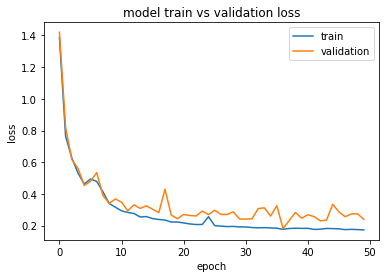

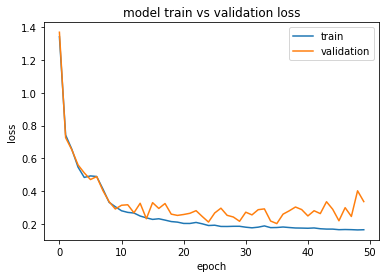

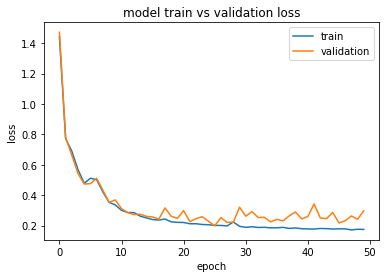

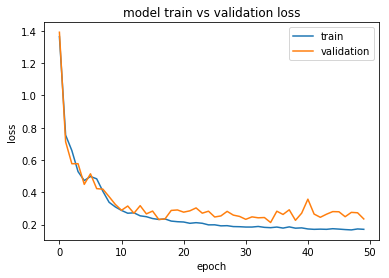

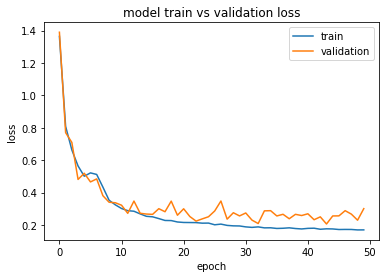

In [15]:
# plot train and validation loss
plt.plot(lloogg_1['train']['epoch'], lloogg_1['train']['loss'])
plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_2['train']['epoch'], lloogg_2['train']['loss'])
plt.plot(lloogg_2['val']['epoch'], lloogg_2['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_3['train']['epoch'], lloogg_3['train']['loss'])
plt.plot(lloogg_3['val']['epoch'], lloogg_3['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_4['train']['epoch'], lloogg_4['train']['loss'])
plt.plot(lloogg_4['val']['epoch'], lloogg_4['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_5['train']['epoch'], lloogg_5['train']['loss'])
plt.plot(lloogg_5['val']['epoch'], lloogg_5['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

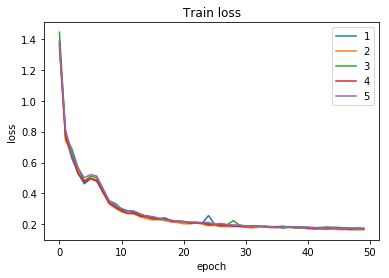

In [16]:
plt.plot(lloogg_1['train']['epoch'], lloogg_1['train']['loss'])
plt.plot(lloogg_2['train']['epoch'], lloogg_2['train']['loss'])
plt.plot(lloogg_3['train']['epoch'], lloogg_3['train']['loss'])
plt.plot(lloogg_4['train']['epoch'], lloogg_4['train']['loss'])
plt.plot(lloogg_5['train']['epoch'], lloogg_5['train']['loss'])
# plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1','2','3','4','5'], loc='upper right')
plt.show()

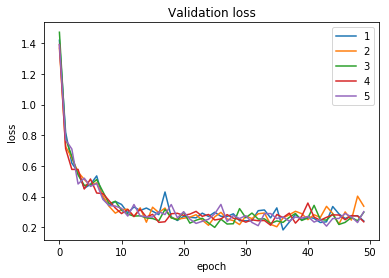

In [17]:
plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.plot(lloogg_2['val']['epoch'], lloogg_2['val']['loss'])
plt.plot(lloogg_3['val']['epoch'], lloogg_3['val']['loss'])
plt.plot(lloogg_4['val']['epoch'], lloogg_4['val']['loss'])
plt.plot(lloogg_5['val']['epoch'], lloogg_5['val']['loss'])
# plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1','2','3','4','5'], loc='upper right')
plt.show()

In [18]:
result_record_f1 = pd.DataFrame.from_dict(data=result_f1, orient='index')
result_record_f1 = np.mean(np.array(result_record_f1), axis = 0)
result_record_f1 = result_record_f1.reshape(-1)

result_record_acc = pd.DataFrame.from_dict(data=result_acc, orient='index')
result_record_acc = np.mean(np.array(result_record_acc), axis = 0)
result_record_acc = result_record_acc.reshape(-1)

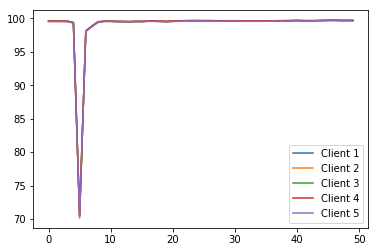

In [19]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_acc[i], label = 'Client '+ str(i+1))
plt.legend()
plt.show()

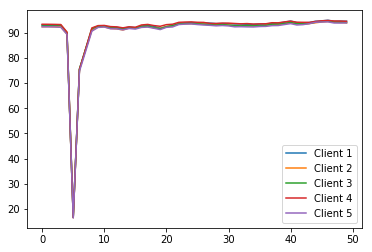

In [20]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_f1[i], label =  'Client '+ str(i+1))
plt.legend()
plt.show()